# **1. 모델 설계**

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


데이터 다운: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs

In [9]:
import os

root_path = 'cityscapes_data'

data_dir = root_path
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


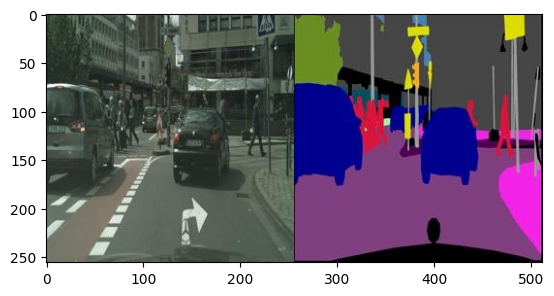

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.show()

In [11]:
import numpy as np
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)

(1000, 3)


In [12]:
from sklearn.cluster import KMeans
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

In [13]:
def split_image(image) :
   image = np.array(image)
   cityscape, label = image[:, :256, :], image[:, 256:, :]
   return cityscape, label

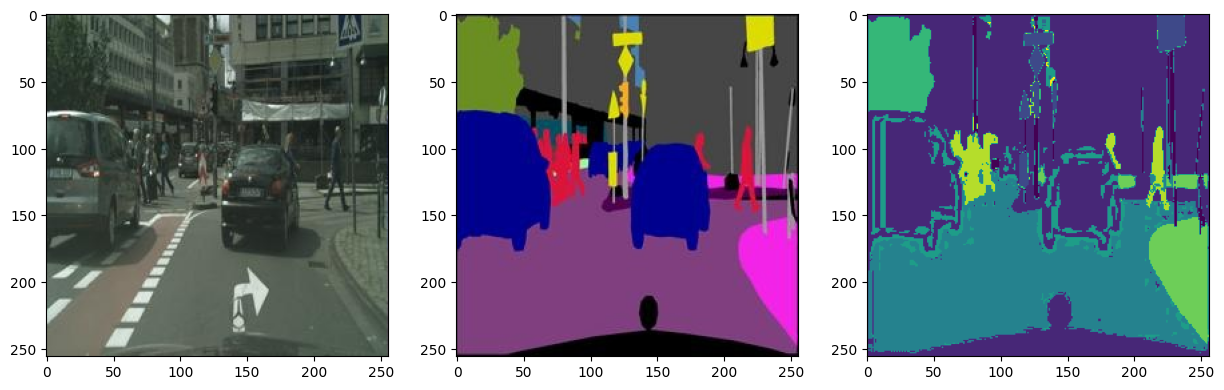

In [14]:
cityscape, label = split_image(sample_image)

label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

In [15]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self) :
    return len(self.image_fns)

  def __getitem__(self, index) :
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp)
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image) :
    image = np.array(image)
    cityscape, label = image[ : , :256, : ], image[ : , 256: , : ]
    return cityscape, label

  def transform(self, image) :
    transform_ops = transforms.Compose([
      			transforms.ToTensor(),
                        transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

cityscape, label_class = dataset[0]
print(cityscape.shape)
print(label_class.shape)

2975
torch.Size([3, 256, 256])
torch.Size([256, 256])


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()

        # encoder
        self.e1 = self.conv_block(3, 64)
        self.e2 = self.conv_block(64, 128)
        self.e3 = self.conv_block(128, 256)
        self.e4 = self.conv_block(256, 512)

        # bridge
        self.bridge = self.conv_block(512, 1024)

        # decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride=2)
        self.d2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d1 = self.conv_block(128, 64)

        # final
        self.output = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True), 
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)            
        )

    def forward(self, X):
        # encoder
        enc1 = self.e1(X)
        enc2 = self.e2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.e3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.e4(F.max_pool2d(enc3, kernel_size=2))

        # bridge
        bridge = self.bridge(F.max_pool2d(enc4, kernel_size=2))

        # decoder
        dec4 = self.upconv4(bridge)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.d4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.d3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.d2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.d1(dec1)

        output_out = self.output(dec1)

        return output_out

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

model = UNet(num_classes=num_classes)
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape)
print(Y.shape)

2975 744
torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


In [21]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


# **2. 모델 학습**

In [23]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 하이퍼파라미터 자율설정

batch_size = 4

epochs = 10
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

model = UNet(num_classes = num_classes).to(device)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), lr = lr)


step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0

  for X, Y in tqdm(data_loader, total = len(data_loader), leave = False) :
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 3/744 [00:00<02:08,  5.79it/s]

epoch: 0 epoch_loss: 2.36029052734375
epoch: 0 epoch_loss: 4.495514869689941
epoch: 0 epoch_loss: 6.258963465690613


  1%|          | 7/744 [00:00<01:10, 10.45it/s]

epoch: 0 epoch_loss: 7.9401854276657104
epoch: 0 epoch_loss: 9.532420039176941
epoch: 0 epoch_loss: 11.042129039764404
epoch: 0 epoch_loss: 12.564058899879456


  1%|          | 9/744 [00:00<01:02, 11.84it/s]

epoch: 0 epoch_loss: 14.01942229270935
epoch: 0 epoch_loss: 15.503264784812927
epoch: 0 epoch_loss: 16.922340750694275


  2%|▏         | 13/744 [00:01<00:52, 13.86it/s]

epoch: 0 epoch_loss: 18.21109414100647
epoch: 0 epoch_loss: 19.415546894073486
epoch: 0 epoch_loss: 20.76642632484436
epoch: 0 epoch_loss: 22.033448696136475


  2%|▏         | 17/744 [00:01<00:48, 14.89it/s]

epoch: 0 epoch_loss: 23.197473406791687
epoch: 0 epoch_loss: 24.45070457458496
epoch: 0 epoch_loss: 25.811629056930542
epoch: 0 epoch_loss: 27.006983041763306


  3%|▎         | 21/744 [00:01<00:46, 15.63it/s]

epoch: 0 epoch_loss: 28.250202655792236
epoch: 0 epoch_loss: 29.27927339076996
epoch: 0 epoch_loss: 30.36214244365692
epoch: 0 epoch_loss: 31.405893206596375


  3%|▎         | 25/744 [00:01<00:43, 16.45it/s]

epoch: 0 epoch_loss: 32.54913580417633
epoch: 0 epoch_loss: 33.69719481468201
epoch: 0 epoch_loss: 35.02654206752777
epoch: 0 epoch_loss: 36.198927998542786


  4%|▍         | 29/744 [00:02<00:43, 16.51it/s]

epoch: 0 epoch_loss: 37.37372350692749
epoch: 0 epoch_loss: 38.52681231498718
epoch: 0 epoch_loss: 39.63352954387665
epoch: 0 epoch_loss: 41.08950400352478


  4%|▍         | 33/744 [00:02<00:42, 16.75it/s]

epoch: 0 epoch_loss: 42.16868829727173
epoch: 0 epoch_loss: 43.097352623939514
epoch: 0 epoch_loss: 44.284314036369324
epoch: 0 epoch_loss: 45.54816377162933


  5%|▍         | 37/744 [00:02<00:41, 16.96it/s]

epoch: 0 epoch_loss: 46.65527606010437
epoch: 0 epoch_loss: 47.82950186729431
epoch: 0 epoch_loss: 48.937886476516724
epoch: 0 epoch_loss: 50.15361738204956


  6%|▌         | 41/744 [00:02<00:45, 15.47it/s]

epoch: 0 epoch_loss: 51.532923340797424
epoch: 0 epoch_loss: 52.691044211387634
epoch: 0 epoch_loss: 53.86112868785858
epoch: 0 epoch_loss: 55.049623131752014


  6%|▌         | 45/744 [00:03<00:44, 15.87it/s]

epoch: 0 epoch_loss: 56.37254214286804
epoch: 0 epoch_loss: 57.43110406398773
epoch: 0 epoch_loss: 58.43308365345001
epoch: 0 epoch_loss: 59.55219089984894


  7%|▋         | 49/744 [00:03<00:41, 16.74it/s]

epoch: 0 epoch_loss: 60.558976888656616
epoch: 0 epoch_loss: 62.24366092681885
epoch: 0 epoch_loss: 63.24259376525879
epoch: 0 epoch_loss: 64.22524333000183


  7%|▋         | 53/744 [00:03<00:40, 17.03it/s]

epoch: 0 epoch_loss: 65.3864004611969
epoch: 0 epoch_loss: 66.25732922554016
epoch: 0 epoch_loss: 67.16780203580856
epoch: 0 epoch_loss: 68.23123353719711


  8%|▊         | 57/744 [00:03<00:41, 16.46it/s]

epoch: 0 epoch_loss: 69.23449796438217
epoch: 0 epoch_loss: 70.28504186868668
epoch: 0 epoch_loss: 71.45550018548965
epoch: 0 epoch_loss: 72.35078001022339


  8%|▊         | 61/744 [00:04<00:41, 16.57it/s]

epoch: 0 epoch_loss: 73.17038655281067
epoch: 0 epoch_loss: 74.37476062774658
epoch: 0 epoch_loss: 75.65414714813232
epoch: 0 epoch_loss: 76.87898087501526


  9%|▊         | 65/744 [00:04<00:42, 15.96it/s]

epoch: 0 epoch_loss: 78.32729494571686
epoch: 0 epoch_loss: 79.37414014339447
epoch: 0 epoch_loss: 80.52814292907715
epoch: 0 epoch_loss: 81.61152815818787


  9%|▉         | 69/744 [00:04<00:40, 16.56it/s]

epoch: 0 epoch_loss: 82.93130993843079
epoch: 0 epoch_loss: 84.00311017036438
epoch: 0 epoch_loss: 84.9482649564743
epoch: 0 epoch_loss: 86.01467192173004


 10%|▉         | 73/744 [00:04<00:41, 16.29it/s]

epoch: 0 epoch_loss: 87.00246465206146
epoch: 0 epoch_loss: 87.94190752506256
epoch: 0 epoch_loss: 88.96018099784851
epoch: 0 epoch_loss: 90.24651408195496


 10%|█         | 77/744 [00:05<00:42, 15.69it/s]

epoch: 0 epoch_loss: 91.41792023181915
epoch: 0 epoch_loss: 92.32405650615692
epoch: 0 epoch_loss: 93.13545370101929
epoch: 0 epoch_loss: 94.12217003107071


 11%|█         | 81/744 [00:05<00:40, 16.41it/s]

epoch: 0 epoch_loss: 95.16766482591629
epoch: 0 epoch_loss: 96.18100792169571
epoch: 0 epoch_loss: 97.2709910273552
epoch: 0 epoch_loss: 98.11750501394272


 11%|█▏        | 85/744 [00:05<00:41, 15.86it/s]

epoch: 0 epoch_loss: 99.36493104696274
epoch: 0 epoch_loss: 100.39622753858566
epoch: 0 epoch_loss: 101.48672527074814
epoch: 0 epoch_loss: 102.56045740842819


 12%|█▏        | 89/744 [00:05<00:40, 16.09it/s]

epoch: 0 epoch_loss: 103.44734919071198
epoch: 0 epoch_loss: 104.38221764564514
epoch: 0 epoch_loss: 105.31756395101547
epoch: 0 epoch_loss: 106.23245483636856


 12%|█▎        | 93/744 [00:06<00:40, 16.27it/s]

epoch: 0 epoch_loss: 107.21829384565353
epoch: 0 epoch_loss: 108.13979363441467
epoch: 0 epoch_loss: 108.92255592346191
epoch: 0 epoch_loss: 109.72161567211151


 13%|█▎        | 97/744 [00:06<00:37, 17.13it/s]

epoch: 0 epoch_loss: 110.56746464967728
epoch: 0 epoch_loss: 111.72368305921555
epoch: 0 epoch_loss: 112.60797536373138
epoch: 0 epoch_loss: 113.81542146205902


 14%|█▎        | 101/744 [00:06<00:36, 17.51it/s]

epoch: 0 epoch_loss: 114.9178878068924
epoch: 0 epoch_loss: 116.014883518219
epoch: 0 epoch_loss: 117.01373916864395
epoch: 0 epoch_loss: 117.99606275558472


 14%|█▍        | 105/744 [00:06<00:37, 17.26it/s]

epoch: 0 epoch_loss: 119.0824202299118
epoch: 0 epoch_loss: 120.13070857524872
epoch: 0 epoch_loss: 121.14071834087372
epoch: 0 epoch_loss: 122.22383737564087


 15%|█▍        | 109/744 [00:07<00:40, 15.72it/s]

epoch: 0 epoch_loss: 123.30707716941833
epoch: 0 epoch_loss: 124.45274603366852
epoch: 0 epoch_loss: 125.46178007125854


 15%|█▍        | 111/744 [00:07<00:42, 14.84it/s]

epoch: 0 epoch_loss: 126.52376449108124
epoch: 0 epoch_loss: 127.60656380653381
epoch: 0 epoch_loss: 128.59196186065674


 15%|█▌        | 115/744 [00:07<00:38, 16.14it/s]

epoch: 0 epoch_loss: 129.6415078639984
epoch: 0 epoch_loss: 130.4425260424614
epoch: 0 epoch_loss: 131.29541569948196
epoch: 0 epoch_loss: 132.28780215978622


 16%|█▌        | 119/744 [00:07<00:36, 16.90it/s]

epoch: 0 epoch_loss: 133.29976469278336
epoch: 0 epoch_loss: 134.152891933918
epoch: 0 epoch_loss: 135.1342966556549
epoch: 0 epoch_loss: 136.07738840579987


 17%|█▋        | 123/744 [00:07<00:35, 17.44it/s]

epoch: 0 epoch_loss: 136.887531042099
epoch: 0 epoch_loss: 138.0576709508896
epoch: 0 epoch_loss: 139.06740081310272
epoch: 0 epoch_loss: 139.9637862443924


 17%|█▋        | 127/744 [00:08<00:34, 17.70it/s]

epoch: 0 epoch_loss: 140.8318990468979
epoch: 0 epoch_loss: 141.6623876094818
epoch: 0 epoch_loss: 142.71428513526917
epoch: 0 epoch_loss: 143.58991795778275


 18%|█▊        | 131/744 [00:08<00:34, 17.78it/s]

epoch: 0 epoch_loss: 144.77617555856705
epoch: 0 epoch_loss: 145.7278681397438
epoch: 0 epoch_loss: 146.6824912428856
epoch: 0 epoch_loss: 147.5899909734726


 18%|█▊        | 135/744 [00:08<00:33, 18.28it/s]

epoch: 0 epoch_loss: 148.52370411157608
epoch: 0 epoch_loss: 149.32599717378616
epoch: 0 epoch_loss: 150.32985216379166
epoch: 0 epoch_loss: 151.13585364818573


 19%|█▊        | 139/744 [00:08<00:33, 18.11it/s]

epoch: 0 epoch_loss: 152.0939495563507
epoch: 0 epoch_loss: 152.98566484451294
epoch: 0 epoch_loss: 153.95449113845825
epoch: 0 epoch_loss: 154.87740886211395


 19%|█▉        | 143/744 [00:09<00:33, 17.93it/s]

epoch: 0 epoch_loss: 155.80941659212112
epoch: 0 epoch_loss: 156.72413796186447
epoch: 0 epoch_loss: 157.5540538430214
epoch: 0 epoch_loss: 158.52144753932953


 20%|█▉        | 147/744 [00:09<00:35, 16.81it/s]

epoch: 0 epoch_loss: 159.59659326076508
epoch: 0 epoch_loss: 160.66976010799408
epoch: 0 epoch_loss: 161.9571442604065
epoch: 0 epoch_loss: 162.78792560100555


 20%|██        | 151/744 [00:09<00:35, 16.80it/s]

epoch: 0 epoch_loss: 163.48639833927155
epoch: 0 epoch_loss: 164.37339144945145
epoch: 0 epoch_loss: 165.30748772621155


 21%|██        | 155/744 [00:09<00:37, 15.89it/s]

epoch: 0 epoch_loss: 166.1279991865158
epoch: 0 epoch_loss: 167.07285088300705
epoch: 0 epoch_loss: 167.9512745141983
epoch: 0 epoch_loss: 168.93589609861374


 21%|██▏       | 159/744 [00:10<00:34, 17.16it/s]

epoch: 0 epoch_loss: 169.8609339594841
epoch: 0 epoch_loss: 170.62974339723587
epoch: 0 epoch_loss: 171.34989196062088
epoch: 0 epoch_loss: 172.36889618635178


 22%|██▏       | 163/744 [00:10<00:35, 16.58it/s]

epoch: 0 epoch_loss: 173.1158235669136
epoch: 0 epoch_loss: 174.04606539011002
epoch: 0 epoch_loss: 174.99277740716934
epoch: 0 epoch_loss: 176.14041990041733


 22%|██▏       | 167/744 [00:10<00:34, 16.53it/s]

epoch: 0 epoch_loss: 177.1372873187065
epoch: 0 epoch_loss: 178.23043578863144
epoch: 0 epoch_loss: 179.1522986292839
epoch: 0 epoch_loss: 180.15552884340286


 23%|██▎       | 171/744 [00:10<00:35, 16.23it/s]

epoch: 0 epoch_loss: 181.10749793052673
epoch: 0 epoch_loss: 181.9526458978653
epoch: 0 epoch_loss: 182.88527363538742
epoch: 0 epoch_loss: 183.74101853370667


 24%|██▎       | 175/744 [00:11<00:34, 16.55it/s]

epoch: 0 epoch_loss: 184.68503677845
epoch: 0 epoch_loss: 185.58351546525955
epoch: 0 epoch_loss: 186.73883932828903
epoch: 0 epoch_loss: 187.7666022181511


 24%|██▍       | 179/744 [00:11<00:33, 17.07it/s]

epoch: 0 epoch_loss: 188.62780094146729
epoch: 0 epoch_loss: 189.61555111408234
epoch: 0 epoch_loss: 190.42867916822433
epoch: 0 epoch_loss: 191.3537568449974


 24%|██▍       | 181/744 [00:11<00:35, 15.75it/s]

epoch: 0 epoch_loss: 192.22670191526413
epoch: 0 epoch_loss: 193.40267723798752
epoch: 0 epoch_loss: 194.30694502592087


 25%|██▍       | 185/744 [00:11<00:39, 14.05it/s]

epoch: 0 epoch_loss: 195.303872525692
epoch: 0 epoch_loss: 196.51551622152328
epoch: 0 epoch_loss: 197.4995886683464


 25%|██▌       | 189/744 [00:11<00:37, 14.74it/s]

epoch: 0 epoch_loss: 198.26313298940659
epoch: 0 epoch_loss: 199.25765073299408
epoch: 0 epoch_loss: 200.0378131866455
epoch: 0 epoch_loss: 200.80687534809113


 26%|██▌       | 193/744 [00:12<00:34, 15.84it/s]

epoch: 0 epoch_loss: 201.86533105373383
epoch: 0 epoch_loss: 202.88282358646393
epoch: 0 epoch_loss: 203.68235623836517
epoch: 0 epoch_loss: 204.56504422426224


 26%|██▋       | 197/744 [00:12<00:32, 16.67it/s]

epoch: 0 epoch_loss: 205.6196876168251
epoch: 0 epoch_loss: 206.77709418535233
epoch: 0 epoch_loss: 207.97584754228592
epoch: 0 epoch_loss: 208.92190438508987


 27%|██▋       | 201/744 [00:12<00:33, 16.23it/s]

epoch: 0 epoch_loss: 209.9106321334839
epoch: 0 epoch_loss: 210.9564551115036
epoch: 0 epoch_loss: 211.97394359111786
epoch: 0 epoch_loss: 212.9316931962967


 28%|██▊       | 205/744 [00:12<00:31, 17.01it/s]

epoch: 0 epoch_loss: 213.85051429271698
epoch: 0 epoch_loss: 214.94599032402039
epoch: 0 epoch_loss: 215.77284598350525
epoch: 0 epoch_loss: 216.6367336511612


 28%|██▊       | 209/744 [00:13<00:31, 17.10it/s]

epoch: 0 epoch_loss: 217.63311237096786
epoch: 0 epoch_loss: 218.53049683570862
epoch: 0 epoch_loss: 219.4031159877777
epoch: 0 epoch_loss: 220.30637800693512


 29%|██▊       | 213/744 [00:13<00:31, 16.85it/s]

epoch: 0 epoch_loss: 221.1363708972931
epoch: 0 epoch_loss: 222.07540953159332
epoch: 0 epoch_loss: 223.19796705245972
epoch: 0 epoch_loss: 224.3469921350479


 29%|██▉       | 217/744 [00:13<00:32, 16.18it/s]

epoch: 0 epoch_loss: 225.1855360865593
epoch: 0 epoch_loss: 226.0542671084404
epoch: 0 epoch_loss: 227.15256088972092
epoch: 0 epoch_loss: 227.9925041794777


 30%|██▉       | 221/744 [00:13<00:31, 16.53it/s]

epoch: 0 epoch_loss: 228.83161181211472
epoch: 0 epoch_loss: 229.69545876979828
epoch: 0 epoch_loss: 230.8807713985443
epoch: 0 epoch_loss: 231.8103466629982


 30%|███       | 225/744 [00:14<00:31, 16.72it/s]

epoch: 0 epoch_loss: 232.62303906679153
epoch: 0 epoch_loss: 233.69398087263107
epoch: 0 epoch_loss: 234.71128314733505
epoch: 0 epoch_loss: 235.49203878641129


 31%|███       | 229/744 [00:14<00:29, 17.20it/s]

epoch: 0 epoch_loss: 236.4097306728363
epoch: 0 epoch_loss: 237.1748809814453
epoch: 0 epoch_loss: 238.10782212018967
epoch: 0 epoch_loss: 239.17054969072342


 31%|███▏      | 233/744 [00:14<00:30, 16.81it/s]

epoch: 0 epoch_loss: 240.1967687010765
epoch: 0 epoch_loss: 241.07824516296387
epoch: 0 epoch_loss: 241.91239893436432
epoch: 0 epoch_loss: 242.73871040344238


 32%|███▏      | 237/744 [00:14<00:30, 16.63it/s]

epoch: 0 epoch_loss: 243.701067507267
epoch: 0 epoch_loss: 244.39055222272873
epoch: 0 epoch_loss: 245.1235609650612
epoch: 0 epoch_loss: 245.8256717324257


 32%|███▏      | 241/744 [00:15<00:29, 17.27it/s]

epoch: 0 epoch_loss: 246.7990923523903
epoch: 0 epoch_loss: 247.6218477487564
epoch: 0 epoch_loss: 248.50887751579285
epoch: 0 epoch_loss: 249.36056715250015


 33%|███▎      | 245/744 [00:15<00:29, 16.68it/s]

epoch: 0 epoch_loss: 250.24917602539062
epoch: 0 epoch_loss: 251.21185791492462
epoch: 0 epoch_loss: 252.1821540594101
epoch: 0 epoch_loss: 253.06804955005646


 33%|███▎      | 249/744 [00:15<00:31, 15.95it/s]

epoch: 0 epoch_loss: 254.07612240314484
epoch: 0 epoch_loss: 254.97796654701233
epoch: 0 epoch_loss: 255.8419207930565
epoch: 0 epoch_loss: 256.66029649972916


 34%|███▍      | 253/744 [00:15<00:32, 15.04it/s]

epoch: 0 epoch_loss: 257.71894842386246
epoch: 0 epoch_loss: 258.41021263599396
epoch: 0 epoch_loss: 259.57884562015533
epoch: 0 epoch_loss: 260.2691727876663


 34%|███▍      | 255/744 [00:15<00:32, 15.23it/s]

epoch: 0 epoch_loss: 261.07738423347473
epoch: 0 epoch_loss: 261.9797628521919
epoch: 0 epoch_loss: 262.78250962495804


 35%|███▍      | 259/744 [00:16<00:33, 14.51it/s]

epoch: 0 epoch_loss: 263.8226336836815
epoch: 0 epoch_loss: 264.5837386250496
epoch: 0 epoch_loss: 265.4431236386299


 35%|███▌      | 263/744 [00:16<00:30, 15.58it/s]

epoch: 0 epoch_loss: 266.32469671964645
epoch: 0 epoch_loss: 267.31712621450424
epoch: 0 epoch_loss: 268.2070268392563
epoch: 0 epoch_loss: 268.9169861674309


 36%|███▌      | 267/744 [00:16<00:30, 15.61it/s]

epoch: 0 epoch_loss: 269.9267346262932
epoch: 0 epoch_loss: 270.81584018468857
epoch: 0 epoch_loss: 271.86964625120163
epoch: 0 epoch_loss: 272.6260343194008


 36%|███▋      | 271/744 [00:16<00:29, 16.23it/s]

epoch: 0 epoch_loss: 273.6815796494484
epoch: 0 epoch_loss: 274.38677567243576
epoch: 0 epoch_loss: 275.22796255350113
epoch: 0 epoch_loss: 276.20744228363037


 37%|███▋      | 273/744 [00:17<00:32, 14.68it/s]

epoch: 0 epoch_loss: 277.1244696378708
epoch: 0 epoch_loss: 277.93337619304657
epoch: 0 epoch_loss: 278.6597069501877


 37%|███▋      | 277/744 [00:17<00:30, 15.55it/s]

epoch: 0 epoch_loss: 279.5194004178047
epoch: 0 epoch_loss: 280.28555315732956
epoch: 0 epoch_loss: 281.3298274874687
epoch: 0 epoch_loss: 282.46126967668533


 38%|███▊      | 281/744 [00:17<00:29, 15.69it/s]

epoch: 0 epoch_loss: 283.13021832704544
epoch: 0 epoch_loss: 283.9845097064972
epoch: 0 epoch_loss: 285.0594127178192
epoch: 0 epoch_loss: 285.9495438337326


 38%|███▊      | 285/744 [00:17<00:29, 15.79it/s]

epoch: 0 epoch_loss: 286.7203349471092
epoch: 0 epoch_loss: 287.56949883699417
epoch: 0 epoch_loss: 288.28781938552856


 39%|███▉      | 289/744 [00:18<00:29, 15.18it/s]

epoch: 0 epoch_loss: 289.07496428489685
epoch: 0 epoch_loss: 290.08379077911377
epoch: 0 epoch_loss: 290.9520434141159
epoch: 0 epoch_loss: 291.83817768096924


 39%|███▉      | 293/744 [00:18<00:29, 15.45it/s]

epoch: 0 epoch_loss: 292.61698883771896
epoch: 0 epoch_loss: 293.5595068335533
epoch: 0 epoch_loss: 294.4536743760109
epoch: 0 epoch_loss: 295.1104580760002


 40%|███▉      | 295/744 [00:18<00:29, 15.21it/s]

epoch: 0 epoch_loss: 296.3064220547676
epoch: 0 epoch_loss: 297.0861387848854
epoch: 0 epoch_loss: 297.975813806057


 40%|████      | 299/744 [00:18<00:28, 15.71it/s]

epoch: 0 epoch_loss: 298.89361733198166
epoch: 0 epoch_loss: 299.7108157277107
epoch: 0 epoch_loss: 300.48362720012665
epoch: 0 epoch_loss: 301.2937111258507


 41%|████      | 303/744 [00:19<00:29, 15.20it/s]

epoch: 0 epoch_loss: 302.15742391347885
epoch: 0 epoch_loss: 303.1042928099632
epoch: 0 epoch_loss: 303.8635339140892
epoch: 0 epoch_loss: 304.74897772073746


 41%|████▏     | 307/744 [00:19<00:27, 15.61it/s]

epoch: 0 epoch_loss: 305.7812972664833
epoch: 0 epoch_loss: 306.6750746369362
epoch: 0 epoch_loss: 307.5276061296463
epoch: 0 epoch_loss: 308.4324995279312


 42%|████▏     | 311/744 [00:19<00:30, 14.41it/s]

epoch: 0 epoch_loss: 309.28897017240524
epoch: 0 epoch_loss: 310.0890503525734
epoch: 0 epoch_loss: 311.11746150255203


 42%|████▏     | 313/744 [00:19<00:31, 13.60it/s]

epoch: 0 epoch_loss: 311.9654908180237
epoch: 0 epoch_loss: 312.6769388914108
epoch: 0 epoch_loss: 313.5150025486946
epoch: 0 epoch_loss: 314.2673186659813


 43%|████▎     | 317/744 [00:20<00:29, 14.24it/s]

epoch: 0 epoch_loss: 315.18063950538635
epoch: 0 epoch_loss: 315.97418862581253
epoch: 0 epoch_loss: 316.65851378440857


 43%|████▎     | 321/744 [00:20<00:29, 14.35it/s]

epoch: 0 epoch_loss: 317.41954761743546
epoch: 0 epoch_loss: 318.24715024232864
epoch: 0 epoch_loss: 319.12569522857666


 44%|████▎     | 325/744 [00:20<00:28, 14.46it/s]

epoch: 0 epoch_loss: 319.86092710494995
epoch: 0 epoch_loss: 320.61017978191376
epoch: 0 epoch_loss: 321.49930703639984
epoch: 0 epoch_loss: 322.4269041419029


 44%|████▍     | 329/744 [00:20<00:27, 14.87it/s]

epoch: 0 epoch_loss: 323.1501359939575
epoch: 0 epoch_loss: 323.79525911808014
epoch: 0 epoch_loss: 324.711049079895
epoch: 0 epoch_loss: 325.6780101656914


 44%|████▍     | 331/744 [00:21<00:27, 14.90it/s]

epoch: 0 epoch_loss: 326.39488512277603
epoch: 0 epoch_loss: 327.2036638855934
epoch: 0 epoch_loss: 328.0641214251518


 45%|████▌     | 335/744 [00:21<00:26, 15.18it/s]

epoch: 0 epoch_loss: 328.72839760780334
epoch: 0 epoch_loss: 329.453622341156
epoch: 0 epoch_loss: 330.22746819257736
epoch: 0 epoch_loss: 330.9874151945114


 46%|████▌     | 339/744 [00:21<00:24, 16.52it/s]

epoch: 0 epoch_loss: 331.7313905954361
epoch: 0 epoch_loss: 332.4041726589203
epoch: 0 epoch_loss: 333.37824803590775
epoch: 0 epoch_loss: 334.0765114426613


 46%|████▌     | 343/744 [00:21<00:25, 15.80it/s]

epoch: 0 epoch_loss: 334.7815853357315
epoch: 0 epoch_loss: 335.47180134058
epoch: 0 epoch_loss: 336.58252638578415
epoch: 0 epoch_loss: 337.31521850824356


 47%|████▋     | 347/744 [00:21<00:23, 16.69it/s]

epoch: 0 epoch_loss: 338.0960342884064
epoch: 0 epoch_loss: 338.8087364435196
epoch: 0 epoch_loss: 339.58108127117157
epoch: 0 epoch_loss: 340.3808698654175


 47%|████▋     | 351/744 [00:22<00:22, 17.51it/s]

epoch: 0 epoch_loss: 341.19508224725723
epoch: 0 epoch_loss: 341.9292974472046
epoch: 0 epoch_loss: 342.59242129325867
epoch: 0 epoch_loss: 343.5237475633621


 48%|████▊     | 355/744 [00:22<00:23, 16.62it/s]

epoch: 0 epoch_loss: 344.5782973766327
epoch: 0 epoch_loss: 345.231991648674
epoch: 0 epoch_loss: 345.9998454451561
epoch: 0 epoch_loss: 347.28055053949356


 48%|████▊     | 359/744 [00:22<00:23, 16.36it/s]

epoch: 0 epoch_loss: 347.9236848950386
epoch: 0 epoch_loss: 348.9598519206047
epoch: 0 epoch_loss: 349.82445698976517
epoch: 0 epoch_loss: 350.5849159359932


 49%|████▉     | 363/744 [00:22<00:22, 16.80it/s]

epoch: 0 epoch_loss: 351.31556379795074
epoch: 0 epoch_loss: 352.0816522836685
epoch: 0 epoch_loss: 352.95113956928253
epoch: 0 epoch_loss: 353.98845171928406


 49%|████▉     | 367/744 [00:23<00:22, 16.94it/s]

epoch: 0 epoch_loss: 354.8081337213516
epoch: 0 epoch_loss: 355.7378119826317
epoch: 0 epoch_loss: 356.3959287405014
epoch: 0 epoch_loss: 357.3256178498268


 50%|████▉     | 371/744 [00:23<00:22, 16.52it/s]

epoch: 0 epoch_loss: 358.2948617339134
epoch: 0 epoch_loss: 359.1298562884331
epoch: 0 epoch_loss: 360.01011568307877
epoch: 0 epoch_loss: 361.0782957673073


 50%|█████     | 375/744 [00:23<00:24, 15.35it/s]

epoch: 0 epoch_loss: 361.78595501184464
epoch: 0 epoch_loss: 362.6602273583412
epoch: 0 epoch_loss: 363.7210484147072


 51%|█████     | 379/744 [00:23<00:21, 16.71it/s]

epoch: 0 epoch_loss: 364.6941267848015
epoch: 0 epoch_loss: 365.48218125104904
epoch: 0 epoch_loss: 366.21998888254166
epoch: 0 epoch_loss: 366.9754939675331


 51%|█████▏    | 383/744 [00:24<00:21, 17.06it/s]

epoch: 0 epoch_loss: 367.8245253562927
epoch: 0 epoch_loss: 368.6915853023529
epoch: 0 epoch_loss: 369.4353086948395
epoch: 0 epoch_loss: 370.3896664381027


 52%|█████▏    | 387/744 [00:24<00:20, 17.17it/s]

epoch: 0 epoch_loss: 371.14157235622406
epoch: 0 epoch_loss: 372.1223638057709
epoch: 0 epoch_loss: 372.88558727502823
epoch: 0 epoch_loss: 373.6006764769554


 53%|█████▎    | 391/744 [00:24<00:20, 17.54it/s]

epoch: 0 epoch_loss: 374.303719162941
epoch: 0 epoch_loss: 375.2765771150589
epoch: 0 epoch_loss: 376.1161217689514
epoch: 0 epoch_loss: 376.9074603319168


 53%|█████▎    | 395/744 [00:24<00:19, 17.52it/s]

epoch: 0 epoch_loss: 377.5533435344696
epoch: 0 epoch_loss: 378.2216629385948
epoch: 0 epoch_loss: 379.10210531949997
epoch: 0 epoch_loss: 380.01820558309555


 53%|█████▎    | 397/744 [00:24<00:19, 17.36it/s]

epoch: 0 epoch_loss: 381.0874759554863
epoch: 0 epoch_loss: 381.92355340719223
epoch: 0 epoch_loss: 382.72885251045227


 54%|█████▍    | 401/744 [00:25<00:21, 16.25it/s]

epoch: 0 epoch_loss: 383.37155294418335
epoch: 0 epoch_loss: 384.16940581798553
epoch: 0 epoch_loss: 384.99956476688385
epoch: 0 epoch_loss: 385.7896311879158


 54%|█████▍    | 405/744 [00:25<00:20, 16.89it/s]

epoch: 0 epoch_loss: 386.6005509495735
epoch: 0 epoch_loss: 387.4888508915901
epoch: 0 epoch_loss: 388.3504745364189
epoch: 0 epoch_loss: 389.5365177989006


 55%|█████▍    | 409/744 [00:25<00:21, 15.79it/s]

epoch: 0 epoch_loss: 390.457272708416
epoch: 0 epoch_loss: 391.2935399413109
epoch: 0 epoch_loss: 392.07627934217453
epoch: 0 epoch_loss: 392.84696209430695


 56%|█████▌    | 413/744 [00:25<00:20, 16.54it/s]

epoch: 0 epoch_loss: 393.541032910347
epoch: 0 epoch_loss: 394.271577000618
epoch: 0 epoch_loss: 395.21632474660873
epoch: 0 epoch_loss: 395.97999477386475


 56%|█████▌    | 417/744 [00:26<00:19, 16.77it/s]

epoch: 0 epoch_loss: 396.9952530860901
epoch: 0 epoch_loss: 398.02237582206726
epoch: 0 epoch_loss: 398.77183878421783
epoch: 0 epoch_loss: 399.5601750612259


 57%|█████▋    | 421/744 [00:26<00:19, 16.56it/s]

epoch: 0 epoch_loss: 400.5666981935501
epoch: 0 epoch_loss: 401.39627665281296
epoch: 0 epoch_loss: 402.0883290171623
epoch: 0 epoch_loss: 402.87847888469696


 57%|█████▋    | 425/744 [00:26<00:18, 17.22it/s]

epoch: 0 epoch_loss: 403.96411073207855
epoch: 0 epoch_loss: 404.76780915260315
epoch: 0 epoch_loss: 405.70475274324417
epoch: 0 epoch_loss: 406.5326818227768


 58%|█████▊    | 429/744 [00:26<00:18, 17.40it/s]

epoch: 0 epoch_loss: 407.23209792375565
epoch: 0 epoch_loss: 407.9516906142235
epoch: 0 epoch_loss: 408.9254381656647
epoch: 0 epoch_loss: 409.71584033966064


 58%|█████▊    | 433/744 [00:27<00:19, 15.81it/s]

epoch: 0 epoch_loss: 410.39455687999725
epoch: 0 epoch_loss: 411.10783898830414
epoch: 0 epoch_loss: 412.0116970539093


 59%|█████▊    | 437/744 [00:27<00:18, 16.59it/s]

epoch: 0 epoch_loss: 412.7331749200821
epoch: 0 epoch_loss: 413.63360822200775
epoch: 0 epoch_loss: 414.6179373860359
epoch: 0 epoch_loss: 415.60983741283417


 59%|█████▉    | 441/744 [00:27<00:18, 16.36it/s]

epoch: 0 epoch_loss: 416.336707174778
epoch: 0 epoch_loss: 417.19168704748154
epoch: 0 epoch_loss: 418.1295517086983
epoch: 0 epoch_loss: 418.94251638650894


 60%|█████▉    | 445/744 [00:27<00:17, 17.02it/s]

epoch: 0 epoch_loss: 419.5057618021965
epoch: 0 epoch_loss: 420.35715687274933
epoch: 0 epoch_loss: 421.06683295965195
epoch: 0 epoch_loss: 422.1444701552391


 60%|██████    | 449/744 [00:28<00:17, 17.13it/s]

epoch: 0 epoch_loss: 422.9660469889641
epoch: 0 epoch_loss: 423.77159065008163
epoch: 0 epoch_loss: 424.71411722898483
epoch: 0 epoch_loss: 425.4390441775322


 61%|██████    | 453/744 [00:28<00:17, 16.74it/s]

epoch: 0 epoch_loss: 426.09719973802567
epoch: 0 epoch_loss: 427.1038311123848
epoch: 0 epoch_loss: 427.90881794691086
epoch: 0 epoch_loss: 428.7619557976723


 61%|██████▏   | 457/744 [00:28<00:16, 17.31it/s]

epoch: 0 epoch_loss: 429.5532796382904
epoch: 0 epoch_loss: 430.5842082500458
epoch: 0 epoch_loss: 431.3203670978546
epoch: 0 epoch_loss: 432.22289764881134


 62%|██████▏   | 461/744 [00:28<00:15, 17.74it/s]

epoch: 0 epoch_loss: 432.97017908096313
epoch: 0 epoch_loss: 433.6455129981041
epoch: 0 epoch_loss: 434.4242707490921
epoch: 0 epoch_loss: 435.31499695777893


 62%|██████▎   | 465/744 [00:28<00:15, 17.96it/s]

epoch: 0 epoch_loss: 435.9507128596306
epoch: 0 epoch_loss: 436.97875970602036
epoch: 0 epoch_loss: 437.57898646593094
epoch: 0 epoch_loss: 438.46639186143875


 63%|██████▎   | 469/744 [00:29<00:15, 18.08it/s]

epoch: 0 epoch_loss: 439.1136934161186
epoch: 0 epoch_loss: 439.9954156279564
epoch: 0 epoch_loss: 440.8852433562279
epoch: 0 epoch_loss: 441.6887951493263


 64%|██████▎   | 473/744 [00:29<00:14, 18.14it/s]

epoch: 0 epoch_loss: 442.49175518751144
epoch: 0 epoch_loss: 443.1142702102661
epoch: 0 epoch_loss: 443.9286277294159
epoch: 0 epoch_loss: 444.66927683353424


 64%|██████▍   | 477/744 [00:29<00:15, 16.69it/s]

epoch: 0 epoch_loss: 445.4131408929825
epoch: 0 epoch_loss: 446.12211149930954
epoch: 0 epoch_loss: 447.03241819143295
epoch: 0 epoch_loss: 447.98931246995926


 64%|██████▍   | 479/744 [00:29<00:16, 16.33it/s]

epoch: 0 epoch_loss: 448.8269145488739
epoch: 0 epoch_loss: 449.5313391685486
epoch: 0 epoch_loss: 450.3826458454132


 65%|██████▍   | 483/744 [00:30<00:16, 15.75it/s]

epoch: 0 epoch_loss: 451.1466735005379
epoch: 0 epoch_loss: 452.04331094026566
epoch: 0 epoch_loss: 453.0045226216316
epoch: 0 epoch_loss: 453.8798959851265


 65%|██████▌   | 487/744 [00:30<00:15, 16.18it/s]

epoch: 0 epoch_loss: 454.53951865434647
epoch: 0 epoch_loss: 455.20709639787674
epoch: 0 epoch_loss: 456.0248970389366
epoch: 0 epoch_loss: 456.8545088171959


 66%|██████▌   | 491/744 [00:30<00:16, 15.38it/s]

epoch: 0 epoch_loss: 457.59322410821915
epoch: 0 epoch_loss: 458.5154004096985
epoch: 0 epoch_loss: 459.31808441877365
epoch: 0 epoch_loss: 460.0473056435585


 67%|██████▋   | 495/744 [00:30<00:16, 15.53it/s]

epoch: 0 epoch_loss: 460.96401911973953
epoch: 0 epoch_loss: 461.67669028043747
epoch: 0 epoch_loss: 462.62732499837875
epoch: 0 epoch_loss: 463.6855165362358


 67%|██████▋   | 499/744 [00:31<00:14, 16.34it/s]

epoch: 0 epoch_loss: 464.3476651906967
epoch: 0 epoch_loss: 465.2477025985718
epoch: 0 epoch_loss: 466.15840685367584
epoch: 0 epoch_loss: 467.195507645607


 68%|██████▊   | 503/744 [00:31<00:15, 16.05it/s]

epoch: 0 epoch_loss: 467.83515322208405
epoch: 0 epoch_loss: 468.5291637778282
epoch: 0 epoch_loss: 469.23805886507034
epoch: 0 epoch_loss: 469.9480771422386


 68%|██████▊   | 507/744 [00:31<00:15, 15.63it/s]

epoch: 0 epoch_loss: 470.5820686221123
epoch: 0 epoch_loss: 471.37627255916595
epoch: 0 epoch_loss: 472.38303208351135


 69%|██████▊   | 511/744 [00:31<00:14, 16.35it/s]

epoch: 0 epoch_loss: 473.1505093574524
epoch: 0 epoch_loss: 473.9009679555893
epoch: 0 epoch_loss: 474.6954799294472
epoch: 0 epoch_loss: 475.3604937195778


 69%|██████▉   | 515/744 [00:32<00:13, 16.80it/s]

epoch: 0 epoch_loss: 476.24121528863907
epoch: 0 epoch_loss: 477.0543786883354
epoch: 0 epoch_loss: 477.7897778749466
epoch: 0 epoch_loss: 478.6075601577759


 69%|██████▉   | 517/744 [00:32<00:13, 16.73it/s]

epoch: 0 epoch_loss: 479.45812863111496
epoch: 0 epoch_loss: 480.40738248825073
epoch: 0 epoch_loss: 481.46065413951874


 70%|███████   | 521/744 [00:32<00:15, 14.85it/s]

epoch: 0 epoch_loss: 482.5040920972824
epoch: 0 epoch_loss: 483.3400909900665
epoch: 0 epoch_loss: 484.2045798897743
epoch: 0 epoch_loss: 485.1109681725502


 71%|███████   | 525/744 [00:32<00:13, 15.76it/s]

epoch: 0 epoch_loss: 485.85408049821854
epoch: 0 epoch_loss: 486.6744208931923
epoch: 0 epoch_loss: 487.44331592321396
epoch: 0 epoch_loss: 488.05925476551056


 71%|███████   | 529/744 [00:32<00:13, 16.49it/s]

epoch: 0 epoch_loss: 488.74176412820816
epoch: 0 epoch_loss: 489.462395131588
epoch: 0 epoch_loss: 490.1408116221428
epoch: 0 epoch_loss: 490.87331968545914


 72%|███████▏  | 533/744 [00:33<00:12, 16.71it/s]

epoch: 0 epoch_loss: 491.7638700604439
epoch: 0 epoch_loss: 492.4178538322449
epoch: 0 epoch_loss: 493.1288431286812
epoch: 0 epoch_loss: 494.19733291864395


 72%|███████▏  | 537/744 [00:33<00:12, 16.85it/s]

epoch: 0 epoch_loss: 494.85648411512375
epoch: 0 epoch_loss: 495.8240634202957
epoch: 0 epoch_loss: 496.7403041124344
epoch: 0 epoch_loss: 497.4129217863083


 73%|███████▎  | 541/744 [00:33<00:11, 17.30it/s]

epoch: 0 epoch_loss: 498.168851852417
epoch: 0 epoch_loss: 498.78567945957184
epoch: 0 epoch_loss: 499.67485880851746
epoch: 0 epoch_loss: 500.65313255786896


 73%|███████▎  | 545/744 [00:33<00:11, 17.35it/s]

epoch: 0 epoch_loss: 501.38718235492706
epoch: 0 epoch_loss: 502.1917564868927
epoch: 0 epoch_loss: 502.9099311232567
epoch: 0 epoch_loss: 503.58733797073364


 74%|███████▍  | 549/744 [00:34<00:11, 17.03it/s]

epoch: 0 epoch_loss: 504.4891337156296
epoch: 0 epoch_loss: 505.2621809244156
epoch: 0 epoch_loss: 505.9506347179413
epoch: 0 epoch_loss: 506.7149690389633


 74%|███████▍  | 553/744 [00:34<00:10, 17.70it/s]

epoch: 0 epoch_loss: 507.4387597441673
epoch: 0 epoch_loss: 508.1807968020439
epoch: 0 epoch_loss: 508.78372567892075
epoch: 0 epoch_loss: 509.69898307323456


 75%|███████▍  | 557/744 [00:34<00:10, 18.00it/s]

epoch: 0 epoch_loss: 510.4407957792282
epoch: 0 epoch_loss: 511.208477973938
epoch: 0 epoch_loss: 512.0778121948242
epoch: 0 epoch_loss: 513.1096121072769


 75%|███████▌  | 561/744 [00:34<00:10, 17.87it/s]

epoch: 0 epoch_loss: 513.8492803573608
epoch: 0 epoch_loss: 514.8629019260406
epoch: 0 epoch_loss: 515.6222023963928
epoch: 0 epoch_loss: 516.4826376438141


 76%|███████▌  | 565/744 [00:35<00:10, 17.63it/s]

epoch: 0 epoch_loss: 517.546228647232
epoch: 0 epoch_loss: 518.3616259098053
epoch: 0 epoch_loss: 519.238596200943
epoch: 0 epoch_loss: 520.0903586149216


 76%|███████▋  | 569/744 [00:35<00:10, 17.15it/s]

epoch: 0 epoch_loss: 520.878660261631
epoch: 0 epoch_loss: 521.6865359544754
epoch: 0 epoch_loss: 522.4369320273399
epoch: 0 epoch_loss: 523.2206099033356


 77%|███████▋  | 573/744 [00:35<00:09, 17.12it/s]

epoch: 0 epoch_loss: 524.070347905159
epoch: 0 epoch_loss: 524.7919476628304
epoch: 0 epoch_loss: 525.7339068651199
epoch: 0 epoch_loss: 526.4569450616837


 78%|███████▊  | 577/744 [00:35<00:09, 17.45it/s]

epoch: 0 epoch_loss: 527.3134668469429
epoch: 0 epoch_loss: 528.241514146328
epoch: 0 epoch_loss: 528.8906337618828
epoch: 0 epoch_loss: 529.6573541164398


 78%|███████▊  | 581/744 [00:35<00:09, 17.23it/s]

epoch: 0 epoch_loss: 530.4395735859871
epoch: 0 epoch_loss: 531.168655872345
epoch: 0 epoch_loss: 531.9865107536316
epoch: 0 epoch_loss: 532.755622625351


 79%|███████▊  | 585/744 [00:36<00:09, 17.42it/s]

epoch: 0 epoch_loss: 533.3892883658409
epoch: 0 epoch_loss: 534.365948498249
epoch: 0 epoch_loss: 535.3006435632706
epoch: 0 epoch_loss: 536.1761251091957


 79%|███████▉  | 589/744 [00:36<00:08, 17.52it/s]

epoch: 0 epoch_loss: 536.9815500974655
epoch: 0 epoch_loss: 537.8060783147812
epoch: 0 epoch_loss: 538.4576684236526
epoch: 0 epoch_loss: 539.3271696567535


 80%|███████▉  | 593/744 [00:36<00:08, 17.47it/s]

epoch: 0 epoch_loss: 540.1863911151886
epoch: 0 epoch_loss: 541.0419528484344
epoch: 0 epoch_loss: 541.8486643433571
epoch: 0 epoch_loss: 542.5554079413414


 80%|████████  | 597/744 [00:36<00:08, 16.79it/s]

epoch: 0 epoch_loss: 543.6508213877678
epoch: 0 epoch_loss: 544.3064634203911
epoch: 0 epoch_loss: 545.2675538659096
epoch: 0 epoch_loss: 545.9878112077713


 81%|████████  | 601/744 [00:37<00:08, 17.22it/s]

epoch: 0 epoch_loss: 546.6601846218109
epoch: 0 epoch_loss: 547.4290425777435
epoch: 0 epoch_loss: 548.0189237594604
epoch: 0 epoch_loss: 548.9084119200706


 81%|████████▏ | 605/744 [00:37<00:08, 16.93it/s]

epoch: 0 epoch_loss: 549.677851498127
epoch: 0 epoch_loss: 550.59008872509
epoch: 0 epoch_loss: 551.4236763119698
epoch: 0 epoch_loss: 552.015790104866


 82%|████████▏ | 609/744 [00:37<00:07, 17.12it/s]

epoch: 0 epoch_loss: 552.9284562468529
epoch: 0 epoch_loss: 553.6416800618172
epoch: 0 epoch_loss: 554.4487633109093
epoch: 0 epoch_loss: 555.0525919795036


 82%|████████▏ | 613/744 [00:37<00:09, 14.49it/s]

epoch: 0 epoch_loss: 555.6577830910683
epoch: 0 epoch_loss: 556.4205272197723
epoch: 0 epoch_loss: 557.2331944704056


 83%|████████▎ | 617/744 [00:38<00:08, 15.30it/s]

epoch: 0 epoch_loss: 558.1283247470856
epoch: 0 epoch_loss: 559.3642573356628
epoch: 0 epoch_loss: 560.1685348749161
epoch: 0 epoch_loss: 561.1212278008461


 83%|████████▎ | 621/744 [00:38<00:07, 15.87it/s]

epoch: 0 epoch_loss: 561.8489567637444
epoch: 0 epoch_loss: 562.5301354527473
epoch: 0 epoch_loss: 563.2904803156853
epoch: 0 epoch_loss: 563.983226954937


 84%|████████▍ | 625/744 [00:38<00:07, 16.28it/s]

epoch: 0 epoch_loss: 564.664446413517
epoch: 0 epoch_loss: 565.3566625118256
epoch: 0 epoch_loss: 566.284118771553
epoch: 0 epoch_loss: 567.0132429599762


 85%|████████▍ | 629/744 [00:38<00:07, 15.73it/s]

epoch: 0 epoch_loss: 567.8507900238037
epoch: 0 epoch_loss: 568.8607511520386
epoch: 0 epoch_loss: 569.6059950590134
epoch: 0 epoch_loss: 570.4551102519035


 85%|████████▍ | 631/744 [00:39<00:07, 15.16it/s]

epoch: 0 epoch_loss: 571.3035737276077
epoch: 0 epoch_loss: 571.9614898562431
epoch: 0 epoch_loss: 572.8391842246056


 85%|████████▌ | 635/744 [00:39<00:07, 15.34it/s]

epoch: 0 epoch_loss: 573.6951856017113
epoch: 0 epoch_loss: 574.4862726330757
epoch: 0 epoch_loss: 575.5887926220894
epoch: 0 epoch_loss: 576.3806311488152


 86%|████████▌ | 639/744 [00:39<00:06, 15.81it/s]

epoch: 0 epoch_loss: 577.0366061329842
epoch: 0 epoch_loss: 577.9477880597115
epoch: 0 epoch_loss: 578.6790462136269
epoch: 0 epoch_loss: 579.7707698941231


 86%|████████▋ | 643/744 [00:39<00:06, 16.46it/s]

epoch: 0 epoch_loss: 580.4366183876991
epoch: 0 epoch_loss: 581.0991251468658
epoch: 0 epoch_loss: 581.8099993467331
epoch: 0 epoch_loss: 582.446480512619


 87%|████████▋ | 647/744 [00:39<00:05, 17.06it/s]

epoch: 0 epoch_loss: 583.2161649465561
epoch: 0 epoch_loss: 584.0634340047836
epoch: 0 epoch_loss: 584.9414993524551
epoch: 0 epoch_loss: 585.7929757237434


 88%|████████▊ | 651/744 [00:40<00:05, 17.43it/s]

epoch: 0 epoch_loss: 586.4721926450729
epoch: 0 epoch_loss: 587.1867167949677
epoch: 0 epoch_loss: 587.866803586483
epoch: 0 epoch_loss: 588.6504024863243


 88%|████████▊ | 655/744 [00:40<00:05, 17.19it/s]

epoch: 0 epoch_loss: 589.620674431324
epoch: 0 epoch_loss: 590.4440660476685
epoch: 0 epoch_loss: 591.3264321684837
epoch: 0 epoch_loss: 592.3324244618416


 89%|████████▊ | 659/744 [00:40<00:05, 16.54it/s]

epoch: 0 epoch_loss: 593.2022766470909
epoch: 0 epoch_loss: 594.0310400128365
epoch: 0 epoch_loss: 594.7397161126137
epoch: 0 epoch_loss: 595.4821118712425


 89%|████████▉ | 663/744 [00:40<00:05, 15.25it/s]

epoch: 0 epoch_loss: 596.3372441530228
epoch: 0 epoch_loss: 597.2546498775482
epoch: 0 epoch_loss: 598.1918378472328


 89%|████████▉ | 665/744 [00:41<00:05, 14.44it/s]

epoch: 0 epoch_loss: 599.0469645261765
epoch: 0 epoch_loss: 599.813058078289
epoch: 0 epoch_loss: 600.6480566263199


 90%|████████▉ | 669/744 [00:41<00:04, 15.46it/s]

epoch: 0 epoch_loss: 601.3920524120331
epoch: 0 epoch_loss: 602.055391907692
epoch: 0 epoch_loss: 602.7377904653549
epoch: 0 epoch_loss: 603.7557842731476


 90%|█████████ | 673/744 [00:41<00:04, 16.18it/s]

epoch: 0 epoch_loss: 604.6136072874069
epoch: 0 epoch_loss: 605.4100626111031
epoch: 0 epoch_loss: 606.1621434688568
epoch: 0 epoch_loss: 606.8449633717537


 91%|█████████ | 677/744 [00:41<00:04, 16.60it/s]

epoch: 0 epoch_loss: 607.8922750353813
epoch: 0 epoch_loss: 608.5455849766731
epoch: 0 epoch_loss: 609.1690012216568
epoch: 0 epoch_loss: 610.081739127636


 92%|█████████▏| 681/744 [00:42<00:03, 16.39it/s]

epoch: 0 epoch_loss: 610.8214966058731
epoch: 0 epoch_loss: 611.6289036273956
epoch: 0 epoch_loss: 612.2442197799683
epoch: 0 epoch_loss: 613.0634806156158


 92%|█████████▏| 685/744 [00:42<00:03, 16.72it/s]

epoch: 0 epoch_loss: 613.7695046663284
epoch: 0 epoch_loss: 614.5344663262367
epoch: 0 epoch_loss: 615.2415261864662
epoch: 0 epoch_loss: 615.8836108446121


 93%|█████████▎| 689/744 [00:42<00:03, 16.29it/s]

epoch: 0 epoch_loss: 616.5724658966064
epoch: 0 epoch_loss: 617.4062851667404
epoch: 0 epoch_loss: 618.0844998955727
epoch: 0 epoch_loss: 619.2381828427315


 93%|█████████▎| 693/744 [00:42<00:03, 16.98it/s]

epoch: 0 epoch_loss: 620.0306107401848
epoch: 0 epoch_loss: 620.7343702912331
epoch: 0 epoch_loss: 621.5012784004211
epoch: 0 epoch_loss: 622.262984752655


 94%|█████████▎| 697/744 [00:43<00:02, 17.37it/s]

epoch: 0 epoch_loss: 623.145817220211
epoch: 0 epoch_loss: 623.8768102526665
epoch: 0 epoch_loss: 624.8309683203697
epoch: 0 epoch_loss: 625.6005848050117


 94%|█████████▍| 701/744 [00:43<00:02, 17.95it/s]

epoch: 0 epoch_loss: 626.3177362084389
epoch: 0 epoch_loss: 627.1265826821327
epoch: 0 epoch_loss: 627.754364490509
epoch: 0 epoch_loss: 628.5595868825912


 95%|█████████▍| 705/744 [00:43<00:02, 17.83it/s]

epoch: 0 epoch_loss: 629.381553530693
epoch: 0 epoch_loss: 630.0888364911079
epoch: 0 epoch_loss: 630.7564762830734
epoch: 0 epoch_loss: 631.6514533162117


 95%|█████████▌| 709/744 [00:43<00:01, 17.77it/s]

epoch: 0 epoch_loss: 632.286162674427
epoch: 0 epoch_loss: 633.7022213339806
epoch: 0 epoch_loss: 634.4100320935249
epoch: 0 epoch_loss: 635.0933089256287


 96%|█████████▌| 713/744 [00:43<00:01, 18.17it/s]

epoch: 0 epoch_loss: 635.7342821955681
epoch: 0 epoch_loss: 636.5377410054207
epoch: 0 epoch_loss: 637.3751035928726
epoch: 0 epoch_loss: 638.2131044268608


 96%|█████████▋| 717/744 [00:44<00:01, 18.20it/s]

epoch: 0 epoch_loss: 639.1044729948044
epoch: 0 epoch_loss: 639.7593877315521
epoch: 0 epoch_loss: 640.4264706373215
epoch: 0 epoch_loss: 641.4112344384193


 97%|█████████▋| 721/744 [00:44<00:01, 17.74it/s]

epoch: 0 epoch_loss: 642.3969739079475
epoch: 0 epoch_loss: 643.6579329371452
epoch: 0 epoch_loss: 644.4356177449226
epoch: 0 epoch_loss: 645.1541990637779


 97%|█████████▋| 725/744 [00:44<00:01, 16.77it/s]

epoch: 0 epoch_loss: 645.9628779292107
epoch: 0 epoch_loss: 646.6274621486664
epoch: 0 epoch_loss: 647.531020283699
epoch: 0 epoch_loss: 648.1550846099854


 98%|█████████▊| 729/744 [00:44<00:00, 17.29it/s]

epoch: 0 epoch_loss: 648.8187785744667
epoch: 0 epoch_loss: 649.5686965584755
epoch: 0 epoch_loss: 650.3966750502586
epoch: 0 epoch_loss: 651.1897606253624


 99%|█████████▊| 733/744 [00:45<00:00, 17.54it/s]

epoch: 0 epoch_loss: 651.9195955991745
epoch: 0 epoch_loss: 652.645291686058
epoch: 0 epoch_loss: 653.8767462968826
epoch: 0 epoch_loss: 654.7310292720795


 99%|█████████▉| 737/744 [00:45<00:00, 17.52it/s]

epoch: 0 epoch_loss: 655.4173533320427
epoch: 0 epoch_loss: 656.1180318593979
epoch: 0 epoch_loss: 656.7815909385681
epoch: 0 epoch_loss: 657.4333552122116


100%|█████████▉| 741/744 [00:45<00:00, 17.95it/s]

epoch: 0 epoch_loss: 658.2602648139
epoch: 0 epoch_loss: 659.2836963534355
epoch: 0 epoch_loss: 659.8314705491066
epoch: 0 epoch_loss: 660.4469568133354


epoch: 0 epoch_loss: 661.3996299505234
epoch: 0 epoch_loss: 662.1799606084824


  0%|          | 2/744 [00:00<00:42, 17.52it/s]

epoch: 1 epoch_loss: 0.8788544535636902
epoch: 1 epoch_loss: 1.5068783164024353


  1%|          | 4/744 [00:00<00:41, 17.93it/s]

epoch: 1 epoch_loss: 2.0979064106941223
epoch: 1 epoch_loss: 2.8218241930007935


  1%|          | 6/744 [00:00<00:41, 17.78it/s]

epoch: 1 epoch_loss: 3.5586353540420532
epoch: 1 epoch_loss: 4.3236260414123535


  1%|          | 8/744 [00:00<00:41, 17.80it/s]

epoch: 1 epoch_loss: 5.18977689743042
epoch: 1 epoch_loss: 5.903875350952148


  1%|▏         | 10/744 [00:00<00:46, 15.95it/s]

epoch: 1 epoch_loss: 6.75372701883316
epoch: 1 epoch_loss: 7.5478639006614685
epoch: 1 epoch_loss: 8.468015372753143


  2%|▏         | 14/744 [00:00<00:45, 16.07it/s]

epoch: 1 epoch_loss: 9.09922993183136
epoch: 1 epoch_loss: 10.003126621246338
epoch: 1 epoch_loss: 10.793991684913635
epoch: 1 epoch_loss: 11.501877069473267


  2%|▏         | 18/744 [00:01<00:42, 17.12it/s]

epoch: 1 epoch_loss: 12.266232550144196
epoch: 1 epoch_loss: 13.183374404907227
epoch: 1 epoch_loss: 13.902597486972809
epoch: 1 epoch_loss: 14.613491237163544


  3%|▎         | 22/744 [00:01<00:41, 17.59it/s]

epoch: 1 epoch_loss: 15.270638287067413
epoch: 1 epoch_loss: 15.908719301223755
epoch: 1 epoch_loss: 16.645535111427307
epoch: 1 epoch_loss: 17.393799543380737


  3%|▎         | 26/744 [00:01<00:41, 17.48it/s]

epoch: 1 epoch_loss: 18.245688438415527
epoch: 1 epoch_loss: 19.11605656147003
epoch: 1 epoch_loss: 19.826133966445923
epoch: 1 epoch_loss: 20.603740572929382


  4%|▍         | 30/744 [00:01<00:40, 17.79it/s]

epoch: 1 epoch_loss: 21.392313182353973
epoch: 1 epoch_loss: 22.064341962337494
epoch: 1 epoch_loss: 23.22556036710739
epoch: 1 epoch_loss: 23.877408623695374


  5%|▍         | 34/744 [00:01<00:38, 18.21it/s]

epoch: 1 epoch_loss: 24.595609843730927
epoch: 1 epoch_loss: 25.4843367934227
epoch: 1 epoch_loss: 26.49759703874588
epoch: 1 epoch_loss: 27.32017594575882


  5%|▌         | 38/744 [00:02<00:39, 17.81it/s]

epoch: 1 epoch_loss: 28.190434753894806
epoch: 1 epoch_loss: 28.96587598323822
epoch: 1 epoch_loss: 29.847241938114166
epoch: 1 epoch_loss: 30.879104435443878


  6%|▌         | 42/744 [00:02<00:38, 18.16it/s]

epoch: 1 epoch_loss: 31.697771549224854
epoch: 1 epoch_loss: 32.547834515571594
epoch: 1 epoch_loss: 33.42783957719803
epoch: 1 epoch_loss: 34.432131588459015


  6%|▌         | 44/744 [00:02<00:38, 18.02it/s]

epoch: 1 epoch_loss: 35.228880524635315
epoch: 1 epoch_loss: 35.8894499540329


  6%|▌         | 46/744 [00:02<00:43, 15.96it/s]

epoch: 1 epoch_loss: 36.77534103393555


  6%|▋         | 48/744 [00:02<00:42, 16.51it/s]

epoch: 1 epoch_loss: 37.44950574636459
epoch: 1 epoch_loss: 38.658909261226654
epoch: 1 epoch_loss: 39.38483935594559


  7%|▋         | 50/744 [00:02<00:41, 16.75it/s]

epoch: 1 epoch_loss: 40.04528135061264


  7%|▋         | 52/744 [00:03<00:43, 16.03it/s]

epoch: 1 epoch_loss: 41.16431528329849
epoch: 1 epoch_loss: 41.804729998111725
epoch: 1 epoch_loss: 42.502693355083466


  8%|▊         | 56/744 [00:03<00:42, 16.12it/s]

epoch: 1 epoch_loss: 43.32864087820053
epoch: 1 epoch_loss: 44.07554215192795
epoch: 1 epoch_loss: 44.78966957330704
epoch: 1 epoch_loss: 45.65974724292755


  8%|▊         | 58/744 [00:03<00:44, 15.31it/s]

epoch: 1 epoch_loss: 46.37608164548874
epoch: 1 epoch_loss: 46.99867540597916


  8%|▊         | 60/744 [00:03<00:48, 14.16it/s]

epoch: 1 epoch_loss: 47.95918095111847


  8%|▊         | 62/744 [00:03<00:50, 13.44it/s]

epoch: 1 epoch_loss: 48.76197308301926
epoch: 1 epoch_loss: 49.752746284008026
epoch: 1 epoch_loss: 51.059554278850555


  9%|▉         | 66/744 [00:04<00:45, 15.01it/s]

epoch: 1 epoch_loss: 51.76033639907837
epoch: 1 epoch_loss: 52.810625314712524
epoch: 1 epoch_loss: 53.628538370132446
epoch: 1 epoch_loss: 54.603737235069275


  9%|▉         | 70/744 [00:04<00:40, 16.66it/s]

epoch: 1 epoch_loss: 55.50799071788788
epoch: 1 epoch_loss: 56.25793772935867
epoch: 1 epoch_loss: 57.01957893371582
epoch: 1 epoch_loss: 57.75904035568237


 10%|▉         | 74/744 [00:04<00:38, 17.24it/s]

epoch: 1 epoch_loss: 58.49185353517532
epoch: 1 epoch_loss: 59.221045434474945
epoch: 1 epoch_loss: 60.12216109037399
epoch: 1 epoch_loss: 61.019654631614685


 10%|█         | 78/744 [00:04<00:38, 17.40it/s]

epoch: 1 epoch_loss: 61.75442165136337
epoch: 1 epoch_loss: 62.3857878446579
epoch: 1 epoch_loss: 63.23459643125534
epoch: 1 epoch_loss: 63.84328728914261


 11%|█         | 82/744 [00:04<00:36, 17.90it/s]

epoch: 1 epoch_loss: 64.71945858001709
epoch: 1 epoch_loss: 65.5499016046524
epoch: 1 epoch_loss: 66.29387456178665
epoch: 1 epoch_loss: 67.21503698825836


 12%|█▏        | 86/744 [00:05<00:36, 17.94it/s]

epoch: 1 epoch_loss: 67.95369243621826
epoch: 1 epoch_loss: 68.79315012693405
epoch: 1 epoch_loss: 69.43097627162933
epoch: 1 epoch_loss: 70.14467513561249


 12%|█▏        | 90/744 [00:05<00:36, 17.89it/s]

epoch: 1 epoch_loss: 70.82810938358307
epoch: 1 epoch_loss: 71.51698124408722
epoch: 1 epoch_loss: 72.24685680866241
epoch: 1 epoch_loss: 72.92471575737


 13%|█▎        | 94/744 [00:05<00:37, 17.43it/s]

epoch: 1 epoch_loss: 73.62408393621445
epoch: 1 epoch_loss: 74.26824414730072
epoch: 1 epoch_loss: 74.78517490625381
epoch: 1 epoch_loss: 75.41039937734604


 13%|█▎        | 98/744 [00:05<00:38, 16.75it/s]

epoch: 1 epoch_loss: 76.1573206782341
epoch: 1 epoch_loss: 76.87568360567093
epoch: 1 epoch_loss: 77.68084877729416
epoch: 1 epoch_loss: 78.70770424604416


 14%|█▎        | 102/744 [00:06<00:37, 17.22it/s]

epoch: 1 epoch_loss: 79.66769117116928
epoch: 1 epoch_loss: 80.47089171409607
epoch: 1 epoch_loss: 81.33999329805374
epoch: 1 epoch_loss: 82.15710097551346


 14%|█▍        | 106/744 [00:06<00:39, 16.30it/s]

epoch: 1 epoch_loss: 83.08230489492416
epoch: 1 epoch_loss: 83.86837834119797
epoch: 1 epoch_loss: 84.72921031713486


 15%|█▍        | 110/744 [00:06<00:39, 16.25it/s]

epoch: 1 epoch_loss: 85.65943247079849
epoch: 1 epoch_loss: 86.53775078058243
epoch: 1 epoch_loss: 87.26606434583664
epoch: 1 epoch_loss: 88.0227701663971


 15%|█▌        | 114/744 [00:06<00:39, 15.97it/s]

epoch: 1 epoch_loss: 88.85912573337555
epoch: 1 epoch_loss: 89.65740257501602
epoch: 1 epoch_loss: 90.50073701143265
epoch: 1 epoch_loss: 91.1950495839119


 16%|█▌        | 118/744 [00:07<00:36, 16.99it/s]

epoch: 1 epoch_loss: 91.85724633932114
epoch: 1 epoch_loss: 92.66153079271317
epoch: 1 epoch_loss: 93.37813287973404
epoch: 1 epoch_loss: 94.0895265340805


 16%|█▌        | 120/744 [00:07<00:38, 16.27it/s]

epoch: 1 epoch_loss: 94.82619059085846
epoch: 1 epoch_loss: 95.50328779220581
epoch: 1 epoch_loss: 96.15135729312897


 17%|█▋        | 124/744 [00:07<00:40, 15.26it/s]

epoch: 1 epoch_loss: 96.84603399038315
epoch: 1 epoch_loss: 97.61604017019272
epoch: 1 epoch_loss: 98.42743808031082
epoch: 1 epoch_loss: 99.13100343942642


 17%|█▋        | 128/744 [00:07<00:37, 16.27it/s]

epoch: 1 epoch_loss: 99.721564412117
epoch: 1 epoch_loss: 100.7315731048584
epoch: 1 epoch_loss: 101.38177561759949
epoch: 1 epoch_loss: 102.54879450798035


 18%|█▊        | 132/744 [00:07<00:40, 14.99it/s]

epoch: 1 epoch_loss: 103.26287579536438
epoch: 1 epoch_loss: 104.04139822721481
epoch: 1 epoch_loss: 104.7183409333229


 18%|█▊        | 136/744 [00:08<00:39, 15.25it/s]

epoch: 1 epoch_loss: 105.42760735750198
epoch: 1 epoch_loss: 106.089872777462
epoch: 1 epoch_loss: 106.8399885892868
epoch: 1 epoch_loss: 107.50224030017853


 19%|█▊        | 138/744 [00:08<00:39, 15.21it/s]

epoch: 1 epoch_loss: 108.21299695968628
epoch: 1 epoch_loss: 108.997833609581
epoch: 1 epoch_loss: 109.76662755012512


 19%|█▉        | 142/744 [00:08<00:39, 15.19it/s]

epoch: 1 epoch_loss: 110.49852329492569
epoch: 1 epoch_loss: 111.31902348995209
epoch: 1 epoch_loss: 112.01500695943832
epoch: 1 epoch_loss: 112.68978321552277


 20%|█▉        | 146/744 [00:08<00:41, 14.24it/s]

epoch: 1 epoch_loss: 113.43736100196838
epoch: 1 epoch_loss: 114.25390958786011
epoch: 1 epoch_loss: 114.97662252187729


 20%|██        | 150/744 [00:09<00:39, 15.17it/s]

epoch: 1 epoch_loss: 115.96382504701614
epoch: 1 epoch_loss: 116.74712282419205
epoch: 1 epoch_loss: 117.38640820980072
epoch: 1 epoch_loss: 118.11425244808197


 21%|██        | 154/744 [00:09<00:35, 16.46it/s]

epoch: 1 epoch_loss: 118.95664882659912
epoch: 1 epoch_loss: 119.60758769512177
epoch: 1 epoch_loss: 120.55521309375763
epoch: 1 epoch_loss: 121.21951824426651


 21%|██        | 158/744 [00:09<00:34, 16.83it/s]

epoch: 1 epoch_loss: 122.00966483354568
epoch: 1 epoch_loss: 122.76082116365433
epoch: 1 epoch_loss: 123.38563525676727
epoch: 1 epoch_loss: 123.9636504650116


 22%|██▏       | 162/744 [00:09<00:34, 16.71it/s]

epoch: 1 epoch_loss: 124.7371796965599
epoch: 1 epoch_loss: 125.33639353513718
epoch: 1 epoch_loss: 126.1582743525505
epoch: 1 epoch_loss: 126.84249925613403


 22%|██▏       | 164/744 [00:09<00:37, 15.67it/s]

epoch: 1 epoch_loss: 127.75212335586548
epoch: 1 epoch_loss: 128.62670624256134
epoch: 1 epoch_loss: 129.64386355876923


 23%|██▎       | 168/744 [00:10<00:39, 14.62it/s]

epoch: 1 epoch_loss: 130.5840381383896
epoch: 1 epoch_loss: 131.28524327278137
epoch: 1 epoch_loss: 132.04498040676117


 23%|██▎       | 172/744 [00:10<00:36, 15.59it/s]

epoch: 1 epoch_loss: 132.77400183677673
epoch: 1 epoch_loss: 133.4851235151291
epoch: 1 epoch_loss: 134.21525406837463
epoch: 1 epoch_loss: 134.95711183547974


 23%|██▎       | 174/744 [00:10<00:36, 15.45it/s]

epoch: 1 epoch_loss: 135.68007564544678
epoch: 1 epoch_loss: 136.5973054766655
epoch: 1 epoch_loss: 137.54322570562363


 24%|██▍       | 178/744 [00:10<00:35, 15.87it/s]

epoch: 1 epoch_loss: 138.24721425771713
epoch: 1 epoch_loss: 139.09652227163315
epoch: 1 epoch_loss: 139.76354056596756
epoch: 1 epoch_loss: 140.5079230070114


 24%|██▍       | 182/744 [00:11<00:35, 15.94it/s]

epoch: 1 epoch_loss: 141.21087735891342
epoch: 1 epoch_loss: 142.03105062246323
epoch: 1 epoch_loss: 142.74219691753387
epoch: 1 epoch_loss: 143.55082213878632


 25%|██▌       | 186/744 [00:11<00:33, 16.74it/s]

epoch: 1 epoch_loss: 144.6177395582199
epoch: 1 epoch_loss: 145.30818808078766
epoch: 1 epoch_loss: 145.92385399341583
epoch: 1 epoch_loss: 146.60421192646027


 26%|██▌       | 190/744 [00:11<00:32, 17.04it/s]

epoch: 1 epoch_loss: 147.31876063346863
epoch: 1 epoch_loss: 148.02791953086853
epoch: 1 epoch_loss: 148.90137809515
epoch: 1 epoch_loss: 149.68335247039795


 26%|██▌       | 194/744 [00:11<00:31, 17.19it/s]

epoch: 1 epoch_loss: 150.38894420862198
epoch: 1 epoch_loss: 151.02585875988007
epoch: 1 epoch_loss: 151.703852891922
epoch: 1 epoch_loss: 152.7702612876892


 27%|██▋       | 198/744 [00:12<00:33, 16.53it/s]

epoch: 1 epoch_loss: 153.8482735157013
epoch: 1 epoch_loss: 154.67908108234406
epoch: 1 epoch_loss: 155.54339635372162


 27%|██▋       | 200/744 [00:12<00:35, 15.14it/s]

epoch: 1 epoch_loss: 156.45932149887085
epoch: 1 epoch_loss: 157.24073541164398
epoch: 1 epoch_loss: 158.1147758960724


 27%|██▋       | 204/744 [00:12<00:33, 16.14it/s]

epoch: 1 epoch_loss: 158.84009647369385
epoch: 1 epoch_loss: 159.85465836524963
epoch: 1 epoch_loss: 160.5395233631134
epoch: 1 epoch_loss: 161.2435981631279


 28%|██▊       | 208/744 [00:12<00:31, 17.14it/s]

epoch: 1 epoch_loss: 162.07295137643814
epoch: 1 epoch_loss: 162.82667344808578
epoch: 1 epoch_loss: 163.5803672671318
epoch: 1 epoch_loss: 164.31989961862564


 28%|██▊       | 212/744 [00:12<00:31, 16.71it/s]

epoch: 1 epoch_loss: 165.03229516744614
epoch: 1 epoch_loss: 165.78925615549088
epoch: 1 epoch_loss: 166.7129156589508
epoch: 1 epoch_loss: 167.61794757843018


 29%|██▉       | 216/744 [00:13<00:29, 17.64it/s]

epoch: 1 epoch_loss: 168.2828598022461
epoch: 1 epoch_loss: 169.0244215130806
epoch: 1 epoch_loss: 169.97981840372086
epoch: 1 epoch_loss: 170.72011405229568


 30%|██▉       | 220/744 [00:13<00:31, 16.52it/s]

epoch: 1 epoch_loss: 171.46186298131943
epoch: 1 epoch_loss: 172.1980453133583
epoch: 1 epoch_loss: 173.398746073246


 30%|███       | 224/744 [00:13<00:31, 16.39it/s]

epoch: 1 epoch_loss: 174.3439661860466
epoch: 1 epoch_loss: 175.0070993900299
epoch: 1 epoch_loss: 175.90304738283157
epoch: 1 epoch_loss: 176.85269910097122


 30%|███       | 226/744 [00:13<00:32, 15.72it/s]

epoch: 1 epoch_loss: 177.55191403627396
epoch: 1 epoch_loss: 178.30305099487305
epoch: 1 epoch_loss: 178.95489424467087


 31%|███       | 230/744 [00:14<00:34, 14.86it/s]

epoch: 1 epoch_loss: 179.76072669029236
epoch: 1 epoch_loss: 180.60861015319824
epoch: 1 epoch_loss: 181.4852865934372


 31%|███▏      | 234/744 [00:14<00:32, 15.78it/s]

epoch: 1 epoch_loss: 182.2567213177681
epoch: 1 epoch_loss: 182.9587431550026
epoch: 1 epoch_loss: 183.69521754980087
epoch: 1 epoch_loss: 184.49161678552628


 32%|███▏      | 236/744 [00:14<00:33, 15.11it/s]

epoch: 1 epoch_loss: 185.07748901844025
epoch: 1 epoch_loss: 185.67327290773392
epoch: 1 epoch_loss: 186.25769513845444


 32%|███▏      | 240/744 [00:14<00:33, 15.09it/s]

epoch: 1 epoch_loss: 187.12581259012222
epoch: 1 epoch_loss: 187.85020071268082
epoch: 1 epoch_loss: 188.67351633310318
epoch: 1 epoch_loss: 189.46274906396866


 33%|███▎      | 244/744 [00:14<00:31, 16.02it/s]

epoch: 1 epoch_loss: 190.17061561346054
epoch: 1 epoch_loss: 190.9964503645897
epoch: 1 epoch_loss: 191.7786432504654
epoch: 1 epoch_loss: 192.54780626296997


 33%|███▎      | 248/744 [00:15<00:30, 16.50it/s]

epoch: 1 epoch_loss: 193.40632385015488
epoch: 1 epoch_loss: 194.1749343276024
epoch: 1 epoch_loss: 194.90925723314285


 34%|███▍      | 252/744 [00:15<00:30, 16.18it/s]

epoch: 1 epoch_loss: 195.6082131266594
epoch: 1 epoch_loss: 196.46971660852432
epoch: 1 epoch_loss: 197.14682394266129
epoch: 1 epoch_loss: 198.2589002251625


 34%|███▍      | 256/744 [00:15<00:28, 16.97it/s]

epoch: 1 epoch_loss: 198.85744732618332
epoch: 1 epoch_loss: 199.54761219024658
epoch: 1 epoch_loss: 200.29693454504013
epoch: 1 epoch_loss: 200.94363409280777


 35%|███▍      | 260/744 [00:15<00:30, 15.92it/s]

epoch: 1 epoch_loss: 201.7898923754692
epoch: 1 epoch_loss: 202.4011708498001
epoch: 1 epoch_loss: 203.1213201880455
epoch: 1 epoch_loss: 203.90064644813538


 35%|███▌      | 264/744 [00:16<00:28, 17.08it/s]

epoch: 1 epoch_loss: 204.76176410913467
epoch: 1 epoch_loss: 205.629409968853
epoch: 1 epoch_loss: 206.22293937206268
epoch: 1 epoch_loss: 207.07984733581543


 36%|███▌      | 268/744 [00:16<00:28, 16.94it/s]

epoch: 1 epoch_loss: 207.7892416715622
epoch: 1 epoch_loss: 208.77178490161896
epoch: 1 epoch_loss: 209.4132434129715
epoch: 1 epoch_loss: 210.3302286863327


 37%|███▋      | 272/744 [00:16<00:28, 16.29it/s]

epoch: 1 epoch_loss: 210.94568407535553
epoch: 1 epoch_loss: 211.72080957889557
epoch: 1 epoch_loss: 212.49766528606415
epoch: 1 epoch_loss: 213.2646120786667


 37%|███▋      | 276/744 [00:16<00:29, 15.73it/s]

epoch: 1 epoch_loss: 213.99246501922607
epoch: 1 epoch_loss: 214.60283374786377
epoch: 1 epoch_loss: 215.41120326519012
epoch: 1 epoch_loss: 216.09863620996475


 38%|███▊      | 280/744 [00:17<00:28, 16.46it/s]

epoch: 1 epoch_loss: 217.0327024459839
epoch: 1 epoch_loss: 218.07075929641724
epoch: 1 epoch_loss: 218.63236832618713
epoch: 1 epoch_loss: 219.33336353302002


 38%|███▊      | 282/744 [00:17<00:27, 16.62it/s]

epoch: 1 epoch_loss: 220.30886870622635
epoch: 1 epoch_loss: 221.06698733568192
epoch: 1 epoch_loss: 221.74850910902023


 38%|███▊      | 286/744 [00:17<00:30, 15.08it/s]

epoch: 1 epoch_loss: 222.408009827137
epoch: 1 epoch_loss: 222.9715388417244
epoch: 1 epoch_loss: 223.6604123711586
epoch: 1 epoch_loss: 224.55472874641418


 39%|███▉      | 290/744 [00:17<00:27, 16.64it/s]

epoch: 1 epoch_loss: 225.20619761943817
epoch: 1 epoch_loss: 225.96547961235046
epoch: 1 epoch_loss: 226.64905071258545
epoch: 1 epoch_loss: 227.26643699407578


 40%|███▉      | 294/744 [00:18<00:27, 16.57it/s]

epoch: 1 epoch_loss: 228.01824361085892
epoch: 1 epoch_loss: 228.5293692946434
epoch: 1 epoch_loss: 229.6630044579506
epoch: 1 epoch_loss: 230.31496316194534


 40%|████      | 298/744 [00:18<00:25, 17.46it/s]

epoch: 1 epoch_loss: 231.0844343304634
epoch: 1 epoch_loss: 231.8996346592903
epoch: 1 epoch_loss: 232.63086545467377
epoch: 1 epoch_loss: 233.24872040748596


 41%|████      | 302/744 [00:18<00:25, 17.20it/s]

epoch: 1 epoch_loss: 233.93779736757278
epoch: 1 epoch_loss: 234.6394138932228
epoch: 1 epoch_loss: 235.50532072782516
epoch: 1 epoch_loss: 236.1565105319023


 41%|████      | 306/744 [00:18<00:25, 16.97it/s]

epoch: 1 epoch_loss: 236.9151297211647
epoch: 1 epoch_loss: 237.84068471193314
epoch: 1 epoch_loss: 238.64667290449142
epoch: 1 epoch_loss: 239.37255954742432


 42%|████▏     | 310/744 [00:18<00:24, 17.74it/s]

epoch: 1 epoch_loss: 240.06413662433624
epoch: 1 epoch_loss: 240.852184176445
epoch: 1 epoch_loss: 241.50484788417816
epoch: 1 epoch_loss: 242.44600474834442


 42%|████▏     | 314/744 [00:19<00:23, 18.09it/s]

epoch: 1 epoch_loss: 243.16602796316147
epoch: 1 epoch_loss: 243.79062485694885
epoch: 1 epoch_loss: 244.52863371372223
epoch: 1 epoch_loss: 245.18978828191757


 43%|████▎     | 318/744 [00:19<00:23, 18.13it/s]

epoch: 1 epoch_loss: 246.02158117294312
epoch: 1 epoch_loss: 246.7249093055725
epoch: 1 epoch_loss: 247.3084136247635
epoch: 1 epoch_loss: 247.99136728048325


 43%|████▎     | 322/744 [00:19<00:24, 17.38it/s]

epoch: 1 epoch_loss: 248.72692894935608
epoch: 1 epoch_loss: 249.508116543293
epoch: 1 epoch_loss: 250.21393942832947
epoch: 1 epoch_loss: 250.8803619146347


 44%|████▍     | 326/744 [00:19<00:25, 16.40it/s]

epoch: 1 epoch_loss: 251.69151413440704
epoch: 1 epoch_loss: 252.4657061100006
epoch: 1 epoch_loss: 253.0632438659668


 44%|████▍     | 330/744 [00:20<00:25, 15.95it/s]

epoch: 1 epoch_loss: 253.60724383592606
epoch: 1 epoch_loss: 254.50145190954208
epoch: 1 epoch_loss: 255.4764688014984
epoch: 1 epoch_loss: 256.0984934568405


 45%|████▍     | 334/744 [00:20<00:24, 17.02it/s]

epoch: 1 epoch_loss: 256.7963044643402
epoch: 1 epoch_loss: 257.5520143508911
epoch: 1 epoch_loss: 258.19060546159744
epoch: 1 epoch_loss: 258.8088577389717


 45%|████▌     | 338/744 [00:20<00:23, 17.55it/s]

epoch: 1 epoch_loss: 259.39603489637375
epoch: 1 epoch_loss: 260.1100509762764
epoch: 1 epoch_loss: 260.74407333135605
epoch: 1 epoch_loss: 261.35234302282333


 46%|████▌     | 342/744 [00:20<00:23, 17.43it/s]

epoch: 1 epoch_loss: 262.2621574997902
epoch: 1 epoch_loss: 262.8670902252197
epoch: 1 epoch_loss: 263.4948965907097
epoch: 1 epoch_loss: 264.0427069067955


 47%|████▋     | 346/744 [00:21<00:22, 17.86it/s]

epoch: 1 epoch_loss: 264.9988292455673
epoch: 1 epoch_loss: 265.642697095871
epoch: 1 epoch_loss: 266.34587824344635
epoch: 1 epoch_loss: 267.01353907585144


 47%|████▋     | 350/744 [00:21<00:22, 17.68it/s]

epoch: 1 epoch_loss: 267.6489506959915
epoch: 1 epoch_loss: 268.4044343829155
epoch: 1 epoch_loss: 269.12963742017746
epoch: 1 epoch_loss: 269.7810179591179


 48%|████▊     | 354/744 [00:21<00:21, 17.95it/s]

epoch: 1 epoch_loss: 270.35832875967026
epoch: 1 epoch_loss: 271.12428879737854
epoch: 1 epoch_loss: 272.0921613574028
epoch: 1 epoch_loss: 272.65236592292786


 48%|████▊     | 358/744 [00:21<00:22, 16.88it/s]

epoch: 1 epoch_loss: 273.27513670921326
epoch: 1 epoch_loss: 274.4252362251282
epoch: 1 epoch_loss: 274.98841297626495
epoch: 1 epoch_loss: 275.914834856987


 49%|████▊     | 362/744 [00:21<00:22, 17.34it/s]

epoch: 1 epoch_loss: 276.68650686740875
epoch: 1 epoch_loss: 277.38633847236633
epoch: 1 epoch_loss: 277.9928835630417
epoch: 1 epoch_loss: 278.594953417778


 49%|████▉     | 366/744 [00:22<00:21, 17.91it/s]

epoch: 1 epoch_loss: 279.389295399189
epoch: 1 epoch_loss: 280.2855277657509
epoch: 1 epoch_loss: 281.0854649543762
epoch: 1 epoch_loss: 282.0138654112816


 50%|████▉     | 370/744 [00:22<00:21, 17.09it/s]

epoch: 1 epoch_loss: 282.5476034283638
epoch: 1 epoch_loss: 283.42278665304184
epoch: 1 epoch_loss: 284.2243025302887
epoch: 1 epoch_loss: 284.9202712774277


 50%|█████     | 374/744 [00:22<00:21, 16.85it/s]

epoch: 1 epoch_loss: 285.63248920440674
epoch: 1 epoch_loss: 286.62736839056015
epoch: 1 epoch_loss: 287.2497458457947
epoch: 1 epoch_loss: 287.93179965019226


 51%|█████     | 378/744 [00:22<00:20, 17.54it/s]

epoch: 1 epoch_loss: 288.8172821998596
epoch: 1 epoch_loss: 289.6537019610405
epoch: 1 epoch_loss: 290.26286619901657
epoch: 1 epoch_loss: 290.89446210861206


 51%|█████▏    | 382/744 [00:23<00:21, 17.21it/s]

epoch: 1 epoch_loss: 291.61572474241257
epoch: 1 epoch_loss: 292.383210003376
epoch: 1 epoch_loss: 293.1406081914902
epoch: 1 epoch_loss: 293.7879806756973


 52%|█████▏    | 386/744 [00:23<00:20, 17.73it/s]

epoch: 1 epoch_loss: 294.6169288158417
epoch: 1 epoch_loss: 295.27112674713135
epoch: 1 epoch_loss: 296.11056327819824
epoch: 1 epoch_loss: 296.7468262910843


 52%|█████▏    | 390/744 [00:23<00:19, 18.08it/s]

epoch: 1 epoch_loss: 297.3433104753494
epoch: 1 epoch_loss: 298.12014520168304
epoch: 1 epoch_loss: 299.00133311748505
epoch: 1 epoch_loss: 299.6978338956833


 53%|█████▎    | 394/744 [00:23<00:19, 18.12it/s]

epoch: 1 epoch_loss: 300.38488924503326
epoch: 1 epoch_loss: 300.94604086875916
epoch: 1 epoch_loss: 301.5449147224426
epoch: 1 epoch_loss: 302.29946279525757


 53%|█████▎    | 398/744 [00:23<00:18, 18.34it/s]

epoch: 1 epoch_loss: 303.1829129457474
epoch: 1 epoch_loss: 304.14234572649
epoch: 1 epoch_loss: 304.8831087946892
epoch: 1 epoch_loss: 305.65697824954987


 54%|█████▍    | 402/744 [00:24<00:19, 17.42it/s]

epoch: 1 epoch_loss: 306.232190489769
epoch: 1 epoch_loss: 306.93056696653366
epoch: 1 epoch_loss: 307.68401491642
epoch: 1 epoch_loss: 308.3462691307068


 55%|█████▍    | 406/744 [00:24<00:19, 17.67it/s]

epoch: 1 epoch_loss: 309.03600788116455
epoch: 1 epoch_loss: 309.8184688091278
epoch: 1 epoch_loss: 310.5798354148865
epoch: 1 epoch_loss: 311.60423743724823


 55%|█████▌    | 410/744 [00:24<00:18, 18.15it/s]

epoch: 1 epoch_loss: 312.4408186674118
epoch: 1 epoch_loss: 313.2235059738159
epoch: 1 epoch_loss: 313.95221370458603
epoch: 1 epoch_loss: 314.6875589489937


 56%|█████▌    | 414/744 [00:24<00:17, 18.40it/s]

epoch: 1 epoch_loss: 315.2887843847275
epoch: 1 epoch_loss: 315.9176723957062
epoch: 1 epoch_loss: 316.7636584043503
epoch: 1 epoch_loss: 317.42197370529175


 56%|█████▌    | 418/744 [00:25<00:18, 17.62it/s]

epoch: 1 epoch_loss: 318.38820427656174
epoch: 1 epoch_loss: 319.39487701654434
epoch: 1 epoch_loss: 320.0670625567436
epoch: 1 epoch_loss: 320.7488479614258


 56%|█████▋    | 420/744 [00:25<00:19, 16.60it/s]

epoch: 1 epoch_loss: 321.61992198228836
epoch: 1 epoch_loss: 322.3687853217125
epoch: 1 epoch_loss: 322.9692390561104


 57%|█████▋    | 424/744 [00:25<00:21, 15.02it/s]

epoch: 1 epoch_loss: 323.67935490608215
epoch: 1 epoch_loss: 324.5658940076828
epoch: 1 epoch_loss: 325.223128259182


 58%|█████▊    | 428/744 [00:25<00:19, 15.92it/s]

epoch: 1 epoch_loss: 326.05710953474045
epoch: 1 epoch_loss: 326.76209223270416
epoch: 1 epoch_loss: 327.3921677470207
epoch: 1 epoch_loss: 328.04416674375534


 58%|█████▊    | 432/744 [00:26<00:19, 15.64it/s]

epoch: 1 epoch_loss: 328.92374473810196
epoch: 1 epoch_loss: 329.59479635953903
epoch: 1 epoch_loss: 330.21696949005127
epoch: 1 epoch_loss: 330.8798804283142


 59%|█████▊    | 436/744 [00:26<00:19, 15.93it/s]

epoch: 1 epoch_loss: 331.6947854757309
epoch: 1 epoch_loss: 332.3081963658333
epoch: 1 epoch_loss: 333.1624007821083
epoch: 1 epoch_loss: 334.046160697937


 59%|█████▉    | 440/744 [00:26<00:19, 15.41it/s]

epoch: 1 epoch_loss: 334.9854910373688
epoch: 1 epoch_loss: 335.62947058677673
epoch: 1 epoch_loss: 336.3769143819809
epoch: 1 epoch_loss: 337.2279734611511


 60%|█████▉    | 444/744 [00:26<00:18, 16.35it/s]

epoch: 1 epoch_loss: 337.94094121456146
epoch: 1 epoch_loss: 338.44997465610504
epoch: 1 epoch_loss: 339.18958818912506
epoch: 1 epoch_loss: 339.8163310289383


 60%|██████    | 448/744 [00:27<00:17, 16.79it/s]

epoch: 1 epoch_loss: 340.77235120534897
epoch: 1 epoch_loss: 341.48636543750763
epoch: 1 epoch_loss: 342.2076858282089
epoch: 1 epoch_loss: 343.0494203567505


 61%|██████    | 452/744 [00:27<00:17, 16.95it/s]

epoch: 1 epoch_loss: 343.6956805586815
epoch: 1 epoch_loss: 344.2550796866417
epoch: 1 epoch_loss: 345.17837405204773
epoch: 1 epoch_loss: 345.90178322792053


 61%|██████▏   | 456/744 [00:27<00:16, 17.00it/s]

epoch: 1 epoch_loss: 346.6761031150818
epoch: 1 epoch_loss: 347.3806495666504
epoch: 1 epoch_loss: 348.3068834543228
epoch: 1 epoch_loss: 348.94098341464996


 62%|██████▏   | 458/744 [00:27<00:18, 15.78it/s]

epoch: 1 epoch_loss: 349.72238051891327
epoch: 1 epoch_loss: 350.3449229001999
epoch: 1 epoch_loss: 350.9531036019325


 62%|██████▏   | 462/744 [00:27<00:17, 16.44it/s]

epoch: 1 epoch_loss: 351.6448069214821
epoch: 1 epoch_loss: 352.43463557958603
epoch: 1 epoch_loss: 353.040147125721
epoch: 1 epoch_loss: 353.9198645353317


 63%|██████▎   | 466/744 [00:28<00:17, 15.70it/s]

epoch: 1 epoch_loss: 354.4390757679939
epoch: 1 epoch_loss: 355.21496880054474
epoch: 1 epoch_loss: 355.7913690805435


 63%|██████▎   | 470/744 [00:28<00:17, 15.73it/s]

epoch: 1 epoch_loss: 356.55664241313934
epoch: 1 epoch_loss: 357.3529931306839
epoch: 1 epoch_loss: 358.02767676115036
epoch: 1 epoch_loss: 358.7812148928642


 64%|██████▎   | 474/744 [00:28<00:16, 16.83it/s]

epoch: 1 epoch_loss: 359.324276804924
epoch: 1 epoch_loss: 360.0682398676872
epoch: 1 epoch_loss: 360.7350566983223
epoch: 1 epoch_loss: 361.3381579518318


 64%|██████▍   | 478/744 [00:28<00:15, 17.15it/s]

epoch: 1 epoch_loss: 361.97641283273697
epoch: 1 epoch_loss: 362.7738421559334
epoch: 1 epoch_loss: 363.5956979393959
epoch: 1 epoch_loss: 364.3573519587517


 65%|██████▍   | 482/744 [00:29<00:14, 17.54it/s]

epoch: 1 epoch_loss: 364.9981922507286
epoch: 1 epoch_loss: 365.7425226569176
epoch: 1 epoch_loss: 366.41792941093445
epoch: 1 epoch_loss: 367.29635548591614


 65%|██████▌   | 484/744 [00:29<00:15, 16.34it/s]

epoch: 1 epoch_loss: 368.15090799331665
epoch: 1 epoch_loss: 368.8333181142807
epoch: 1 epoch_loss: 369.4640352129936


 66%|██████▌   | 488/744 [00:29<00:16, 15.94it/s]

epoch: 1 epoch_loss: 370.032357275486
epoch: 1 epoch_loss: 370.69978392124176
epoch: 1 epoch_loss: 371.45686316490173


 66%|██████▌   | 492/744 [00:29<00:16, 15.41it/s]

epoch: 1 epoch_loss: 372.1049742102623
epoch: 1 epoch_loss: 372.9291476011276
epoch: 1 epoch_loss: 373.63573610782623
epoch: 1 epoch_loss: 374.3155663013458


 67%|██████▋   | 496/744 [00:30<00:16, 15.47it/s]

epoch: 1 epoch_loss: 375.1732903122902
epoch: 1 epoch_loss: 375.81127285957336
epoch: 1 epoch_loss: 376.76805329322815
epoch: 1 epoch_loss: 377.75400710105896


 67%|██████▋   | 500/744 [00:30<00:15, 16.11it/s]

epoch: 1 epoch_loss: 378.3091935515404
epoch: 1 epoch_loss: 379.1007022857666
epoch: 1 epoch_loss: 379.87583070993423
epoch: 1 epoch_loss: 380.85138577222824


 68%|██████▊   | 504/744 [00:30<00:14, 16.55it/s]

epoch: 1 epoch_loss: 381.4293926358223
epoch: 1 epoch_loss: 382.02290296554565
epoch: 1 epoch_loss: 382.653537273407
epoch: 1 epoch_loss: 383.2661817073822


 68%|██████▊   | 508/744 [00:30<00:13, 17.03it/s]

epoch: 1 epoch_loss: 383.83681213855743
epoch: 1 epoch_loss: 384.50646233558655
epoch: 1 epoch_loss: 385.4028037786484
epoch: 1 epoch_loss: 386.101292014122


 69%|██████▊   | 510/744 [00:30<00:14, 15.78it/s]

epoch: 1 epoch_loss: 386.79173558950424
epoch: 1 epoch_loss: 387.5114616751671
epoch: 1 epoch_loss: 388.1341714859009


 69%|██████▉   | 514/744 [00:31<00:16, 14.31it/s]

epoch: 1 epoch_loss: 388.99010157585144
epoch: 1 epoch_loss: 389.7250869870186
epoch: 1 epoch_loss: 390.39661329984665


 70%|██████▉   | 518/744 [00:31<00:14, 15.70it/s]

epoch: 1 epoch_loss: 391.1260770559311
epoch: 1 epoch_loss: 391.86426401138306
epoch: 1 epoch_loss: 392.6811279654503
epoch: 1 epoch_loss: 393.7122099995613


 70%|███████   | 522/744 [00:31<00:13, 16.12it/s]

epoch: 1 epoch_loss: 394.60658556222916
epoch: 1 epoch_loss: 395.3219545483589
epoch: 1 epoch_loss: 396.0959579348564
epoch: 1 epoch_loss: 396.91181153059006


 71%|███████   | 526/744 [00:31<00:13, 16.75it/s]

epoch: 1 epoch_loss: 397.5735790133476
epoch: 1 epoch_loss: 398.2805810570717
epoch: 1 epoch_loss: 398.9283235669136
epoch: 1 epoch_loss: 399.44731122255325


 71%|███████   | 530/744 [00:32<00:12, 17.56it/s]

epoch: 1 epoch_loss: 400.1121345758438
epoch: 1 epoch_loss: 400.7796742916107
epoch: 1 epoch_loss: 401.3738193511963
epoch: 1 epoch_loss: 402.00487357378006


 72%|███████▏  | 534/744 [00:32<00:12, 16.60it/s]

epoch: 1 epoch_loss: 402.8561437726021
epoch: 1 epoch_loss: 403.43940687179565
epoch: 1 epoch_loss: 404.0835739374161
epoch: 1 epoch_loss: 405.09590685367584


 72%|███████▏  | 538/744 [00:32<00:12, 16.52it/s]

epoch: 1 epoch_loss: 405.6980177164078
epoch: 1 epoch_loss: 406.6468679904938
epoch: 1 epoch_loss: 407.5091968178749
epoch: 1 epoch_loss: 408.0809714794159


 73%|███████▎  | 540/744 [00:32<00:13, 14.83it/s]

epoch: 1 epoch_loss: 408.7368569970131
epoch: 1 epoch_loss: 409.2652994990349
epoch: 1 epoch_loss: 410.10604560375214


 73%|███████▎  | 544/744 [00:33<00:13, 14.85it/s]

epoch: 1 epoch_loss: 411.0416638851166
epoch: 1 epoch_loss: 411.6999201774597
epoch: 1 epoch_loss: 412.3854293227196
epoch: 1 epoch_loss: 413.0393805503845


 74%|███████▎  | 548/744 [00:33<00:12, 16.02it/s]

epoch: 1 epoch_loss: 413.67201721668243
epoch: 1 epoch_loss: 414.48415541648865
epoch: 1 epoch_loss: 415.18418979644775
epoch: 1 epoch_loss: 415.82658076286316


 74%|███████▍  | 552/744 [00:33<00:12, 15.36it/s]

epoch: 1 epoch_loss: 416.55111861228943
epoch: 1 epoch_loss: 417.2370209097862
epoch: 1 epoch_loss: 417.91429489851


 75%|███████▍  | 556/744 [00:33<00:12, 15.44it/s]

epoch: 1 epoch_loss: 418.48758405447006
epoch: 1 epoch_loss: 419.34304255247116
epoch: 1 epoch_loss: 420.0124996304512
epoch: 1 epoch_loss: 420.6895222067833


 75%|███████▌  | 558/744 [00:33<00:11, 16.17it/s]

epoch: 1 epoch_loss: 421.44497138261795
epoch: 1 epoch_loss: 422.4489741921425
epoch: 1 epoch_loss: 423.0851083993912


 76%|███████▌  | 562/744 [00:34<00:11, 15.63it/s]

epoch: 1 epoch_loss: 423.98520827293396
epoch: 1 epoch_loss: 424.66137701272964
epoch: 1 epoch_loss: 425.4567813873291
epoch: 1 epoch_loss: 426.45605516433716


 76%|███████▌  | 566/744 [00:34<00:10, 16.39it/s]

epoch: 1 epoch_loss: 427.1592162847519
epoch: 1 epoch_loss: 427.9310151338577
epoch: 1 epoch_loss: 428.73625487089157
epoch: 1 epoch_loss: 429.4194275736809


 77%|███████▋  | 570/744 [00:34<00:11, 15.35it/s]

epoch: 1 epoch_loss: 430.1273115873337
epoch: 1 epoch_loss: 430.83136361837387
epoch: 1 epoch_loss: 431.56744515895844
epoch: 1 epoch_loss: 432.3265299797058


 77%|███████▋  | 574/744 [00:34<00:10, 16.49it/s]

epoch: 1 epoch_loss: 433.0067957639694
epoch: 1 epoch_loss: 433.8568666577339
epoch: 1 epoch_loss: 434.54080218076706
epoch: 1 epoch_loss: 435.24869948625565


 78%|███████▊  | 578/744 [00:35<00:10, 16.01it/s]

epoch: 1 epoch_loss: 436.03795701265335
epoch: 1 epoch_loss: 436.5963633656502
epoch: 1 epoch_loss: 437.2779783606529


 78%|███████▊  | 580/744 [00:35<00:11, 14.45it/s]

epoch: 1 epoch_loss: 437.91919165849686
epoch: 1 epoch_loss: 438.56798684597015
epoch: 1 epoch_loss: 439.3269049525261


 78%|███████▊  | 584/744 [00:35<00:09, 16.01it/s]

epoch: 1 epoch_loss: 440.0448915362358
epoch: 1 epoch_loss: 440.63290363550186
epoch: 1 epoch_loss: 441.4809386730194
epoch: 1 epoch_loss: 442.3765470981598


 79%|███████▉  | 588/744 [00:35<00:09, 16.35it/s]

epoch: 1 epoch_loss: 443.15804928541183
epoch: 1 epoch_loss: 443.8891142606735
epoch: 1 epoch_loss: 444.63921296596527
epoch: 1 epoch_loss: 445.2386122941971


 80%|███████▉  | 592/744 [00:36<00:08, 17.07it/s]

epoch: 1 epoch_loss: 445.95006227493286
epoch: 1 epoch_loss: 446.69485235214233
epoch: 1 epoch_loss: 447.4749425649643
epoch: 1 epoch_loss: 448.19295221567154


 80%|████████  | 596/744 [00:36<00:08, 17.36it/s]

epoch: 1 epoch_loss: 448.810101211071
epoch: 1 epoch_loss: 449.77394276857376
epoch: 1 epoch_loss: 450.349000453949
epoch: 1 epoch_loss: 451.20578622817993


 81%|████████  | 600/744 [00:36<00:08, 17.20it/s]

epoch: 1 epoch_loss: 451.7839369773865
epoch: 1 epoch_loss: 452.3477844595909
epoch: 1 epoch_loss: 453.0061970949173
epoch: 1 epoch_loss: 453.51056957244873


 81%|████████  | 604/744 [00:36<00:08, 16.24it/s]

epoch: 1 epoch_loss: 454.23367816209793
epoch: 1 epoch_loss: 454.8407889008522
epoch: 1 epoch_loss: 455.6420982480049


 81%|████████▏ | 606/744 [00:36<00:09, 14.68it/s]

epoch: 1 epoch_loss: 456.39366286993027
epoch: 1 epoch_loss: 456.9162560105324
epoch: 1 epoch_loss: 457.7137861251831


 82%|████████▏ | 610/744 [00:37<00:08, 15.07it/s]

epoch: 1 epoch_loss: 458.3389620780945
epoch: 1 epoch_loss: 459.06080800294876
epoch: 1 epoch_loss: 459.6297717690468
epoch: 1 epoch_loss: 460.1742407679558


 83%|████████▎ | 614/744 [00:37<00:08, 15.75it/s]

epoch: 1 epoch_loss: 460.8193104863167
epoch: 1 epoch_loss: 461.49925583601
epoch: 1 epoch_loss: 462.3508914709091
epoch: 1 epoch_loss: 463.4692791700363


 83%|████████▎ | 618/744 [00:37<00:07, 16.24it/s]

epoch: 1 epoch_loss: 464.1688097715378
epoch: 1 epoch_loss: 465.03012704849243
epoch: 1 epoch_loss: 465.72143363952637
epoch: 1 epoch_loss: 466.3107693195343


 84%|████████▎ | 622/744 [00:37<00:07, 17.01it/s]

epoch: 1 epoch_loss: 466.97663974761963
epoch: 1 epoch_loss: 467.55580657720566
epoch: 1 epoch_loss: 468.19622671604156
epoch: 1 epoch_loss: 468.8345598578453


 84%|████████▍ | 626/744 [00:38<00:07, 15.77it/s]

epoch: 1 epoch_loss: 469.6246797442436
epoch: 1 epoch_loss: 470.2420506477356
epoch: 1 epoch_loss: 470.9550256729126


 84%|████████▍ | 628/744 [00:38<00:07, 14.62it/s]

epoch: 1 epoch_loss: 471.9508646130562
epoch: 1 epoch_loss: 472.6157909631729
epoch: 1 epoch_loss: 473.39347314834595


 85%|████████▍ | 632/744 [00:38<00:07, 14.26it/s]

epoch: 1 epoch_loss: 474.1569092273712
epoch: 1 epoch_loss: 474.77244478464127
epoch: 1 epoch_loss: 475.55353289842606
epoch: 1 epoch_loss: 476.3240976333618


 85%|████████▌ | 636/744 [00:38<00:06, 15.49it/s]

epoch: 1 epoch_loss: 477.07917112112045
epoch: 1 epoch_loss: 478.025815308094
epoch: 1 epoch_loss: 478.6900506615639
epoch: 1 epoch_loss: 479.2618273496628


 86%|████████▌ | 640/744 [00:39<00:06, 16.39it/s]

epoch: 1 epoch_loss: 480.107901930809
epoch: 1 epoch_loss: 480.78789591789246
epoch: 1 epoch_loss: 481.75792133808136
epoch: 1 epoch_loss: 482.37795454263687


 87%|████████▋ | 644/744 [00:39<00:06, 15.44it/s]

epoch: 1 epoch_loss: 482.94621127843857
epoch: 1 epoch_loss: 483.6001953482628
epoch: 1 epoch_loss: 484.187513589859


 87%|████████▋ | 648/744 [00:39<00:06, 15.58it/s]

epoch: 1 epoch_loss: 484.86518281698227
epoch: 1 epoch_loss: 485.5973247885704
epoch: 1 epoch_loss: 486.3940545320511
epoch: 1 epoch_loss: 487.09621715545654


 88%|████████▊ | 652/744 [00:39<00:05, 15.43it/s]

epoch: 1 epoch_loss: 487.6905578970909
epoch: 1 epoch_loss: 488.3525241613388
epoch: 1 epoch_loss: 488.928626537323
epoch: 1 epoch_loss: 489.63585591316223


 88%|████████▊ | 654/744 [00:40<00:05, 15.01it/s]

epoch: 1 epoch_loss: 490.54741954803467
epoch: 1 epoch_loss: 491.2518039941788
epoch: 1 epoch_loss: 491.989805161953


 88%|████████▊ | 658/744 [00:40<00:05, 15.46it/s]

epoch: 1 epoch_loss: 492.86010748147964
epoch: 1 epoch_loss: 493.6868659853935
epoch: 1 epoch_loss: 494.44228208065033
epoch: 1 epoch_loss: 495.03728890419006


 89%|████████▉ | 662/744 [00:40<00:05, 15.81it/s]

epoch: 1 epoch_loss: 495.6369979977608
epoch: 1 epoch_loss: 496.39925622940063
epoch: 1 epoch_loss: 497.2693886756897
epoch: 1 epoch_loss: 498.05952936410904


 90%|████████▉ | 666/744 [00:40<00:04, 15.95it/s]

epoch: 1 epoch_loss: 498.84154456853867
epoch: 1 epoch_loss: 499.528675198555
epoch: 1 epoch_loss: 500.22602140903473


 90%|█████████ | 670/744 [00:41<00:04, 15.97it/s]

epoch: 1 epoch_loss: 500.89967238903046
epoch: 1 epoch_loss: 501.49716007709503
epoch: 1 epoch_loss: 502.09475833177567
epoch: 1 epoch_loss: 503.06931191682816


 91%|█████████ | 674/744 [00:41<00:04, 15.62it/s]

epoch: 1 epoch_loss: 503.90066170692444
epoch: 1 epoch_loss: 504.59449791908264
epoch: 1 epoch_loss: 505.2599650025368
epoch: 1 epoch_loss: 505.860642850399


 91%|█████████ | 678/744 [00:41<00:04, 15.81it/s]

epoch: 1 epoch_loss: 506.5892325639725
epoch: 1 epoch_loss: 507.1929714679718
epoch: 1 epoch_loss: 507.75357162952423
epoch: 1 epoch_loss: 508.5177546739578


 92%|█████████▏| 682/744 [00:41<00:03, 17.23it/s]

epoch: 1 epoch_loss: 509.1028994321823
epoch: 1 epoch_loss: 509.80315536260605
epoch: 1 epoch_loss: 510.33697456121445
epoch: 1 epoch_loss: 511.02727884054184


 92%|█████████▏| 686/744 [00:42<00:03, 16.60it/s]

epoch: 1 epoch_loss: 511.6518229842186
epoch: 1 epoch_loss: 512.2795467376709
epoch: 1 epoch_loss: 512.8186170458794
epoch: 1 epoch_loss: 513.3447278738022


 93%|█████████▎| 690/744 [00:42<00:03, 15.67it/s]

epoch: 1 epoch_loss: 513.8958600759506
epoch: 1 epoch_loss: 514.6756288409233
epoch: 1 epoch_loss: 515.2574872374535
epoch: 1 epoch_loss: 516.3759607672691


 93%|█████████▎| 694/744 [00:42<00:02, 16.87it/s]

epoch: 1 epoch_loss: 517.0744529366493
epoch: 1 epoch_loss: 517.6640718579292
epoch: 1 epoch_loss: 518.3354268670082
epoch: 1 epoch_loss: 519.0006151795387


 94%|█████████▍| 698/744 [00:42<00:02, 17.06it/s]

epoch: 1 epoch_loss: 519.77965092659
epoch: 1 epoch_loss: 520.405389547348
epoch: 1 epoch_loss: 521.2411720752716
epoch: 1 epoch_loss: 521.9112401008606


 94%|█████████▍| 702/744 [00:42<00:02, 17.34it/s]

epoch: 1 epoch_loss: 522.5682474374771
epoch: 1 epoch_loss: 523.3069226741791
epoch: 1 epoch_loss: 523.8942234516144
epoch: 1 epoch_loss: 524.5843790173531


 95%|█████████▍| 706/744 [00:43<00:02, 18.01it/s]

epoch: 1 epoch_loss: 525.2489683032036
epoch: 1 epoch_loss: 525.9024459719658
epoch: 1 epoch_loss: 526.492858171463
epoch: 1 epoch_loss: 527.2691075801849


 95%|█████████▌| 710/744 [00:43<00:01, 17.36it/s]

epoch: 1 epoch_loss: 527.8175458908081
epoch: 1 epoch_loss: 529.0684735774994
epoch: 1 epoch_loss: 529.6900354027748
epoch: 1 epoch_loss: 530.2986268997192


 96%|█████████▌| 714/744 [00:43<00:01, 17.22it/s]

epoch: 1 epoch_loss: 530.8451640605927
epoch: 1 epoch_loss: 531.5038644075394
epoch: 1 epoch_loss: 532.2205089330673
epoch: 1 epoch_loss: 532.9087007045746


 97%|█████████▋| 718/744 [00:43<00:01, 16.45it/s]

epoch: 1 epoch_loss: 533.653867483139
epoch: 1 epoch_loss: 534.2238953709602
epoch: 1 epoch_loss: 534.8050840497017
epoch: 1 epoch_loss: 535.6882957816124


 97%|█████████▋| 722/744 [00:44<00:01, 17.51it/s]

epoch: 1 epoch_loss: 536.5792209506035
epoch: 1 epoch_loss: 537.8422400355339
epoch: 1 epoch_loss: 538.529728114605
epoch: 1 epoch_loss: 539.2155873775482


 98%|█████████▊| 726/744 [00:44<00:01, 17.83it/s]

epoch: 1 epoch_loss: 539.9457139968872
epoch: 1 epoch_loss: 540.606100320816
epoch: 1 epoch_loss: 541.4926545619965
epoch: 1 epoch_loss: 542.0550396442413


 98%|█████████▊| 730/744 [00:44<00:00, 16.86it/s]

epoch: 1 epoch_loss: 542.6553018093109
epoch: 1 epoch_loss: 543.3415656089783
epoch: 1 epoch_loss: 544.0691398382187
epoch: 1 epoch_loss: 544.7949746847153


 99%|█████████▊| 734/744 [00:44<00:00, 17.46it/s]

epoch: 1 epoch_loss: 545.4640253186226
epoch: 1 epoch_loss: 546.0864673256874
epoch: 1 epoch_loss: 547.2023509144783
epoch: 1 epoch_loss: 547.9141601324081


 99%|█████████▉| 738/744 [00:45<00:00, 17.13it/s]

epoch: 1 epoch_loss: 548.5580196976662
epoch: 1 epoch_loss: 549.1568722724915
epoch: 1 epoch_loss: 549.7395623326302
epoch: 1 epoch_loss: 550.3645526766777


100%|█████████▉| 742/744 [00:45<00:00, 16.40it/s]

epoch: 1 epoch_loss: 551.0943967700005
epoch: 1 epoch_loss: 552.0663156509399
epoch: 1 epoch_loss: 552.5386258363724
epoch: 1 epoch_loss: 553.0699815750122


epoch: 1 epoch_loss: 553.9728765487671
epoch: 1 epoch_loss: 554.7016746401787


  0%|          | 2/744 [00:00<00:43, 17.13it/s]

epoch: 2 epoch_loss: 0.8199002146720886
epoch: 2 epoch_loss: 1.366165280342102


  1%|          | 4/744 [00:00<00:42, 17.56it/s]

epoch: 2 epoch_loss: 1.892432153224945
epoch: 2 epoch_loss: 2.54329651594162


  1%|          | 6/744 [00:00<00:42, 17.46it/s]

epoch: 2 epoch_loss: 3.2217050194740295
epoch: 2 epoch_loss: 3.881142556667328


  1%|          | 8/744 [00:00<00:42, 17.35it/s]

epoch: 2 epoch_loss: 4.59987872838974
epoch: 2 epoch_loss: 5.248001933097839


  1%|▏         | 10/744 [00:00<00:43, 16.87it/s]

epoch: 2 epoch_loss: 6.010538995265961
epoch: 2 epoch_loss: 6.753274321556091


  2%|▏         | 12/744 [00:00<00:43, 16.96it/s]

epoch: 2 epoch_loss: 7.659156560897827
epoch: 2 epoch_loss: 8.230288803577423


  2%|▏         | 14/744 [00:00<00:45, 15.96it/s]

epoch: 2 epoch_loss: 8.993287146091461
epoch: 2 epoch_loss: 9.638457477092743


  2%|▏         | 16/744 [00:00<00:43, 16.55it/s]

epoch: 2 epoch_loss: 10.227383494377136
epoch: 2 epoch_loss: 10.905187726020813


  2%|▏         | 18/744 [00:01<00:42, 17.17it/s]

epoch: 2 epoch_loss: 11.714604377746582
epoch: 2 epoch_loss: 12.303777277469635


  3%|▎         | 20/744 [00:01<00:41, 17.54it/s]

epoch: 2 epoch_loss: 12.958308458328247
epoch: 2 epoch_loss: 13.445610076189041


  3%|▎         | 22/744 [00:01<00:40, 17.79it/s]

epoch: 2 epoch_loss: 14.022978574037552
epoch: 2 epoch_loss: 14.661623626947403


  3%|▎         | 24/744 [00:01<00:42, 17.00it/s]

epoch: 2 epoch_loss: 15.317916482686996
epoch: 2 epoch_loss: 16.145267814397812


  3%|▎         | 26/744 [00:01<00:43, 16.36it/s]

epoch: 2 epoch_loss: 16.96033403277397
epoch: 2 epoch_loss: 17.606720119714737
epoch: 2 epoch_loss: 18.338206201791763


  4%|▍         | 28/744 [00:01<00:43, 16.29it/s]

epoch: 2 epoch_loss: 19.053823858499527
epoch: 2 epoch_loss: 19.649282723665237


  4%|▍         | 30/744 [00:01<00:46, 15.51it/s]

epoch: 2 epoch_loss: 20.682356745004654


  4%|▍         | 32/744 [00:01<00:45, 15.74it/s]

epoch: 2 epoch_loss: 21.24057188630104
epoch: 2 epoch_loss: 21.92812803387642
epoch: 2 epoch_loss: 22.787203282117844


  5%|▍         | 34/744 [00:02<00:43, 16.28it/s]

epoch: 2 epoch_loss: 23.7112577855587


  5%|▍         | 36/744 [00:02<00:48, 14.69it/s]

epoch: 2 epoch_loss: 24.439207524061203
epoch: 2 epoch_loss: 25.225748151540756
epoch: 2 epoch_loss: 25.934190422296524


  5%|▌         | 40/744 [00:02<00:45, 15.50it/s]

epoch: 2 epoch_loss: 26.73784366250038
epoch: 2 epoch_loss: 27.707060307264328
epoch: 2 epoch_loss: 28.498196929693222
epoch: 2 epoch_loss: 29.308777004480362


  6%|▌         | 44/744 [00:02<00:43, 16.00it/s]

epoch: 2 epoch_loss: 30.06522110104561
epoch: 2 epoch_loss: 30.888341039419174
epoch: 2 epoch_loss: 31.61625024676323
epoch: 2 epoch_loss: 32.18122872710228


  6%|▌         | 46/744 [00:02<00:42, 16.38it/s]

epoch: 2 epoch_loss: 32.92049118876457
epoch: 2 epoch_loss: 33.50246599316597


  6%|▋         | 48/744 [00:02<00:46, 14.93it/s]

epoch: 2 epoch_loss: 34.65988007187843


  7%|▋         | 50/744 [00:03<00:47, 14.60it/s]

epoch: 2 epoch_loss: 35.29913058876991
epoch: 2 epoch_loss: 35.889138370752335


  7%|▋         | 52/744 [00:03<00:45, 15.13it/s]

epoch: 2 epoch_loss: 36.86594411730766
epoch: 2 epoch_loss: 37.45118924975395


  7%|▋         | 54/744 [00:03<00:43, 15.92it/s]

epoch: 2 epoch_loss: 38.062813609838486
epoch: 2 epoch_loss: 38.78695651888847


  8%|▊         | 56/744 [00:03<00:43, 15.97it/s]

epoch: 2 epoch_loss: 39.445071548223495
epoch: 2 epoch_loss: 40.10067507624626


  8%|▊         | 58/744 [00:03<00:41, 16.48it/s]

epoch: 2 epoch_loss: 40.82492169737816
epoch: 2 epoch_loss: 41.44793078303337


  8%|▊         | 60/744 [00:03<00:41, 16.68it/s]

epoch: 2 epoch_loss: 42.00358626246452
epoch: 2 epoch_loss: 42.901054471731186


  8%|▊         | 62/744 [00:03<00:40, 16.66it/s]

epoch: 2 epoch_loss: 43.64874383807182
epoch: 2 epoch_loss: 44.560198813676834


  9%|▊         | 64/744 [00:03<00:39, 17.05it/s]

epoch: 2 epoch_loss: 45.77804163098335
epoch: 2 epoch_loss: 46.411360651254654


  9%|▉         | 66/744 [00:04<00:38, 17.40it/s]

epoch: 2 epoch_loss: 47.34008005261421
epoch: 2 epoch_loss: 48.08783170580864


  9%|▉         | 68/744 [00:04<00:39, 16.96it/s]

epoch: 2 epoch_loss: 48.96044537425041
epoch: 2 epoch_loss: 49.73388138413429


  9%|▉         | 70/744 [00:04<00:40, 16.46it/s]

epoch: 2 epoch_loss: 50.41425248980522
epoch: 2 epoch_loss: 51.095056623220444


 10%|▉         | 72/744 [00:04<00:39, 17.04it/s]

epoch: 2 epoch_loss: 51.756765097379684
epoch: 2 epoch_loss: 52.408026069402695


 10%|▉         | 74/744 [00:04<00:38, 17.19it/s]

epoch: 2 epoch_loss: 53.08152994513512
epoch: 2 epoch_loss: 53.92413082718849


 10%|█         | 76/744 [00:04<00:38, 17.57it/s]

epoch: 2 epoch_loss: 54.733923226594925
epoch: 2 epoch_loss: 55.40154114365578
epoch: 2 epoch_loss: 55.950656443834305


 10%|█         | 78/744 [00:04<00:42, 15.59it/s]

epoch: 2 epoch_loss: 56.6248097717762
epoch: 2 epoch_loss: 57.18700388073921


 11%|█         | 80/744 [00:04<00:42, 15.55it/s]

epoch: 2 epoch_loss: 57.981478184461594
epoch: 2 epoch_loss: 58.762393325567245


 11%|█         | 82/744 [00:05<00:42, 15.52it/s]

epoch: 2 epoch_loss: 59.44220319390297
epoch: 2 epoch_loss: 60.23155298829079


 11%|█▏        | 84/744 [00:05<00:40, 16.30it/s]

epoch: 2 epoch_loss: 60.86032697558403
epoch: 2 epoch_loss: 61.61104527115822


 12%|█▏        | 86/744 [00:05<00:43, 15.10it/s]

epoch: 2 epoch_loss: 62.157717138528824


 12%|█▏        | 88/744 [00:05<00:41, 15.73it/s]

epoch: 2 epoch_loss: 62.83132866024971
epoch: 2 epoch_loss: 63.458361774683
epoch: 2 epoch_loss: 64.07482126355171


 12%|█▏        | 90/744 [00:05<00:40, 16.12it/s]

epoch: 2 epoch_loss: 64.72231039404869


 12%|█▏        | 92/744 [00:05<00:39, 16.67it/s]

epoch: 2 epoch_loss: 65.3516865670681
epoch: 2 epoch_loss: 65.97338393330574
epoch: 2 epoch_loss: 66.55536261200905


 13%|█▎        | 94/744 [00:05<00:38, 17.05it/s]

epoch: 2 epoch_loss: 66.995729804039


 13%|█▎        | 96/744 [00:05<00:38, 17.01it/s]

epoch: 2 epoch_loss: 67.55186378955841
epoch: 2 epoch_loss: 68.18281245231628
epoch: 2 epoch_loss: 68.85829186439514


 13%|█▎        | 98/744 [00:05<00:37, 17.37it/s]

epoch: 2 epoch_loss: 69.60963761806488


 13%|█▎        | 100/744 [00:06<00:39, 16.15it/s]

epoch: 2 epoch_loss: 70.54640936851501
epoch: 2 epoch_loss: 71.48299491405487


 14%|█▎        | 102/744 [00:06<00:39, 16.44it/s]

epoch: 2 epoch_loss: 72.21467298269272
epoch: 2 epoch_loss: 73.06418615579605


 14%|█▍        | 104/744 [00:06<00:40, 15.88it/s]

epoch: 2 epoch_loss: 73.79753696918488
epoch: 2 epoch_loss: 74.66478931903839


 14%|█▍        | 106/744 [00:06<00:39, 16.01it/s]

epoch: 2 epoch_loss: 75.31239128112793
epoch: 2 epoch_loss: 76.09025824069977


 15%|█▍        | 108/744 [00:06<00:38, 16.49it/s]

epoch: 2 epoch_loss: 76.93740928173065
epoch: 2 epoch_loss: 77.70270919799805


 15%|█▍        | 110/744 [00:06<00:38, 16.66it/s]

epoch: 2 epoch_loss: 78.36132609844208
epoch: 2 epoch_loss: 79.09485805034637


 15%|█▌        | 112/744 [00:06<00:37, 16.81it/s]

epoch: 2 epoch_loss: 79.87036728858948
epoch: 2 epoch_loss: 80.5929651260376


 15%|█▌        | 114/744 [00:06<00:39, 15.99it/s]

epoch: 2 epoch_loss: 81.35774171352386
epoch: 2 epoch_loss: 81.95772695541382
epoch: 2 epoch_loss: 82.53361141681671


 16%|█▌        | 118/744 [00:07<00:39, 16.00it/s]

epoch: 2 epoch_loss: 83.26282447576523
epoch: 2 epoch_loss: 83.90757465362549
epoch: 2 epoch_loss: 84.55175668001175
epoch: 2 epoch_loss: 85.24884015321732


 16%|█▋        | 122/744 [00:07<00:37, 16.54it/s]

epoch: 2 epoch_loss: 85.86865693330765
epoch: 2 epoch_loss: 86.44919294118881
epoch: 2 epoch_loss: 87.10439729690552
epoch: 2 epoch_loss: 87.78897559642792


 17%|█▋        | 126/744 [00:07<00:37, 16.60it/s]

epoch: 2 epoch_loss: 88.4569963812828
epoch: 2 epoch_loss: 89.12036913633347
epoch: 2 epoch_loss: 89.64387184381485
epoch: 2 epoch_loss: 90.57813745737076


 17%|█▋        | 130/744 [00:07<00:37, 16.31it/s]

epoch: 2 epoch_loss: 91.175328373909
epoch: 2 epoch_loss: 92.21318566799164
epoch: 2 epoch_loss: 92.86011397838593
epoch: 2 epoch_loss: 93.61347788572311


 18%|█▊        | 134/744 [00:08<00:38, 15.69it/s]

epoch: 2 epoch_loss: 94.23969030380249
epoch: 2 epoch_loss: 94.88529068231583
epoch: 2 epoch_loss: 95.492706656456
epoch: 2 epoch_loss: 96.162513256073


 19%|█▊        | 138/744 [00:08<00:38, 15.94it/s]

epoch: 2 epoch_loss: 96.73590517044067
epoch: 2 epoch_loss: 97.37957376241684
epoch: 2 epoch_loss: 98.12001997232437
epoch: 2 epoch_loss: 98.78114461898804


 19%|█▉        | 140/744 [00:08<00:38, 15.89it/s]

epoch: 2 epoch_loss: 99.40967386960983
epoch: 2 epoch_loss: 100.15261906385422


 19%|█▉        | 142/744 [00:08<00:39, 15.11it/s]

epoch: 2 epoch_loss: 100.78570675849915
epoch: 2 epoch_loss: 101.41176295280457


 19%|█▉        | 144/744 [00:08<00:39, 15.00it/s]

epoch: 2 epoch_loss: 102.09061926603317


 20%|█▉        | 146/744 [00:09<00:39, 15.21it/s]

epoch: 2 epoch_loss: 102.8052766919136
epoch: 2 epoch_loss: 103.42468166351318
epoch: 2 epoch_loss: 104.33297765254974


 20%|█▉        | 148/744 [00:09<00:38, 15.35it/s]

epoch: 2 epoch_loss: 105.09244906902313


 20%|██        | 150/744 [00:09<00:42, 14.07it/s]

epoch: 2 epoch_loss: 105.62216049432755
epoch: 2 epoch_loss: 106.2772609591484
epoch: 2 epoch_loss: 107.04522436857224


 21%|██        | 154/744 [00:09<00:38, 15.18it/s]

epoch: 2 epoch_loss: 107.67295432090759
epoch: 2 epoch_loss: 108.47751921415329
epoch: 2 epoch_loss: 109.05073982477188
epoch: 2 epoch_loss: 109.8007652759552


 21%|██        | 158/744 [00:09<00:35, 16.50it/s]

epoch: 2 epoch_loss: 110.45443022251129
epoch: 2 epoch_loss: 111.00505155324936
epoch: 2 epoch_loss: 111.51205164194107
epoch: 2 epoch_loss: 112.1971932053566


 22%|██▏       | 162/744 [00:10<00:36, 16.05it/s]

epoch: 2 epoch_loss: 112.73859530687332
epoch: 2 epoch_loss: 113.48258090019226
epoch: 2 epoch_loss: 114.08801448345184
epoch: 2 epoch_loss: 114.93387770652771


 22%|██▏       | 166/744 [00:10<00:35, 16.48it/s]

epoch: 2 epoch_loss: 115.6534293293953
epoch: 2 epoch_loss: 116.6947529911995
epoch: 2 epoch_loss: 117.63505393266678
epoch: 2 epoch_loss: 118.30016195774078


 23%|██▎       | 170/744 [00:10<00:34, 16.66it/s]

epoch: 2 epoch_loss: 118.97118806838989
epoch: 2 epoch_loss: 119.6273655295372
epoch: 2 epoch_loss: 120.24428540468216
epoch: 2 epoch_loss: 120.92775827646255


 23%|██▎       | 174/744 [00:10<00:33, 17.01it/s]

epoch: 2 epoch_loss: 121.60306614637375
epoch: 2 epoch_loss: 122.25045961141586
epoch: 2 epoch_loss: 123.10985684394836
epoch: 2 epoch_loss: 124.01558285951614


 24%|██▍       | 178/744 [00:10<00:32, 17.39it/s]

epoch: 2 epoch_loss: 124.6538200378418
epoch: 2 epoch_loss: 125.38801598548889
epoch: 2 epoch_loss: 125.997199177742
epoch: 2 epoch_loss: 126.64884728193283


 24%|██▍       | 182/744 [00:11<00:32, 17.33it/s]

epoch: 2 epoch_loss: 127.30074888467789
epoch: 2 epoch_loss: 128.0389410853386
epoch: 2 epoch_loss: 128.6406763792038
epoch: 2 epoch_loss: 129.3463236093521


 25%|██▌       | 186/744 [00:11<00:32, 17.07it/s]

epoch: 2 epoch_loss: 130.32578599452972
epoch: 2 epoch_loss: 130.94712805747986
epoch: 2 epoch_loss: 131.49234914779663
epoch: 2 epoch_loss: 132.0693312883377


 26%|██▌       | 190/744 [00:11<00:31, 17.43it/s]

epoch: 2 epoch_loss: 132.75000381469727
epoch: 2 epoch_loss: 133.37897765636444
epoch: 2 epoch_loss: 134.18418085575104
epoch: 2 epoch_loss: 134.87096971273422


 26%|██▌       | 194/744 [00:11<00:32, 17.09it/s]

epoch: 2 epoch_loss: 135.50365316867828
epoch: 2 epoch_loss: 136.06286442279816
epoch: 2 epoch_loss: 136.6780646443367
epoch: 2 epoch_loss: 137.67816334962845


 27%|██▋       | 198/744 [00:12<00:30, 17.65it/s]

epoch: 2 epoch_loss: 138.70928579568863
epoch: 2 epoch_loss: 139.42925196886063
epoch: 2 epoch_loss: 140.26069182157516
epoch: 2 epoch_loss: 141.05349534749985


 27%|██▋       | 202/744 [00:12<00:30, 18.06it/s]

epoch: 2 epoch_loss: 141.74391824007034
epoch: 2 epoch_loss: 142.56443047523499
epoch: 2 epoch_loss: 143.19123828411102
epoch: 2 epoch_loss: 144.05298793315887


 28%|██▊       | 206/744 [00:12<00:29, 17.95it/s]

epoch: 2 epoch_loss: 144.68469715118408
epoch: 2 epoch_loss: 145.30181074142456
epoch: 2 epoch_loss: 146.08329260349274
epoch: 2 epoch_loss: 146.78036308288574


 28%|██▊       | 210/744 [00:12<00:29, 18.18it/s]

epoch: 2 epoch_loss: 147.4912080168724
epoch: 2 epoch_loss: 148.15830129384995
epoch: 2 epoch_loss: 148.81471985578537
epoch: 2 epoch_loss: 149.5007808804512


 29%|██▉       | 214/744 [00:13<00:29, 17.95it/s]

epoch: 2 epoch_loss: 150.3292424082756
epoch: 2 epoch_loss: 151.17968422174454
epoch: 2 epoch_loss: 151.7314156293869
epoch: 2 epoch_loss: 152.42479878664017


 29%|██▉       | 218/744 [00:13<00:29, 17.89it/s]

epoch: 2 epoch_loss: 153.35717064142227
epoch: 2 epoch_loss: 154.04080110788345
epoch: 2 epoch_loss: 154.76115322113037
epoch: 2 epoch_loss: 155.4404491186142


 30%|██▉       | 222/744 [00:13<00:28, 18.12it/s]

epoch: 2 epoch_loss: 156.64602839946747
epoch: 2 epoch_loss: 157.42565941810608
epoch: 2 epoch_loss: 157.95917946100235
epoch: 2 epoch_loss: 158.79325181245804


 30%|███       | 226/744 [00:13<00:28, 17.94it/s]

epoch: 2 epoch_loss: 159.80133575201035
epoch: 2 epoch_loss: 160.4520292878151
epoch: 2 epoch_loss: 161.13467556238174
epoch: 2 epoch_loss: 161.74448019266129


 31%|███       | 230/744 [00:13<00:30, 17.05it/s]

epoch: 2 epoch_loss: 162.5026866197586
epoch: 2 epoch_loss: 163.28026580810547
epoch: 2 epoch_loss: 164.09686982631683
epoch: 2 epoch_loss: 164.83054423332214


 31%|███       | 232/744 [00:14<00:31, 16.16it/s]

epoch: 2 epoch_loss: 165.46529173851013
epoch: 2 epoch_loss: 166.10906547307968


 31%|███▏      | 234/744 [00:14<00:32, 15.83it/s]

epoch: 2 epoch_loss: 166.82158786058426
epoch: 2 epoch_loss: 167.3566444516182


 32%|███▏      | 236/744 [00:14<00:30, 16.55it/s]

epoch: 2 epoch_loss: 167.92145615816116
epoch: 2 epoch_loss: 168.45066279172897


 32%|███▏      | 238/744 [00:14<00:30, 16.45it/s]

epoch: 2 epoch_loss: 169.23950976133347
epoch: 2 epoch_loss: 169.92761474847794


 32%|███▏      | 240/744 [00:14<00:29, 17.02it/s]

epoch: 2 epoch_loss: 170.70408004522324
epoch: 2 epoch_loss: 171.4042221903801


 33%|███▎      | 242/744 [00:14<00:28, 17.39it/s]

epoch: 2 epoch_loss: 172.03393924236298
epoch: 2 epoch_loss: 172.81640511751175


 33%|███▎      | 244/744 [00:14<00:29, 16.94it/s]

epoch: 2 epoch_loss: 173.50381284952164
epoch: 2 epoch_loss: 174.2098132967949


 33%|███▎      | 246/744 [00:14<00:29, 16.84it/s]

epoch: 2 epoch_loss: 174.97344505786896
epoch: 2 epoch_loss: 175.7210791707039


 33%|███▎      | 248/744 [00:15<00:29, 16.91it/s]

epoch: 2 epoch_loss: 176.38858860731125
epoch: 2 epoch_loss: 176.9796182513237


 34%|███▎      | 250/744 [00:15<00:29, 16.50it/s]

epoch: 2 epoch_loss: 177.7734860777855
epoch: 2 epoch_loss: 178.36788952350616


 34%|███▍      | 252/744 [00:15<00:31, 15.52it/s]

epoch: 2 epoch_loss: 179.33135640621185


 34%|███▍      | 254/744 [00:15<00:32, 14.98it/s]

epoch: 2 epoch_loss: 179.87550055980682
epoch: 2 epoch_loss: 180.524636387825
epoch: 2 epoch_loss: 181.18592828512192


 35%|███▍      | 258/744 [00:15<00:33, 14.45it/s]

epoch: 2 epoch_loss: 181.7570571899414
epoch: 2 epoch_loss: 182.55911004543304
epoch: 2 epoch_loss: 183.08135205507278


 35%|███▌      | 262/744 [00:15<00:31, 15.45it/s]

epoch: 2 epoch_loss: 183.67815601825714
epoch: 2 epoch_loss: 184.39247286319733
epoch: 2 epoch_loss: 185.19580471515656
epoch: 2 epoch_loss: 186.053629219532


 36%|███▌      | 266/744 [00:16<00:29, 16.10it/s]

epoch: 2 epoch_loss: 186.57772916555405
epoch: 2 epoch_loss: 187.4511079788208
epoch: 2 epoch_loss: 188.10232317447662
epoch: 2 epoch_loss: 189.02275919914246


 36%|███▋      | 270/744 [00:16<00:27, 16.98it/s]

epoch: 2 epoch_loss: 189.60243678092957
epoch: 2 epoch_loss: 190.42073261737823
epoch: 2 epoch_loss: 190.9334847331047
epoch: 2 epoch_loss: 191.6598967909813


 37%|███▋      | 274/744 [00:16<00:27, 17.29it/s]

epoch: 2 epoch_loss: 192.38996118307114
epoch: 2 epoch_loss: 193.07350397109985
epoch: 2 epoch_loss: 193.81032955646515
epoch: 2 epoch_loss: 194.35946428775787


 37%|███▋      | 278/744 [00:16<00:26, 17.87it/s]

epoch: 2 epoch_loss: 195.06211400032043
epoch: 2 epoch_loss: 195.69792473316193
epoch: 2 epoch_loss: 196.59474754333496
epoch: 2 epoch_loss: 197.50856322050095


 38%|███▊      | 282/744 [00:17<00:25, 17.99it/s]

epoch: 2 epoch_loss: 198.00691357254982
epoch: 2 epoch_loss: 198.63918760418892
epoch: 2 epoch_loss: 199.5640735924244
epoch: 2 epoch_loss: 200.28304341435432


 38%|███▊      | 286/744 [00:17<00:24, 18.33it/s]

epoch: 2 epoch_loss: 200.8905248939991
epoch: 2 epoch_loss: 201.45047691464424
epoch: 2 epoch_loss: 201.96470525860786
epoch: 2 epoch_loss: 202.5649090707302


 39%|███▉      | 290/744 [00:17<00:26, 17.42it/s]

epoch: 2 epoch_loss: 203.38384875655174
epoch: 2 epoch_loss: 203.98076596856117
epoch: 2 epoch_loss: 204.67593064904213
epoch: 2 epoch_loss: 205.31066754460335


 40%|███▉      | 294/744 [00:17<00:25, 17.51it/s]

epoch: 2 epoch_loss: 205.86904576420784
epoch: 2 epoch_loss: 206.56263628602028
epoch: 2 epoch_loss: 206.9916813969612
epoch: 2 epoch_loss: 208.00811249017715


 40%|████      | 298/744 [00:17<00:24, 17.89it/s]

epoch: 2 epoch_loss: 208.58289521932602
epoch: 2 epoch_loss: 209.2568175792694
epoch: 2 epoch_loss: 209.94588869810104
epoch: 2 epoch_loss: 210.61418801546097


 40%|████      | 300/744 [00:18<00:26, 16.57it/s]

epoch: 2 epoch_loss: 211.13164496421814
epoch: 2 epoch_loss: 211.8002957701683
epoch: 2 epoch_loss: 212.46005910634995
epoch: 2 epoch_loss: 213.298974275589


 41%|████      | 306/744 [00:18<00:25, 16.90it/s]

epoch: 2 epoch_loss: 213.92578172683716
epoch: 2 epoch_loss: 214.6388904452324
epoch: 2 epoch_loss: 215.5608593225479
epoch: 2 epoch_loss: 216.24071526527405


 41%|████▏     | 308/744 [00:18<00:27, 15.75it/s]

epoch: 2 epoch_loss: 216.87977719306946
epoch: 2 epoch_loss: 217.5002030134201
epoch: 2 epoch_loss: 218.18708729743958


 42%|████▏     | 312/744 [00:18<00:26, 16.37it/s]

epoch: 2 epoch_loss: 218.77530658245087
epoch: 2 epoch_loss: 219.64402866363525
epoch: 2 epoch_loss: 220.2697702050209
epoch: 2 epoch_loss: 220.8410336971283


 42%|████▏     | 316/744 [00:19<00:24, 17.15it/s]

epoch: 2 epoch_loss: 221.55677676200867
epoch: 2 epoch_loss: 222.13153904676437
epoch: 2 epoch_loss: 222.93973022699356
epoch: 2 epoch_loss: 223.58962035179138


 43%|████▎     | 320/744 [00:19<00:25, 16.77it/s]

epoch: 2 epoch_loss: 224.12329018115997
epoch: 2 epoch_loss: 224.75166952610016
epoch: 2 epoch_loss: 225.424878180027
epoch: 2 epoch_loss: 226.11089259386063


 44%|████▎     | 324/744 [00:19<00:26, 15.64it/s]

epoch: 2 epoch_loss: 226.70226603746414
epoch: 2 epoch_loss: 227.31193333864212
epoch: 2 epoch_loss: 228.02676439285278


 44%|████▍     | 328/744 [00:19<00:26, 15.90it/s]

epoch: 2 epoch_loss: 228.75122833251953
epoch: 2 epoch_loss: 229.29502999782562
epoch: 2 epoch_loss: 229.7985371351242
epoch: 2 epoch_loss: 230.60527354478836


 45%|████▍     | 332/744 [00:20<00:26, 15.61it/s]

epoch: 2 epoch_loss: 231.50847524404526
epoch: 2 epoch_loss: 232.08015024662018
epoch: 2 epoch_loss: 232.68804919719696
epoch: 2 epoch_loss: 233.40024399757385


 45%|████▌     | 336/744 [00:20<00:26, 15.54it/s]

epoch: 2 epoch_loss: 233.97982966899872
epoch: 2 epoch_loss: 234.49535566568375
epoch: 2 epoch_loss: 234.97263729572296
epoch: 2 epoch_loss: 235.58312940597534


 45%|████▌     | 338/744 [00:20<00:26, 15.20it/s]

epoch: 2 epoch_loss: 236.16850125789642
epoch: 2 epoch_loss: 236.70310884714127
epoch: 2 epoch_loss: 237.5554043650627


 46%|████▌     | 342/744 [00:20<00:27, 14.57it/s]

epoch: 2 epoch_loss: 238.1140802502632
epoch: 2 epoch_loss: 238.66855001449585
epoch: 2 epoch_loss: 239.16589027643204
epoch: 2 epoch_loss: 240.01759445667267


 47%|████▋     | 346/744 [00:21<00:26, 15.13it/s]

epoch: 2 epoch_loss: 240.58522427082062
epoch: 2 epoch_loss: 241.20603317022324
epoch: 2 epoch_loss: 241.81487947702408
epoch: 2 epoch_loss: 242.36067640781403


 47%|████▋     | 350/744 [00:21<00:27, 14.46it/s]

epoch: 2 epoch_loss: 243.02246975898743
epoch: 2 epoch_loss: 243.70621919631958
epoch: 2 epoch_loss: 244.27260637283325


 48%|████▊     | 354/744 [00:21<00:24, 15.65it/s]

epoch: 2 epoch_loss: 244.77725100517273
epoch: 2 epoch_loss: 245.46227234601974
epoch: 2 epoch_loss: 246.35509902238846
epoch: 2 epoch_loss: 246.8641732931137


 48%|████▊     | 358/744 [00:21<00:23, 16.22it/s]

epoch: 2 epoch_loss: 247.3883354663849
epoch: 2 epoch_loss: 248.46379709243774
epoch: 2 epoch_loss: 248.97295141220093
epoch: 2 epoch_loss: 249.8349131345749


 48%|████▊     | 360/744 [00:21<00:23, 16.09it/s]

epoch: 2 epoch_loss: 250.5256472826004
epoch: 2 epoch_loss: 251.14822220802307
epoch: 2 epoch_loss: 251.6985239982605


 49%|████▉     | 364/744 [00:22<00:23, 16.00it/s]

epoch: 2 epoch_loss: 252.2241414785385
epoch: 2 epoch_loss: 252.943545460701
epoch: 2 epoch_loss: 253.72836911678314
epoch: 2 epoch_loss: 254.39030647277832


 49%|████▉     | 368/744 [00:22<00:23, 15.67it/s]

epoch: 2 epoch_loss: 255.22371435165405
epoch: 2 epoch_loss: 255.6978501677513
epoch: 2 epoch_loss: 256.49470871686935
epoch: 2 epoch_loss: 257.1911390423775


 50%|█████     | 372/744 [00:22<00:23, 16.03it/s]

epoch: 2 epoch_loss: 257.85570269823074
epoch: 2 epoch_loss: 258.4775684475899
epoch: 2 epoch_loss: 259.38734978437424


 51%|█████     | 376/744 [00:22<00:23, 15.94it/s]

epoch: 2 epoch_loss: 259.9385475516319
epoch: 2 epoch_loss: 260.57735788822174
epoch: 2 epoch_loss: 261.33747059106827
epoch: 2 epoch_loss: 262.1278307437897


 51%|█████     | 380/744 [00:23<00:21, 16.73it/s]

epoch: 2 epoch_loss: 262.65902757644653
epoch: 2 epoch_loss: 263.2208314538002
epoch: 2 epoch_loss: 263.87523329257965
epoch: 2 epoch_loss: 264.5520107746124


 52%|█████▏    | 384/744 [00:23<00:21, 16.66it/s]

epoch: 2 epoch_loss: 265.2206344604492
epoch: 2 epoch_loss: 265.78783667087555
epoch: 2 epoch_loss: 266.57092905044556
epoch: 2 epoch_loss: 267.1769605278969


 52%|█████▏    | 388/744 [00:23<00:21, 16.25it/s]

epoch: 2 epoch_loss: 267.92583936452866
epoch: 2 epoch_loss: 268.48365420103073
epoch: 2 epoch_loss: 269.02028208971024
epoch: 2 epoch_loss: 269.5737257003784


 53%|█████▎    | 392/744 [00:23<00:21, 16.53it/s]

epoch: 2 epoch_loss: 270.4058728814125
epoch: 2 epoch_loss: 271.0253755450249
epoch: 2 epoch_loss: 271.6247209906578
epoch: 2 epoch_loss: 272.11291390657425


 53%|█████▎    | 396/744 [00:24<00:21, 15.97it/s]

epoch: 2 epoch_loss: 272.6590422987938
epoch: 2 epoch_loss: 273.37758046388626
epoch: 2 epoch_loss: 274.2453131079674
epoch: 2 epoch_loss: 275.12161523103714


 54%|█████▍    | 400/744 [00:24<00:20, 16.99it/s]

epoch: 2 epoch_loss: 275.7529074549675
epoch: 2 epoch_loss: 276.4089699983597
epoch: 2 epoch_loss: 276.92493736743927
epoch: 2 epoch_loss: 277.5028871893883


 54%|█████▍    | 404/744 [00:24<00:19, 17.46it/s]

epoch: 2 epoch_loss: 278.1347633600235
epoch: 2 epoch_loss: 278.69449013471603
epoch: 2 epoch_loss: 279.2802396416664
epoch: 2 epoch_loss: 279.94264179468155


 55%|█████▍    | 406/744 [00:24<00:19, 17.17it/s]

epoch: 2 epoch_loss: 280.60757625102997
epoch: 2 epoch_loss: 281.51491045951843
epoch: 2 epoch_loss: 282.28159564733505


 55%|█████▌    | 410/744 [00:25<00:20, 16.00it/s]

epoch: 2 epoch_loss: 282.96842843294144
epoch: 2 epoch_loss: 283.5681318640709
epoch: 2 epoch_loss: 284.1713067293167
epoch: 2 epoch_loss: 284.6422219276428


 56%|█████▌    | 414/744 [00:25<00:19, 16.80it/s]

epoch: 2 epoch_loss: 285.23694586753845
epoch: 2 epoch_loss: 286.00613707304
epoch: 2 epoch_loss: 286.5875582098961
epoch: 2 epoch_loss: 287.4239166378975


 56%|█████▌    | 418/744 [00:25<00:19, 16.35it/s]

epoch: 2 epoch_loss: 288.2863503098488
epoch: 2 epoch_loss: 288.9187616109848
epoch: 2 epoch_loss: 289.49850153923035
epoch: 2 epoch_loss: 290.22291231155396


 57%|█████▋    | 422/744 [00:25<00:19, 16.73it/s]

epoch: 2 epoch_loss: 290.94750368595123
epoch: 2 epoch_loss: 291.4995772242546
epoch: 2 epoch_loss: 292.171428501606
epoch: 2 epoch_loss: 292.9090877175331


 57%|█████▋    | 426/744 [00:26<00:19, 16.05it/s]

epoch: 2 epoch_loss: 293.48679798841476
epoch: 2 epoch_loss: 294.1818857192993
epoch: 2 epoch_loss: 294.75133895874023
epoch: 2 epoch_loss: 295.3107726573944


 58%|█████▊    | 430/744 [00:26<00:18, 17.39it/s]

epoch: 2 epoch_loss: 295.9341391324997
epoch: 2 epoch_loss: 296.67208313941956
epoch: 2 epoch_loss: 297.2670121192932
epoch: 2 epoch_loss: 297.8425842523575


 58%|█████▊    | 434/744 [00:26<00:18, 16.60it/s]

epoch: 2 epoch_loss: 298.4176290035248
epoch: 2 epoch_loss: 299.1513570547104
epoch: 2 epoch_loss: 299.67350697517395
epoch: 2 epoch_loss: 300.4678237438202


 59%|█████▉    | 438/744 [00:26<00:18, 16.50it/s]

epoch: 2 epoch_loss: 301.26069247722626
epoch: 2 epoch_loss: 302.1120855808258
epoch: 2 epoch_loss: 302.64130741357803
epoch: 2 epoch_loss: 303.3130185008049


 59%|█████▉    | 442/744 [00:26<00:17, 16.90it/s]

epoch: 2 epoch_loss: 304.0711531639099
epoch: 2 epoch_loss: 304.7196671962738
epoch: 2 epoch_loss: 305.16553363204


 60%|█████▉    | 444/744 [00:27<00:19, 15.08it/s]

epoch: 2 epoch_loss: 305.81341418623924
epoch: 2 epoch_loss: 306.4148891866207
epoch: 2 epoch_loss: 307.33819153904915


 60%|██████    | 448/744 [00:27<00:22, 13.39it/s]

epoch: 2 epoch_loss: 307.99032792449
epoch: 2 epoch_loss: 308.6415484845638
epoch: 2 epoch_loss: 309.35284486413


 61%|██████    | 452/744 [00:27<00:18, 15.49it/s]

epoch: 2 epoch_loss: 309.9532622396946
epoch: 2 epoch_loss: 310.4441092610359
epoch: 2 epoch_loss: 311.26097548007965
epoch: 2 epoch_loss: 311.92684692144394


 61%|██████▏   | 456/744 [00:27<00:19, 15.01it/s]

epoch: 2 epoch_loss: 312.6475101709366
epoch: 2 epoch_loss: 313.27549266815186
epoch: 2 epoch_loss: 314.11850333213806
epoch: 2 epoch_loss: 314.6546077132225


 62%|██████▏   | 460/744 [00:28<00:17, 16.17it/s]

epoch: 2 epoch_loss: 315.3689224720001
epoch: 2 epoch_loss: 315.9493450522423
epoch: 2 epoch_loss: 316.5397929549217
epoch: 2 epoch_loss: 317.18148416280746


 62%|██████▏   | 464/744 [00:28<00:16, 16.75it/s]

epoch: 2 epoch_loss: 317.8826217651367
epoch: 2 epoch_loss: 318.45580530166626
epoch: 2 epoch_loss: 319.2685190439224
epoch: 2 epoch_loss: 319.73923057317734


 63%|██████▎   | 468/744 [00:28<00:16, 17.15it/s]

epoch: 2 epoch_loss: 320.45689046382904
epoch: 2 epoch_loss: 320.9764322042465
epoch: 2 epoch_loss: 321.68123745918274
epoch: 2 epoch_loss: 322.4182871580124


 63%|██████▎   | 470/744 [00:28<00:16, 16.56it/s]

epoch: 2 epoch_loss: 323.0141347646713
epoch: 2 epoch_loss: 323.6537344455719
epoch: 2 epoch_loss: 324.1406433582306


 64%|██████▎   | 474/744 [00:29<00:17, 15.85it/s]

epoch: 2 epoch_loss: 324.7987608909607
epoch: 2 epoch_loss: 325.40629106760025
epoch: 2 epoch_loss: 325.89486515522003
epoch: 2 epoch_loss: 326.4551983475685


 64%|██████▍   | 478/744 [00:29<00:16, 16.52it/s]

epoch: 2 epoch_loss: 327.21057122945786
epoch: 2 epoch_loss: 327.93170005083084
epoch: 2 epoch_loss: 328.64636558294296
epoch: 2 epoch_loss: 329.2355450987816


 65%|██████▍   | 482/744 [00:29<00:16, 15.74it/s]

epoch: 2 epoch_loss: 329.8868672847748
epoch: 2 epoch_loss: 330.4685692191124
epoch: 2 epoch_loss: 331.23071521520615
epoch: 2 epoch_loss: 332.0049874782562


 65%|██████▌   | 486/744 [00:29<00:15, 16.55it/s]

epoch: 2 epoch_loss: 332.6311848759651
epoch: 2 epoch_loss: 333.19371581077576
epoch: 2 epoch_loss: 333.6598338186741
epoch: 2 epoch_loss: 334.2697232067585


 66%|██████▌   | 490/744 [00:30<00:15, 15.93it/s]

epoch: 2 epoch_loss: 334.9648875296116
epoch: 2 epoch_loss: 335.52878925204277
epoch: 2 epoch_loss: 336.254572480917
epoch: 2 epoch_loss: 336.8998665511608


 66%|██████▋   | 494/744 [00:30<00:16, 15.51it/s]

epoch: 2 epoch_loss: 337.5375892817974
epoch: 2 epoch_loss: 338.3134212195873
epoch: 2 epoch_loss: 338.89157596230507


 67%|██████▋   | 498/744 [00:30<00:14, 16.42it/s]

epoch: 2 epoch_loss: 339.8007940351963
epoch: 2 epoch_loss: 340.68676713109016
epoch: 2 epoch_loss: 341.21566340327263
epoch: 2 epoch_loss: 341.96043917536736


 67%|██████▋   | 502/744 [00:30<00:14, 16.47it/s]

epoch: 2 epoch_loss: 342.7031644284725
epoch: 2 epoch_loss: 343.593374222517
epoch: 2 epoch_loss: 344.1436677277088
epoch: 2 epoch_loss: 344.65501591563225


 68%|██████▊   | 504/744 [00:30<00:15, 15.34it/s]

epoch: 2 epoch_loss: 345.213222771883
epoch: 2 epoch_loss: 345.7718878686428
epoch: 2 epoch_loss: 346.2937043607235


 68%|██████▊   | 508/744 [00:31<00:16, 14.62it/s]

epoch: 2 epoch_loss: 346.92732134461403
epoch: 2 epoch_loss: 347.79124453663826
epoch: 2 epoch_loss: 348.4241333305836
epoch: 2 epoch_loss: 349.0621098577976


 69%|██████▉   | 512/744 [00:31<00:15, 15.44it/s]

epoch: 2 epoch_loss: 349.6898330152035
epoch: 2 epoch_loss: 350.23759284615517
epoch: 2 epoch_loss: 350.9772262275219
epoch: 2 epoch_loss: 351.6293977200985


 69%|██████▉   | 516/744 [00:31<00:14, 15.81it/s]

epoch: 2 epoch_loss: 352.1884776651859
epoch: 2 epoch_loss: 352.8533909022808
epoch: 2 epoch_loss: 353.5383317768574
epoch: 2 epoch_loss: 354.21349266171455


 70%|██████▉   | 520/744 [00:31<00:13, 16.48it/s]

epoch: 2 epoch_loss: 355.1640293300152
epoch: 2 epoch_loss: 355.91950246691704
epoch: 2 epoch_loss: 356.57343205809593


 70%|███████   | 524/744 [00:32<00:13, 15.79it/s]

epoch: 2 epoch_loss: 357.27106043696404
epoch: 2 epoch_loss: 357.9473734796047
epoch: 2 epoch_loss: 358.5157563984394
epoch: 2 epoch_loss: 359.1379275023937


 71%|███████   | 528/744 [00:32<00:13, 16.04it/s]

epoch: 2 epoch_loss: 359.6896470487118
epoch: 2 epoch_loss: 360.13372352719307
epoch: 2 epoch_loss: 360.7370638549328
epoch: 2 epoch_loss: 361.33169052004814


 72%|███████▏  | 532/744 [00:32<00:12, 16.46it/s]

epoch: 2 epoch_loss: 361.87511798739433
epoch: 2 epoch_loss: 362.4464053809643
epoch: 2 epoch_loss: 363.22453185915947
epoch: 2 epoch_loss: 363.7366875708103


 72%|███████▏  | 534/744 [00:32<00:12, 16.99it/s]

epoch: 2 epoch_loss: 364.2717377245426
epoch: 2 epoch_loss: 365.27527847886086
epoch: 2 epoch_loss: 365.828980833292


 72%|███████▏  | 538/744 [00:33<00:14, 14.43it/s]

epoch: 2 epoch_loss: 366.69050124287605
epoch: 2 epoch_loss: 367.53237929940224
epoch: 2 epoch_loss: 368.0512984097004


 73%|███████▎  | 540/744 [00:33<00:14, 14.44it/s]

epoch: 2 epoch_loss: 368.62728103995323
epoch: 2 epoch_loss: 369.11756840348244
epoch: 2 epoch_loss: 369.94796177744865


 73%|███████▎  | 544/744 [00:33<00:14, 14.07it/s]

epoch: 2 epoch_loss: 370.8582356274128
epoch: 2 epoch_loss: 371.4800550043583
epoch: 2 epoch_loss: 372.1097123324871
epoch: 2 epoch_loss: 372.7175596654415


 74%|███████▎  | 548/744 [00:33<00:12, 15.15it/s]

epoch: 2 epoch_loss: 373.27432200312614
epoch: 2 epoch_loss: 374.03634598851204
epoch: 2 epoch_loss: 374.67361119389534
epoch: 2 epoch_loss: 375.2300000488758


 74%|███████▍  | 552/744 [00:34<00:13, 14.08it/s]

epoch: 2 epoch_loss: 375.89532563090324
epoch: 2 epoch_loss: 376.4939762055874
epoch: 2 epoch_loss: 377.09865668416023


 75%|███████▍  | 556/744 [00:34<00:12, 14.76it/s]

epoch: 2 epoch_loss: 377.58594274520874
epoch: 2 epoch_loss: 378.3843494653702
epoch: 2 epoch_loss: 378.9337007403374
epoch: 2 epoch_loss: 379.57158559560776


 75%|███████▌  | 560/744 [00:34<00:11, 16.04it/s]

epoch: 2 epoch_loss: 380.2935565710068
epoch: 2 epoch_loss: 381.2339313030243
epoch: 2 epoch_loss: 381.8303120136261
epoch: 2 epoch_loss: 382.6008301973343


 76%|███████▌  | 564/744 [00:34<00:11, 15.82it/s]

epoch: 2 epoch_loss: 383.2138398885727
epoch: 2 epoch_loss: 383.96311140060425
epoch: 2 epoch_loss: 384.8741126060486
epoch: 2 epoch_loss: 385.4868298768997


 76%|███████▋  | 568/744 [00:35<00:10, 16.12it/s]

epoch: 2 epoch_loss: 386.1068180799484
epoch: 2 epoch_loss: 386.85700315237045
epoch: 2 epoch_loss: 387.47284084558487
epoch: 2 epoch_loss: 388.11617690324783


 77%|███████▋  | 572/744 [00:35<00:10, 16.46it/s]

epoch: 2 epoch_loss: 388.74110597372055
epoch: 2 epoch_loss: 389.3616224527359
epoch: 2 epoch_loss: 390.0662062764168
epoch: 2 epoch_loss: 390.71028876304626


 77%|███████▋  | 576/744 [00:35<00:09, 17.22it/s]

epoch: 2 epoch_loss: 391.4953995347023
epoch: 2 epoch_loss: 392.11229848861694
epoch: 2 epoch_loss: 392.7586479187012
epoch: 2 epoch_loss: 393.49499851465225


 78%|███████▊  | 580/744 [00:35<00:09, 17.96it/s]

epoch: 2 epoch_loss: 393.98932325839996
epoch: 2 epoch_loss: 394.61396872997284
epoch: 2 epoch_loss: 395.1950387954712
epoch: 2 epoch_loss: 395.7730149626732


 78%|███████▊  | 584/744 [00:35<00:08, 17.88it/s]

epoch: 2 epoch_loss: 396.5370466709137
epoch: 2 epoch_loss: 397.1984623670578
epoch: 2 epoch_loss: 397.69250360131264
epoch: 2 epoch_loss: 398.51893386244774


 79%|███████▉  | 588/744 [00:36<00:09, 16.23it/s]

epoch: 2 epoch_loss: 399.3309470117092
epoch: 2 epoch_loss: 400.04054418206215
epoch: 2 epoch_loss: 400.70829728245735
epoch: 2 epoch_loss: 401.4055523574352


 80%|███████▉  | 592/744 [00:36<00:09, 16.19it/s]

epoch: 2 epoch_loss: 401.9408152997494
epoch: 2 epoch_loss: 402.56482526659966
epoch: 2 epoch_loss: 403.2422462403774
epoch: 2 epoch_loss: 403.99217733740807


 80%|████████  | 596/744 [00:36<00:09, 16.28it/s]

epoch: 2 epoch_loss: 404.6782078444958
epoch: 2 epoch_loss: 405.22862753272057
epoch: 2 epoch_loss: 406.1740113198757
epoch: 2 epoch_loss: 406.68419376015663


 81%|████████  | 600/744 [00:36<00:09, 15.51it/s]

epoch: 2 epoch_loss: 407.5112935602665
epoch: 2 epoch_loss: 408.04654094576836
epoch: 2 epoch_loss: 408.54992040991783
epoch: 2 epoch_loss: 409.1265709102154


 81%|████████  | 604/744 [00:37<00:08, 16.59it/s]

epoch: 2 epoch_loss: 409.5936522781849
epoch: 2 epoch_loss: 410.2652818262577
epoch: 2 epoch_loss: 410.8164168894291
epoch: 2 epoch_loss: 411.5378642976284


 82%|████████▏ | 608/744 [00:37<00:08, 16.64it/s]

epoch: 2 epoch_loss: 412.2122755944729
epoch: 2 epoch_loss: 412.6733169257641
epoch: 2 epoch_loss: 413.41045185923576
epoch: 2 epoch_loss: 413.9533920586109


 82%|████████▏ | 612/744 [00:37<00:08, 16.46it/s]

epoch: 2 epoch_loss: 414.59491899609566
epoch: 2 epoch_loss: 415.1146261394024
epoch: 2 epoch_loss: 415.61188089847565
epoch: 2 epoch_loss: 416.1904042959213


 83%|████████▎ | 616/744 [00:37<00:07, 16.78it/s]

epoch: 2 epoch_loss: 416.7967811822891
epoch: 2 epoch_loss: 417.48213881254196
epoch: 2 epoch_loss: 418.49967378377914
epoch: 2 epoch_loss: 419.1221898794174


 83%|████████▎ | 620/744 [00:38<00:07, 16.22it/s]

epoch: 2 epoch_loss: 419.9075390100479
epoch: 2 epoch_loss: 420.5766054391861
epoch: 2 epoch_loss: 421.1042942404747
epoch: 2 epoch_loss: 421.6877619624138


 84%|████████▍ | 624/744 [00:38<00:07, 16.45it/s]

epoch: 2 epoch_loss: 422.18732863664627
epoch: 2 epoch_loss: 422.7675217986107
epoch: 2 epoch_loss: 423.3414697647095
epoch: 2 epoch_loss: 424.0376872420311


 84%|████████▍ | 628/744 [00:38<00:06, 17.30it/s]

epoch: 2 epoch_loss: 424.6186662912369
epoch: 2 epoch_loss: 425.26381915807724
epoch: 2 epoch_loss: 426.2391663789749
epoch: 2 epoch_loss: 426.81394922733307


 85%|████████▍ | 632/744 [00:38<00:06, 16.35it/s]

epoch: 2 epoch_loss: 427.5089388489723
epoch: 2 epoch_loss: 428.14146250486374
epoch: 2 epoch_loss: 428.6749613881111
epoch: 2 epoch_loss: 429.379345536232


 85%|████████▌ | 636/744 [00:39<00:06, 16.98it/s]

epoch: 2 epoch_loss: 430.03200674057007
epoch: 2 epoch_loss: 430.66067111492157
epoch: 2 epoch_loss: 431.57699781656265
epoch: 2 epoch_loss: 432.1373047232628


 86%|████████▌ | 640/744 [00:39<00:06, 16.79it/s]

epoch: 2 epoch_loss: 432.62544506788254
epoch: 2 epoch_loss: 433.3744056224823
epoch: 2 epoch_loss: 433.9433725476265
epoch: 2 epoch_loss: 434.844979763031


 87%|████████▋ | 644/744 [00:39<00:06, 16.23it/s]

epoch: 2 epoch_loss: 435.36008125543594
epoch: 2 epoch_loss: 435.8928153514862
epoch: 2 epoch_loss: 436.47150856256485
epoch: 2 epoch_loss: 436.95692667365074


 87%|████████▋ | 648/744 [00:39<00:05, 16.04it/s]

epoch: 2 epoch_loss: 437.56184646487236
epoch: 2 epoch_loss: 438.2055231630802
epoch: 2 epoch_loss: 438.9103199541569
epoch: 2 epoch_loss: 439.54704001545906


 87%|████████▋ | 650/744 [00:39<00:05, 15.99it/s]

epoch: 2 epoch_loss: 440.08974900841713
epoch: 2 epoch_loss: 440.70781096816063
epoch: 2 epoch_loss: 441.21418687701225


 88%|████████▊ | 654/744 [00:40<00:05, 15.82it/s]

epoch: 2 epoch_loss: 441.86497554183006
epoch: 2 epoch_loss: 442.6516691148281
epoch: 2 epoch_loss: 443.3265719115734
epoch: 2 epoch_loss: 444.03289183974266


 88%|████████▊ | 658/744 [00:40<00:05, 16.48it/s]

epoch: 2 epoch_loss: 444.8197910487652
epoch: 2 epoch_loss: 445.4528863132
epoch: 2 epoch_loss: 446.1061287224293
epoch: 2 epoch_loss: 446.62417319417


 89%|████████▉ | 662/744 [00:40<00:04, 16.99it/s]

epoch: 2 epoch_loss: 447.14332219958305
epoch: 2 epoch_loss: 447.8218252360821
epoch: 2 epoch_loss: 448.6259302198887
epoch: 2 epoch_loss: 449.3306129872799


 90%|████████▉ | 666/744 [00:40<00:04, 17.84it/s]

epoch: 2 epoch_loss: 450.03895315527916
epoch: 2 epoch_loss: 450.6583023965359
epoch: 2 epoch_loss: 451.25371953845024
epoch: 2 epoch_loss: 451.840934664011


 90%|█████████ | 670/744 [00:41<00:04, 16.88it/s]

epoch: 2 epoch_loss: 452.389250010252
epoch: 2 epoch_loss: 452.8839348256588
epoch: 2 epoch_loss: 453.7369129359722
epoch: 2 epoch_loss: 454.48329094052315


 91%|█████████ | 674/744 [00:41<00:04, 16.68it/s]

epoch: 2 epoch_loss: 455.1292735636234
epoch: 2 epoch_loss: 455.7427318394184
epoch: 2 epoch_loss: 456.2354364693165
epoch: 2 epoch_loss: 456.94500663876534


 91%|█████████ | 678/744 [00:41<00:03, 16.97it/s]

epoch: 2 epoch_loss: 457.5150533616543
epoch: 2 epoch_loss: 458.0090624988079
epoch: 2 epoch_loss: 458.67646327614784
epoch: 2 epoch_loss: 459.16134425997734


 92%|█████████▏| 682/744 [00:41<00:03, 16.64it/s]

epoch: 2 epoch_loss: 459.8711450994015
epoch: 2 epoch_loss: 460.3503440618515
epoch: 2 epoch_loss: 461.0198938846588
epoch: 2 epoch_loss: 461.5994874238968


 92%|█████████▏| 686/744 [00:42<00:03, 16.99it/s]

epoch: 2 epoch_loss: 462.1548738479614
epoch: 2 epoch_loss: 462.6650261282921
epoch: 2 epoch_loss: 463.1957803964615
epoch: 2 epoch_loss: 463.7053397297859


 93%|█████████▎| 690/744 [00:42<00:03, 17.36it/s]

epoch: 2 epoch_loss: 464.44061839580536
epoch: 2 epoch_loss: 464.95664274692535
epoch: 2 epoch_loss: 465.95018035173416
epoch: 2 epoch_loss: 466.535453915596


 93%|█████████▎| 694/744 [00:42<00:02, 17.76it/s]

epoch: 2 epoch_loss: 467.0630469918251
epoch: 2 epoch_loss: 467.6365965604782
epoch: 2 epoch_loss: 468.1993359923363
epoch: 2 epoch_loss: 468.88038778305054


 94%|█████████▍| 698/744 [00:42<00:02, 18.28it/s]

epoch: 2 epoch_loss: 469.4196203947067
epoch: 2 epoch_loss: 470.14303892850876
epoch: 2 epoch_loss: 470.7000945210457
epoch: 2 epoch_loss: 471.2971529364586


 94%|█████████▍| 702/744 [00:43<00:02, 18.18it/s]

epoch: 2 epoch_loss: 471.963261783123
epoch: 2 epoch_loss: 472.4397189617157
epoch: 2 epoch_loss: 473.0467798113823
epoch: 2 epoch_loss: 473.6388822197914


 95%|█████████▍| 706/744 [00:43<00:02, 18.17it/s]

epoch: 2 epoch_loss: 474.26093500852585
epoch: 2 epoch_loss: 474.7927321791649
epoch: 2 epoch_loss: 475.53671002388
epoch: 2 epoch_loss: 476.00715881586075


 95%|█████████▌| 710/744 [00:43<00:01, 18.42it/s]

epoch: 2 epoch_loss: 477.2340278029442
epoch: 2 epoch_loss: 477.7954710125923
epoch: 2 epoch_loss: 478.31238347291946
epoch: 2 epoch_loss: 478.7818152010441


 96%|█████████▌| 714/744 [00:43<00:01, 17.74it/s]

epoch: 2 epoch_loss: 479.34071496129036
epoch: 2 epoch_loss: 479.96512165665627
epoch: 2 epoch_loss: 480.60948500037193
epoch: 2 epoch_loss: 481.2797601521015


 97%|█████████▋| 718/744 [00:43<00:01, 16.07it/s]

epoch: 2 epoch_loss: 481.799833804369
epoch: 2 epoch_loss: 482.31989029049873
epoch: 2 epoch_loss: 483.07859340310097
epoch: 2 epoch_loss: 483.82288685441017


 97%|█████████▋| 722/744 [00:44<00:01, 16.19it/s]

epoch: 2 epoch_loss: 484.9371145069599
epoch: 2 epoch_loss: 485.5553994476795
epoch: 2 epoch_loss: 486.14027693867683
epoch: 2 epoch_loss: 486.7861260473728


 98%|█████████▊| 726/744 [00:44<00:01, 16.81it/s]

epoch: 2 epoch_loss: 487.36733689904213
epoch: 2 epoch_loss: 488.18438586592674
epoch: 2 epoch_loss: 488.6614645719528
epoch: 2 epoch_loss: 489.2109935283661


 98%|█████████▊| 730/744 [00:44<00:00, 16.79it/s]

epoch: 2 epoch_loss: 489.82645601034164
epoch: 2 epoch_loss: 490.4599501490593
epoch: 2 epoch_loss: 491.06414794921875


 99%|█████████▊| 734/744 [00:44<00:00, 16.09it/s]

epoch: 2 epoch_loss: 491.6822932958603
epoch: 2 epoch_loss: 492.2717334628105
epoch: 2 epoch_loss: 493.25191336870193
epoch: 2 epoch_loss: 493.8770705461502


 99%|█████████▉| 738/744 [00:45<00:00, 17.22it/s]

epoch: 2 epoch_loss: 494.4166498184204
epoch: 2 epoch_loss: 494.9312105178833
epoch: 2 epoch_loss: 495.45288437604904
epoch: 2 epoch_loss: 495.99004077911377


100%|█████████▉| 742/744 [00:45<00:00, 18.08it/s]

epoch: 2 epoch_loss: 496.6623697280884
epoch: 2 epoch_loss: 497.54097390174866
epoch: 2 epoch_loss: 497.95844942331314
epoch: 2 epoch_loss: 498.42215129733086


epoch: 2 epoch_loss: 499.24837693572044
epoch: 2 epoch_loss: 499.88322404026985


  0%|          | 2/744 [00:00<00:39, 18.95it/s]

epoch: 3 epoch_loss: 0.8327150344848633
epoch: 3 epoch_loss: 1.3438835740089417


  1%|          | 4/744 [00:00<00:40, 18.29it/s]

epoch: 3 epoch_loss: 1.8330052196979523
epoch: 3 epoch_loss: 2.405099779367447


  1%|          | 6/744 [00:00<00:42, 17.52it/s]

epoch: 3 epoch_loss: 2.9845977127552032
epoch: 3 epoch_loss: 3.6115361750125885


  1%|          | 8/744 [00:00<00:43, 17.05it/s]

epoch: 3 epoch_loss: 4.236017853021622
epoch: 3 epoch_loss: 4.842579156160355


  1%|▏         | 10/744 [00:00<00:42, 17.41it/s]

epoch: 3 epoch_loss: 5.530719548463821
epoch: 3 epoch_loss: 6.192194908857346


  2%|▏         | 12/744 [00:00<00:40, 17.93it/s]

epoch: 3 epoch_loss: 6.926639169454575
epoch: 3 epoch_loss: 7.43739578127861


  2%|▏         | 14/744 [00:00<00:42, 17.02it/s]

epoch: 3 epoch_loss: 8.123887449502945
epoch: 3 epoch_loss: 8.683151751756668


  2%|▏         | 16/744 [00:00<00:42, 17.14it/s]

epoch: 3 epoch_loss: 9.296153575181961
epoch: 3 epoch_loss: 9.908317416906357


  2%|▏         | 18/744 [00:01<00:42, 17.27it/s]

epoch: 3 epoch_loss: 10.616772264242172
epoch: 3 epoch_loss: 11.142010420560837


  3%|▎         | 20/744 [00:01<00:44, 16.38it/s]

epoch: 3 epoch_loss: 11.751273781061172
epoch: 3 epoch_loss: 12.18034765124321


  3%|▎         | 22/744 [00:01<00:43, 16.69it/s]

epoch: 3 epoch_loss: 12.705448895692825
epoch: 3 epoch_loss: 13.306330651044846


  3%|▎         | 24/744 [00:01<00:42, 17.11it/s]

epoch: 3 epoch_loss: 13.91317930817604
epoch: 3 epoch_loss: 14.65745559334755


  3%|▎         | 26/744 [00:01<00:42, 16.79it/s]

epoch: 3 epoch_loss: 15.4061059653759
epoch: 3 epoch_loss: 15.964476555585861


  4%|▍         | 28/744 [00:01<00:44, 16.17it/s]

epoch: 3 epoch_loss: 16.623097151517868
epoch: 3 epoch_loss: 17.23431172966957


  4%|▍         | 30/744 [00:01<00:43, 16.55it/s]

epoch: 3 epoch_loss: 17.755189567804337
epoch: 3 epoch_loss: 18.68217644095421


  4%|▍         | 32/744 [00:01<00:42, 16.90it/s]

epoch: 3 epoch_loss: 19.191074520349503
epoch: 3 epoch_loss: 19.828349143266678


  5%|▍         | 34/744 [00:02<00:42, 16.77it/s]

epoch: 3 epoch_loss: 20.613079994916916
epoch: 3 epoch_loss: 21.446242779493332


  5%|▍         | 36/744 [00:02<00:40, 17.28it/s]

epoch: 3 epoch_loss: 22.10784611105919
epoch: 3 epoch_loss: 22.835206359624863


  5%|▌         | 38/744 [00:02<00:40, 17.40it/s]

epoch: 3 epoch_loss: 23.541749447584152
epoch: 3 epoch_loss: 24.328545421361923


  5%|▌         | 40/744 [00:02<00:39, 17.72it/s]

epoch: 3 epoch_loss: 25.229282706975937
epoch: 3 epoch_loss: 25.94065973162651


  6%|▌         | 42/744 [00:02<00:39, 17.97it/s]

epoch: 3 epoch_loss: 26.676081508398056
epoch: 3 epoch_loss: 27.36218097805977


  6%|▌         | 44/744 [00:02<00:39, 17.94it/s]

epoch: 3 epoch_loss: 28.18211904168129
epoch: 3 epoch_loss: 28.85273978114128


  6%|▌         | 46/744 [00:02<00:38, 18.12it/s]

epoch: 3 epoch_loss: 29.406064599752426
epoch: 3 epoch_loss: 30.099422186613083


  6%|▋         | 48/744 [00:02<00:38, 18.09it/s]

epoch: 3 epoch_loss: 30.644539684057236
epoch: 3 epoch_loss: 31.598772436380386


  7%|▋         | 50/744 [00:02<00:38, 18.20it/s]

epoch: 3 epoch_loss: 32.15254095196724
epoch: 3 epoch_loss: 32.69207987189293


  7%|▋         | 52/744 [00:03<00:41, 16.65it/s]

epoch: 3 epoch_loss: 33.697637885808945
epoch: 3 epoch_loss: 34.20059171319008
epoch: 3 epoch_loss: 34.753599256277084


  7%|▋         | 54/744 [00:03<00:43, 15.71it/s]

epoch: 3 epoch_loss: 35.37484297156334
epoch: 3 epoch_loss: 35.95841673016548


  8%|▊         | 56/744 [00:03<00:45, 15.11it/s]

epoch: 3 epoch_loss: 36.57498958706856


  8%|▊         | 58/744 [00:03<00:43, 15.72it/s]

epoch: 3 epoch_loss: 37.26987501978874
epoch: 3 epoch_loss: 37.82621404528618
epoch: 3 epoch_loss: 38.33543899655342


  8%|▊         | 60/744 [00:03<00:41, 16.51it/s]

epoch: 3 epoch_loss: 39.12598732113838


  8%|▊         | 62/744 [00:03<00:43, 15.78it/s]

epoch: 3 epoch_loss: 39.863018840551376
epoch: 3 epoch_loss: 40.7213953435421
epoch: 3 epoch_loss: 41.750696152448654


  9%|▊         | 64/744 [00:03<00:42, 16.03it/s]

epoch: 3 epoch_loss: 42.34983131289482


  9%|▉         | 66/744 [00:03<00:42, 15.95it/s]

epoch: 3 epoch_loss: 43.22623297572136
epoch: 3 epoch_loss: 43.92386242747307
epoch: 3 epoch_loss: 44.80622723698616


  9%|▉         | 68/744 [00:04<00:40, 16.72it/s]

epoch: 3 epoch_loss: 45.47132435441017


  9%|▉         | 70/744 [00:04<00:40, 16.77it/s]

epoch: 3 epoch_loss: 46.113476008176804
epoch: 3 epoch_loss: 46.76705715060234
epoch: 3 epoch_loss: 47.370874017477036


 10%|▉         | 72/744 [00:04<00:39, 17.09it/s]

epoch: 3 epoch_loss: 47.96253815293312


 10%|▉         | 74/744 [00:04<00:38, 17.42it/s]

epoch: 3 epoch_loss: 48.605880707502365
epoch: 3 epoch_loss: 49.430617302656174
epoch: 3 epoch_loss: 50.13438639044762


 10%|█         | 76/744 [00:04<00:38, 17.39it/s]

epoch: 3 epoch_loss: 50.742692559957504


 10%|█         | 78/744 [00:04<00:37, 17.69it/s]

epoch: 3 epoch_loss: 51.21930894255638
epoch: 3 epoch_loss: 51.80897554755211
epoch: 3 epoch_loss: 52.326587826013565


 11%|█         | 82/744 [00:04<00:42, 15.56it/s]

epoch: 3 epoch_loss: 53.08623430132866
epoch: 3 epoch_loss: 53.830723851919174
epoch: 3 epoch_loss: 54.4666642844677
epoch: 3 epoch_loss: 55.1599585711956


 12%|█▏        | 86/744 [00:05<00:43, 15.25it/s]

epoch: 3 epoch_loss: 55.723381727933884
epoch: 3 epoch_loss: 56.40854808688164
epoch: 3 epoch_loss: 56.88954338431358
epoch: 3 epoch_loss: 57.506737023591995


 12%|█▏        | 90/744 [00:05<00:39, 16.56it/s]

epoch: 3 epoch_loss: 58.09128460288048
epoch: 3 epoch_loss: 58.66977593302727
epoch: 3 epoch_loss: 59.25766882300377
epoch: 3 epoch_loss: 59.826460272073746


 13%|█▎        | 94/744 [00:05<00:45, 14.39it/s]

epoch: 3 epoch_loss: 60.35515120625496
epoch: 3 epoch_loss: 60.881470292806625
epoch: 3 epoch_loss: 61.288540571928024


 13%|█▎        | 98/744 [00:05<00:40, 15.83it/s]

epoch: 3 epoch_loss: 61.78454256057739
epoch: 3 epoch_loss: 62.37784826755524
epoch: 3 epoch_loss: 63.008071541786194
epoch: 3 epoch_loss: 63.65391981601715


 14%|█▎        | 102/744 [00:06<00:40, 15.99it/s]

epoch: 3 epoch_loss: 64.50297886133194
epoch: 3 epoch_loss: 65.3441703915596
epoch: 3 epoch_loss: 66.02797067165375
epoch: 3 epoch_loss: 66.82742285728455


 14%|█▍        | 106/744 [00:06<00:39, 16.10it/s]

epoch: 3 epoch_loss: 67.4682611823082
epoch: 3 epoch_loss: 68.25840908288956
epoch: 3 epoch_loss: 68.84517508745193
epoch: 3 epoch_loss: 69.57554686069489


 15%|█▍        | 110/744 [00:06<00:37, 16.79it/s]

epoch: 3 epoch_loss: 70.33621060848236
epoch: 3 epoch_loss: 71.00939869880676
epoch: 3 epoch_loss: 71.5664559006691
epoch: 3 epoch_loss: 72.20757764577866


 15%|█▌        | 114/744 [00:06<00:36, 17.17it/s]

epoch: 3 epoch_loss: 72.88840073347092
epoch: 3 epoch_loss: 73.51560604572296
epoch: 3 epoch_loss: 74.21379280090332
epoch: 3 epoch_loss: 74.77224910259247


 16%|█▌        | 118/744 [00:07<00:35, 17.84it/s]

epoch: 3 epoch_loss: 75.29559689760208
epoch: 3 epoch_loss: 75.90096771717072
epoch: 3 epoch_loss: 76.48765969276428
epoch: 3 epoch_loss: 77.06081312894821


 16%|█▋        | 122/744 [00:07<00:37, 16.68it/s]

epoch: 3 epoch_loss: 77.67149758338928
epoch: 3 epoch_loss: 78.2532650232315
epoch: 3 epoch_loss: 78.77528125047684
epoch: 3 epoch_loss: 79.34620833396912


 17%|█▋        | 124/744 [00:07<00:36, 17.22it/s]

epoch: 3 epoch_loss: 79.9665058851242
epoch: 3 epoch_loss: 80.5564934015274
epoch: 3 epoch_loss: 81.14264315366745


 17%|█▋        | 128/744 [00:07<00:43, 14.09it/s]

epoch: 3 epoch_loss: 81.60797828435898
epoch: 3 epoch_loss: 82.48047536611557
epoch: 3 epoch_loss: 83.02334529161453


 18%|█▊        | 132/744 [00:08<00:40, 15.02it/s]

epoch: 3 epoch_loss: 84.05869668722153
epoch: 3 epoch_loss: 84.59663194417953
epoch: 3 epoch_loss: 85.27918839454651
epoch: 3 epoch_loss: 85.83503365516663


 18%|█▊        | 136/744 [00:08<00:38, 15.85it/s]

epoch: 3 epoch_loss: 86.41610532999039
epoch: 3 epoch_loss: 86.95338708162308
epoch: 3 epoch_loss: 87.58157414197922
epoch: 3 epoch_loss: 88.11237984895706


 19%|█▉        | 140/744 [00:08<00:38, 15.88it/s]

epoch: 3 epoch_loss: 88.71006816625595
epoch: 3 epoch_loss: 89.32214778661728
epoch: 3 epoch_loss: 89.88698583841324
epoch: 3 epoch_loss: 90.42901360988617


 19%|█▉        | 142/744 [00:08<00:40, 14.72it/s]

epoch: 3 epoch_loss: 91.06897068023682
epoch: 3 epoch_loss: 91.64876580238342
epoch: 3 epoch_loss: 92.20155847072601


 20%|█▉        | 146/744 [00:08<00:38, 15.63it/s]

epoch: 3 epoch_loss: 92.81031936407089
epoch: 3 epoch_loss: 93.39487087726593
epoch: 3 epoch_loss: 93.98262810707092
epoch: 3 epoch_loss: 94.76374632120132


 20%|██        | 150/744 [00:09<00:38, 15.27it/s]

epoch: 3 epoch_loss: 95.45914262533188
epoch: 3 epoch_loss: 95.95382070541382
epoch: 3 epoch_loss: 96.5239223241806
epoch: 3 epoch_loss: 97.20940798521042


 21%|██        | 154/744 [00:09<00:39, 14.79it/s]

epoch: 3 epoch_loss: 97.83836430311203
epoch: 3 epoch_loss: 98.59784936904907
epoch: 3 epoch_loss: 99.11362093687057
epoch: 3 epoch_loss: 99.7923373579979


 21%|██        | 158/744 [00:09<00:41, 14.21it/s]

epoch: 3 epoch_loss: 100.3864055275917
epoch: 3 epoch_loss: 100.84359326958656
epoch: 3 epoch_loss: 101.32920506596565


 22%|██▏       | 162/744 [00:09<00:36, 15.96it/s]

epoch: 3 epoch_loss: 101.93827912211418
epoch: 3 epoch_loss: 102.43374368548393
epoch: 3 epoch_loss: 103.05223760008812
epoch: 3 epoch_loss: 103.53667956590652


 22%|██▏       | 166/744 [00:10<00:33, 17.08it/s]

epoch: 3 epoch_loss: 104.28315871953964
epoch: 3 epoch_loss: 104.87046772241592
epoch: 3 epoch_loss: 105.9172733426094
epoch: 3 epoch_loss: 106.7272989153862


 23%|██▎       | 170/744 [00:10<00:32, 17.40it/s]

epoch: 3 epoch_loss: 107.3175750374794
epoch: 3 epoch_loss: 107.96712762117386
epoch: 3 epoch_loss: 108.5204889178276
epoch: 3 epoch_loss: 109.04429894685745


 23%|██▎       | 174/744 [00:10<00:32, 17.31it/s]

epoch: 3 epoch_loss: 109.6592670083046
epoch: 3 epoch_loss: 110.236383497715
epoch: 3 epoch_loss: 110.83812892436981
epoch: 3 epoch_loss: 111.65319991111755


 24%|██▍       | 178/744 [00:10<00:34, 16.50it/s]

epoch: 3 epoch_loss: 112.47098731994629
epoch: 3 epoch_loss: 113.0330485701561
epoch: 3 epoch_loss: 113.76794344186783
epoch: 3 epoch_loss: 114.34760993719101


 24%|██▍       | 182/744 [00:11<00:33, 16.66it/s]

epoch: 3 epoch_loss: 114.91092491149902
epoch: 3 epoch_loss: 115.53631991147995
epoch: 3 epoch_loss: 116.22326409816742
epoch: 3 epoch_loss: 116.74535876512527


 25%|██▍       | 184/744 [00:11<00:35, 15.68it/s]

epoch: 3 epoch_loss: 117.3715785741806
epoch: 3 epoch_loss: 118.22680693864822
epoch: 3 epoch_loss: 118.8457083106041


 25%|██▌       | 188/744 [00:11<00:34, 16.32it/s]

epoch: 3 epoch_loss: 119.36897224187851
epoch: 3 epoch_loss: 119.93236714601517
epoch: 3 epoch_loss: 120.57419008016586
epoch: 3 epoch_loss: 121.15977615118027


 26%|██▌       | 192/744 [00:11<00:32, 17.24it/s]

epoch: 3 epoch_loss: 121.89052617549896
epoch: 3 epoch_loss: 122.49705028533936
epoch: 3 epoch_loss: 123.09463059902191
epoch: 3 epoch_loss: 123.59550333023071


 26%|██▋       | 196/744 [00:12<00:33, 16.17it/s]

epoch: 3 epoch_loss: 124.1998799443245
epoch: 3 epoch_loss: 125.1771736741066
epoch: 3 epoch_loss: 126.17539298534393
epoch: 3 epoch_loss: 126.84474754333496


 27%|██▋       | 200/744 [00:12<00:31, 17.15it/s]

epoch: 3 epoch_loss: 127.61003178358078
epoch: 3 epoch_loss: 128.34364992380142
epoch: 3 epoch_loss: 128.97494846582413
epoch: 3 epoch_loss: 129.7410917878151


 27%|██▋       | 204/744 [00:12<00:32, 16.65it/s]

epoch: 3 epoch_loss: 130.37020123004913
epoch: 3 epoch_loss: 131.13671457767487
epoch: 3 epoch_loss: 131.70079255104065


 28%|██▊       | 206/744 [00:12<00:35, 14.97it/s]

epoch: 3 epoch_loss: 132.2104433774948
epoch: 3 epoch_loss: 132.91685569286346
epoch: 3 epoch_loss: 133.52537828683853


 28%|██▊       | 210/744 [00:12<00:40, 13.32it/s]

epoch: 3 epoch_loss: 134.16195839643478
epoch: 3 epoch_loss: 134.73618459701538
epoch: 3 epoch_loss: 135.36856317520142


 28%|██▊       | 212/744 [00:13<00:41, 12.89it/s]

epoch: 3 epoch_loss: 136.00833398103714
epoch: 3 epoch_loss: 136.76952666044235
epoch: 3 epoch_loss: 137.54986315965652


 29%|██▉       | 216/744 [00:13<00:35, 14.68it/s]

epoch: 3 epoch_loss: 138.0230539739132
epoch: 3 epoch_loss: 138.67821571230888
epoch: 3 epoch_loss: 139.5882233083248
epoch: 3 epoch_loss: 140.16130217909813


 30%|██▉       | 220/744 [00:13<00:32, 16.07it/s]

epoch: 3 epoch_loss: 140.75583562254906
epoch: 3 epoch_loss: 141.36105224490166
epoch: 3 epoch_loss: 142.53779849410057
epoch: 3 epoch_loss: 143.24073216319084


 30%|███       | 224/744 [00:13<00:30, 17.16it/s]

epoch: 3 epoch_loss: 143.7842397391796
epoch: 3 epoch_loss: 144.49219849705696
epoch: 3 epoch_loss: 145.29522415995598
epoch: 3 epoch_loss: 145.8414840400219


 31%|███       | 228/744 [00:14<00:36, 14.11it/s]

epoch: 3 epoch_loss: 146.40272077918053
epoch: 3 epoch_loss: 146.94271621108055
epoch: 3 epoch_loss: 147.62881883978844


 31%|███       | 230/744 [00:14<00:38, 13.39it/s]

epoch: 3 epoch_loss: 148.30313071608543
epoch: 3 epoch_loss: 149.02137061953545
epoch: 3 epoch_loss: 149.67845311760902


 31%|███▏      | 234/744 [00:14<00:40, 12.66it/s]

epoch: 3 epoch_loss: 150.22680816054344
epoch: 3 epoch_loss: 150.7957367002964
epoch: 3 epoch_loss: 151.46673128008842


 32%|███▏      | 236/744 [00:14<00:40, 12.46it/s]

epoch: 3 epoch_loss: 151.955511957407
epoch: 3 epoch_loss: 152.4457629621029
epoch: 3 epoch_loss: 152.89803847670555


 32%|███▏      | 240/744 [00:15<00:37, 13.59it/s]

epoch: 3 epoch_loss: 153.54996129870415
epoch: 3 epoch_loss: 154.1918669641018
epoch: 3 epoch_loss: 154.88782140612602
epoch: 3 epoch_loss: 155.5261217057705


 33%|███▎      | 244/744 [00:15<00:31, 15.70it/s]

epoch: 3 epoch_loss: 156.13485273718834
epoch: 3 epoch_loss: 156.80771812796593
epoch: 3 epoch_loss: 157.38772723078728
epoch: 3 epoch_loss: 158.0575940310955


 33%|███▎      | 248/744 [00:15<00:29, 16.75it/s]

epoch: 3 epoch_loss: 158.72826632857323
epoch: 3 epoch_loss: 159.38221135735512
epoch: 3 epoch_loss: 159.99826726317406
epoch: 3 epoch_loss: 160.50656720995903


 34%|███▍      | 252/744 [00:15<00:29, 16.81it/s]

epoch: 3 epoch_loss: 161.21494325995445
epoch: 3 epoch_loss: 161.7974297106266
epoch: 3 epoch_loss: 162.6967633664608
epoch: 3 epoch_loss: 163.16564550995827


 34%|███▍      | 256/744 [00:16<00:29, 16.55it/s]

epoch: 3 epoch_loss: 163.76408138871193
epoch: 3 epoch_loss: 164.37960317730904
epoch: 3 epoch_loss: 164.92441335320473
epoch: 3 epoch_loss: 165.70135524868965


 35%|███▍      | 260/744 [00:16<00:29, 16.46it/s]

epoch: 3 epoch_loss: 166.16917416453362
epoch: 3 epoch_loss: 166.7254323065281
epoch: 3 epoch_loss: 167.38192084431648
epoch: 3 epoch_loss: 168.10920283198357


 35%|███▌      | 264/744 [00:16<00:29, 16.28it/s]

epoch: 3 epoch_loss: 168.8673035800457
epoch: 3 epoch_loss: 169.33147194981575
epoch: 3 epoch_loss: 170.0623553097248
epoch: 3 epoch_loss: 170.63034299016


 36%|███▌      | 268/744 [00:16<00:30, 15.85it/s]

epoch: 3 epoch_loss: 171.5518914759159
epoch: 3 epoch_loss: 172.06094208359718
epoch: 3 epoch_loss: 172.73492816090584
epoch: 3 epoch_loss: 173.1941494345665


 37%|███▋      | 272/744 [00:17<00:27, 16.91it/s]

epoch: 3 epoch_loss: 173.88670307397842
epoch: 3 epoch_loss: 174.55909383296967
epoch: 3 epoch_loss: 175.19942808151245
epoch: 3 epoch_loss: 175.88977998495102


 37%|███▋      | 276/744 [00:17<00:26, 17.55it/s]

epoch: 3 epoch_loss: 176.40386998653412
epoch: 3 epoch_loss: 177.0668969154358
epoch: 3 epoch_loss: 177.61247444152832
epoch: 3 epoch_loss: 178.50496542453766


 38%|███▊      | 280/744 [00:17<00:25, 18.06it/s]

epoch: 3 epoch_loss: 179.2855116724968
epoch: 3 epoch_loss: 179.74895119667053
epoch: 3 epoch_loss: 180.29576885700226
epoch: 3 epoch_loss: 181.14039433002472


 38%|███▊      | 284/744 [00:17<00:26, 17.55it/s]

epoch: 3 epoch_loss: 181.7656665444374
epoch: 3 epoch_loss: 182.2956400513649
epoch: 3 epoch_loss: 182.8184556365013
epoch: 3 epoch_loss: 183.28845676779747


 39%|███▊      | 288/744 [00:17<00:25, 17.77it/s]

epoch: 3 epoch_loss: 183.84383752942085
epoch: 3 epoch_loss: 184.6263269484043
epoch: 3 epoch_loss: 185.20555409789085
epoch: 3 epoch_loss: 185.82806417346


 39%|███▉      | 292/744 [00:18<00:25, 17.85it/s]

epoch: 3 epoch_loss: 186.36007949709892
epoch: 3 epoch_loss: 186.84130531549454
epoch: 3 epoch_loss: 187.51435297727585
epoch: 3 epoch_loss: 187.89883276820183


 40%|███▉      | 296/744 [00:18<00:26, 16.71it/s]

epoch: 3 epoch_loss: 188.8561500608921
epoch: 3 epoch_loss: 189.32594922184944
epoch: 3 epoch_loss: 189.91742065548897


 40%|████      | 300/744 [00:18<00:28, 15.63it/s]

epoch: 3 epoch_loss: 190.51339307427406
epoch: 3 epoch_loss: 191.08077105879784
epoch: 3 epoch_loss: 191.54068487882614
epoch: 3 epoch_loss: 192.15396696329117


 41%|████      | 304/744 [00:18<00:27, 15.93it/s]

epoch: 3 epoch_loss: 192.7019624710083
epoch: 3 epoch_loss: 193.43198204040527
epoch: 3 epoch_loss: 194.005716919899
epoch: 3 epoch_loss: 194.6700500845909


 41%|████▏     | 308/744 [00:19<00:25, 16.90it/s]

epoch: 3 epoch_loss: 195.58302003145218
epoch: 3 epoch_loss: 196.20547133684158
epoch: 3 epoch_loss: 196.79412126541138
epoch: 3 epoch_loss: 197.40102577209473


 42%|████▏     | 312/744 [00:19<00:26, 16.46it/s]

epoch: 3 epoch_loss: 197.9882414340973
epoch: 3 epoch_loss: 198.49828332662582
epoch: 3 epoch_loss: 199.32294100522995
epoch: 3 epoch_loss: 199.86478531360626


 42%|████▏     | 316/744 [00:19<00:24, 17.14it/s]

epoch: 3 epoch_loss: 200.3787693977356
epoch: 3 epoch_loss: 201.01259076595306
epoch: 3 epoch_loss: 201.46374940872192
epoch: 3 epoch_loss: 202.16277986764908


 43%|████▎     | 320/744 [00:19<00:25, 16.41it/s]

epoch: 3 epoch_loss: 202.7728469967842
epoch: 3 epoch_loss: 203.2405073940754
epoch: 3 epoch_loss: 203.8425489962101
epoch: 3 epoch_loss: 204.4899322092533


 44%|████▎     | 324/744 [00:20<00:24, 16.87it/s]

epoch: 3 epoch_loss: 205.08616092801094
epoch: 3 epoch_loss: 205.64202669262886
epoch: 3 epoch_loss: 206.21727713942528
epoch: 3 epoch_loss: 206.85744634270668


 44%|████▍     | 328/744 [00:20<00:25, 16.31it/s]

epoch: 3 epoch_loss: 207.54017987847328
epoch: 3 epoch_loss: 208.01429960131645
epoch: 3 epoch_loss: 208.43314409255981
epoch: 3 epoch_loss: 209.1661861538887


 45%|████▍     | 332/744 [00:20<00:25, 16.43it/s]

epoch: 3 epoch_loss: 210.03561556339264
epoch: 3 epoch_loss: 210.55257040262222
epoch: 3 epoch_loss: 211.06591135263443
epoch: 3 epoch_loss: 211.75050157308578


 45%|████▌     | 336/744 [00:20<00:23, 17.28it/s]

epoch: 3 epoch_loss: 212.2596053481102
epoch: 3 epoch_loss: 212.71065765619278
epoch: 3 epoch_loss: 213.1378457248211
epoch: 3 epoch_loss: 213.7128823697567


 46%|████▌     | 340/744 [00:21<00:22, 17.61it/s]

epoch: 3 epoch_loss: 214.21267929673195
epoch: 3 epoch_loss: 214.7289723455906
epoch: 3 epoch_loss: 215.50053092837334
epoch: 3 epoch_loss: 216.01778694987297


 46%|████▌     | 342/744 [00:21<00:23, 17.32it/s]

epoch: 3 epoch_loss: 216.5273605287075
epoch: 3 epoch_loss: 216.96562418341637
epoch: 3 epoch_loss: 217.69740214943886


 47%|████▋     | 346/744 [00:21<00:27, 14.22it/s]

epoch: 3 epoch_loss: 218.21586415171623
epoch: 3 epoch_loss: 218.7551220357418
epoch: 3 epoch_loss: 219.2982967197895


 47%|████▋     | 350/744 [00:21<00:24, 16.02it/s]

epoch: 3 epoch_loss: 219.79000648856163
epoch: 3 epoch_loss: 220.376261562109
epoch: 3 epoch_loss: 221.03526625037193
epoch: 3 epoch_loss: 221.52775210142136


 48%|████▊     | 354/744 [00:21<00:23, 16.83it/s]

epoch: 3 epoch_loss: 221.99207350611687
epoch: 3 epoch_loss: 222.61964818835258
epoch: 3 epoch_loss: 223.4541433751583
epoch: 3 epoch_loss: 223.93205425143242


 48%|████▊     | 358/744 [00:22<00:23, 16.32it/s]

epoch: 3 epoch_loss: 224.41049310564995
epoch: 3 epoch_loss: 225.40220567584038
epoch: 3 epoch_loss: 225.9076899588108
epoch: 3 epoch_loss: 226.6981295645237


 49%|████▊     | 362/744 [00:22<00:23, 16.54it/s]

epoch: 3 epoch_loss: 227.299546033144
epoch: 3 epoch_loss: 227.9013104736805
epoch: 3 epoch_loss: 228.42002061009407
epoch: 3 epoch_loss: 228.93164399266243


 49%|████▉     | 364/744 [00:22<00:22, 17.02it/s]

epoch: 3 epoch_loss: 229.5560791194439
epoch: 3 epoch_loss: 230.27701017260551
epoch: 3 epoch_loss: 230.86498007178307


 49%|████▉     | 368/744 [00:22<00:23, 16.02it/s]

epoch: 3 epoch_loss: 231.55412992835045
epoch: 3 epoch_loss: 231.99135544896126
epoch: 3 epoch_loss: 232.72361674904823
epoch: 3 epoch_loss: 233.3534165918827


 50%|█████     | 372/744 [00:23<00:23, 15.98it/s]

epoch: 3 epoch_loss: 234.03414776921272
epoch: 3 epoch_loss: 234.63153436779976
epoch: 3 epoch_loss: 235.4299340546131
epoch: 3 epoch_loss: 235.9647545516491


 51%|█████     | 376/744 [00:23<00:24, 14.94it/s]

epoch: 3 epoch_loss: 236.59298011660576
epoch: 3 epoch_loss: 237.2853601872921
epoch: 3 epoch_loss: 238.0714873969555


 51%|█████     | 380/744 [00:23<00:22, 16.24it/s]

epoch: 3 epoch_loss: 238.54939863085747
epoch: 3 epoch_loss: 239.05436918139458
epoch: 3 epoch_loss: 239.6631656587124
epoch: 3 epoch_loss: 240.276201993227


 51%|█████▏    | 382/744 [00:23<00:23, 15.69it/s]

epoch: 3 epoch_loss: 240.91078796982765
epoch: 3 epoch_loss: 241.4487638771534
epoch: 3 epoch_loss: 242.1973196566105


 52%|█████▏    | 386/744 [00:23<00:23, 15.41it/s]

epoch: 3 epoch_loss: 242.76320251822472
epoch: 3 epoch_loss: 243.4474317729473
epoch: 3 epoch_loss: 243.98137518763542


 52%|█████▏    | 390/744 [00:24<00:22, 15.49it/s]

epoch: 3 epoch_loss: 244.46616092324257
epoch: 3 epoch_loss: 244.97497513890266
epoch: 3 epoch_loss: 245.75428131222725
epoch: 3 epoch_loss: 246.29153236746788


 53%|█████▎    | 392/744 [00:24<00:24, 14.27it/s]

epoch: 3 epoch_loss: 246.85310778021812
epoch: 3 epoch_loss: 247.29353454709053
epoch: 3 epoch_loss: 247.78572469949722


 53%|█████▎    | 396/744 [00:24<00:26, 13.25it/s]

epoch: 3 epoch_loss: 248.43306356668472
epoch: 3 epoch_loss: 249.1929993033409
epoch: 3 epoch_loss: 250.07804781198502


 54%|█████▍    | 400/744 [00:24<00:23, 14.85it/s]

epoch: 3 epoch_loss: 250.67913806438446
epoch: 3 epoch_loss: 251.28240394592285
epoch: 3 epoch_loss: 251.73027166724205
epoch: 3 epoch_loss: 252.2694540321827


 54%|█████▍    | 402/744 [00:25<00:21, 15.84it/s]

epoch: 3 epoch_loss: 252.8637367784977
epoch: 3 epoch_loss: 253.39401188492775
epoch: 3 epoch_loss: 253.92229321599007


 55%|█████▍    | 406/744 [00:25<00:23, 14.21it/s]

epoch: 3 epoch_loss: 254.54377594590187
epoch: 3 epoch_loss: 255.1426074206829
epoch: 3 epoch_loss: 255.95599773526192


 55%|█████▌    | 410/744 [00:25<00:21, 15.29it/s]

epoch: 3 epoch_loss: 256.65980663895607
epoch: 3 epoch_loss: 257.27439603209496
epoch: 3 epoch_loss: 257.8086359202862
epoch: 3 epoch_loss: 258.3156535923481


 56%|█████▌    | 414/744 [00:25<00:20, 15.85it/s]

epoch: 3 epoch_loss: 258.73144283890724
epoch: 3 epoch_loss: 259.3234678208828
epoch: 3 epoch_loss: 260.04452082514763
epoch: 3 epoch_loss: 260.5908299982548


 56%|█████▌    | 418/744 [00:26<00:19, 16.56it/s]

epoch: 3 epoch_loss: 261.3682672083378
epoch: 3 epoch_loss: 262.11849346756935
epoch: 3 epoch_loss: 262.68214133381844
epoch: 3 epoch_loss: 263.1921746432781


 57%|█████▋    | 422/744 [00:26<00:18, 17.47it/s]

epoch: 3 epoch_loss: 263.8960951268673
epoch: 3 epoch_loss: 264.55497112870216
epoch: 3 epoch_loss: 265.03728488087654
epoch: 3 epoch_loss: 265.67913284897804


 57%|█████▋    | 426/744 [00:26<00:19, 16.53it/s]

epoch: 3 epoch_loss: 266.38400503993034
epoch: 3 epoch_loss: 266.9451915323734
epoch: 3 epoch_loss: 267.5833927690983
epoch: 3 epoch_loss: 268.13388815522194


 58%|█████▊    | 430/744 [00:26<00:18, 16.74it/s]

epoch: 3 epoch_loss: 268.691671282053
epoch: 3 epoch_loss: 269.2244702875614
epoch: 3 epoch_loss: 269.8847281038761
epoch: 3 epoch_loss: 270.41235902905464


 58%|█████▊    | 432/744 [00:26<00:19, 15.99it/s]

epoch: 3 epoch_loss: 270.9340258538723
epoch: 3 epoch_loss: 271.46327689290047
epoch: 3 epoch_loss: 272.0860030949116


 59%|█████▊    | 436/744 [00:27<00:20, 15.23it/s]

epoch: 3 epoch_loss: 272.57976880669594
epoch: 3 epoch_loss: 273.2413595020771
epoch: 3 epoch_loss: 273.9955158531666
epoch: 3 epoch_loss: 274.7866570055485


 59%|█████▉    | 440/744 [00:27<00:19, 15.78it/s]

epoch: 3 epoch_loss: 275.28183901309967
epoch: 3 epoch_loss: 275.9062831401825
epoch: 3 epoch_loss: 276.6249988079071
epoch: 3 epoch_loss: 277.22915744781494


 60%|█████▉    | 444/744 [00:27<00:19, 15.61it/s]

epoch: 3 epoch_loss: 277.6424632072449
epoch: 3 epoch_loss: 278.2424018383026
epoch: 3 epoch_loss: 278.7880175113678
epoch: 3 epoch_loss: 279.5564603805542


 60%|██████    | 448/744 [00:27<00:17, 16.70it/s]

epoch: 3 epoch_loss: 280.14029717445374
epoch: 3 epoch_loss: 280.7150982618332
epoch: 3 epoch_loss: 281.39868050813675
epoch: 3 epoch_loss: 281.93259114027023


 61%|██████    | 452/744 [00:28<00:16, 17.55it/s]

epoch: 3 epoch_loss: 282.3731179237366
epoch: 3 epoch_loss: 283.13535338640213
epoch: 3 epoch_loss: 283.71540397405624
epoch: 3 epoch_loss: 284.417626619339


 61%|██████▏   | 456/744 [00:28<00:15, 18.20it/s]

epoch: 3 epoch_loss: 285.0130543708801
epoch: 3 epoch_loss: 285.7798579931259
epoch: 3 epoch_loss: 286.295126080513
epoch: 3 epoch_loss: 286.9449979662895


 62%|██████▏   | 460/744 [00:28<00:15, 18.08it/s]

epoch: 3 epoch_loss: 287.4711756706238
epoch: 3 epoch_loss: 288.03170371055603
epoch: 3 epoch_loss: 288.6025643348694
epoch: 3 epoch_loss: 289.2435433268547


 62%|██████▏   | 464/744 [00:28<00:16, 16.75it/s]

epoch: 3 epoch_loss: 289.73622956871986
epoch: 3 epoch_loss: 290.4713138639927
epoch: 3 epoch_loss: 290.9100377857685
epoch: 3 epoch_loss: 291.56518390774727


 63%|██████▎   | 468/744 [00:29<00:16, 16.32it/s]

epoch: 3 epoch_loss: 292.05179074406624
epoch: 3 epoch_loss: 292.67722287774086
epoch: 3 epoch_loss: 293.3304532468319
epoch: 3 epoch_loss: 293.8491415679455


 63%|██████▎   | 472/744 [00:29<00:16, 16.59it/s]

epoch: 3 epoch_loss: 294.4188822209835
epoch: 3 epoch_loss: 294.8937343657017
epoch: 3 epoch_loss: 295.51028206944466
epoch: 3 epoch_loss: 296.0768992602825


 64%|██████▍   | 476/744 [00:29<00:16, 16.41it/s]

epoch: 3 epoch_loss: 296.508279889822
epoch: 3 epoch_loss: 297.0178979933262
epoch: 3 epoch_loss: 297.72293332219124
epoch: 3 epoch_loss: 298.38213577866554


 65%|██████▍   | 480/744 [00:29<00:15, 16.65it/s]

epoch: 3 epoch_loss: 299.0417405664921
epoch: 3 epoch_loss: 299.6135980784893
epoch: 3 epoch_loss: 300.2106283605099
epoch: 3 epoch_loss: 300.73562946915627


 65%|██████▌   | 484/744 [00:30<00:15, 16.78it/s]

epoch: 3 epoch_loss: 301.35964998602867
epoch: 3 epoch_loss: 302.0713328421116
epoch: 3 epoch_loss: 302.63288083672523
epoch: 3 epoch_loss: 303.10995998978615


 66%|██████▌   | 488/744 [00:30<00:14, 17.79it/s]

epoch: 3 epoch_loss: 303.5548859834671
epoch: 3 epoch_loss: 304.13029301166534
epoch: 3 epoch_loss: 304.8270146250725
epoch: 3 epoch_loss: 305.32384741306305


 66%|██████▌   | 492/744 [00:30<00:14, 17.77it/s]

epoch: 3 epoch_loss: 306.02664572000504
epoch: 3 epoch_loss: 306.644176363945
epoch: 3 epoch_loss: 307.2071023583412
epoch: 3 epoch_loss: 307.9915556907654


 67%|██████▋   | 496/744 [00:30<00:15, 16.31it/s]

epoch: 3 epoch_loss: 308.53787511587143
epoch: 3 epoch_loss: 309.4065038561821
epoch: 3 epoch_loss: 310.20324152708054


 67%|██████▋   | 500/744 [00:30<00:15, 16.11it/s]

epoch: 3 epoch_loss: 310.6860631406307
epoch: 3 epoch_loss: 311.3965925872326
epoch: 3 epoch_loss: 312.0165978372097
epoch: 3 epoch_loss: 312.85061314702034


 67%|██████▋   | 502/744 [00:31<00:16, 14.63it/s]

epoch: 3 epoch_loss: 313.39946296811104
epoch: 3 epoch_loss: 313.89062359929085
epoch: 3 epoch_loss: 314.41036930680275


 68%|██████▊   | 506/744 [00:31<00:16, 14.21it/s]

epoch: 3 epoch_loss: 314.9282223880291
epoch: 3 epoch_loss: 315.4198561012745
epoch: 3 epoch_loss: 316.0009688436985


 68%|██████▊   | 508/744 [00:31<00:16, 14.23it/s]

epoch: 3 epoch_loss: 316.8099522292614
epoch: 3 epoch_loss: 317.4215311706066
epoch: 3 epoch_loss: 318.01911798119545


 69%|██████▉   | 512/744 [00:31<00:15, 15.00it/s]

epoch: 3 epoch_loss: 318.5508297383785
epoch: 3 epoch_loss: 319.0576374232769
epoch: 3 epoch_loss: 319.68916687369347
epoch: 3 epoch_loss: 320.2964546382427


 69%|██████▉   | 516/744 [00:32<00:14, 16.04it/s]

epoch: 3 epoch_loss: 320.80048498511314
epoch: 3 epoch_loss: 321.35741820931435
epoch: 3 epoch_loss: 322.0073331296444
epoch: 3 epoch_loss: 322.68129727244377


 70%|██████▉   | 520/744 [00:32<00:13, 17.03it/s]

epoch: 3 epoch_loss: 323.61809131503105
epoch: 3 epoch_loss: 324.31573793292046
epoch: 3 epoch_loss: 324.9456166923046
epoch: 3 epoch_loss: 325.58651182055473


 70%|███████   | 524/744 [00:32<00:12, 17.21it/s]

epoch: 3 epoch_loss: 326.2804566323757
epoch: 3 epoch_loss: 326.77849289774895
epoch: 3 epoch_loss: 327.3570721447468
epoch: 3 epoch_loss: 327.85170873999596


 71%|███████   | 528/744 [00:32<00:12, 17.44it/s]

epoch: 3 epoch_loss: 328.2693025171757
epoch: 3 epoch_loss: 328.8501330912113
epoch: 3 epoch_loss: 329.4123094379902
epoch: 3 epoch_loss: 329.9057501256466


 72%|███████▏  | 532/744 [00:32<00:12, 17.34it/s]

epoch: 3 epoch_loss: 330.4467483460903
epoch: 3 epoch_loss: 331.21889540553093
epoch: 3 epoch_loss: 331.69626224040985
epoch: 3 epoch_loss: 332.20188069343567


 72%|███████▏  | 536/744 [00:33<00:11, 17.52it/s]

epoch: 3 epoch_loss: 333.05994164943695
epoch: 3 epoch_loss: 333.49494180083275
epoch: 3 epoch_loss: 334.2924385368824
epoch: 3 epoch_loss: 335.1021218597889


 73%|███████▎  | 540/744 [00:33<00:11, 17.42it/s]

epoch: 3 epoch_loss: 335.5590808689594
epoch: 3 epoch_loss: 336.09784319996834
epoch: 3 epoch_loss: 336.54193407297134
epoch: 3 epoch_loss: 337.2945860028267


 73%|███████▎  | 544/744 [00:33<00:11, 17.07it/s]

epoch: 3 epoch_loss: 338.0366532802582
epoch: 3 epoch_loss: 338.596279501915
epoch: 3 epoch_loss: 339.1334475874901
epoch: 3 epoch_loss: 339.6882618665695


 74%|███████▎  | 548/744 [00:33<00:11, 16.66it/s]

epoch: 3 epoch_loss: 340.2204664349556
epoch: 3 epoch_loss: 340.8485388159752
epoch: 3 epoch_loss: 341.39718490839005


 74%|███████▍  | 552/744 [00:34<00:12, 15.94it/s]

epoch: 3 epoch_loss: 341.9106094241142
epoch: 3 epoch_loss: 342.5323105454445
epoch: 3 epoch_loss: 343.0906455516815
epoch: 3 epoch_loss: 343.65071254968643


 74%|███████▍  | 554/744 [00:34<00:12, 15.08it/s]

epoch: 3 epoch_loss: 344.1489291191101
epoch: 3 epoch_loss: 344.81179320812225
epoch: 3 epoch_loss: 345.28585308790207


 75%|███████▌  | 558/744 [00:34<00:11, 15.60it/s]

epoch: 3 epoch_loss: 345.87362772226334
epoch: 3 epoch_loss: 346.47298181056976
epoch: 3 epoch_loss: 347.3275966644287
epoch: 3 epoch_loss: 347.8268599808216


 76%|███████▌  | 562/744 [00:34<00:12, 14.89it/s]

epoch: 3 epoch_loss: 348.55285480618477
epoch: 3 epoch_loss: 349.0825007259846
epoch: 3 epoch_loss: 349.78739139437675


 76%|███████▌  | 566/744 [00:35<00:11, 15.92it/s]

epoch: 3 epoch_loss: 350.6409702003002
epoch: 3 epoch_loss: 351.23727265000343
epoch: 3 epoch_loss: 351.77866992354393
epoch: 3 epoch_loss: 352.4763360917568


 77%|███████▋  | 570/744 [00:35<00:10, 16.55it/s]

epoch: 3 epoch_loss: 353.040565520525
epoch: 3 epoch_loss: 353.6519844830036
epoch: 3 epoch_loss: 354.2328237593174
epoch: 3 epoch_loss: 354.82020792365074


 77%|███████▋  | 574/744 [00:35<00:09, 17.40it/s]

epoch: 3 epoch_loss: 355.4643414914608
epoch: 3 epoch_loss: 356.0862408578396
epoch: 3 epoch_loss: 356.81890019774437
epoch: 3 epoch_loss: 357.3968550860882


 78%|███████▊  | 578/744 [00:35<00:10, 15.94it/s]

epoch: 3 epoch_loss: 357.96974739432335
epoch: 3 epoch_loss: 358.65028992295265
epoch: 3 epoch_loss: 359.1115361750126
epoch: 3 epoch_loss: 359.6893012225628


 78%|███████▊  | 582/744 [00:36<00:09, 16.46it/s]

epoch: 3 epoch_loss: 360.22989615797997
epoch: 3 epoch_loss: 360.7697910964489
epoch: 3 epoch_loss: 361.5137223303318
epoch: 3 epoch_loss: 362.1280657351017


 78%|███████▊  | 584/744 [00:36<00:09, 16.70it/s]

epoch: 3 epoch_loss: 362.6018912792206
epoch: 3 epoch_loss: 363.32281041145325
epoch: 3 epoch_loss: 364.1487888097763


 79%|███████▉  | 588/744 [00:36<00:09, 16.34it/s]

epoch: 3 epoch_loss: 364.78382217884064
epoch: 3 epoch_loss: 365.3484675884247
epoch: 3 epoch_loss: 366.0212391614914
epoch: 3 epoch_loss: 366.5247328877449


 80%|███████▉  | 592/744 [00:36<00:09, 16.67it/s]

epoch: 3 epoch_loss: 367.07343703508377
epoch: 3 epoch_loss: 367.6932808160782
epoch: 3 epoch_loss: 368.4109830856323
epoch: 3 epoch_loss: 369.05864334106445


 80%|████████  | 596/744 [00:36<00:08, 16.88it/s]

epoch: 3 epoch_loss: 369.5794404745102
epoch: 3 epoch_loss: 370.39958626031876
epoch: 3 epoch_loss: 370.89723217487335
epoch: 3 epoch_loss: 371.65373080968857


 81%|████████  | 600/744 [00:37<00:08, 16.47it/s]

epoch: 3 epoch_loss: 372.1477015018463
epoch: 3 epoch_loss: 372.5910905599594
epoch: 3 epoch_loss: 373.11725997924805


 81%|████████  | 602/744 [00:37<00:09, 15.49it/s]

epoch: 3 epoch_loss: 373.55535489320755
epoch: 3 epoch_loss: 374.2315074801445
epoch: 3 epoch_loss: 374.74455267190933


 81%|████████▏ | 606/744 [00:37<00:09, 14.09it/s]

epoch: 3 epoch_loss: 375.41070169210434
epoch: 3 epoch_loss: 376.07184332609177
epoch: 3 epoch_loss: 376.4927496314049


 82%|████████▏ | 610/744 [00:37<00:08, 15.40it/s]

epoch: 3 epoch_loss: 377.12343841791153
epoch: 3 epoch_loss: 377.62427800893784
epoch: 3 epoch_loss: 378.23740953207016
epoch: 3 epoch_loss: 378.7192544043064


 83%|████████▎ | 614/744 [00:38<00:08, 16.13it/s]

epoch: 3 epoch_loss: 379.1906622350216
epoch: 3 epoch_loss: 379.6603748202324
epoch: 3 epoch_loss: 380.22133219242096
epoch: 3 epoch_loss: 380.83159255981445


 83%|████████▎ | 618/744 [00:38<00:07, 16.73it/s]

epoch: 3 epoch_loss: 381.71190947294235
epoch: 3 epoch_loss: 382.2312698960304
epoch: 3 epoch_loss: 382.9848016500473
epoch: 3 epoch_loss: 383.58938455581665


 84%|████████▎ | 622/744 [00:38<00:07, 17.07it/s]

epoch: 3 epoch_loss: 384.04288774728775
epoch: 3 epoch_loss: 384.54944652318954
epoch: 3 epoch_loss: 385.0247641801834
epoch: 3 epoch_loss: 385.5994827747345


 84%|████████▍ | 624/744 [00:38<00:07, 16.83it/s]

epoch: 3 epoch_loss: 386.1430231332779
epoch: 3 epoch_loss: 386.73934626579285
epoch: 3 epoch_loss: 387.3158469200134


 84%|████████▍ | 628/744 [00:38<00:07, 16.25it/s]

epoch: 3 epoch_loss: 387.89035058021545
epoch: 3 epoch_loss: 388.75652545690536
epoch: 3 epoch_loss: 389.27585476636887
epoch: 3 epoch_loss: 389.8650357723236


 85%|████████▍ | 632/744 [00:39<00:06, 17.26it/s]

epoch: 3 epoch_loss: 390.53002190589905
epoch: 3 epoch_loss: 390.98734536767006
epoch: 3 epoch_loss: 391.62576189637184
epoch: 3 epoch_loss: 392.3002345263958


 85%|████████▌ | 636/744 [00:39<00:06, 16.78it/s]

epoch: 3 epoch_loss: 392.87556102871895
epoch: 3 epoch_loss: 393.75494799017906
epoch: 3 epoch_loss: 394.2775004208088
epoch: 3 epoch_loss: 394.73834493756294


 86%|████████▌ | 640/744 [00:39<00:06, 17.10it/s]

epoch: 3 epoch_loss: 395.4326567351818
epoch: 3 epoch_loss: 395.9201600551605
epoch: 3 epoch_loss: 396.7819408774376
epoch: 3 epoch_loss: 397.3090309500694


 87%|████████▋ | 644/744 [00:39<00:05, 17.18it/s]

epoch: 3 epoch_loss: 397.7835163474083
epoch: 3 epoch_loss: 398.30801516771317
epoch: 3 epoch_loss: 398.74319756031036
epoch: 3 epoch_loss: 399.3181515932083


 87%|████████▋ | 648/744 [00:40<00:05, 17.03it/s]

epoch: 3 epoch_loss: 399.94433492422104
epoch: 3 epoch_loss: 400.5747525691986
epoch: 3 epoch_loss: 401.16137754917145
epoch: 3 epoch_loss: 401.7022672891617


 88%|████████▊ | 652/744 [00:40<00:05, 16.33it/s]

epoch: 3 epoch_loss: 402.27761352062225
epoch: 3 epoch_loss: 402.72132208943367
epoch: 3 epoch_loss: 403.30811735987663


 88%|████████▊ | 656/744 [00:40<00:05, 15.87it/s]

epoch: 3 epoch_loss: 404.0172469317913
epoch: 3 epoch_loss: 404.5918925702572
epoch: 3 epoch_loss: 405.2282629311085
epoch: 3 epoch_loss: 405.96426489949226


 88%|████████▊ | 658/744 [00:40<00:05, 14.50it/s]

epoch: 3 epoch_loss: 406.5620999634266
epoch: 3 epoch_loss: 407.14414444565773
epoch: 3 epoch_loss: 407.62279891967773


 89%|████████▉ | 662/744 [00:41<00:05, 14.96it/s]

epoch: 3 epoch_loss: 408.10959511995316
epoch: 3 epoch_loss: 408.7401514053345
epoch: 3 epoch_loss: 409.51397025585175
epoch: 3 epoch_loss: 410.17694437503815


 90%|████████▉ | 666/744 [00:41<00:04, 15.87it/s]

epoch: 3 epoch_loss: 410.81115025281906
epoch: 3 epoch_loss: 411.3986763358116
epoch: 3 epoch_loss: 411.95155400037766
epoch: 3 epoch_loss: 412.5082491636276


 90%|█████████ | 670/744 [00:41<00:04, 16.85it/s]

epoch: 3 epoch_loss: 413.0240961909294
epoch: 3 epoch_loss: 413.49449521303177
epoch: 3 epoch_loss: 414.27062314748764
epoch: 3 epoch_loss: 414.97887247800827


 91%|█████████ | 674/744 [00:41<00:04, 17.41it/s]

epoch: 3 epoch_loss: 415.5375687479973
epoch: 3 epoch_loss: 416.0803862810135
epoch: 3 epoch_loss: 416.511742323637
epoch: 3 epoch_loss: 417.20492419600487


 91%|█████████ | 678/744 [00:41<00:03, 17.69it/s]

epoch: 3 epoch_loss: 417.7444402873516
epoch: 3 epoch_loss: 418.19992330670357
epoch: 3 epoch_loss: 418.79307183623314
epoch: 3 epoch_loss: 419.2610632479191


 92%|█████████▏| 682/744 [00:42<00:04, 15.45it/s]

epoch: 3 epoch_loss: 419.81648048758507
epoch: 3 epoch_loss: 420.2608971297741
epoch: 3 epoch_loss: 420.8150963485241
epoch: 3 epoch_loss: 421.3221586048603


 92%|█████████▏| 686/744 [00:42<00:03, 15.02it/s]

epoch: 3 epoch_loss: 421.84420147538185
epoch: 3 epoch_loss: 422.2843184173107
epoch: 3 epoch_loss: 422.71555492281914


 93%|█████████▎| 690/744 [00:42<00:03, 15.35it/s]

epoch: 3 epoch_loss: 423.134931653738
epoch: 3 epoch_loss: 423.8460026085377
epoch: 3 epoch_loss: 424.3147396147251
epoch: 3 epoch_loss: 425.2885620892048


 93%|█████████▎| 694/744 [00:42<00:03, 15.74it/s]

epoch: 3 epoch_loss: 425.82677909731865
epoch: 3 epoch_loss: 426.306760430336
epoch: 3 epoch_loss: 426.788816511631
epoch: 3 epoch_loss: 427.2960544228554


 94%|█████████▍| 698/744 [00:43<00:02, 15.62it/s]

epoch: 3 epoch_loss: 427.9315078854561
epoch: 3 epoch_loss: 428.4121615588665
epoch: 3 epoch_loss: 429.035112708807
epoch: 3 epoch_loss: 429.5556351840496


 94%|█████████▍| 702/744 [00:43<00:02, 16.62it/s]

epoch: 3 epoch_loss: 430.1044314801693
epoch: 3 epoch_loss: 430.71433398127556
epoch: 3 epoch_loss: 431.1886888742447
epoch: 3 epoch_loss: 431.6892224550247


 95%|█████████▍| 706/744 [00:43<00:02, 15.80it/s]

epoch: 3 epoch_loss: 432.1599990725517
epoch: 3 epoch_loss: 432.72206568717957
epoch: 3 epoch_loss: 433.2212579846382
epoch: 3 epoch_loss: 433.8518249988556


 95%|█████████▌| 710/744 [00:43<00:02, 15.61it/s]

epoch: 3 epoch_loss: 434.2978752851486
epoch: 3 epoch_loss: 435.36894702911377
epoch: 3 epoch_loss: 435.8773302435875
epoch: 3 epoch_loss: 436.3199995458126


 96%|█████████▌| 714/744 [00:44<00:01, 16.58it/s]

epoch: 3 epoch_loss: 436.7185334265232
epoch: 3 epoch_loss: 437.26875868439674
epoch: 3 epoch_loss: 437.88233307003975
epoch: 3 epoch_loss: 438.4698297083378


 97%|█████████▋| 718/744 [00:44<00:01, 16.10it/s]

epoch: 3 epoch_loss: 439.0494122207165
epoch: 3 epoch_loss: 439.5426959693432
epoch: 3 epoch_loss: 440.0345723927021
epoch: 3 epoch_loss: 440.7541442811489


 97%|█████████▋| 722/744 [00:44<00:01, 16.21it/s]

epoch: 3 epoch_loss: 441.4750624001026
epoch: 3 epoch_loss: 442.59686329960823
epoch: 3 epoch_loss: 443.15343299508095
epoch: 3 epoch_loss: 443.7029111087322


 98%|█████████▊| 726/744 [00:44<00:01, 16.04it/s]

epoch: 3 epoch_loss: 444.3336934745312
epoch: 3 epoch_loss: 444.8906364142895
epoch: 3 epoch_loss: 445.65620443224907
epoch: 3 epoch_loss: 446.13351261615753


 98%|█████████▊| 730/744 [00:45<00:00, 17.02it/s]

epoch: 3 epoch_loss: 446.68237841129303
epoch: 3 epoch_loss: 447.27258986234665
epoch: 3 epoch_loss: 447.85560232400894
epoch: 3 epoch_loss: 448.40045773983


 98%|█████████▊| 732/744 [00:45<00:00, 17.28it/s]

epoch: 3 epoch_loss: 448.96119874715805
epoch: 3 epoch_loss: 449.48297142982483
epoch: 3 epoch_loss: 450.426211476326


 99%|█████████▉| 736/744 [00:45<00:00, 15.93it/s]

epoch: 3 epoch_loss: 451.00288343429565
epoch: 3 epoch_loss: 451.5050488114357
epoch: 3 epoch_loss: 452.00775945186615
epoch: 3 epoch_loss: 452.5121786594391


 99%|█████████▉| 740/744 [00:45<00:00, 17.03it/s]

epoch: 3 epoch_loss: 453.0049549937248
epoch: 3 epoch_loss: 453.6248182654381
epoch: 3 epoch_loss: 454.41830509901047
epoch: 3 epoch_loss: 454.8052322566509


epoch: 3 epoch_loss: 455.2459852397442
epoch: 3 epoch_loss: 456.0009354650974
epoch: 3 epoch_loss: 456.56715700030327


  0%|          | 0/744 [00:00<?, ?it/s]

epoch: 4 epoch_loss: 0.6778043508529663


  1%|          | 4/744 [00:00<00:44, 16.74it/s]

epoch: 4 epoch_loss: 1.1855791807174683
epoch: 4 epoch_loss: 1.6426779329776764
epoch: 4 epoch_loss: 2.1812322437763214
epoch: 4 epoch_loss: 2.7201440632343292


  1%|          | 8/744 [00:00<00:42, 17.49it/s]

epoch: 4 epoch_loss: 3.333988279104233
epoch: 4 epoch_loss: 3.9277389347553253
epoch: 4 epoch_loss: 4.484294444322586
epoch: 4 epoch_loss: 5.09513333439827


  2%|▏         | 12/744 [00:00<00:41, 17.54it/s]

epoch: 4 epoch_loss: 5.71560075879097
epoch: 4 epoch_loss: 6.374541789293289
epoch: 4 epoch_loss: 6.846658498048782
epoch: 4 epoch_loss: 7.501099020242691

  2%|▏         | 16/744 [00:00<00:44, 16.41it/s]


epoch: 4 epoch_loss: 7.98845449090004
epoch: 4 epoch_loss: 8.532721430063248
epoch: 4 epoch_loss: 9.109339088201523


  2%|▏         | 18/744 [00:01<00:44, 16.49it/s]

epoch: 4 epoch_loss: 9.809103578329086
epoch: 4 epoch_loss: 10.327612906694412
epoch: 4 epoch_loss: 10.898051589727402


  3%|▎         | 22/744 [00:01<00:45, 15.93it/s]

epoch: 4 epoch_loss: 11.298918634653091
epoch: 4 epoch_loss: 11.800687342882156
epoch: 4 epoch_loss: 12.329093366861343
epoch: 4 epoch_loss: 12.90730807185173


  3%|▎         | 26/744 [00:01<00:47, 15.00it/s]

epoch: 4 epoch_loss: 13.6751169860363
epoch: 4 epoch_loss: 14.364032536745071
epoch: 4 epoch_loss: 14.890877276659012


  4%|▍         | 30/744 [00:01<00:43, 16.50it/s]

epoch: 4 epoch_loss: 15.513506203889847
epoch: 4 epoch_loss: 16.132653385400772
epoch: 4 epoch_loss: 16.61574575304985
epoch: 4 epoch_loss: 17.48298391699791


  5%|▍         | 34/744 [00:02<00:41, 17.17it/s]

epoch: 4 epoch_loss: 17.9553744494915
epoch: 4 epoch_loss: 18.551151245832443
epoch: 4 epoch_loss: 19.303327053785324
epoch: 4 epoch_loss: 20.11749491095543


  5%|▌         | 38/744 [00:02<00:41, 17.22it/s]

epoch: 4 epoch_loss: 20.738941997289658
epoch: 4 epoch_loss: 21.42627063393593
epoch: 4 epoch_loss: 22.059386283159256
epoch: 4 epoch_loss: 22.700819224119186


  6%|▌         | 42/744 [00:02<00:39, 17.72it/s]

epoch: 4 epoch_loss: 23.553111284971237
epoch: 4 epoch_loss: 24.17846217751503
epoch: 4 epoch_loss: 24.860908418893814
epoch: 4 epoch_loss: 25.501085489988327


  6%|▌         | 46/744 [00:02<00:38, 18.15it/s]

epoch: 4 epoch_loss: 26.25563272833824
epoch: 4 epoch_loss: 26.855061680078506
epoch: 4 epoch_loss: 27.390426963567734
epoch: 4 epoch_loss: 27.990898221731186


  7%|▋         | 50/744 [00:02<00:38, 17.84it/s]

epoch: 4 epoch_loss: 28.52202931046486
epoch: 4 epoch_loss: 29.374853998422623
epoch: 4 epoch_loss: 29.908269375562668
epoch: 4 epoch_loss: 30.38315400481224


  7%|▋         | 54/744 [00:03<00:38, 18.09it/s]

epoch: 4 epoch_loss: 31.08861991763115
epoch: 4 epoch_loss: 31.535800725221634
epoch: 4 epoch_loss: 32.053930550813675
epoch: 4 epoch_loss: 32.64892169833183


  8%|▊         | 58/744 [00:03<00:38, 17.80it/s]

epoch: 4 epoch_loss: 33.18780234456062
epoch: 4 epoch_loss: 33.74829509854317
epoch: 4 epoch_loss: 34.39054253697395
epoch: 4 epoch_loss: 34.88476833701134


  8%|▊         | 62/744 [00:03<00:39, 17.07it/s]

epoch: 4 epoch_loss: 35.361117750406265
epoch: 4 epoch_loss: 36.07829204201698
epoch: 4 epoch_loss: 36.76361098885536
epoch: 4 epoch_loss: 37.60885187983513


  9%|▉         | 66/744 [00:03<00:38, 17.46it/s]

epoch: 4 epoch_loss: 38.545139998197556
epoch: 4 epoch_loss: 39.096913665533066
epoch: 4 epoch_loss: 39.92898574471474
epoch: 4 epoch_loss: 40.60296896100044


  9%|▉         | 70/744 [00:04<00:40, 16.68it/s]

epoch: 4 epoch_loss: 41.34569409489632
epoch: 4 epoch_loss: 41.95457521080971
epoch: 4 epoch_loss: 42.53892382979393
epoch: 4 epoch_loss: 43.149399012327194


 10%|▉         | 74/744 [00:04<00:38, 17.23it/s]

epoch: 4 epoch_loss: 43.70372900366783
epoch: 4 epoch_loss: 44.27482572197914
epoch: 4 epoch_loss: 44.869000524282455
epoch: 4 epoch_loss: 45.68197849392891


 10%|█         | 78/744 [00:04<00:37, 17.71it/s]

epoch: 4 epoch_loss: 46.333869367837906
epoch: 4 epoch_loss: 46.879815727472305
epoch: 4 epoch_loss: 47.31617856025696
epoch: 4 epoch_loss: 47.85158681869507


 11%|█         | 82/744 [00:04<00:38, 17.30it/s]

epoch: 4 epoch_loss: 48.32396498322487
epoch: 4 epoch_loss: 49.09206411242485
epoch: 4 epoch_loss: 49.78098329901695
epoch: 4 epoch_loss: 50.361026257276535


 12%|█▏        | 86/744 [00:05<00:39, 16.46it/s]

epoch: 4 epoch_loss: 51.01688823103905
epoch: 4 epoch_loss: 51.5443374812603
epoch: 4 epoch_loss: 52.17219743132591
epoch: 4 epoch_loss: 52.62911006808281


 12%|█▏        | 88/744 [00:05<00:44, 14.81it/s]

epoch: 4 epoch_loss: 53.22795471549034
epoch: 4 epoch_loss: 53.782933086156845
epoch: 4 epoch_loss: 54.33729740977287


 12%|█▏        | 92/744 [00:05<00:49, 13.21it/s]

epoch: 4 epoch_loss: 54.8968525826931
epoch: 4 epoch_loss: 55.42344304919243
epoch: 4 epoch_loss: 55.927767127752304


 13%|█▎        | 94/744 [00:05<00:48, 13.41it/s]

epoch: 4 epoch_loss: 56.3927338719368
epoch: 4 epoch_loss: 56.76359748840332
epoch: 4 epoch_loss: 57.207836270332336


 13%|█▎        | 98/744 [00:05<00:46, 14.04it/s]

epoch: 4 epoch_loss: 57.73118072748184
epoch: 4 epoch_loss: 58.31139779090881
epoch: 4 epoch_loss: 58.94055062532425


 14%|█▎        | 102/744 [00:06<00:42, 15.06it/s]

epoch: 4 epoch_loss: 59.741327941417694
epoch: 4 epoch_loss: 60.51720017194748
epoch: 4 epoch_loss: 61.14859181642532
epoch: 4 epoch_loss: 61.91043657064438


 14%|█▍        | 106/744 [00:06<00:40, 15.61it/s]

epoch: 4 epoch_loss: 62.50723987817764
epoch: 4 epoch_loss: 63.23309141397476
epoch: 4 epoch_loss: 63.77475267648697
epoch: 4 epoch_loss: 64.47209876775742


 15%|█▍        | 108/744 [00:06<00:41, 15.26it/s]

epoch: 4 epoch_loss: 65.11120903491974
epoch: 4 epoch_loss: 65.6908974647522
epoch: 4 epoch_loss: 66.20754861831665


 15%|█▌        | 112/744 [00:06<00:42, 15.01it/s]

epoch: 4 epoch_loss: 66.81053656339645
epoch: 4 epoch_loss: 67.44306176900864
epoch: 4 epoch_loss: 68.04431241750717
epoch: 4 epoch_loss: 68.69518238306046


 16%|█▌        | 116/744 [00:07<00:39, 15.71it/s]

epoch: 4 epoch_loss: 69.22587835788727
epoch: 4 epoch_loss: 69.72257873415947
epoch: 4 epoch_loss: 70.31526598334312
epoch: 4 epoch_loss: 70.85360023379326


 16%|█▌        | 120/744 [00:07<00:38, 16.34it/s]

epoch: 4 epoch_loss: 71.38782730698586
epoch: 4 epoch_loss: 71.92776504158974
epoch: 4 epoch_loss: 72.46764716506004
epoch: 4 epoch_loss: 72.95768103003502


 17%|█▋        | 124/744 [00:07<00:40, 15.20it/s]

epoch: 4 epoch_loss: 73.45202308893204
epoch: 4 epoch_loss: 74.03529733419418
epoch: 4 epoch_loss: 74.56749016046524


 17%|█▋        | 126/744 [00:07<00:41, 14.81it/s]

epoch: 4 epoch_loss: 75.13935893774033
epoch: 4 epoch_loss: 75.58229532837868
epoch: 4 epoch_loss: 76.41206732392311


 17%|█▋        | 130/744 [00:08<00:42, 14.57it/s]

epoch: 4 epoch_loss: 76.9133794605732
epoch: 4 epoch_loss: 77.8994235098362
epoch: 4 epoch_loss: 78.38752698898315


 18%|█▊        | 134/744 [00:08<00:38, 15.80it/s]

epoch: 4 epoch_loss: 79.02326667308807
epoch: 4 epoch_loss: 79.53682398796082
epoch: 4 epoch_loss: 80.08042824268341
epoch: 4 epoch_loss: 80.59195178747177


 19%|█▊        | 138/744 [00:08<00:37, 16.37it/s]

epoch: 4 epoch_loss: 81.17797636985779
epoch: 4 epoch_loss: 81.68750756978989
epoch: 4 epoch_loss: 82.26185762882233
epoch: 4 epoch_loss: 82.81730318069458


 19%|█▉        | 142/744 [00:08<00:36, 16.65it/s]

epoch: 4 epoch_loss: 83.338469684124
epoch: 4 epoch_loss: 83.85868316888809
epoch: 4 epoch_loss: 84.41820883750916
epoch: 4 epoch_loss: 84.93218421936035


 20%|█▉        | 146/744 [00:09<00:35, 17.05it/s]

epoch: 4 epoch_loss: 85.44190871715546
epoch: 4 epoch_loss: 86.04485177993774
epoch: 4 epoch_loss: 86.57053017616272
epoch: 4 epoch_loss: 87.1326956152916


 20%|██        | 150/744 [00:09<00:35, 16.75it/s]

epoch: 4 epoch_loss: 87.8206234574318
epoch: 4 epoch_loss: 88.4423468708992
epoch: 4 epoch_loss: 88.88084995746613
epoch: 4 epoch_loss: 89.36902579665184


 21%|██        | 154/744 [00:09<00:34, 17.19it/s]

epoch: 4 epoch_loss: 89.94534155726433
epoch: 4 epoch_loss: 90.54197922348976
epoch: 4 epoch_loss: 91.16385677456856
epoch: 4 epoch_loss: 91.63825672864914


 21%|██        | 158/744 [00:09<00:36, 16.22it/s]

epoch: 4 epoch_loss: 92.24238848686218
epoch: 4 epoch_loss: 92.78238850831985
epoch: 4 epoch_loss: 93.21992009878159
epoch: 4 epoch_loss: 93.65952077507973


 22%|██▏       | 162/744 [00:09<00:35, 16.61it/s]

epoch: 4 epoch_loss: 94.20384272933006
epoch: 4 epoch_loss: 94.65555635094643
epoch: 4 epoch_loss: 95.25470414757729
epoch: 4 epoch_loss: 95.72426840662956


 22%|██▏       | 166/744 [00:10<00:34, 16.60it/s]

epoch: 4 epoch_loss: 96.41494062542915
epoch: 4 epoch_loss: 96.90722361207008
epoch: 4 epoch_loss: 97.84243622422218
epoch: 4 epoch_loss: 98.5570378601551


 23%|██▎       | 170/744 [00:10<00:35, 16.22it/s]

epoch: 4 epoch_loss: 99.08111461997032
epoch: 4 epoch_loss: 99.69984564185143
epoch: 4 epoch_loss: 100.21478137373924
epoch: 4 epoch_loss: 100.707852602005


 23%|██▎       | 174/744 [00:10<00:33, 17.14it/s]

epoch: 4 epoch_loss: 101.28119266033173
epoch: 4 epoch_loss: 101.83055186271667
epoch: 4 epoch_loss: 102.38980710506439
epoch: 4 epoch_loss: 103.19681477546692


 24%|██▎       | 176/744 [00:10<00:33, 17.12it/s]

epoch: 4 epoch_loss: 103.97311466932297
epoch: 4 epoch_loss: 104.46991795301437
epoch: 4 epoch_loss: 105.08335441350937


 24%|██▍       | 180/744 [00:11<00:34, 16.30it/s]

epoch: 4 epoch_loss: 105.61639648675919
epoch: 4 epoch_loss: 106.13035941123962
epoch: 4 epoch_loss: 106.71027612686157
epoch: 4 epoch_loss: 107.35636556148529


 25%|██▍       | 184/744 [00:11<00:35, 15.78it/s]

epoch: 4 epoch_loss: 107.83078986406326
epoch: 4 epoch_loss: 108.41551041603088
epoch: 4 epoch_loss: 109.13919174671173
epoch: 4 epoch_loss: 109.66895425319672


 25%|██▌       | 188/744 [00:11<00:33, 16.48it/s]

epoch: 4 epoch_loss: 110.16626515984535
epoch: 4 epoch_loss: 110.70429399609566
epoch: 4 epoch_loss: 111.2910837829113
epoch: 4 epoch_loss: 111.81346389651299


 26%|██▌       | 192/744 [00:11<00:31, 17.49it/s]

epoch: 4 epoch_loss: 112.48868188261986
epoch: 4 epoch_loss: 113.03773292899132
epoch: 4 epoch_loss: 113.55874881148338
epoch: 4 epoch_loss: 114.02595826983452


 26%|██▋       | 196/744 [00:12<00:30, 17.95it/s]

epoch: 4 epoch_loss: 114.61647149920464
epoch: 4 epoch_loss: 115.58037629723549
epoch: 4 epoch_loss: 116.48708274960518
epoch: 4 epoch_loss: 117.06631204485893


 27%|██▋       | 200/744 [00:12<00:30, 18.07it/s]

epoch: 4 epoch_loss: 117.77432188391685
epoch: 4 epoch_loss: 118.45634779334068
epoch: 4 epoch_loss: 119.09768888354301
epoch: 4 epoch_loss: 119.80145862698555


 27%|██▋       | 204/744 [00:12<00:30, 17.48it/s]

epoch: 4 epoch_loss: 120.38975611329079
epoch: 4 epoch_loss: 121.08802124857903
epoch: 4 epoch_loss: 121.60885348916054
epoch: 4 epoch_loss: 122.08108320832253


 28%|██▊       | 208/744 [00:12<00:31, 17.05it/s]

epoch: 4 epoch_loss: 122.75828924775124
epoch: 4 epoch_loss: 123.3232504427433
epoch: 4 epoch_loss: 123.89683225750923
epoch: 4 epoch_loss: 124.4163689315319


 28%|██▊       | 212/744 [00:12<00:32, 16.57it/s]

epoch: 4 epoch_loss: 125.00937929749489
epoch: 4 epoch_loss: 125.64622977375984
epoch: 4 epoch_loss: 126.36758783459663


 29%|██▉       | 214/744 [00:13<00:32, 16.09it/s]

epoch: 4 epoch_loss: 127.09797206521034
epoch: 4 epoch_loss: 127.54912042617798
epoch: 4 epoch_loss: 128.1543743610382


 29%|██▉       | 218/744 [00:13<00:34, 15.45it/s]

epoch: 4 epoch_loss: 129.07679742574692
epoch: 4 epoch_loss: 129.60442113876343
epoch: 4 epoch_loss: 130.121841609478
epoch: 4 epoch_loss: 130.6637231707573


 30%|██▉       | 222/744 [00:13<00:31, 16.47it/s]

epoch: 4 epoch_loss: 131.74091404676437
epoch: 4 epoch_loss: 132.3965968489647
epoch: 4 epoch_loss: 132.90166807174683
epoch: 4 epoch_loss: 133.56635826826096


 30%|███       | 226/744 [00:13<00:30, 16.78it/s]

epoch: 4 epoch_loss: 134.2386844754219
epoch: 4 epoch_loss: 134.73018661141396
epoch: 4 epoch_loss: 135.24554261565208
epoch: 4 epoch_loss: 135.74013078212738


 31%|███       | 230/744 [00:14<00:30, 16.73it/s]

epoch: 4 epoch_loss: 136.40938931703568
epoch: 4 epoch_loss: 137.01365357637405
epoch: 4 epoch_loss: 137.65690928697586
epoch: 4 epoch_loss: 138.2472368478775


 31%|███▏      | 234/744 [00:14<00:28, 17.62it/s]

epoch: 4 epoch_loss: 138.7012721002102
epoch: 4 epoch_loss: 139.19708293676376
epoch: 4 epoch_loss: 139.84722703695297
epoch: 4 epoch_loss: 140.2938960492611


 32%|███▏      | 238/744 [00:14<00:31, 16.14it/s]

epoch: 4 epoch_loss: 140.78839761018753
epoch: 4 epoch_loss: 141.19714361429214
epoch: 4 epoch_loss: 141.75657039880753


 32%|███▏      | 240/744 [00:14<00:34, 14.67it/s]

epoch: 4 epoch_loss: 142.36520963907242
epoch: 4 epoch_loss: 143.01447701454163
epoch: 4 epoch_loss: 143.63226848840714


 33%|███▎      | 244/744 [00:14<00:34, 14.57it/s]

epoch: 4 epoch_loss: 144.2193096280098
epoch: 4 epoch_loss: 144.8075355887413
epoch: 4 epoch_loss: 145.31352877616882


 33%|███▎      | 248/744 [00:15<00:32, 15.49it/s]

epoch: 4 epoch_loss: 145.9640737771988
epoch: 4 epoch_loss: 146.58351266384125
epoch: 4 epoch_loss: 147.1913713812828
epoch: 4 epoch_loss: 147.7610929608345


 34%|███▎      | 250/744 [00:15<00:34, 14.23it/s]

epoch: 4 epoch_loss: 148.19977223873138
epoch: 4 epoch_loss: 148.85732156038284
epoch: 4 epoch_loss: 149.4149687886238


 34%|███▍      | 254/744 [00:15<00:32, 14.88it/s]

epoch: 4 epoch_loss: 150.26429200172424
epoch: 4 epoch_loss: 150.6966636478901
epoch: 4 epoch_loss: 151.22487422823906
epoch: 4 epoch_loss: 151.74338987469673


 35%|███▍      | 258/744 [00:15<00:35, 13.80it/s]

epoch: 4 epoch_loss: 152.25640109181404
epoch: 4 epoch_loss: 152.99241557717323
epoch: 4 epoch_loss: 153.39764776825905


 35%|███▌      | 262/744 [00:16<00:31, 15.49it/s]

epoch: 4 epoch_loss: 153.906266361475
epoch: 4 epoch_loss: 154.5166280567646
epoch: 4 epoch_loss: 155.19294574856758
epoch: 4 epoch_loss: 155.9353474676609


 36%|███▌      | 266/744 [00:16<00:28, 16.80it/s]

epoch: 4 epoch_loss: 156.37516370415688
epoch: 4 epoch_loss: 157.02349677681923
epoch: 4 epoch_loss: 157.56140878796577
epoch: 4 epoch_loss: 158.4117783010006


 36%|███▋      | 270/744 [00:16<00:27, 17.25it/s]

epoch: 4 epoch_loss: 158.8850245475769
epoch: 4 epoch_loss: 159.52212077379227
epoch: 4 epoch_loss: 159.95912930369377
epoch: 4 epoch_loss: 160.63146790862083


 37%|███▋      | 274/744 [00:16<00:26, 17.45it/s]

epoch: 4 epoch_loss: 161.25075301527977
epoch: 4 epoch_loss: 161.84770169854164
epoch: 4 epoch_loss: 162.48347255587578
epoch: 4 epoch_loss: 162.9542740881443


 37%|███▋      | 278/744 [00:17<00:26, 17.48it/s]

epoch: 4 epoch_loss: 163.54091402888298
epoch: 4 epoch_loss: 164.06283363699913
epoch: 4 epoch_loss: 164.91255208849907
epoch: 4 epoch_loss: 165.66727349162102


 38%|███▊      | 282/744 [00:17<00:26, 17.36it/s]

epoch: 4 epoch_loss: 166.12388369441032
epoch: 4 epoch_loss: 166.6359039247036
epoch: 4 epoch_loss: 167.36712142825127
epoch: 4 epoch_loss: 167.8891839683056


 38%|███▊      | 286/744 [00:17<00:25, 17.70it/s]

epoch: 4 epoch_loss: 168.39271995425224
epoch: 4 epoch_loss: 168.83998519182205
epoch: 4 epoch_loss: 169.28785720467567
epoch: 4 epoch_loss: 169.8194423019886


 39%|███▉      | 290/744 [00:17<00:28, 16.21it/s]

epoch: 4 epoch_loss: 170.59306344389915
epoch: 4 epoch_loss: 171.12759378552437
epoch: 4 epoch_loss: 171.71601858735085
epoch: 4 epoch_loss: 172.1950024664402


 39%|███▉      | 292/744 [00:17<00:28, 15.63it/s]

epoch: 4 epoch_loss: 172.6424488723278
epoch: 4 epoch_loss: 173.2623663842678
epoch: 4 epoch_loss: 173.62052902579308


 40%|███▉      | 296/744 [00:18<00:27, 16.07it/s]

epoch: 4 epoch_loss: 174.5459358394146
epoch: 4 epoch_loss: 174.97216519713402
epoch: 4 epoch_loss: 175.50022891163826
epoch: 4 epoch_loss: 176.0561148226261


 40%|████      | 300/744 [00:18<00:27, 15.93it/s]

epoch: 4 epoch_loss: 176.59408751130104
epoch: 4 epoch_loss: 177.00063213706017
epoch: 4 epoch_loss: 177.5243875682354
epoch: 4 epoch_loss: 177.9890591800213


 41%|████      | 304/744 [00:18<00:26, 16.77it/s]

epoch: 4 epoch_loss: 178.6894813477993
epoch: 4 epoch_loss: 179.21323522925377
epoch: 4 epoch_loss: 179.85036125779152
epoch: 4 epoch_loss: 180.7009895145893


 41%|████▏     | 308/744 [00:18<00:25, 17.16it/s]

epoch: 4 epoch_loss: 181.27083018422127
epoch: 4 epoch_loss: 181.8026306927204
epoch: 4 epoch_loss: 182.37094631791115
epoch: 4 epoch_loss: 182.93323704600334


 42%|████▏     | 312/744 [00:19<00:26, 16.60it/s]

epoch: 4 epoch_loss: 183.43492755293846
epoch: 4 epoch_loss: 184.2305774986744
epoch: 4 epoch_loss: 184.72356057167053
epoch: 4 epoch_loss: 185.20126849412918


 42%|████▏     | 316/744 [00:19<00:24, 17.23it/s]

epoch: 4 epoch_loss: 185.78698927164078
epoch: 4 epoch_loss: 186.2008833885193
epoch: 4 epoch_loss: 186.85102260112762
epoch: 4 epoch_loss: 187.4243701696396


 43%|████▎     | 320/744 [00:19<00:25, 16.57it/s]

epoch: 4 epoch_loss: 187.84421890974045
epoch: 4 epoch_loss: 188.43245434761047
epoch: 4 epoch_loss: 189.00672209262848


 44%|████▎     | 324/744 [00:19<00:25, 16.30it/s]

epoch: 4 epoch_loss: 189.57266068458557
epoch: 4 epoch_loss: 190.1011780500412
epoch: 4 epoch_loss: 190.65346306562424
epoch: 4 epoch_loss: 191.26061540842056


 44%|████▍     | 328/744 [00:20<00:24, 17.06it/s]

epoch: 4 epoch_loss: 191.90118825435638
epoch: 4 epoch_loss: 192.3477491736412
epoch: 4 epoch_loss: 192.7409207224846
epoch: 4 epoch_loss: 193.40120524168015


 45%|████▍     | 332/744 [00:20<00:23, 17.24it/s]

epoch: 4 epoch_loss: 194.25932067632675
epoch: 4 epoch_loss: 194.75851863622665
epoch: 4 epoch_loss: 195.21504312753677
epoch: 4 epoch_loss: 195.88402718305588


 45%|████▌     | 336/744 [00:20<00:24, 16.80it/s]

epoch: 4 epoch_loss: 196.39484149217606
epoch: 4 epoch_loss: 196.82861745357513
epoch: 4 epoch_loss: 197.23548784852028
epoch: 4 epoch_loss: 197.79388996958733


 46%|████▌     | 340/744 [00:20<00:23, 17.24it/s]

epoch: 4 epoch_loss: 198.24129593372345
epoch: 4 epoch_loss: 198.74074295163155
epoch: 4 epoch_loss: 199.51339223980904
epoch: 4 epoch_loss: 200.00509768724442


 46%|████▌     | 344/744 [00:21<00:22, 17.49it/s]

epoch: 4 epoch_loss: 200.48055642843246
epoch: 4 epoch_loss: 200.88744097948074
epoch: 4 epoch_loss: 201.53399723768234
epoch: 4 epoch_loss: 202.01853802800179


 47%|████▋     | 346/744 [00:21<00:23, 16.61it/s]

epoch: 4 epoch_loss: 202.52011451125145
epoch: 4 epoch_loss: 203.02932134270668
epoch: 4 epoch_loss: 203.49186053872108


 47%|████▋     | 350/744 [00:21<00:25, 15.33it/s]

epoch: 4 epoch_loss: 204.05995002388954
epoch: 4 epoch_loss: 204.6919906437397
epoch: 4 epoch_loss: 205.158299356699
epoch: 4 epoch_loss: 205.59344166517258


 48%|████▊     | 354/744 [00:21<00:23, 16.59it/s]

epoch: 4 epoch_loss: 206.18988901376724
epoch: 4 epoch_loss: 206.9152585864067
epoch: 4 epoch_loss: 207.379625082016
epoch: 4 epoch_loss: 207.8238185942173


 48%|████▊     | 358/744 [00:21<00:22, 17.42it/s]

epoch: 4 epoch_loss: 208.72437527775764
epoch: 4 epoch_loss: 209.21710941195488
epoch: 4 epoch_loss: 209.9521115720272
epoch: 4 epoch_loss: 210.48183271288872


 49%|████▊     | 362/744 [00:22<00:23, 16.33it/s]

epoch: 4 epoch_loss: 211.0643570125103
epoch: 4 epoch_loss: 211.54713013768196
epoch: 4 epoch_loss: 212.0126796066761
epoch: 4 epoch_loss: 212.5966445505619


 49%|████▉     | 366/744 [00:22<00:21, 17.29it/s]

epoch: 4 epoch_loss: 213.29427149891853
epoch: 4 epoch_loss: 213.8275969326496
epoch: 4 epoch_loss: 214.42714455723763
epoch: 4 epoch_loss: 214.86501881480217


 50%|████▉     | 370/744 [00:22<00:21, 17.56it/s]

epoch: 4 epoch_loss: 215.5642493069172
epoch: 4 epoch_loss: 216.16101506352425
epoch: 4 epoch_loss: 216.7911271750927
epoch: 4 epoch_loss: 217.32802870869637


 50%|█████     | 374/744 [00:22<00:20, 17.99it/s]

epoch: 4 epoch_loss: 218.01975962519646
epoch: 4 epoch_loss: 218.49975511431694
epoch: 4 epoch_loss: 219.07460340857506
epoch: 4 epoch_loss: 219.74836644530296


 51%|█████     | 378/744 [00:23<00:20, 17.78it/s]

epoch: 4 epoch_loss: 220.45407792925835
epoch: 4 epoch_loss: 220.87950858473778
epoch: 4 epoch_loss: 221.34596940875053
epoch: 4 epoch_loss: 221.88942310214043


 51%|█████▏    | 382/744 [00:23<00:23, 15.39it/s]

epoch: 4 epoch_loss: 222.47419914603233
epoch: 4 epoch_loss: 223.0676334798336
epoch: 4 epoch_loss: 223.56614831089973


 52%|█████▏    | 384/744 [00:23<00:23, 15.58it/s]

epoch: 4 epoch_loss: 224.26827183365822
epoch: 4 epoch_loss: 224.78741052746773
epoch: 4 epoch_loss: 225.3772055208683


 52%|█████▏    | 388/744 [00:23<00:26, 13.59it/s]

epoch: 4 epoch_loss: 225.84479054808617
epoch: 4 epoch_loss: 226.2910474538803
epoch: 4 epoch_loss: 226.79768580198288


 53%|█████▎    | 392/744 [00:23<00:22, 15.69it/s]

epoch: 4 epoch_loss: 227.55636578798294
epoch: 4 epoch_loss: 228.01590311527252
epoch: 4 epoch_loss: 228.51308012008667
epoch: 4 epoch_loss: 228.9138339161873


 53%|█████▎    | 396/744 [00:24<00:21, 16.55it/s]

epoch: 4 epoch_loss: 229.35361859202385
epoch: 4 epoch_loss: 229.96596863865852
epoch: 4 epoch_loss: 230.62583914399147
epoch: 4 epoch_loss: 231.50852724909782


 54%|█████▍    | 400/744 [00:24<00:19, 17.41it/s]

epoch: 4 epoch_loss: 232.07181891798973
epoch: 4 epoch_loss: 232.65052929520607
epoch: 4 epoch_loss: 233.03622928261757
epoch: 4 epoch_loss: 233.52938172221184


 54%|█████▍    | 404/744 [00:24<00:19, 17.09it/s]

epoch: 4 epoch_loss: 234.08786496520042
epoch: 4 epoch_loss: 234.6262638270855
epoch: 4 epoch_loss: 235.12608355283737
epoch: 4 epoch_loss: 235.7295644879341


 55%|█████▍    | 408/744 [00:24<00:19, 16.95it/s]

epoch: 4 epoch_loss: 236.30343466997147
epoch: 4 epoch_loss: 237.02818542718887
epoch: 4 epoch_loss: 237.7019572854042
epoch: 4 epoch_loss: 238.2722905278206


 55%|█████▌    | 412/744 [00:25<00:19, 17.30it/s]

epoch: 4 epoch_loss: 238.74836692214012
epoch: 4 epoch_loss: 239.22850728034973
epoch: 4 epoch_loss: 239.60817003250122
epoch: 4 epoch_loss: 240.16944313049316


 56%|█████▌    | 416/744 [00:25<00:18, 17.42it/s]

epoch: 4 epoch_loss: 240.84925138950348
epoch: 4 epoch_loss: 241.37075674533844
epoch: 4 epoch_loss: 242.10933244228363
epoch: 4 epoch_loss: 242.80780065059662


 56%|█████▋    | 420/744 [00:25<00:19, 16.73it/s]

epoch: 4 epoch_loss: 243.31806296110153
epoch: 4 epoch_loss: 243.7866314947605
epoch: 4 epoch_loss: 244.4603941142559
epoch: 4 epoch_loss: 245.09179791808128


 57%|█████▋    | 424/744 [00:25<00:18, 16.95it/s]

epoch: 4 epoch_loss: 245.530962318182
epoch: 4 epoch_loss: 246.14170834422112
epoch: 4 epoch_loss: 246.80775853991508
epoch: 4 epoch_loss: 247.2979657948017


 58%|█████▊    | 428/744 [00:26<00:19, 16.54it/s]

epoch: 4 epoch_loss: 247.8838749229908
epoch: 4 epoch_loss: 248.40539100766182
epoch: 4 epoch_loss: 248.94243291020393
epoch: 4 epoch_loss: 249.44664552807808


 58%|█████▊    | 432/744 [00:26<00:19, 16.37it/s]

epoch: 4 epoch_loss: 250.02283850312233
epoch: 4 epoch_loss: 250.54141476750374
epoch: 4 epoch_loss: 251.00986406207085
epoch: 4 epoch_loss: 251.48711705207825


 59%|█████▊    | 436/744 [00:26<00:17, 17.38it/s]

epoch: 4 epoch_loss: 252.07796728610992
epoch: 4 epoch_loss: 252.5278297662735
epoch: 4 epoch_loss: 253.13950157165527
epoch: 4 epoch_loss: 253.8219422698021


 59%|█████▉    | 438/744 [00:26<00:18, 16.55it/s]

epoch: 4 epoch_loss: 254.56793838739395
epoch: 4 epoch_loss: 255.0273336172104
epoch: 4 epoch_loss: 255.61746603250504


 59%|█████▉    | 442/744 [00:27<00:21, 14.15it/s]

epoch: 4 epoch_loss: 256.32460099458694
epoch: 4 epoch_loss: 256.9158406853676
epoch: 4 epoch_loss: 257.2844620347023


 60%|█████▉    | 444/744 [00:27<00:22, 13.46it/s]

epoch: 4 epoch_loss: 257.832111120224
epoch: 4 epoch_loss: 258.34530913829803
epoch: 4 epoch_loss: 259.0622606277466


 60%|██████    | 448/744 [00:27<00:21, 13.94it/s]

epoch: 4 epoch_loss: 259.59432953596115
epoch: 4 epoch_loss: 260.1255686879158
epoch: 4 epoch_loss: 260.7662789821625
epoch: 4 epoch_loss: 261.28889018297195


 61%|██████    | 452/744 [00:27<00:18, 15.78it/s]

epoch: 4 epoch_loss: 261.7017335295677
epoch: 4 epoch_loss: 262.4216827750206
epoch: 4 epoch_loss: 262.95759159326553
epoch: 4 epoch_loss: 263.65702599287033


 61%|██████▏   | 456/744 [00:27<00:18, 15.32it/s]

epoch: 4 epoch_loss: 264.2621270418167
epoch: 4 epoch_loss: 265.0133885741234
epoch: 4 epoch_loss: 265.5001198351383
epoch: 4 epoch_loss: 266.0951808989048


 62%|██████▏   | 460/744 [00:28<00:18, 15.03it/s]

epoch: 4 epoch_loss: 266.6049247086048
epoch: 4 epoch_loss: 267.1214704811573
epoch: 4 epoch_loss: 267.6435215175152


 62%|██████▏   | 464/744 [00:28<00:17, 15.81it/s]

epoch: 4 epoch_loss: 268.2549839913845
epoch: 4 epoch_loss: 268.6912423968315
epoch: 4 epoch_loss: 269.4012069106102
epoch: 4 epoch_loss: 269.8260487318039


 63%|██████▎   | 468/744 [00:28<00:16, 16.29it/s]

epoch: 4 epoch_loss: 270.43947941064835
epoch: 4 epoch_loss: 270.90581983327866
epoch: 4 epoch_loss: 271.49438136816025
epoch: 4 epoch_loss: 272.0712720155716


 63%|██████▎   | 472/744 [00:28<00:16, 16.18it/s]

epoch: 4 epoch_loss: 272.5710874199867
epoch: 4 epoch_loss: 273.1181808710098
epoch: 4 epoch_loss: 273.5439485311508
epoch: 4 epoch_loss: 274.15114545822144


 64%|██████▍   | 476/744 [00:29<00:15, 17.14it/s]

epoch: 4 epoch_loss: 274.64185082912445
epoch: 4 epoch_loss: 275.0576454102993
epoch: 4 epoch_loss: 275.55392944812775
epoch: 4 epoch_loss: 276.2292439341545


 65%|██████▍   | 480/744 [00:29<00:14, 17.63it/s]

epoch: 4 epoch_loss: 276.8621661067009
epoch: 4 epoch_loss: 277.4971426129341
epoch: 4 epoch_loss: 278.0567281842232
epoch: 4 epoch_loss: 278.5679013133049


 65%|██████▌   | 484/744 [00:29<00:15, 16.78it/s]

epoch: 4 epoch_loss: 279.06372463703156
epoch: 4 epoch_loss: 279.58619260787964
epoch: 4 epoch_loss: 280.23406904935837
epoch: 4 epoch_loss: 280.7496381998062


 66%|██████▌   | 488/744 [00:29<00:14, 17.33it/s]

epoch: 4 epoch_loss: 281.18390026688576
epoch: 4 epoch_loss: 281.58233097195625
epoch: 4 epoch_loss: 282.1350453197956
epoch: 4 epoch_loss: 282.82566568255424


 66%|██████▌   | 492/744 [00:30<00:13, 18.09it/s]

epoch: 4 epoch_loss: 283.2860072553158
epoch: 4 epoch_loss: 283.9449764788151
epoch: 4 epoch_loss: 284.55304446816444
epoch: 4 epoch_loss: 285.0798654258251


 67%|██████▋   | 496/744 [00:30<00:14, 17.10it/s]

epoch: 4 epoch_loss: 285.8098849952221
epoch: 4 epoch_loss: 286.3137913644314
epoch: 4 epoch_loss: 287.19365498423576
epoch: 4 epoch_loss: 287.91601660847664


 67%|██████▋   | 500/744 [00:30<00:13, 17.65it/s]

epoch: 4 epoch_loss: 288.39820888638496
epoch: 4 epoch_loss: 289.03884759545326
epoch: 4 epoch_loss: 289.60343357920647
epoch: 4 epoch_loss: 290.37694177031517


 68%|██████▊   | 504/744 [00:30<00:13, 17.65it/s]

epoch: 4 epoch_loss: 290.8921067416668
epoch: 4 epoch_loss: 291.3603354692459
epoch: 4 epoch_loss: 291.8905531167984
epoch: 4 epoch_loss: 292.3827556371689


 68%|██████▊   | 508/744 [00:31<00:14, 16.81it/s]

epoch: 4 epoch_loss: 292.86323219537735
epoch: 4 epoch_loss: 293.44631642103195
epoch: 4 epoch_loss: 294.1694443821907
epoch: 4 epoch_loss: 294.6979795694351


 69%|██████▉   | 512/744 [00:31<00:13, 17.45it/s]

epoch: 4 epoch_loss: 295.2814198732376
epoch: 4 epoch_loss: 295.7743446826935
epoch: 4 epoch_loss: 296.23640990257263
epoch: 4 epoch_loss: 296.8072518110275


 69%|██████▉   | 516/744 [00:31<00:12, 18.03it/s]

epoch: 4 epoch_loss: 297.35742527246475
epoch: 4 epoch_loss: 297.8280430138111
epoch: 4 epoch_loss: 298.3249700665474
epoch: 4 epoch_loss: 298.9344900250435


 70%|██████▉   | 520/744 [00:31<00:12, 17.24it/s]

epoch: 4 epoch_loss: 299.5592343211174
epoch: 4 epoch_loss: 300.47385877370834
epoch: 4 epoch_loss: 301.08365589380264
epoch: 4 epoch_loss: 301.6581587791443


 70%|███████   | 522/744 [00:31<00:14, 15.27it/s]

epoch: 4 epoch_loss: 302.29915499687195
epoch: 4 epoch_loss: 302.9401131272316
epoch: 4 epoch_loss: 303.37737211585045


 71%|███████   | 526/744 [00:32<00:14, 15.12it/s]

epoch: 4 epoch_loss: 303.9089090526104
epoch: 4 epoch_loss: 304.3802323639393
epoch: 4 epoch_loss: 304.7731346786022
epoch: 4 epoch_loss: 305.3456022441387


 71%|███████   | 530/744 [00:32<00:12, 16.63it/s]

epoch: 4 epoch_loss: 305.88058760762215
epoch: 4 epoch_loss: 306.3255502283573
epoch: 4 epoch_loss: 306.81727024912834
epoch: 4 epoch_loss: 307.56227442622185


 72%|███████▏  | 534/744 [00:32<00:13, 15.39it/s]

epoch: 4 epoch_loss: 308.0113498568535
epoch: 4 epoch_loss: 308.4987281560898
epoch: 4 epoch_loss: 309.26148849725723
epoch: 4 epoch_loss: 309.6646422147751


 72%|███████▏  | 538/744 [00:32<00:13, 15.70it/s]

epoch: 4 epoch_loss: 310.43223494291306
epoch: 4 epoch_loss: 311.18956369161606
epoch: 4 epoch_loss: 311.61770582199097
epoch: 4 epoch_loss: 312.1359214782715


 73%|███████▎  | 542/744 [00:33<00:13, 15.49it/s]

epoch: 4 epoch_loss: 312.5567998588085
epoch: 4 epoch_loss: 313.25885477662086
epoch: 4 epoch_loss: 313.9262901842594
epoch: 4 epoch_loss: 314.4484446942806


 73%|███████▎  | 546/744 [00:33<00:12, 16.36it/s]

epoch: 4 epoch_loss: 314.95639929175377
epoch: 4 epoch_loss: 315.4765327870846
epoch: 4 epoch_loss: 315.9784180223942
epoch: 4 epoch_loss: 316.52182289958


 74%|███████▍  | 550/744 [00:33<00:13, 14.53it/s]

epoch: 4 epoch_loss: 317.04049465060234
epoch: 4 epoch_loss: 317.5316455066204
epoch: 4 epoch_loss: 318.12281861901283


 74%|███████▍  | 552/744 [00:33<00:12, 15.28it/s]

epoch: 4 epoch_loss: 318.6707569658756
epoch: 4 epoch_loss: 319.19063195586205
epoch: 4 epoch_loss: 319.6515483856201


 75%|███████▍  | 556/744 [00:34<00:12, 15.41it/s]

epoch: 4 epoch_loss: 320.2716267108917
epoch: 4 epoch_loss: 320.70292419195175
epoch: 4 epoch_loss: 321.25334191322327
epoch: 4 epoch_loss: 321.8081043958664


 75%|███████▌  | 560/744 [00:34<00:11, 15.64it/s]

epoch: 4 epoch_loss: 322.59543788433075
epoch: 4 epoch_loss: 323.0341430604458
epoch: 4 epoch_loss: 323.7105138003826
epoch: 4 epoch_loss: 324.2061958909035


 76%|███████▌  | 564/744 [00:34<00:11, 15.78it/s]

epoch: 4 epoch_loss: 324.881852209568
epoch: 4 epoch_loss: 325.68804508447647
epoch: 4 epoch_loss: 326.2363297343254
epoch: 4 epoch_loss: 326.7830579280853


 76%|███████▋  | 568/744 [00:34<00:11, 15.36it/s]

epoch: 4 epoch_loss: 327.45240664482117
epoch: 4 epoch_loss: 327.9883704185486
epoch: 4 epoch_loss: 328.56685495376587


 77%|███████▋  | 570/744 [00:34<00:11, 14.65it/s]

epoch: 4 epoch_loss: 329.1109677553177
epoch: 4 epoch_loss: 329.6853679418564
epoch: 4 epoch_loss: 330.29521322250366


 77%|███████▋  | 574/744 [00:35<00:11, 15.12it/s]

epoch: 4 epoch_loss: 330.88536417484283
epoch: 4 epoch_loss: 331.5779412984848
epoch: 4 epoch_loss: 332.1188145875931
epoch: 4 epoch_loss: 332.66298830509186


 78%|███████▊  | 578/744 [00:35<00:10, 15.92it/s]

epoch: 4 epoch_loss: 333.29798340797424
epoch: 4 epoch_loss: 333.74706810712814
epoch: 4 epoch_loss: 334.2610118985176


 78%|███████▊  | 580/744 [00:35<00:11, 14.51it/s]

epoch: 4 epoch_loss: 334.7718811035156
epoch: 4 epoch_loss: 335.2818224430084
epoch: 4 epoch_loss: 335.9892184138298


 78%|███████▊  | 584/744 [00:35<00:10, 14.70it/s]

epoch: 4 epoch_loss: 336.54798352718353
epoch: 4 epoch_loss: 336.9858889877796
epoch: 4 epoch_loss: 337.6411543190479
epoch: 4 epoch_loss: 338.3836127817631


 79%|███████▉  | 588/744 [00:36<00:10, 14.66it/s]

epoch: 4 epoch_loss: 338.9759891331196
epoch: 4 epoch_loss: 339.46278980374336
epoch: 4 epoch_loss: 340.0477719604969


 80%|███████▉  | 592/744 [00:36<00:09, 15.81it/s]

epoch: 4 epoch_loss: 340.51640021800995
epoch: 4 epoch_loss: 340.9730334877968
epoch: 4 epoch_loss: 341.556933760643
epoch: 4 epoch_loss: 342.2298619747162


 80%|████████  | 596/744 [00:36<00:08, 16.87it/s]

epoch: 4 epoch_loss: 342.79878813028336
epoch: 4 epoch_loss: 343.2743794620037
epoch: 4 epoch_loss: 344.07880613207817
epoch: 4 epoch_loss: 344.53396144509315


 81%|████████  | 600/744 [00:36<00:08, 16.64it/s]

epoch: 4 epoch_loss: 345.27448454499245
epoch: 4 epoch_loss: 345.734709918499
epoch: 4 epoch_loss: 346.1403797864914
epoch: 4 epoch_loss: 346.6468146443367


 81%|████████  | 604/744 [00:37<00:08, 16.61it/s]

epoch: 4 epoch_loss: 347.0497370362282
epoch: 4 epoch_loss: 347.69245517253876
epoch: 4 epoch_loss: 348.17265152931213
epoch: 4 epoch_loss: 348.7773066163063


 81%|████████▏ | 606/744 [00:37<00:08, 16.09it/s]

epoch: 4 epoch_loss: 349.3823534846306
epoch: 4 epoch_loss: 349.775261759758
epoch: 4 epoch_loss: 350.35133123397827


 82%|████████▏ | 610/744 [00:37<00:08, 16.26it/s]

epoch: 4 epoch_loss: 350.8398696780205
epoch: 4 epoch_loss: 351.3922111392021
epoch: 4 epoch_loss: 351.86021292209625
epoch: 4 epoch_loss: 352.31721341609955


 83%|████████▎ | 614/744 [00:37<00:07, 17.37it/s]

epoch: 4 epoch_loss: 352.7582151889801
epoch: 4 epoch_loss: 353.2847563624382
epoch: 4 epoch_loss: 353.8625481724739
epoch: 4 epoch_loss: 354.71620923280716


 83%|████████▎ | 618/744 [00:37<00:07, 16.39it/s]

epoch: 4 epoch_loss: 355.2084454894066
epoch: 4 epoch_loss: 355.92061656713486
epoch: 4 epoch_loss: 356.46097815036774


 84%|████████▎ | 622/744 [00:38<00:07, 16.25it/s]

epoch: 4 epoch_loss: 356.8933427333832
epoch: 4 epoch_loss: 357.3688153922558
epoch: 4 epoch_loss: 357.8191713988781
epoch: 4 epoch_loss: 358.33485928177834


 84%|████████▍ | 626/744 [00:38<00:06, 17.08it/s]

epoch: 4 epoch_loss: 358.83971324563026
epoch: 4 epoch_loss: 359.4050754606724
epoch: 4 epoch_loss: 359.95015928149223
epoch: 4 epoch_loss: 360.4806000292301


 85%|████████▍ | 630/744 [00:38<00:07, 15.67it/s]

epoch: 4 epoch_loss: 361.24759760499
epoch: 4 epoch_loss: 361.7309391796589
epoch: 4 epoch_loss: 362.2850617468357
epoch: 4 epoch_loss: 362.8618865311146


 85%|████████▌ | 634/744 [00:38<00:07, 15.68it/s]

epoch: 4 epoch_loss: 363.2730015218258
epoch: 4 epoch_loss: 363.89567425847054
epoch: 4 epoch_loss: 364.49003061652184
epoch: 4 epoch_loss: 365.03454980254173


 86%|████████▌ | 638/744 [00:39<00:06, 15.17it/s]

epoch: 4 epoch_loss: 365.91753324866295
epoch: 4 epoch_loss: 366.40405908226967
epoch: 4 epoch_loss: 366.82212057709694
epoch: 4 epoch_loss: 367.4548591077328


 86%|████████▋ | 642/744 [00:39<00:06, 16.27it/s]

epoch: 4 epoch_loss: 367.86346676945686
epoch: 4 epoch_loss: 368.6199299991131
epoch: 4 epoch_loss: 369.0806940793991
epoch: 4 epoch_loss: 369.519535779953


 87%|████████▋ | 646/744 [00:39<00:06, 15.49it/s]

epoch: 4 epoch_loss: 370.0168740749359
epoch: 4 epoch_loss: 370.42821392416954
epoch: 4 epoch_loss: 370.9756262600422
epoch: 4 epoch_loss: 371.583379894495


 87%|████████▋ | 650/744 [00:39<00:05, 16.01it/s]

epoch: 4 epoch_loss: 372.1489516198635
epoch: 4 epoch_loss: 372.71701368689537
epoch: 4 epoch_loss: 373.20517206192017
epoch: 4 epoch_loss: 373.7400553226471


 88%|████████▊ | 654/744 [00:40<00:05, 16.40it/s]

epoch: 4 epoch_loss: 374.14979046583176
epoch: 4 epoch_loss: 374.72003722190857
epoch: 4 epoch_loss: 375.2964360713959
epoch: 4 epoch_loss: 375.84763818979263


 88%|████████▊ | 658/744 [00:40<00:05, 16.55it/s]

epoch: 4 epoch_loss: 376.45910370349884
epoch: 4 epoch_loss: 377.151059448719
epoch: 4 epoch_loss: 377.69362008571625
epoch: 4 epoch_loss: 378.2058450579643


 89%|████████▉ | 662/744 [00:40<00:05, 16.32it/s]

epoch: 4 epoch_loss: 378.65369749069214
epoch: 4 epoch_loss: 379.09922590851784
epoch: 4 epoch_loss: 379.69974794983864
epoch: 4 epoch_loss: 380.4587636291981


 90%|████████▉ | 666/744 [00:40<00:04, 16.96it/s]

epoch: 4 epoch_loss: 381.0974611341953
epoch: 4 epoch_loss: 381.69595643877983
epoch: 4 epoch_loss: 382.2570003569126
epoch: 4 epoch_loss: 382.77094653248787


 90%|█████████ | 670/744 [00:41<00:04, 17.70it/s]

epoch: 4 epoch_loss: 383.29600206017494
epoch: 4 epoch_loss: 383.7815302312374
epoch: 4 epoch_loss: 384.23986688256264
epoch: 4 epoch_loss: 384.94741716980934


 91%|█████████ | 674/744 [00:41<00:04, 17.49it/s]

epoch: 4 epoch_loss: 385.6013463437557
epoch: 4 epoch_loss: 386.11546763777733
epoch: 4 epoch_loss: 386.65314331650734
epoch: 4 epoch_loss: 387.0600037276745


 91%|█████████ | 678/744 [00:41<00:03, 16.63it/s]

epoch: 4 epoch_loss: 387.7767673432827
epoch: 4 epoch_loss: 388.29965206980705
epoch: 4 epoch_loss: 388.7554637491703
epoch: 4 epoch_loss: 389.3224851191044


 92%|█████████▏| 682/744 [00:41<00:03, 16.54it/s]

epoch: 4 epoch_loss: 389.72593662142754
epoch: 4 epoch_loss: 390.2414040863514
epoch: 4 epoch_loss: 390.67589089274406
epoch: 4 epoch_loss: 391.19598922133446


 92%|█████████▏| 686/744 [00:42<00:03, 16.52it/s]

epoch: 4 epoch_loss: 391.6597757637501
epoch: 4 epoch_loss: 392.1441800892353
epoch: 4 epoch_loss: 392.5590087175369
epoch: 4 epoch_loss: 392.9648686647415


 92%|█████████▏| 688/744 [00:42<00:03, 16.12it/s]

epoch: 4 epoch_loss: 393.3879228234291
epoch: 4 epoch_loss: 394.0885097384453
epoch: 4 epoch_loss: 394.52576619386673


 93%|█████████▎| 692/744 [00:42<00:03, 15.24it/s]

epoch: 4 epoch_loss: 395.43787294626236
epoch: 4 epoch_loss: 395.93043756484985
epoch: 4 epoch_loss: 396.36071169376373
epoch: 4 epoch_loss: 396.78683120012283


 94%|█████████▎| 696/744 [00:42<00:03, 15.83it/s]

epoch: 4 epoch_loss: 397.22546434402466
epoch: 4 epoch_loss: 397.85628592967987
epoch: 4 epoch_loss: 398.3037014901638
epoch: 4 epoch_loss: 398.8672512471676


 94%|█████████▍| 700/744 [00:43<00:02, 16.39it/s]

epoch: 4 epoch_loss: 399.362817466259
epoch: 4 epoch_loss: 399.8839433789253
epoch: 4 epoch_loss: 400.4639836549759
epoch: 4 epoch_loss: 400.9112157821655


 95%|█████████▍| 704/744 [00:43<00:02, 14.98it/s]

epoch: 4 epoch_loss: 401.3750693798065
epoch: 4 epoch_loss: 401.8044734597206
epoch: 4 epoch_loss: 402.34551787376404


 95%|█████████▌| 708/744 [00:43<00:02, 16.74it/s]

epoch: 4 epoch_loss: 402.8165454864502
epoch: 4 epoch_loss: 403.41522151231766
epoch: 4 epoch_loss: 403.7962144315243
epoch: 4 epoch_loss: 404.7511695921421


 95%|█████████▌| 710/744 [00:43<00:02, 15.89it/s]

epoch: 4 epoch_loss: 405.23053869605064
epoch: 4 epoch_loss: 405.6289578974247
epoch: 4 epoch_loss: 406.0155384540558


 96%|█████████▌| 714/744 [00:43<00:01, 16.22it/s]

epoch: 4 epoch_loss: 406.5329940915108
epoch: 4 epoch_loss: 407.08143222332
epoch: 4 epoch_loss: 407.6184349656105
epoch: 4 epoch_loss: 408.1389282941818


 97%|█████████▋| 718/744 [00:44<00:01, 16.70it/s]

epoch: 4 epoch_loss: 408.58431166410446
epoch: 4 epoch_loss: 409.0730873942375
epoch: 4 epoch_loss: 409.7309859395027
epoch: 4 epoch_loss: 410.297646522522


 97%|█████████▋| 722/744 [00:44<00:01, 17.26it/s]

epoch: 4 epoch_loss: 411.31120479106903
epoch: 4 epoch_loss: 411.8265805244446
epoch: 4 epoch_loss: 412.3532534837723
epoch: 4 epoch_loss: 412.94515442848206


 98%|█████████▊| 726/744 [00:44<00:01, 16.76it/s]

epoch: 4 epoch_loss: 413.4628657102585
epoch: 4 epoch_loss: 414.1832749247551
epoch: 4 epoch_loss: 414.6433624327183
epoch: 4 epoch_loss: 415.1555259525776


 98%|█████████▊| 730/744 [00:44<00:00, 15.13it/s]

epoch: 4 epoch_loss: 415.7112790644169
epoch: 4 epoch_loss: 416.23814514279366
epoch: 4 epoch_loss: 416.727824896574


 99%|█████████▊| 734/744 [00:45<00:00, 15.79it/s]

epoch: 4 epoch_loss: 417.25400307774544
epoch: 4 epoch_loss: 417.732692271471
epoch: 4 epoch_loss: 418.6097150146961
epoch: 4 epoch_loss: 419.1501813828945


 99%|█████████▉| 738/744 [00:45<00:00, 16.33it/s]

epoch: 4 epoch_loss: 419.64740350842476
epoch: 4 epoch_loss: 420.18269607424736
epoch: 4 epoch_loss: 420.7007132470608
epoch: 4 epoch_loss: 421.1583428680897


 99%|█████████▉| 740/744 [00:45<00:00, 16.16it/s]

epoch: 4 epoch_loss: 421.7708257138729
epoch: 4 epoch_loss: 422.4886393249035
epoch: 4 epoch_loss: 422.8583998978138


epoch: 4 epoch_loss: 423.26788392663
epoch: 4 epoch_loss: 424.0228354036808
epoch: 4 epoch_loss: 424.561492651701


  1%|          | 4/744 [00:00<00:47, 15.45it/s]

epoch: 5 epoch_loss: 0.6188047528266907
epoch: 5 epoch_loss: 1.0975220203399658
epoch: 5 epoch_loss: 1.5316107273101807
epoch: 5 epoch_loss: 2.0544521808624268


  1%|          | 8/744 [00:00<00:43, 17.08it/s]

epoch: 5 epoch_loss: 2.5751945972442627
epoch: 5 epoch_loss: 3.1568098664283752
epoch: 5 epoch_loss: 3.7292142510414124
epoch: 5 epoch_loss: 4.241676151752472


  2%|▏         | 12/744 [00:00<00:43, 16.85it/s]

epoch: 5 epoch_loss: 4.813163936138153
epoch: 5 epoch_loss: 5.390354752540588
epoch: 5 epoch_loss: 5.991811692714691
epoch: 5 epoch_loss: 6.454240560531616


  2%|▏         | 16/744 [00:00<00:43, 16.85it/s]

epoch: 5 epoch_loss: 7.111036717891693
epoch: 5 epoch_loss: 7.570988297462463
epoch: 5 epoch_loss: 8.099061906337738
epoch: 5 epoch_loss: 8.638192594051361


  3%|▎         | 20/744 [00:01<00:44, 16.35it/s]

epoch: 5 epoch_loss: 9.297482430934906
epoch: 5 epoch_loss: 9.809048473834991
epoch: 5 epoch_loss: 10.359354078769684
epoch: 5 epoch_loss: 10.740325897932053


  3%|▎         | 22/744 [00:01<00:45, 15.77it/s]

epoch: 5 epoch_loss: 11.207903802394867
epoch: 5 epoch_loss: 11.732987940311432
epoch: 5 epoch_loss: 12.276816725730896


  3%|▎         | 26/744 [00:01<00:48, 14.83it/s]

epoch: 5 epoch_loss: 12.997116029262543
epoch: 5 epoch_loss: 13.633565485477448
epoch: 5 epoch_loss: 14.128112435340881


  4%|▍         | 30/744 [00:01<00:48, 14.71it/s]

epoch: 5 epoch_loss: 14.731104910373688
epoch: 5 epoch_loss: 15.350368618965149
epoch: 5 epoch_loss: 15.800146847963333
epoch: 5 epoch_loss: 16.61280670762062


  5%|▍         | 34/744 [00:02<00:43, 16.41it/s]

epoch: 5 epoch_loss: 17.056145161390305
epoch: 5 epoch_loss: 17.61850956082344
epoch: 5 epoch_loss: 18.369097858667374
epoch: 5 epoch_loss: 19.158895581960678


  5%|▌         | 38/744 [00:02<00:40, 17.38it/s]

epoch: 5 epoch_loss: 19.75843247771263
epoch: 5 epoch_loss: 20.393059760332108
epoch: 5 epoch_loss: 20.99159726500511
epoch: 5 epoch_loss: 21.54141965508461


  6%|▌         | 42/744 [00:02<00:39, 17.85it/s]

epoch: 5 epoch_loss: 22.390667229890823
epoch: 5 epoch_loss: 22.97230103611946
epoch: 5 epoch_loss: 23.625880032777786
epoch: 5 epoch_loss: 24.247449427843094


  6%|▌         | 46/744 [00:02<00:38, 18.13it/s]

epoch: 5 epoch_loss: 24.937046736478806
epoch: 5 epoch_loss: 25.525071531534195
epoch: 5 epoch_loss: 26.02983883023262
epoch: 5 epoch_loss: 26.601938098669052


  7%|▋         | 50/744 [00:03<00:40, 17.10it/s]

epoch: 5 epoch_loss: 27.110824674367905
epoch: 5 epoch_loss: 27.92491129040718
epoch: 5 epoch_loss: 28.42225095629692
epoch: 5 epoch_loss: 28.86482262611389


  7%|▋         | 52/744 [00:03<00:43, 15.93it/s]

epoch: 5 epoch_loss: 29.530908167362213
epoch: 5 epoch_loss: 29.938007533550262
epoch: 5 epoch_loss: 30.420554637908936


  8%|▊         | 56/744 [00:03<00:46, 14.70it/s]

epoch: 5 epoch_loss: 30.983575761318207
epoch: 5 epoch_loss: 31.47458726167679
epoch: 5 epoch_loss: 32.01105773448944


  8%|▊         | 60/744 [00:03<00:44, 15.37it/s]

epoch: 5 epoch_loss: 32.65556740760803
epoch: 5 epoch_loss: 33.11291575431824
epoch: 5 epoch_loss: 33.580404072999954
epoch: 5 epoch_loss: 34.27148994803429


  9%|▊         | 64/744 [00:03<00:44, 15.40it/s]

epoch: 5 epoch_loss: 34.899235635995865
epoch: 5 epoch_loss: 35.72236517071724
epoch: 5 epoch_loss: 36.600456207990646
epoch: 5 epoch_loss: 37.09389528632164


  9%|▉         | 66/744 [00:04<00:46, 14.71it/s]

epoch: 5 epoch_loss: 37.90693411231041
epoch: 5 epoch_loss: 38.55229911208153
epoch: 5 epoch_loss: 39.262141317129135


  9%|▉         | 70/744 [00:04<00:42, 15.89it/s]

epoch: 5 epoch_loss: 39.834054321050644
epoch: 5 epoch_loss: 40.3858188688755
epoch: 5 epoch_loss: 40.96587446331978
epoch: 5 epoch_loss: 41.49378004670143


 10%|▉         | 74/744 [00:04<00:39, 17.05it/s]

epoch: 5 epoch_loss: 42.04477593302727
epoch: 5 epoch_loss: 42.626999229192734
epoch: 5 epoch_loss: 43.41742476820946
epoch: 5 epoch_loss: 44.039838284254074


 10%|█         | 78/744 [00:04<00:43, 15.27it/s]

epoch: 5 epoch_loss: 44.56733724474907
epoch: 5 epoch_loss: 44.97297564148903
epoch: 5 epoch_loss: 45.48487362265587


 11%|█         | 80/744 [00:05<00:46, 14.36it/s]

epoch: 5 epoch_loss: 45.92078074812889
epoch: 5 epoch_loss: 46.653122276067734
epoch: 5 epoch_loss: 47.29278555512428


 11%|█▏        | 84/744 [00:05<00:45, 14.43it/s]

epoch: 5 epoch_loss: 47.839044004678726
epoch: 5 epoch_loss: 48.438336580991745
epoch: 5 epoch_loss: 48.94151321053505


 12%|█▏        | 88/744 [00:05<00:42, 15.55it/s]

epoch: 5 epoch_loss: 49.52030888199806
epoch: 5 epoch_loss: 49.97073835134506
epoch: 5 epoch_loss: 50.53961044549942
epoch: 5 epoch_loss: 51.07585620880127


 12%|█▏        | 92/744 [00:05<00:39, 16.47it/s]

epoch: 5 epoch_loss: 51.60471427440643
epoch: 5 epoch_loss: 52.140110075473785
epoch: 5 epoch_loss: 52.654729306697845
epoch: 5 epoch_loss: 53.1101416349411


 13%|█▎        | 94/744 [00:05<00:40, 16.07it/s]

epoch: 5 epoch_loss: 53.54444062709808
epoch: 5 epoch_loss: 53.90980526804924
epoch: 5 epoch_loss: 54.33408549427986


 13%|█▎        | 98/744 [00:06<00:45, 14.30it/s]

epoch: 5 epoch_loss: 54.82686200737953
epoch: 5 epoch_loss: 55.38819661736488
epoch: 5 epoch_loss: 55.988562256097794


 14%|█▎        | 102/744 [00:06<00:43, 14.87it/s]

epoch: 5 epoch_loss: 56.77472248673439
epoch: 5 epoch_loss: 57.47407427430153
epoch: 5 epoch_loss: 58.1051382124424
epoch: 5 epoch_loss: 58.84205690026283


 14%|█▍        | 106/744 [00:06<00:41, 15.32it/s]

epoch: 5 epoch_loss: 59.406457632780075
epoch: 5 epoch_loss: 60.117257446050644
epoch: 5 epoch_loss: 60.61863872408867
epoch: 5 epoch_loss: 61.29380330443382


 15%|█▍        | 110/744 [00:06<00:39, 15.90it/s]

epoch: 5 epoch_loss: 61.87101528048515
epoch: 5 epoch_loss: 62.43482342362404
epoch: 5 epoch_loss: 62.91796135902405
epoch: 5 epoch_loss: 63.48551833629608


 15%|█▌        | 112/744 [00:07<00:40, 15.69it/s]

epoch: 5 epoch_loss: 64.08110326528549
epoch: 5 epoch_loss: 64.64710694551468
epoch: 5 epoch_loss: 65.26987159252167


 16%|█▌        | 116/744 [00:07<00:40, 15.42it/s]

epoch: 5 epoch_loss: 65.77107393741608
epoch: 5 epoch_loss: 66.23596873879433
epoch: 5 epoch_loss: 66.79318895936012
epoch: 5 epoch_loss: 67.28463977575302


 16%|█▌        | 120/744 [00:07<00:36, 17.02it/s]

epoch: 5 epoch_loss: 67.80275827646255
epoch: 5 epoch_loss: 68.31152546405792
epoch: 5 epoch_loss: 68.8194066286087
epoch: 5 epoch_loss: 69.27841454744339


 17%|█▋        | 124/744 [00:07<00:37, 16.50it/s]

epoch: 5 epoch_loss: 69.74037677049637
epoch: 5 epoch_loss: 70.2943165898323
epoch: 5 epoch_loss: 70.81793701648712
epoch: 5 epoch_loss: 71.38183277845383


 17%|█▋        | 128/744 [00:08<00:36, 16.79it/s]

epoch: 5 epoch_loss: 71.81313443183899
epoch: 5 epoch_loss: 72.60526353120804
epoch: 5 epoch_loss: 73.08807146549225
epoch: 5 epoch_loss: 74.06950616836548


 18%|█▊        | 132/744 [00:08<00:36, 16.63it/s]

epoch: 5 epoch_loss: 74.54530245065689
epoch: 5 epoch_loss: 75.15743750333786
epoch: 5 epoch_loss: 75.6514467895031


 18%|█▊        | 136/744 [00:08<00:37, 16.34it/s]

epoch: 5 epoch_loss: 76.16303285956383
epoch: 5 epoch_loss: 76.65362721681595
epoch: 5 epoch_loss: 77.21483045816422
epoch: 5 epoch_loss: 77.71322232484818


 19%|█▉        | 140/744 [00:08<00:35, 17.14it/s]

epoch: 5 epoch_loss: 78.26855272054672
epoch: 5 epoch_loss: 78.77762049436569
epoch: 5 epoch_loss: 79.26740029454231
epoch: 5 epoch_loss: 79.76821526885033


 19%|█▉        | 144/744 [00:09<00:33, 17.78it/s]

epoch: 5 epoch_loss: 80.29024764895439
epoch: 5 epoch_loss: 80.77775183320045
epoch: 5 epoch_loss: 81.25250259041786
epoch: 5 epoch_loss: 81.81061562895775


 20%|█▉        | 148/744 [00:09<00:32, 18.21it/s]

epoch: 5 epoch_loss: 82.29659143090248
epoch: 5 epoch_loss: 82.85526117682457
epoch: 5 epoch_loss: 83.49139800667763
epoch: 5 epoch_loss: 84.01434496045113


 20%|██        | 152/744 [00:09<00:33, 17.56it/s]

epoch: 5 epoch_loss: 84.4213976264
epoch: 5 epoch_loss: 84.87637794017792
epoch: 5 epoch_loss: 85.41389882564545
epoch: 5 epoch_loss: 86.00174885988235


 21%|██        | 154/744 [00:09<00:34, 17.17it/s]

epoch: 5 epoch_loss: 86.5664193034172
epoch: 5 epoch_loss: 87.01617929339409
epoch: 5 epoch_loss: 87.60842821002007


 21%|██        | 158/744 [00:09<00:35, 16.60it/s]

epoch: 5 epoch_loss: 88.10733535885811
epoch: 5 epoch_loss: 88.51253867149353
epoch: 5 epoch_loss: 88.91669768095016
epoch: 5 epoch_loss: 89.4266340136528


 22%|██▏       | 162/744 [00:10<00:36, 15.97it/s]

epoch: 5 epoch_loss: 89.85499036312103
epoch: 5 epoch_loss: 90.41256189346313
epoch: 5 epoch_loss: 90.86186695098877
epoch: 5 epoch_loss: 91.52916014194489


 22%|██▏       | 166/744 [00:10<00:34, 16.79it/s]

epoch: 5 epoch_loss: 91.98478883504868
epoch: 5 epoch_loss: 92.89258974790573
epoch: 5 epoch_loss: 93.54981380701065
epoch: 5 epoch_loss: 94.0220992565155


 23%|██▎       | 170/744 [00:10<00:36, 15.55it/s]

epoch: 5 epoch_loss: 94.5914820432663
epoch: 5 epoch_loss: 95.06970953941345
epoch: 5 epoch_loss: 95.52623388171196


 23%|██▎       | 174/744 [00:10<00:37, 15.20it/s]

epoch: 5 epoch_loss: 96.0675410926342
epoch: 5 epoch_loss: 96.581623762846
epoch: 5 epoch_loss: 97.11110255122185
epoch: 5 epoch_loss: 97.87507119774818


 24%|██▍       | 178/744 [00:11<00:34, 16.27it/s]

epoch: 5 epoch_loss: 98.57179382443428
epoch: 5 epoch_loss: 99.04206132888794
epoch: 5 epoch_loss: 99.61102908849716
epoch: 5 epoch_loss: 100.11748081445694


 24%|██▍       | 182/744 [00:11<00:33, 16.72it/s]

epoch: 5 epoch_loss: 100.61382120847702
epoch: 5 epoch_loss: 101.14267134666443
epoch: 5 epoch_loss: 101.74221330881119
epoch: 5 epoch_loss: 102.19225895404816


 25%|██▌       | 186/744 [00:11<00:32, 17.33it/s]

epoch: 5 epoch_loss: 102.75719600915909
epoch: 5 epoch_loss: 103.45675456523895
epoch: 5 epoch_loss: 103.96315658092499
epoch: 5 epoch_loss: 104.43875825405121


 26%|██▌       | 190/744 [00:11<00:32, 16.94it/s]

epoch: 5 epoch_loss: 104.91754049062729
epoch: 5 epoch_loss: 105.47653287649155
epoch: 5 epoch_loss: 105.97771513462067
epoch: 5 epoch_loss: 106.64017260074615


 26%|██▌       | 194/744 [00:12<00:32, 16.71it/s]

epoch: 5 epoch_loss: 107.16449946165085
epoch: 5 epoch_loss: 107.64990758895874
epoch: 5 epoch_loss: 108.08752989768982
epoch: 5 epoch_loss: 108.60513424873352


 27%|██▋       | 198/744 [00:12<00:31, 17.56it/s]

epoch: 5 epoch_loss: 109.52872037887573
epoch: 5 epoch_loss: 110.38108289241791
epoch: 5 epoch_loss: 110.92429822683334
epoch: 5 epoch_loss: 111.61983978748322


 27%|██▋       | 202/744 [00:12<00:29, 18.08it/s]

epoch: 5 epoch_loss: 112.26015573740005
epoch: 5 epoch_loss: 112.86326885223389
epoch: 5 epoch_loss: 113.51678836345673
epoch: 5 epoch_loss: 114.04496812820435


 28%|██▊       | 206/744 [00:12<00:30, 17.90it/s]

epoch: 5 epoch_loss: 114.71274429559708
epoch: 5 epoch_loss: 115.2183547616005
epoch: 5 epoch_loss: 115.66635811328888
epoch: 5 epoch_loss: 116.27726292610168


 28%|██▊       | 210/744 [00:12<00:30, 17.69it/s]

epoch: 5 epoch_loss: 116.80684024095535
epoch: 5 epoch_loss: 117.33749598264694
epoch: 5 epoch_loss: 117.81164211034775
epoch: 5 epoch_loss: 118.36658042669296


 29%|██▉       | 214/744 [00:13<00:31, 16.63it/s]

epoch: 5 epoch_loss: 118.98225826025009
epoch: 5 epoch_loss: 119.67942351102829
epoch: 5 epoch_loss: 120.32772642374039
epoch: 5 epoch_loss: 120.75720810890198


 29%|██▉       | 218/744 [00:13<00:32, 16.26it/s]

epoch: 5 epoch_loss: 121.32376915216446
epoch: 5 epoch_loss: 122.22872412204742
epoch: 5 epoch_loss: 122.71681445837021
epoch: 5 epoch_loss: 123.2018937766552


 30%|██▉       | 222/744 [00:13<00:32, 16.01it/s]

epoch: 5 epoch_loss: 123.7331413924694
epoch: 5 epoch_loss: 124.77763339877129
epoch: 5 epoch_loss: 125.382094591856
epoch: 5 epoch_loss: 125.87116947770119


 30%|███       | 226/744 [00:13<00:31, 16.68it/s]

epoch: 5 epoch_loss: 126.49365046620369
epoch: 5 epoch_loss: 127.12849816679955
epoch: 5 epoch_loss: 127.59665441513062
epoch: 5 epoch_loss: 128.08460026979446


 31%|███       | 230/744 [00:14<00:31, 16.16it/s]

epoch: 5 epoch_loss: 128.5409159064293
epoch: 5 epoch_loss: 129.1964140534401
epoch: 5 epoch_loss: 129.76650857925415
epoch: 5 epoch_loss: 130.33488774299622


 31%|███▏      | 234/744 [00:14<00:31, 15.95it/s]

epoch: 5 epoch_loss: 130.90336728096008
epoch: 5 epoch_loss: 131.34440580010414
epoch: 5 epoch_loss: 131.8178495466709
epoch: 5 epoch_loss: 132.40881648659706


 32%|███▏      | 238/744 [00:14<00:29, 16.90it/s]

epoch: 5 epoch_loss: 132.8321364223957
epoch: 5 epoch_loss: 133.30553504824638
epoch: 5 epoch_loss: 133.68709194660187
epoch: 5 epoch_loss: 134.18670761585236


 32%|███▏      | 240/744 [00:14<00:31, 16.10it/s]

epoch: 5 epoch_loss: 134.7732653617859
epoch: 5 epoch_loss: 135.39547455310822
epoch: 5 epoch_loss: 135.97098821401596


 33%|███▎      | 244/744 [00:15<00:31, 16.03it/s]

epoch: 5 epoch_loss: 136.5076556801796
epoch: 5 epoch_loss: 137.06385505199432
epoch: 5 epoch_loss: 137.5166557431221
epoch: 5 epoch_loss: 138.1392313838005


 33%|███▎      | 248/744 [00:15<00:28, 17.37it/s]

epoch: 5 epoch_loss: 138.72113168239594
epoch: 5 epoch_loss: 139.29246348142624
epoch: 5 epoch_loss: 139.8248850107193
epoch: 5 epoch_loss: 140.242181122303


 34%|███▍      | 252/744 [00:15<00:29, 16.92it/s]

epoch: 5 epoch_loss: 140.85176140069962
epoch: 5 epoch_loss: 141.34225577116013
epoch: 5 epoch_loss: 142.14735317230225
epoch: 5 epoch_loss: 142.56048193573952


 34%|███▍      | 256/744 [00:15<00:28, 17.28it/s]

epoch: 5 epoch_loss: 143.06454148888588
epoch: 5 epoch_loss: 143.54175212979317
epoch: 5 epoch_loss: 144.02755138278008
epoch: 5 epoch_loss: 144.73967489600182


 35%|███▍      | 260/744 [00:15<00:30, 15.85it/s]

epoch: 5 epoch_loss: 145.11893448233604
epoch: 5 epoch_loss: 145.5845691859722
epoch: 5 epoch_loss: 146.17268905043602


 35%|███▌      | 264/744 [00:16<00:31, 15.27it/s]

epoch: 5 epoch_loss: 146.80094423890114
epoch: 5 epoch_loss: 147.50805523991585
epoch: 5 epoch_loss: 147.9239087998867
epoch: 5 epoch_loss: 148.53016939759254


 36%|███▌      | 266/744 [00:16<00:33, 14.14it/s]

epoch: 5 epoch_loss: 149.03665003180504
epoch: 5 epoch_loss: 149.82584795355797
epoch: 5 epoch_loss: 150.27062052488327


 36%|███▋      | 270/744 [00:16<00:34, 13.78it/s]

epoch: 5 epoch_loss: 150.8634307384491
epoch: 5 epoch_loss: 151.2827993631363
epoch: 5 epoch_loss: 151.9134162068367
epoch: 5 epoch_loss: 152.50390082597733


 37%|███▋      | 274/744 [00:16<00:31, 15.13it/s]

epoch: 5 epoch_loss: 153.0629431605339
epoch: 5 epoch_loss: 153.67245310544968
epoch: 5 epoch_loss: 154.11469048261642
epoch: 5 epoch_loss: 154.68263548612595


 37%|███▋      | 278/744 [00:17<00:27, 16.65it/s]

epoch: 5 epoch_loss: 155.18260842561722
epoch: 5 epoch_loss: 155.994243144989
epoch: 5 epoch_loss: 156.71292525529861
epoch: 5 epoch_loss: 157.14601457118988


 38%|███▊      | 282/744 [00:17<00:26, 17.58it/s]

epoch: 5 epoch_loss: 157.63927483558655
epoch: 5 epoch_loss: 158.29719877243042
epoch: 5 epoch_loss: 158.77775046229362
epoch: 5 epoch_loss: 159.25659078359604


 38%|███▊      | 286/744 [00:17<00:25, 18.13it/s]

epoch: 5 epoch_loss: 159.67845648527145
epoch: 5 epoch_loss: 160.0928282737732
epoch: 5 epoch_loss: 160.59786176681519
epoch: 5 epoch_loss: 161.35301399230957


 39%|███▉      | 290/744 [00:17<00:24, 18.18it/s]

epoch: 5 epoch_loss: 161.85545080900192
epoch: 5 epoch_loss: 162.40718132257462
epoch: 5 epoch_loss: 162.84227433800697
epoch: 5 epoch_loss: 163.26200541853905


 40%|███▉      | 294/744 [00:18<00:24, 18.24it/s]

epoch: 5 epoch_loss: 163.85042759776115
epoch: 5 epoch_loss: 164.18726739287376
epoch: 5 epoch_loss: 165.06089833378792
epoch: 5 epoch_loss: 165.46786335110664


 40%|████      | 298/744 [00:18<00:24, 18.28it/s]

epoch: 5 epoch_loss: 165.98357191681862
epoch: 5 epoch_loss: 166.51299634575844
epoch: 5 epoch_loss: 166.9931568801403
epoch: 5 epoch_loss: 167.36607602238655


 41%|████      | 302/744 [00:18<00:23, 18.66it/s]

epoch: 5 epoch_loss: 167.8565939962864
epoch: 5 epoch_loss: 168.294399112463
epoch: 5 epoch_loss: 168.965861171484
epoch: 5 epoch_loss: 169.47116634249687


 41%|████      | 306/744 [00:18<00:24, 17.77it/s]

epoch: 5 epoch_loss: 170.09355548024178
epoch: 5 epoch_loss: 170.91455963253975
epoch: 5 epoch_loss: 171.46672359108925
epoch: 5 epoch_loss: 171.977340310812


 42%|████▏     | 310/744 [00:18<00:26, 16.19it/s]

epoch: 5 epoch_loss: 172.51988765597343
epoch: 5 epoch_loss: 173.0789436995983
epoch: 5 epoch_loss: 173.5637215077877
epoch: 5 epoch_loss: 174.33585765957832


 42%|████▏     | 314/744 [00:19<00:25, 16.94it/s]

epoch: 5 epoch_loss: 174.8054015338421
epoch: 5 epoch_loss: 175.25467792153358
epoch: 5 epoch_loss: 175.82013460993767
epoch: 5 epoch_loss: 176.2145622074604


 43%|████▎     | 318/744 [00:19<00:27, 15.69it/s]

epoch: 5 epoch_loss: 176.8442638218403
epoch: 5 epoch_loss: 177.41317096352577
epoch: 5 epoch_loss: 177.81029212474823
epoch: 5 epoch_loss: 178.37898135185242


 43%|████▎     | 322/744 [00:19<00:27, 15.30it/s]

epoch: 5 epoch_loss: 178.93515700101852
epoch: 5 epoch_loss: 179.46945321559906
epoch: 5 epoch_loss: 179.98286378383636
epoch: 5 epoch_loss: 180.51182824373245


 44%|████▍     | 326/744 [00:19<00:25, 16.51it/s]

epoch: 5 epoch_loss: 181.0765335559845
epoch: 5 epoch_loss: 181.69253659248352
epoch: 5 epoch_loss: 182.1123644709587
epoch: 5 epoch_loss: 182.48596093058586


 44%|████▍     | 330/744 [00:20<00:23, 17.54it/s]

epoch: 5 epoch_loss: 183.10740569233894
epoch: 5 epoch_loss: 183.94483652710915
epoch: 5 epoch_loss: 184.43038818240166
epoch: 5 epoch_loss: 184.83085131645203


 45%|████▍     | 334/744 [00:20<00:23, 17.44it/s]

epoch: 5 epoch_loss: 185.48354482650757
epoch: 5 epoch_loss: 185.96654310822487
epoch: 5 epoch_loss: 186.39373087882996
epoch: 5 epoch_loss: 186.79508817195892


 45%|████▌     | 338/744 [00:20<00:26, 15.47it/s]

epoch: 5 epoch_loss: 187.34878128767014
epoch: 5 epoch_loss: 187.78423249721527
epoch: 5 epoch_loss: 188.27042150497437


 46%|████▌     | 342/744 [00:20<00:26, 15.03it/s]

epoch: 5 epoch_loss: 188.96924310922623
epoch: 5 epoch_loss: 189.43318909406662
epoch: 5 epoch_loss: 189.9110024869442
epoch: 5 epoch_loss: 190.30421590805054


 47%|████▋     | 346/744 [00:21<00:25, 15.56it/s]

epoch: 5 epoch_loss: 190.90305161476135
epoch: 5 epoch_loss: 191.37413495779037
epoch: 5 epoch_loss: 191.86130291223526
epoch: 5 epoch_loss: 192.34097695350647


 47%|████▋     | 350/744 [00:21<00:25, 15.41it/s]

epoch: 5 epoch_loss: 192.77334162592888
epoch: 5 epoch_loss: 193.283991843462
epoch: 5 epoch_loss: 193.89798668026924
epoch: 5 epoch_loss: 194.34097477793694


 47%|████▋     | 352/744 [00:21<00:24, 15.93it/s]

epoch: 5 epoch_loss: 194.73599848151207
epoch: 5 epoch_loss: 195.30824014544487
epoch: 5 epoch_loss: 195.98903462290764


 48%|████▊     | 356/744 [00:21<00:24, 15.96it/s]

epoch: 5 epoch_loss: 196.41275736689568
epoch: 5 epoch_loss: 196.82053562998772
epoch: 5 epoch_loss: 197.6669485270977
epoch: 5 epoch_loss: 198.13794389367104


 48%|████▊     | 360/744 [00:22<00:24, 15.60it/s]

epoch: 5 epoch_loss: 198.7853061258793
epoch: 5 epoch_loss: 199.27893215417862
epoch: 5 epoch_loss: 199.83438962697983
epoch: 5 epoch_loss: 200.28111150860786


 49%|████▉     | 364/744 [00:22<00:23, 15.95it/s]

epoch: 5 epoch_loss: 200.7269394993782
epoch: 5 epoch_loss: 201.27821642160416
epoch: 5 epoch_loss: 201.9213820695877
epoch: 5 epoch_loss: 202.40344539284706


 49%|████▉     | 368/744 [00:22<00:24, 15.29it/s]

epoch: 5 epoch_loss: 202.96055534482002
epoch: 5 epoch_loss: 203.35532411932945
epoch: 5 epoch_loss: 203.9842533171177
epoch: 5 epoch_loss: 204.5620256960392


 50%|█████     | 372/744 [00:22<00:22, 16.60it/s]

epoch: 5 epoch_loss: 205.20855382084846
epoch: 5 epoch_loss: 205.7503659427166
epoch: 5 epoch_loss: 206.40782675147057
epoch: 5 epoch_loss: 206.83449271321297


 51%|█████     | 376/744 [00:23<00:21, 17.27it/s]

epoch: 5 epoch_loss: 207.35549721121788
epoch: 5 epoch_loss: 208.01404902338982
epoch: 5 epoch_loss: 208.68272396922112
epoch: 5 epoch_loss: 209.09254994988441


 51%|█████     | 380/744 [00:23<00:20, 17.90it/s]

epoch: 5 epoch_loss: 209.5562517940998
epoch: 5 epoch_loss: 210.07059881091118
epoch: 5 epoch_loss: 210.6396023929119
epoch: 5 epoch_loss: 211.1805056631565


 52%|█████▏    | 384/744 [00:23<00:19, 18.10it/s]

epoch: 5 epoch_loss: 211.65411591529846
epoch: 5 epoch_loss: 212.31357729434967
epoch: 5 epoch_loss: 212.78217187523842
epoch: 5 epoch_loss: 213.33133617043495


 52%|█████▏    | 388/744 [00:23<00:20, 17.43it/s]

epoch: 5 epoch_loss: 213.748201161623
epoch: 5 epoch_loss: 214.16413262486458
epoch: 5 epoch_loss: 214.60818311572075
epoch: 5 epoch_loss: 215.31028041243553


 53%|█████▎    | 392/744 [00:24<00:21, 16.29it/s]

epoch: 5 epoch_loss: 215.74409160017967
epoch: 5 epoch_loss: 216.20408853888512
epoch: 5 epoch_loss: 216.5809101164341


 53%|█████▎    | 396/744 [00:24<00:21, 16.06it/s]

epoch: 5 epoch_loss: 217.01448330283165
epoch: 5 epoch_loss: 217.57121178507805
epoch: 5 epoch_loss: 218.16329619288445
epoch: 5 epoch_loss: 219.00196060538292


 53%|█████▎    | 398/744 [00:24<00:21, 16.21it/s]

epoch: 5 epoch_loss: 219.55066391825676
epoch: 5 epoch_loss: 220.10338279604912
epoch: 5 epoch_loss: 220.46890226006508


 54%|█████▍    | 402/744 [00:24<00:21, 15.58it/s]

epoch: 5 epoch_loss: 220.95158392190933
epoch: 5 epoch_loss: 221.45891720056534
epoch: 5 epoch_loss: 221.96604001522064
epoch: 5 epoch_loss: 222.44563204050064


 55%|█████▍    | 406/744 [00:24<00:20, 16.26it/s]

epoch: 5 epoch_loss: 223.00807946920395
epoch: 5 epoch_loss: 223.5508661866188
epoch: 5 epoch_loss: 224.24160796403885
epoch: 5 epoch_loss: 224.87842655181885


 55%|█████▌    | 410/744 [00:25<00:19, 16.76it/s]

epoch: 5 epoch_loss: 225.4377002120018
epoch: 5 epoch_loss: 225.87819695472717
epoch: 5 epoch_loss: 226.31672924757004
epoch: 5 epoch_loss: 226.67313557863235


 56%|█████▌    | 414/744 [00:25<00:21, 15.52it/s]

epoch: 5 epoch_loss: 227.1759198307991
epoch: 5 epoch_loss: 227.82319205999374
epoch: 5 epoch_loss: 228.30568873882294
epoch: 5 epoch_loss: 229.00638270378113


 56%|█████▌    | 418/744 [00:25<00:20, 15.96it/s]

epoch: 5 epoch_loss: 229.66556799411774
epoch: 5 epoch_loss: 230.16809874773026
epoch: 5 epoch_loss: 230.62794440984726
epoch: 5 epoch_loss: 231.2502639889717


 57%|█████▋    | 422/744 [00:25<00:20, 15.60it/s]

epoch: 5 epoch_loss: 231.83801478147507
epoch: 5 epoch_loss: 232.25751131772995
epoch: 5 epoch_loss: 232.84202200174332
epoch: 5 epoch_loss: 233.47693663835526


 57%|█████▋    | 426/744 [00:26<00:20, 15.48it/s]

epoch: 5 epoch_loss: 233.94147312641144
epoch: 5 epoch_loss: 234.5073545575142
epoch: 5 epoch_loss: 235.01677864789963


 58%|█████▊    | 430/744 [00:26<00:20, 15.17it/s]

epoch: 5 epoch_loss: 235.51713144779205
epoch: 5 epoch_loss: 235.98964428901672
epoch: 5 epoch_loss: 236.507095515728
epoch: 5 epoch_loss: 237.0012168586254


 58%|█████▊    | 432/744 [00:26<00:22, 14.18it/s]

epoch: 5 epoch_loss: 237.42302563786507
epoch: 5 epoch_loss: 237.8832656443119
epoch: 5 epoch_loss: 238.41447922587395


 59%|█████▊    | 436/744 [00:26<00:20, 14.70it/s]

epoch: 5 epoch_loss: 238.83078348636627
epoch: 5 epoch_loss: 239.4088454246521
epoch: 5 epoch_loss: 240.05533957481384
epoch: 5 epoch_loss: 240.7737249135971


 59%|█████▉    | 440/744 [00:27<00:20, 14.92it/s]

epoch: 5 epoch_loss: 241.21207731962204
epoch: 5 epoch_loss: 241.78231018781662
epoch: 5 epoch_loss: 242.46961325407028
epoch: 5 epoch_loss: 243.0155053138733


 60%|█████▉    | 444/744 [00:27<00:19, 15.44it/s]

epoch: 5 epoch_loss: 243.35425665974617
epoch: 5 epoch_loss: 243.89640513062477
epoch: 5 epoch_loss: 244.38632488250732
epoch: 5 epoch_loss: 245.07925122976303


 60%|██████    | 448/744 [00:27<00:19, 15.57it/s]

epoch: 5 epoch_loss: 245.57869350910187
epoch: 5 epoch_loss: 246.0927498936653
epoch: 5 epoch_loss: 246.72069138288498
epoch: 5 epoch_loss: 247.22901499271393


 61%|██████    | 452/744 [00:27<00:18, 16.12it/s]

epoch: 5 epoch_loss: 247.6208775639534
epoch: 5 epoch_loss: 248.3217561841011
epoch: 5 epoch_loss: 248.84397554397583
epoch: 5 epoch_loss: 249.52696484327316


 61%|██████▏   | 456/744 [00:28<00:18, 15.89it/s]

epoch: 5 epoch_loss: 250.0848383307457
epoch: 5 epoch_loss: 250.82134813070297
epoch: 5 epoch_loss: 251.25834041833878


 62%|██████▏   | 458/744 [00:28<00:18, 15.20it/s]

epoch: 5 epoch_loss: 251.80544459819794
epoch: 5 epoch_loss: 252.2975079715252
epoch: 5 epoch_loss: 252.82230266928673


 62%|██████▏   | 462/744 [00:28<00:17, 16.12it/s]

epoch: 5 epoch_loss: 253.32855090498924
epoch: 5 epoch_loss: 253.92113038897514
epoch: 5 epoch_loss: 254.33653929829597
epoch: 5 epoch_loss: 254.9776329100132


 63%|██████▎   | 466/744 [00:28<00:16, 17.15it/s]

epoch: 5 epoch_loss: 255.37205424904823
epoch: 5 epoch_loss: 255.94523552060127
epoch: 5 epoch_loss: 256.38171449303627
epoch: 5 epoch_loss: 256.9587407410145


 63%|██████▎   | 470/744 [00:28<00:16, 16.64it/s]

epoch: 5 epoch_loss: 257.48665621876717
epoch: 5 epoch_loss: 257.974299877882
epoch: 5 epoch_loss: 258.4937305152416
epoch: 5 epoch_loss: 258.86016112565994


 64%|██████▎   | 474/744 [00:29<00:15, 17.06it/s]

epoch: 5 epoch_loss: 259.41332870721817
epoch: 5 epoch_loss: 259.86772948503494
epoch: 5 epoch_loss: 260.26519736647606
epoch: 5 epoch_loss: 260.7731218636036


 64%|██████▍   | 478/744 [00:29<00:15, 17.66it/s]

epoch: 5 epoch_loss: 261.4110878407955
epoch: 5 epoch_loss: 262.01218554377556
epoch: 5 epoch_loss: 262.61367639899254
epoch: 5 epoch_loss: 263.13429138064384


 65%|██████▍   | 482/744 [00:29<00:14, 17.83it/s]

epoch: 5 epoch_loss: 263.5938499867916
epoch: 5 epoch_loss: 264.0812995135784
epoch: 5 epoch_loss: 264.535576492548
epoch: 5 epoch_loss: 265.1381721198559


 65%|██████▌   | 486/744 [00:29<00:14, 17.90it/s]

epoch: 5 epoch_loss: 265.62955421209335
epoch: 5 epoch_loss: 266.04048362374306
epoch: 5 epoch_loss: 266.40636548399925
epoch: 5 epoch_loss: 266.9200712144375


 66%|██████▌   | 490/744 [00:30<00:15, 15.88it/s]

epoch: 5 epoch_loss: 267.5947952568531
epoch: 5 epoch_loss: 268.0275627076626
epoch: 5 epoch_loss: 268.68480625748634
epoch: 5 epoch_loss: 269.2634128034115


 66%|██████▋   | 494/744 [00:30<00:15, 15.65it/s]

epoch: 5 epoch_loss: 269.7798229753971
epoch: 5 epoch_loss: 270.46436646580696
epoch: 5 epoch_loss: 270.9454799592495
epoch: 5 epoch_loss: 271.79997715353966


 67%|██████▋   | 498/744 [00:30<00:15, 15.61it/s]

epoch: 5 epoch_loss: 272.5078849494457
epoch: 5 epoch_loss: 272.9853638112545
epoch: 5 epoch_loss: 273.57036754488945


 67%|██████▋   | 500/744 [00:30<00:17, 14.28it/s]

epoch: 5 epoch_loss: 274.11871364712715
epoch: 5 epoch_loss: 274.85475447773933
epoch: 5 epoch_loss: 275.34379693865776


 68%|██████▊   | 504/744 [00:31<00:16, 14.88it/s]

epoch: 5 epoch_loss: 275.80784958601
epoch: 5 epoch_loss: 276.3508605360985
epoch: 5 epoch_loss: 276.8246349096298


 68%|██████▊   | 508/744 [00:31<00:14, 15.88it/s]

epoch: 5 epoch_loss: 277.2749360501766
epoch: 5 epoch_loss: 277.8314207494259
epoch: 5 epoch_loss: 278.5042323768139
epoch: 5 epoch_loss: 279.0053875744343


 69%|██████▊   | 510/744 [00:31<00:15, 15.40it/s]

epoch: 5 epoch_loss: 279.56486347317696
epoch: 5 epoch_loss: 280.03676623106
epoch: 5 epoch_loss: 280.46239218115807


 69%|██████▉   | 514/744 [00:31<00:15, 15.08it/s]

epoch: 5 epoch_loss: 280.9932021200657
epoch: 5 epoch_loss: 281.5261241495609
epoch: 5 epoch_loss: 281.97888883948326
epoch: 5 epoch_loss: 282.4433006942272


 70%|██████▉   | 518/744 [00:31<00:13, 16.30it/s]

epoch: 5 epoch_loss: 283.00973960757256
epoch: 5 epoch_loss: 283.5794102847576
epoch: 5 epoch_loss: 284.4494229853153
epoch: 5 epoch_loss: 285.01083877682686


 70%|███████   | 522/744 [00:32<00:13, 16.86it/s]

epoch: 5 epoch_loss: 285.55443665385246
epoch: 5 epoch_loss: 286.1811191737652
epoch: 5 epoch_loss: 286.8399680554867
epoch: 5 epoch_loss: 287.2475483119488


 71%|███████   | 526/744 [00:32<00:12, 17.16it/s]

epoch: 5 epoch_loss: 287.75868234038353
epoch: 5 epoch_loss: 288.2139159142971
epoch: 5 epoch_loss: 288.59432446956635
epoch: 5 epoch_loss: 289.1595288515091


 71%|███████   | 530/744 [00:32<00:14, 14.37it/s]

epoch: 5 epoch_loss: 289.6703042984009
epoch: 5 epoch_loss: 290.1058020591736
epoch: 5 epoch_loss: 290.5806846022606


 72%|███████▏  | 534/744 [00:33<00:13, 15.03it/s]

epoch: 5 epoch_loss: 291.32901233434677
epoch: 5 epoch_loss: 291.75618347525597
epoch: 5 epoch_loss: 292.23303520679474
epoch: 5 epoch_loss: 292.96961307525635


 72%|███████▏  | 538/744 [00:33<00:12, 16.48it/s]

epoch: 5 epoch_loss: 293.36256194114685
epoch: 5 epoch_loss: 294.0845535993576
epoch: 5 epoch_loss: 294.82895970344543
epoch: 5 epoch_loss: 295.2551125884056


 73%|███████▎  | 542/744 [00:33<00:11, 17.37it/s]

epoch: 5 epoch_loss: 295.7574893832207
epoch: 5 epoch_loss: 296.15793067216873
epoch: 5 epoch_loss: 296.86050420999527
epoch: 5 epoch_loss: 297.4911132454872


 73%|███████▎  | 546/744 [00:33<00:11, 17.23it/s]

epoch: 5 epoch_loss: 297.98329308629036
epoch: 5 epoch_loss: 298.4627858698368
epoch: 5 epoch_loss: 298.98139050602913
epoch: 5 epoch_loss: 299.46496602892876


 74%|███████▍  | 550/744 [00:33<00:11, 16.21it/s]

epoch: 5 epoch_loss: 299.9682876765728
epoch: 5 epoch_loss: 300.44666987657547
epoch: 5 epoch_loss: 300.9102051258087
epoch: 5 epoch_loss: 301.454328417778


 74%|███████▍  | 552/744 [00:34<00:12, 15.39it/s]

epoch: 5 epoch_loss: 301.99999940395355
epoch: 5 epoch_loss: 302.5033289194107
epoch: 5 epoch_loss: 302.9272729754448


 75%|███████▍  | 556/744 [00:34<00:12, 15.04it/s]

epoch: 5 epoch_loss: 303.54275065660477
epoch: 5 epoch_loss: 303.9623581767082
epoch: 5 epoch_loss: 304.4878227710724
epoch: 5 epoch_loss: 305.0087093114853


 75%|███████▌  | 560/744 [00:34<00:11, 15.55it/s]

epoch: 5 epoch_loss: 305.7617002725601
epoch: 5 epoch_loss: 306.1854821443558
epoch: 5 epoch_loss: 306.83511739969254


 76%|███████▌  | 564/744 [00:34<00:11, 15.14it/s]

epoch: 5 epoch_loss: 307.3042356967926
epoch: 5 epoch_loss: 307.9336231946945
epoch: 5 epoch_loss: 308.6711347103119
epoch: 5 epoch_loss: 309.1913912296295


 76%|███████▋  | 568/744 [00:35<00:10, 16.01it/s]

epoch: 5 epoch_loss: 309.6757102608681
epoch: 5 epoch_loss: 310.2807629108429
epoch: 5 epoch_loss: 310.7880688905716
epoch: 5 epoch_loss: 311.35792165994644


 77%|███████▋  | 570/744 [00:35<00:10, 16.05it/s]

epoch: 5 epoch_loss: 311.86921739578247
epoch: 5 epoch_loss: 312.41755825281143
epoch: 5 epoch_loss: 313.02397322654724


 77%|███████▋  | 574/744 [00:35<00:10, 16.22it/s]

epoch: 5 epoch_loss: 313.59510803222656
epoch: 5 epoch_loss: 314.222856760025
epoch: 5 epoch_loss: 314.75024712085724
epoch: 5 epoch_loss: 315.2785124182701


 78%|███████▊  | 578/744 [00:35<00:10, 16.54it/s]

epoch: 5 epoch_loss: 315.8758707642555
epoch: 5 epoch_loss: 316.2990468740463
epoch: 5 epoch_loss: 316.7631059587002
epoch: 5 epoch_loss: 317.2831818163395


 78%|███████▊  | 582/744 [00:35<00:09, 17.10it/s]

epoch: 5 epoch_loss: 317.7753702700138
epoch: 5 epoch_loss: 318.44451293349266
epoch: 5 epoch_loss: 318.96482905745506
epoch: 5 epoch_loss: 319.3639774620533


 79%|███████▉  | 586/744 [00:36<00:09, 17.30it/s]

epoch: 5 epoch_loss: 320.0023014843464
epoch: 5 epoch_loss: 320.67519518733025
epoch: 5 epoch_loss: 321.23358234763145
epoch: 5 epoch_loss: 321.6842211484909


 79%|███████▉  | 590/744 [00:36<00:08, 17.12it/s]

epoch: 5 epoch_loss: 322.20816481113434
epoch: 5 epoch_loss: 322.65406090021133
epoch: 5 epoch_loss: 323.0915514230728
epoch: 5 epoch_loss: 323.6624762415886


 80%|███████▉  | 594/744 [00:36<00:08, 17.35it/s]

epoch: 5 epoch_loss: 324.30356055498123
epoch: 5 epoch_loss: 324.8164620399475
epoch: 5 epoch_loss: 325.26680225133896
epoch: 5 epoch_loss: 326.0843096971512


 80%|████████  | 598/744 [00:36<00:09, 15.77it/s]

epoch: 5 epoch_loss: 326.52097672224045
epoch: 5 epoch_loss: 327.22333639860153
epoch: 5 epoch_loss: 327.6589700579643


 81%|████████  | 600/744 [00:37<00:08, 16.20it/s]

epoch: 5 epoch_loss: 328.0511244535446
epoch: 5 epoch_loss: 328.5235811173916
epoch: 5 epoch_loss: 328.9055080115795


 81%|████████  | 604/744 [00:37<00:09, 15.55it/s]

epoch: 5 epoch_loss: 329.5213480889797
epoch: 5 epoch_loss: 330.00949716567993
epoch: 5 epoch_loss: 330.5825574398041
epoch: 5 epoch_loss: 331.1601530909538


 82%|████████▏ | 608/744 [00:37<00:08, 16.54it/s]

epoch: 5 epoch_loss: 331.53972750902176
epoch: 5 epoch_loss: 332.09363454580307
epoch: 5 epoch_loss: 332.54839304089546
epoch: 5 epoch_loss: 333.08047673106194


 82%|████████▏ | 612/744 [00:37<00:07, 17.53it/s]

epoch: 5 epoch_loss: 333.5301363170147
epoch: 5 epoch_loss: 333.97220626473427
epoch: 5 epoch_loss: 334.41165366768837
epoch: 5 epoch_loss: 334.92776653170586


 83%|████████▎ | 616/744 [00:38<00:07, 16.45it/s]

epoch: 5 epoch_loss: 335.4832541644573
epoch: 5 epoch_loss: 336.27075257897377
epoch: 5 epoch_loss: 336.7408475577831


 83%|████████▎ | 620/744 [00:38<00:07, 15.74it/s]

epoch: 5 epoch_loss: 337.3908902704716
epoch: 5 epoch_loss: 337.9008903205395
epoch: 5 epoch_loss: 338.3253370523453
epoch: 5 epoch_loss: 338.7841918170452


 84%|████████▎ | 622/744 [00:38<00:07, 15.87it/s]

epoch: 5 epoch_loss: 339.21255204081535
epoch: 5 epoch_loss: 339.6828043162823
epoch: 5 epoch_loss: 340.1557719707489


 84%|████████▍ | 626/744 [00:38<00:07, 16.44it/s]

epoch: 5 epoch_loss: 340.698577940464
epoch: 5 epoch_loss: 341.2227436900139
epoch: 5 epoch_loss: 341.7180162370205
epoch: 5 epoch_loss: 342.4618808925152


 85%|████████▍ | 630/744 [00:38<00:07, 15.91it/s]

epoch: 5 epoch_loss: 342.92110219597816
epoch: 5 epoch_loss: 343.44638124108315
epoch: 5 epoch_loss: 344.0015685260296
epoch: 5 epoch_loss: 344.3848206102848


 85%|████████▌ | 634/744 [00:39<00:06, 16.21it/s]

epoch: 5 epoch_loss: 345.00147554278374
epoch: 5 epoch_loss: 345.56241288781166
epoch: 5 epoch_loss: 346.06476214528084
epoch: 5 epoch_loss: 346.92824682593346


 86%|████████▌ | 638/744 [00:39<00:06, 16.16it/s]

epoch: 5 epoch_loss: 347.3908411562443
epoch: 5 epoch_loss: 347.7965389788151
epoch: 5 epoch_loss: 348.39741775393486


 86%|████████▋ | 642/744 [00:39<00:06, 16.66it/s]

epoch: 5 epoch_loss: 348.77934417128563
epoch: 5 epoch_loss: 349.47738340497017
epoch: 5 epoch_loss: 349.9153203070164
epoch: 5 epoch_loss: 350.33602756261826


 87%|████████▋ | 646/744 [00:39<00:05, 17.11it/s]

epoch: 5 epoch_loss: 350.82569935917854
epoch: 5 epoch_loss: 351.20485284924507
epoch: 5 epoch_loss: 351.7371699512005
epoch: 5 epoch_loss: 352.329337567091


 87%|████████▋ | 650/744 [00:40<00:05, 16.35it/s]

epoch: 5 epoch_loss: 352.8664264380932
epoch: 5 epoch_loss: 353.4199440777302
epoch: 5 epoch_loss: 353.8898333311081
epoch: 5 epoch_loss: 354.4040992259979


 88%|████████▊ | 654/744 [00:40<00:05, 17.12it/s]

epoch: 5 epoch_loss: 354.77460783720016
epoch: 5 epoch_loss: 355.3140497803688
epoch: 5 epoch_loss: 355.86026698350906
epoch: 5 epoch_loss: 356.36156994104385


 88%|████████▊ | 656/744 [00:40<00:05, 16.93it/s]

epoch: 5 epoch_loss: 356.96379870176315
epoch: 5 epoch_loss: 357.6319377422333
epoch: 5 epoch_loss: 358.1437840461731


 89%|████████▊ | 660/744 [00:40<00:05, 16.54it/s]

epoch: 5 epoch_loss: 358.61607843637466
epoch: 5 epoch_loss: 359.0387864112854
epoch: 5 epoch_loss: 359.4643283486366
epoch: 5 epoch_loss: 360.03464764356613


 89%|████████▉ | 664/744 [00:40<00:04, 17.38it/s]

epoch: 5 epoch_loss: 360.77078050374985
epoch: 5 epoch_loss: 361.3930411338806
epoch: 5 epoch_loss: 361.9615159034729
epoch: 5 epoch_loss: 362.49985432624817


 90%|████████▉ | 668/744 [00:41<00:05, 14.08it/s]

epoch: 5 epoch_loss: 362.98985344171524
epoch: 5 epoch_loss: 363.49032747745514
epoch: 5 epoch_loss: 363.96587947010994


 90%|█████████ | 672/744 [00:41<00:04, 15.60it/s]

epoch: 5 epoch_loss: 364.4224302768707
epoch: 5 epoch_loss: 365.0852825641632
epoch: 5 epoch_loss: 365.72899359464645
epoch: 5 epoch_loss: 366.2074786424637


 91%|█████████ | 676/744 [00:41<00:04, 15.90it/s]

epoch: 5 epoch_loss: 366.726887345314
epoch: 5 epoch_loss: 367.0965974330902
epoch: 5 epoch_loss: 367.7773722410202
epoch: 5 epoch_loss: 368.2814082503319


 91%|█████████▏| 680/744 [00:42<00:03, 16.44it/s]

epoch: 5 epoch_loss: 368.7102390527725
epoch: 5 epoch_loss: 369.25035643577576
epoch: 5 epoch_loss: 369.677344083786
epoch: 5 epoch_loss: 370.1345807313919


 92%|█████████▏| 682/744 [00:42<00:03, 15.80it/s]

epoch: 5 epoch_loss: 370.55416572093964
epoch: 5 epoch_loss: 371.0529794692993
epoch: 5 epoch_loss: 371.49682664871216


 92%|█████████▏| 686/744 [00:42<00:03, 16.55it/s]

epoch: 5 epoch_loss: 371.9582694172859
epoch: 5 epoch_loss: 372.35673812031746
epoch: 5 epoch_loss: 372.74164241552353
epoch: 5 epoch_loss: 373.13459807634354


 93%|█████████▎| 690/744 [00:42<00:03, 16.80it/s]

epoch: 5 epoch_loss: 373.7991563677788
epoch: 5 epoch_loss: 374.2100292146206
epoch: 5 epoch_loss: 375.06665310263634


 93%|█████████▎| 692/744 [00:42<00:03, 14.98it/s]

epoch: 5 epoch_loss: 375.5299060642719
epoch: 5 epoch_loss: 375.94356378912926
epoch: 5 epoch_loss: 376.3545662164688


 94%|█████████▎| 696/744 [00:43<00:03, 14.10it/s]

epoch: 5 epoch_loss: 376.7876601219177
epoch: 5 epoch_loss: 377.39748042821884
epoch: 5 epoch_loss: 377.82090055942535
epoch: 5 epoch_loss: 378.34652304649353


 94%|█████████▍| 700/744 [00:43<00:02, 15.62it/s]

epoch: 5 epoch_loss: 378.80901992321014
epoch: 5 epoch_loss: 379.3002440035343
epoch: 5 epoch_loss: 379.8569938838482
epoch: 5 epoch_loss: 380.2842968404293


 95%|█████████▍| 704/744 [00:43<00:02, 16.54it/s]

epoch: 5 epoch_loss: 380.71811679005623
epoch: 5 epoch_loss: 381.1066111922264
epoch: 5 epoch_loss: 381.63656836748123
epoch: 5 epoch_loss: 382.0780431032181


 95%|█████████▌| 708/744 [00:43<00:02, 15.52it/s]

epoch: 5 epoch_loss: 382.6498832702637
epoch: 5 epoch_loss: 383.01516366004944
epoch: 5 epoch_loss: 383.83447337150574
epoch: 5 epoch_loss: 384.2883985042572


 96%|█████████▌| 712/744 [00:44<00:01, 16.86it/s]

epoch: 5 epoch_loss: 384.66234624385834
epoch: 5 epoch_loss: 385.02133816480637
epoch: 5 epoch_loss: 385.5224078297615
epoch: 5 epoch_loss: 386.0395987033844


 96%|█████████▌| 716/744 [00:44<00:01, 17.13it/s]

epoch: 5 epoch_loss: 386.5538669228554
epoch: 5 epoch_loss: 387.0199325680733
epoch: 5 epoch_loss: 387.4410401582718
epoch: 5 epoch_loss: 387.90115344524384


 97%|█████████▋| 720/744 [00:44<00:01, 16.26it/s]

epoch: 5 epoch_loss: 388.51339560747147
epoch: 5 epoch_loss: 389.02926057577133
epoch: 5 epoch_loss: 389.9739108681679
epoch: 5 epoch_loss: 390.47727757692337


 97%|█████████▋| 724/744 [00:44<00:01, 15.87it/s]

epoch: 5 epoch_loss: 390.97764813899994
epoch: 5 epoch_loss: 391.5773295760155
epoch: 5 epoch_loss: 392.07144421339035
epoch: 5 epoch_loss: 392.7500280737877


 98%|█████████▊| 728/744 [00:45<00:01, 14.51it/s]

epoch: 5 epoch_loss: 393.1787268817425
epoch: 5 epoch_loss: 393.6442025601864
epoch: 5 epoch_loss: 394.1692006289959


 98%|█████████▊| 732/744 [00:45<00:00, 15.55it/s]

epoch: 5 epoch_loss: 394.69523987174034
epoch: 5 epoch_loss: 395.16250279545784
epoch: 5 epoch_loss: 395.65153256058693
epoch: 5 epoch_loss: 396.09027138352394


 99%|█████████▉| 736/744 [00:45<00:00, 15.43it/s]

epoch: 5 epoch_loss: 396.91527792811394
epoch: 5 epoch_loss: 397.44561716914177
epoch: 5 epoch_loss: 397.92754659056664
epoch: 5 epoch_loss: 398.39102295041084


 99%|█████████▉| 740/744 [00:45<00:00, 15.99it/s]

epoch: 5 epoch_loss: 398.86465376615524
epoch: 5 epoch_loss: 399.31138533353806
epoch: 5 epoch_loss: 399.90043073892593
epoch: 5 epoch_loss: 400.6164093017578


epoch: 5 epoch_loss: 400.96776670217514
epoch: 5 epoch_loss: 401.34514409303665
epoch: 5 epoch_loss: 402.07757741212845
epoch: 5 epoch_loss: 402.57332465052605


  1%|          | 4/744 [00:00<00:40, 18.24it/s]

epoch: 6 epoch_loss: 0.5853726267814636
epoch: 6 epoch_loss: 1.0392942130565643
epoch: 6 epoch_loss: 1.4415728449821472
epoch: 6 epoch_loss: 1.918296456336975


  1%|          | 8/744 [00:00<00:41, 17.91it/s]

epoch: 6 epoch_loss: 2.390683948993683
epoch: 6 epoch_loss: 2.9354050755500793
epoch: 6 epoch_loss: 3.4671456813812256
epoch: 6 epoch_loss: 3.9409747421741486


  2%|▏         | 12/744 [00:00<00:42, 17.36it/s]

epoch: 6 epoch_loss: 4.498721390962601
epoch: 6 epoch_loss: 5.031007319688797
epoch: 6 epoch_loss: 5.591983944177628
epoch: 6 epoch_loss: 6.032044440507889


  2%|▏         | 16/744 [00:00<00:42, 16.96it/s]

epoch: 6 epoch_loss: 6.592677563428879
epoch: 6 epoch_loss: 7.035201162099838
epoch: 6 epoch_loss: 7.535513371229172
epoch: 6 epoch_loss: 8.061275452375412


  3%|▎         | 20/744 [00:01<00:43, 16.60it/s]

epoch: 6 epoch_loss: 8.685049444437027
epoch: 6 epoch_loss: 9.139590322971344
epoch: 6 epoch_loss: 9.66234415769577
epoch: 6 epoch_loss: 10.022085905075073


  3%|▎         | 24/744 [00:01<00:42, 16.92it/s]

epoch: 6 epoch_loss: 10.47934752702713
epoch: 6 epoch_loss: 10.957214057445526
epoch: 6 epoch_loss: 11.480037271976471
epoch: 6 epoch_loss: 12.137627124786377


  4%|▍         | 28/744 [00:01<00:41, 17.20it/s]

epoch: 6 epoch_loss: 12.752212762832642
epoch: 6 epoch_loss: 13.23087653517723
epoch: 6 epoch_loss: 13.798937410116196
epoch: 6 epoch_loss: 14.36921176314354


  4%|▍         | 32/744 [00:01<00:41, 17.12it/s]

epoch: 6 epoch_loss: 14.802183419466019
epoch: 6 epoch_loss: 15.572709888219833
epoch: 6 epoch_loss: 15.997630834579468
epoch: 6 epoch_loss: 16.531498432159424


  5%|▍         | 36/744 [00:02<00:39, 17.78it/s]

epoch: 6 epoch_loss: 17.240183293819427
epoch: 6 epoch_loss: 17.99739509820938
epoch: 6 epoch_loss: 18.551985561847687
epoch: 6 epoch_loss: 19.13785868883133


  5%|▌         | 40/744 [00:02<00:38, 18.34it/s]

epoch: 6 epoch_loss: 19.70180708169937
epoch: 6 epoch_loss: 20.21793168783188
epoch: 6 epoch_loss: 21.04561483860016
epoch: 6 epoch_loss: 21.591349720954895


  6%|▌         | 44/744 [00:02<00:38, 18.39it/s]

epoch: 6 epoch_loss: 22.205477237701416
epoch: 6 epoch_loss: 22.80174547433853
epoch: 6 epoch_loss: 23.423658847808838
epoch: 6 epoch_loss: 23.987273156642914


  6%|▋         | 48/744 [00:02<00:37, 18.65it/s]

epoch: 6 epoch_loss: 24.468077301979065
epoch: 6 epoch_loss: 25.00593066215515
epoch: 6 epoch_loss: 25.490541875362396
epoch: 6 epoch_loss: 26.1570902466774


  7%|▋         | 52/744 [00:02<00:40, 17.10it/s]

epoch: 6 epoch_loss: 26.657452642917633
epoch: 6 epoch_loss: 27.06793463230133
epoch: 6 epoch_loss: 27.67849338054657
epoch: 6 epoch_loss: 28.0552921295166


  8%|▊         | 56/744 [00:03<00:40, 16.97it/s]

epoch: 6 epoch_loss: 28.5182723402977
epoch: 6 epoch_loss: 29.0550097823143
epoch: 6 epoch_loss: 29.519976258277893
epoch: 6 epoch_loss: 30.01928147673607


  8%|▊         | 60/744 [00:03<00:39, 17.29it/s]

epoch: 6 epoch_loss: 30.621298283338547
epoch: 6 epoch_loss: 31.055712908506393
epoch: 6 epoch_loss: 31.530743092298508
epoch: 6 epoch_loss: 32.187168926000595


  8%|▊         | 62/744 [00:03<00:39, 17.26it/s]

epoch: 6 epoch_loss: 32.792228907346725
epoch: 6 epoch_loss: 33.557446867227554
epoch: 6 epoch_loss: 34.46517226099968


  9%|▉         | 66/744 [00:03<00:40, 16.92it/s]

epoch: 6 epoch_loss: 34.92762762308121
epoch: 6 epoch_loss: 35.73731428384781
epoch: 6 epoch_loss: 36.343951761722565
epoch: 6 epoch_loss: 37.027455508708954


  9%|▉         | 70/744 [00:04<00:38, 17.28it/s]

epoch: 6 epoch_loss: 37.57567352056503
epoch: 6 epoch_loss: 38.09851652383804
epoch: 6 epoch_loss: 38.66852766275406
epoch: 6 epoch_loss: 39.18301075696945


 10%|▉         | 74/744 [00:04<00:39, 16.83it/s]

epoch: 6 epoch_loss: 39.709522902965546
epoch: 6 epoch_loss: 40.29439753293991
epoch: 6 epoch_loss: 41.10632348060608
epoch: 6 epoch_loss: 41.672234416007996


 10%|█         | 78/744 [00:04<00:38, 17.52it/s]

epoch: 6 epoch_loss: 42.21444892883301
epoch: 6 epoch_loss: 42.60153025388718
epoch: 6 epoch_loss: 43.08578535914421
epoch: 6 epoch_loss: 43.51035860180855


 11%|█         | 82/744 [00:04<00:40, 16.35it/s]

epoch: 6 epoch_loss: 44.146283596754074
epoch: 6 epoch_loss: 44.76007840037346
epoch: 6 epoch_loss: 45.291525572538376
epoch: 6 epoch_loss: 45.834664553403854


 12%|█▏        | 86/744 [00:05<00:41, 15.95it/s]

epoch: 6 epoch_loss: 46.30091854929924
epoch: 6 epoch_loss: 46.8651479780674
epoch: 6 epoch_loss: 47.31163105368614


 12%|█▏        | 90/744 [00:05<00:40, 16.31it/s]

epoch: 6 epoch_loss: 47.85595425963402
epoch: 6 epoch_loss: 48.37511548399925
epoch: 6 epoch_loss: 48.868398278951645
epoch: 6 epoch_loss: 49.35674715042114


 13%|█▎        | 94/744 [00:05<00:39, 16.27it/s]

epoch: 6 epoch_loss: 49.837545305490494
epoch: 6 epoch_loss: 50.272854417562485
epoch: 6 epoch_loss: 50.683188021183014
epoch: 6 epoch_loss: 51.02383470535278


 13%|█▎        | 98/744 [00:05<00:40, 15.91it/s]

epoch: 6 epoch_loss: 51.427550971508026
epoch: 6 epoch_loss: 51.89694020152092
epoch: 6 epoch_loss: 52.432503551244736
epoch: 6 epoch_loss: 52.95420667529106


 14%|█▎        | 102/744 [00:06<00:40, 15.99it/s]

epoch: 6 epoch_loss: 53.71038880944252
epoch: 6 epoch_loss: 54.394419342279434
epoch: 6 epoch_loss: 55.03590729832649
epoch: 6 epoch_loss: 55.7272832095623


 14%|█▍        | 106/744 [00:06<00:39, 16.34it/s]

epoch: 6 epoch_loss: 56.268729478120804
epoch: 6 epoch_loss: 56.96582809090614
epoch: 6 epoch_loss: 57.437903702259064
epoch: 6 epoch_loss: 58.08463478088379


 15%|█▍        | 110/744 [00:06<00:38, 16.47it/s]

epoch: 6 epoch_loss: 58.63251709938049
epoch: 6 epoch_loss: 59.165140986442566
epoch: 6 epoch_loss: 59.63238775730133
epoch: 6 epoch_loss: 60.19158363342285


 15%|█▌        | 114/744 [00:06<00:38, 16.47it/s]

epoch: 6 epoch_loss: 60.74384045600891
epoch: 6 epoch_loss: 61.294511675834656
epoch: 6 epoch_loss: 61.896905958652496
epoch: 6 epoch_loss: 62.37749570608139


 16%|█▌        | 118/744 [00:06<00:37, 16.72it/s]

epoch: 6 epoch_loss: 62.83482280373573
epoch: 6 epoch_loss: 63.353304117918015
epoch: 6 epoch_loss: 63.826405972242355
epoch: 6 epoch_loss: 64.30550947785378


 16%|█▋        | 122/744 [00:07<00:39, 15.83it/s]

epoch: 6 epoch_loss: 64.7982996404171
epoch: 6 epoch_loss: 65.28782957792282
epoch: 6 epoch_loss: 65.73791950941086
epoch: 6 epoch_loss: 66.17495042085648


 17%|█▋        | 126/744 [00:07<00:36, 16.82it/s]

epoch: 6 epoch_loss: 66.70471006631851
epoch: 6 epoch_loss: 67.18871635198593
epoch: 6 epoch_loss: 67.72243827581406
epoch: 6 epoch_loss: 68.14949157834053


 17%|█▋        | 130/744 [00:07<00:35, 17.21it/s]

epoch: 6 epoch_loss: 68.89567801356316
epoch: 6 epoch_loss: 69.36106649041176
epoch: 6 epoch_loss: 70.35920384526253
epoch: 6 epoch_loss: 70.81296542286873


 18%|█▊        | 134/744 [00:07<00:38, 16.05it/s]

epoch: 6 epoch_loss: 71.36462196707726
epoch: 6 epoch_loss: 71.83345857262611
epoch: 6 epoch_loss: 72.33083257079124
epoch: 6 epoch_loss: 72.77492386102676


 19%|█▊        | 138/744 [00:08<00:35, 17.01it/s]

epoch: 6 epoch_loss: 73.31323808431625
epoch: 6 epoch_loss: 73.78875657916069
epoch: 6 epoch_loss: 74.32773980498314
epoch: 6 epoch_loss: 74.82024738192558


 19%|█▉        | 142/744 [00:08<00:34, 17.52it/s]

epoch: 6 epoch_loss: 75.2795794904232
epoch: 6 epoch_loss: 75.79034641385078
epoch: 6 epoch_loss: 76.27067533135414
epoch: 6 epoch_loss: 76.71995249390602


 19%|█▉        | 144/744 [00:08<00:34, 17.59it/s]

epoch: 6 epoch_loss: 77.1600090265274
epoch: 6 epoch_loss: 77.69716084003448
epoch: 6 epoch_loss: 78.17559170722961


 20%|█▉        | 148/744 [00:08<00:35, 16.84it/s]

epoch: 6 epoch_loss: 78.70194178819656
epoch: 6 epoch_loss: 79.29882138967514
epoch: 6 epoch_loss: 79.80674523115158
epoch: 6 epoch_loss: 80.1900714635849


 20%|██        | 152/744 [00:08<00:34, 17.26it/s]

epoch: 6 epoch_loss: 80.60632011294365
epoch: 6 epoch_loss: 81.1127310693264
epoch: 6 epoch_loss: 81.67011359333992
epoch: 6 epoch_loss: 82.25067266821861


 21%|██        | 156/744 [00:09<00:33, 17.75it/s]

epoch: 6 epoch_loss: 82.68569999933243
epoch: 6 epoch_loss: 83.27641272544861
epoch: 6 epoch_loss: 83.76227641105652
epoch: 6 epoch_loss: 84.16171050071716


 22%|██▏       | 160/744 [00:09<00:32, 18.08it/s]

epoch: 6 epoch_loss: 84.55816450715065
epoch: 6 epoch_loss: 85.02991673350334
epoch: 6 epoch_loss: 85.44350969791412
epoch: 6 epoch_loss: 85.97470968961716


 22%|██▏       | 164/744 [00:09<00:31, 18.33it/s]

epoch: 6 epoch_loss: 86.40037289261818
epoch: 6 epoch_loss: 87.03178110718727
epoch: 6 epoch_loss: 87.44772756099701
epoch: 6 epoch_loss: 88.3360704779625


 23%|██▎       | 168/744 [00:09<00:33, 17.27it/s]

epoch: 6 epoch_loss: 88.9400749206543
epoch: 6 epoch_loss: 89.38713037967682
epoch: 6 epoch_loss: 89.94756036996841
epoch: 6 epoch_loss: 90.38424730300903


 23%|██▎       | 172/744 [00:10<00:32, 17.47it/s]

epoch: 6 epoch_loss: 90.81181275844574
epoch: 6 epoch_loss: 91.31908458471298
epoch: 6 epoch_loss: 91.8043363392353
epoch: 6 epoch_loss: 92.30826380848885


 24%|██▎       | 176/744 [00:10<00:36, 15.52it/s]

epoch: 6 epoch_loss: 93.04555216431618
epoch: 6 epoch_loss: 93.68400165438652
epoch: 6 epoch_loss: 94.13960680365562
epoch: 6 epoch_loss: 94.68587449193001


 24%|██▍       | 180/744 [00:10<00:33, 16.67it/s]

epoch: 6 epoch_loss: 95.12981748580933
epoch: 6 epoch_loss: 95.56907787919044
epoch: 6 epoch_loss: 96.0554233789444
epoch: 6 epoch_loss: 96.63911443948746


 25%|██▍       | 184/744 [00:10<00:31, 17.74it/s]

epoch: 6 epoch_loss: 97.07168540358543
epoch: 6 epoch_loss: 97.61723074316978
epoch: 6 epoch_loss: 98.28717204928398
epoch: 6 epoch_loss: 98.76694563031197


 25%|██▌       | 188/744 [00:11<00:30, 18.15it/s]

epoch: 6 epoch_loss: 99.2150157392025
epoch: 6 epoch_loss: 99.65097025036812
epoch: 6 epoch_loss: 100.17023572325706
epoch: 6 epoch_loss: 100.64726984500885


 26%|██▌       | 192/744 [00:11<00:31, 17.59it/s]

epoch: 6 epoch_loss: 101.30403876304626
epoch: 6 epoch_loss: 101.82180845737457
epoch: 6 epoch_loss: 102.29243770241737
epoch: 6 epoch_loss: 102.7072571516037


 26%|██▋       | 196/744 [00:11<00:31, 17.46it/s]

epoch: 6 epoch_loss: 103.1831656396389
epoch: 6 epoch_loss: 104.01136603951454
epoch: 6 epoch_loss: 104.80280092358589


 27%|██▋       | 200/744 [00:11<00:34, 15.78it/s]

epoch: 6 epoch_loss: 105.31747183203697
epoch: 6 epoch_loss: 105.97289857268333
epoch: 6 epoch_loss: 106.59312257170677
epoch: 6 epoch_loss: 107.19999274611473


 27%|██▋       | 204/744 [00:12<00:31, 17.06it/s]

epoch: 6 epoch_loss: 107.8303362429142
epoch: 6 epoch_loss: 108.33884260058403
epoch: 6 epoch_loss: 108.96315285563469
epoch: 6 epoch_loss: 109.44472423195839


 28%|██▊       | 208/744 [00:12<00:30, 17.46it/s]

epoch: 6 epoch_loss: 109.87884160876274
epoch: 6 epoch_loss: 110.43862560391426
epoch: 6 epoch_loss: 110.95890328288078
epoch: 6 epoch_loss: 111.43302968144417


 28%|██▊       | 212/744 [00:12<00:31, 16.82it/s]

epoch: 6 epoch_loss: 111.87272986769676
epoch: 6 epoch_loss: 112.40490266680717
epoch: 6 epoch_loss: 113.00932976603508
epoch: 6 epoch_loss: 113.67375311255455


 29%|██▉       | 216/744 [00:12<00:31, 16.74it/s]

epoch: 6 epoch_loss: 114.2742927968502
epoch: 6 epoch_loss: 114.70187732577324
epoch: 6 epoch_loss: 115.23001024127007
epoch: 6 epoch_loss: 116.12669453024864


 30%|██▉       | 220/744 [00:12<00:31, 16.61it/s]

epoch: 6 epoch_loss: 116.58667179942131
epoch: 6 epoch_loss: 117.03349885344505
epoch: 6 epoch_loss: 117.53524085879326
epoch: 6 epoch_loss: 118.51089373230934


 30%|███       | 224/744 [00:13<00:30, 16.85it/s]

epoch: 6 epoch_loss: 119.09115305542946
epoch: 6 epoch_loss: 119.57885012030602
epoch: 6 epoch_loss: 120.17173299193382
epoch: 6 epoch_loss: 120.78317710757256


 31%|███       | 228/744 [00:13<00:29, 17.69it/s]

epoch: 6 epoch_loss: 121.23431050777435
epoch: 6 epoch_loss: 121.66769057512283
epoch: 6 epoch_loss: 122.100854575634
epoch: 6 epoch_loss: 122.74128609895706


 31%|███       | 232/744 [00:13<00:31, 16.51it/s]

epoch: 6 epoch_loss: 123.29742240905762
epoch: 6 epoch_loss: 123.83145678043365
epoch: 6 epoch_loss: 124.37442624568939
epoch: 6 epoch_loss: 124.79424005746841


 32%|███▏      | 236/744 [00:13<00:30, 16.88it/s]

epoch: 6 epoch_loss: 125.24708956480026
epoch: 6 epoch_loss: 125.75498390197754
epoch: 6 epoch_loss: 126.1598707139492
epoch: 6 epoch_loss: 126.6119359433651


 32%|███▏      | 240/744 [00:14<00:30, 16.28it/s]

epoch: 6 epoch_loss: 126.98510876297951
epoch: 6 epoch_loss: 127.46506687998772
epoch: 6 epoch_loss: 128.0389779508114
epoch: 6 epoch_loss: 128.6367163360119


 33%|███▎      | 244/744 [00:14<00:31, 15.95it/s]

epoch: 6 epoch_loss: 129.2033797800541
epoch: 6 epoch_loss: 129.68659827113152
epoch: 6 epoch_loss: 130.21137854456902
epoch: 6 epoch_loss: 130.64215341210365


 33%|███▎      | 248/744 [00:14<00:30, 16.05it/s]

epoch: 6 epoch_loss: 131.25622102618217
epoch: 6 epoch_loss: 131.81492778658867
epoch: 6 epoch_loss: 132.34164169430733
epoch: 6 epoch_loss: 132.836520165205


 34%|███▍      | 252/744 [00:14<00:29, 16.47it/s]

epoch: 6 epoch_loss: 133.24069765210152
epoch: 6 epoch_loss: 133.82105335593224
epoch: 6 epoch_loss: 134.32025289535522
epoch: 6 epoch_loss: 135.06611329317093


 34%|███▍      | 256/744 [00:15<00:28, 17.37it/s]

epoch: 6 epoch_loss: 135.46434879302979
epoch: 6 epoch_loss: 135.94837474822998
epoch: 6 epoch_loss: 136.39968392252922
epoch: 6 epoch_loss: 136.8713012933731


 35%|███▍      | 258/744 [00:15<00:28, 17.11it/s]

epoch: 6 epoch_loss: 137.53977632522583
epoch: 6 epoch_loss: 137.90521359443665
epoch: 6 epoch_loss: 138.3519778251648


 35%|███▌      | 262/744 [00:15<00:30, 15.74it/s]

epoch: 6 epoch_loss: 138.9126471877098
epoch: 6 epoch_loss: 139.49154818058014
epoch: 6 epoch_loss: 140.13332295417786
epoch: 6 epoch_loss: 140.53736820816994


 36%|███▌      | 266/744 [00:15<00:28, 16.98it/s]

epoch: 6 epoch_loss: 141.11147812008858
epoch: 6 epoch_loss: 141.61110699176788
epoch: 6 epoch_loss: 142.3504791855812
epoch: 6 epoch_loss: 142.7712840139866


 36%|███▋      | 270/744 [00:16<00:30, 15.32it/s]

epoch: 6 epoch_loss: 143.34459206461906
epoch: 6 epoch_loss: 143.74527236819267
epoch: 6 epoch_loss: 144.35663375258446


 37%|███▋      | 272/744 [00:16<00:32, 14.31it/s]

epoch: 6 epoch_loss: 144.91435274481773
epoch: 6 epoch_loss: 145.4627101123333
epoch: 6 epoch_loss: 146.02122709155083


 37%|███▋      | 276/744 [00:16<00:31, 15.07it/s]

epoch: 6 epoch_loss: 146.42747163772583
epoch: 6 epoch_loss: 146.96692526340485
epoch: 6 epoch_loss: 147.44522553682327
epoch: 6 epoch_loss: 148.202266395092


 38%|███▊      | 280/744 [00:16<00:28, 16.38it/s]

epoch: 6 epoch_loss: 148.87032628059387
epoch: 6 epoch_loss: 149.28498002886772
epoch: 6 epoch_loss: 149.77374669909477
epoch: 6 epoch_loss: 150.40686717629433


 38%|███▊      | 284/744 [00:16<00:28, 16.29it/s]

epoch: 6 epoch_loss: 150.85784634947777
epoch: 6 epoch_loss: 151.31440898776054
epoch: 6 epoch_loss: 151.7017429471016
epoch: 6 epoch_loss: 152.09946957230568


 39%|███▊      | 288/744 [00:17<00:28, 15.78it/s]

epoch: 6 epoch_loss: 152.58195427060127
epoch: 6 epoch_loss: 153.296412140131
epoch: 6 epoch_loss: 153.78647655248642


 39%|███▉      | 292/744 [00:17<00:26, 16.84it/s]

epoch: 6 epoch_loss: 154.31957179307938
epoch: 6 epoch_loss: 154.73992276191711
epoch: 6 epoch_loss: 155.15419071912766
epoch: 6 epoch_loss: 155.7300096154213


 40%|███▉      | 296/744 [00:17<00:26, 17.14it/s]

epoch: 6 epoch_loss: 156.0458024740219
epoch: 6 epoch_loss: 156.93302953243256
epoch: 6 epoch_loss: 157.31479573249817
epoch: 6 epoch_loss: 157.77341264486313


 40%|████      | 300/744 [00:17<00:26, 16.84it/s]

epoch: 6 epoch_loss: 158.29221618175507
epoch: 6 epoch_loss: 158.7458702325821
epoch: 6 epoch_loss: 159.10991299152374
epoch: 6 epoch_loss: 159.59768491983414


 41%|████      | 304/744 [00:18<00:25, 17.55it/s]

epoch: 6 epoch_loss: 160.02825650572777
epoch: 6 epoch_loss: 160.6388964354992
epoch: 6 epoch_loss: 161.11296460032463
epoch: 6 epoch_loss: 161.71108546853065


 41%|████▏     | 308/744 [00:18<00:25, 16.99it/s]

epoch: 6 epoch_loss: 162.51275369524956
epoch: 6 epoch_loss: 163.05706110596657
epoch: 6 epoch_loss: 163.53675150871277
epoch: 6 epoch_loss: 164.05216598510742


 42%|████▏     | 310/744 [00:18<00:26, 16.42it/s]

epoch: 6 epoch_loss: 164.56183791160583
epoch: 6 epoch_loss: 165.03315997123718
epoch: 6 epoch_loss: 165.78017818927765


 42%|████▏     | 314/744 [00:18<00:28, 14.89it/s]

epoch: 6 epoch_loss: 166.23571476340294
epoch: 6 epoch_loss: 166.67944195866585
epoch: 6 epoch_loss: 167.2248549759388
epoch: 6 epoch_loss: 167.6202574968338


 43%|████▎     | 318/744 [00:18<00:26, 16.32it/s]

epoch: 6 epoch_loss: 168.22049462795258
epoch: 6 epoch_loss: 168.7690299153328
epoch: 6 epoch_loss: 169.13632595539093
epoch: 6 epoch_loss: 169.6858144402504


 43%|████▎     | 322/744 [00:19<00:24, 17.26it/s]

epoch: 6 epoch_loss: 170.20754504203796
epoch: 6 epoch_loss: 170.71994352340698
epoch: 6 epoch_loss: 171.2213498353958
epoch: 6 epoch_loss: 171.75138801336288


 44%|████▍     | 326/744 [00:19<00:23, 17.62it/s]

epoch: 6 epoch_loss: 172.28247088193893
epoch: 6 epoch_loss: 172.87215971946716
epoch: 6 epoch_loss: 173.29026246070862
epoch: 6 epoch_loss: 173.65041914582253


 44%|████▍     | 330/744 [00:19<00:24, 16.70it/s]

epoch: 6 epoch_loss: 174.24098613858223
epoch: 6 epoch_loss: 175.0617393553257
epoch: 6 epoch_loss: 175.5205379128456
epoch: 6 epoch_loss: 175.89093962311745


 45%|████▍     | 334/744 [00:19<00:24, 16.50it/s]

epoch: 6 epoch_loss: 176.55373039841652
epoch: 6 epoch_loss: 177.00826728343964
epoch: 6 epoch_loss: 177.41545283794403
epoch: 6 epoch_loss: 177.81239765882492


 45%|████▌     | 338/744 [00:20<00:23, 17.40it/s]

epoch: 6 epoch_loss: 178.3397275209427
epoch: 6 epoch_loss: 178.74834090471268
epoch: 6 epoch_loss: 179.21073323488235
epoch: 6 epoch_loss: 179.9062014222145


 46%|████▌     | 342/744 [00:20<00:26, 15.26it/s]

epoch: 6 epoch_loss: 180.34810188412666
epoch: 6 epoch_loss: 180.81289491057396
epoch: 6 epoch_loss: 181.18583264946938


 47%|████▋     | 346/744 [00:20<00:25, 15.85it/s]

epoch: 6 epoch_loss: 181.7558607161045
epoch: 6 epoch_loss: 182.22035053372383
epoch: 6 epoch_loss: 182.69766083359718
epoch: 6 epoch_loss: 183.1757386624813


 47%|████▋     | 350/744 [00:20<00:23, 16.43it/s]

epoch: 6 epoch_loss: 183.58873429894447
epoch: 6 epoch_loss: 184.0708087682724
epoch: 6 epoch_loss: 184.66102027893066
epoch: 6 epoch_loss: 185.09701216220856


 48%|████▊     | 354/744 [00:21<00:22, 17.33it/s]

epoch: 6 epoch_loss: 185.4759368300438
epoch: 6 epoch_loss: 186.05081778764725
epoch: 6 epoch_loss: 186.72865968942642
epoch: 6 epoch_loss: 187.12961238622665


 48%|████▊     | 358/744 [00:21<00:22, 16.98it/s]

epoch: 6 epoch_loss: 187.51165202260017
epoch: 6 epoch_loss: 188.30334082245827
epoch: 6 epoch_loss: 188.7644885480404
epoch: 6 epoch_loss: 189.36476734280586


 49%|████▊     | 362/744 [00:21<00:22, 17.17it/s]

epoch: 6 epoch_loss: 189.83438310027122
epoch: 6 epoch_loss: 190.3789196908474
epoch: 6 epoch_loss: 190.81158426404
epoch: 6 epoch_loss: 191.2610563635826


 49%|████▉     | 366/744 [00:21<00:21, 17.86it/s]

epoch: 6 epoch_loss: 191.79302197694778
epoch: 6 epoch_loss: 192.39958119392395
epoch: 6 epoch_loss: 192.8755121231079
epoch: 6 epoch_loss: 193.39112788438797


 49%|████▉     | 368/744 [00:21<00:23, 15.75it/s]

epoch: 6 epoch_loss: 193.76093465089798
epoch: 6 epoch_loss: 194.36395758390427
epoch: 6 epoch_loss: 194.96871101856232


 50%|█████     | 372/744 [00:22<00:23, 15.86it/s]

epoch: 6 epoch_loss: 195.5475259423256
epoch: 6 epoch_loss: 196.07800096273422
epoch: 6 epoch_loss: 196.70443731546402
epoch: 6 epoch_loss: 197.12666472792625


 51%|█████     | 376/744 [00:22<00:21, 17.21it/s]

epoch: 6 epoch_loss: 197.62296015024185
epoch: 6 epoch_loss: 198.2370766401291
epoch: 6 epoch_loss: 198.84652894735336
epoch: 6 epoch_loss: 199.24059426784515


 51%|█████     | 380/744 [00:22<00:20, 17.82it/s]

epoch: 6 epoch_loss: 199.67030569911003
epoch: 6 epoch_loss: 200.16006231307983
epoch: 6 epoch_loss: 200.7049661874771
epoch: 6 epoch_loss: 201.22924065589905


 52%|█████▏    | 384/744 [00:22<00:19, 18.18it/s]

epoch: 6 epoch_loss: 201.6833380460739
epoch: 6 epoch_loss: 202.3234394788742
epoch: 6 epoch_loss: 202.78120186924934
epoch: 6 epoch_loss: 203.3180209696293


 52%|█████▏    | 388/744 [00:23<00:20, 17.21it/s]

epoch: 6 epoch_loss: 203.69841250777245
epoch: 6 epoch_loss: 204.12270641326904
epoch: 6 epoch_loss: 204.54053553938866


 53%|█████▎    | 392/744 [00:23<00:21, 16.38it/s]

epoch: 6 epoch_loss: 205.22370585799217
epoch: 6 epoch_loss: 205.6346447467804
epoch: 6 epoch_loss: 206.0685505270958
epoch: 6 epoch_loss: 206.44107341766357


 53%|█████▎    | 396/744 [00:23<00:20, 17.16it/s]

epoch: 6 epoch_loss: 206.8744893670082
epoch: 6 epoch_loss: 207.4000700712204
epoch: 6 epoch_loss: 207.96587443351746
epoch: 6 epoch_loss: 208.79521942138672


 54%|█████▍    | 400/744 [00:23<00:19, 17.94it/s]

epoch: 6 epoch_loss: 209.3350055217743
epoch: 6 epoch_loss: 209.88050836324692
epoch: 6 epoch_loss: 210.22383707761765
epoch: 6 epoch_loss: 210.69336646795273


 54%|█████▍    | 404/744 [00:24<00:18, 18.10it/s]

epoch: 6 epoch_loss: 211.1970493197441
epoch: 6 epoch_loss: 211.68226528167725
epoch: 6 epoch_loss: 212.13234266638756
epoch: 6 epoch_loss: 212.69486632943153


 55%|█████▍    | 406/744 [00:24<00:19, 17.20it/s]

epoch: 6 epoch_loss: 213.2375472486019
epoch: 6 epoch_loss: 213.875591725111
epoch: 6 epoch_loss: 214.5016739666462


 55%|█████▌    | 410/744 [00:24<00:19, 17.30it/s]

epoch: 6 epoch_loss: 215.01677480340004
epoch: 6 epoch_loss: 215.44883087277412
epoch: 6 epoch_loss: 215.87097617983818
epoch: 6 epoch_loss: 216.218994140625


 56%|█████▌    | 414/744 [00:24<00:22, 14.68it/s]

epoch: 6 epoch_loss: 216.69858199357986
epoch: 6 epoch_loss: 217.32525217533112
epoch: 6 epoch_loss: 217.79633539915085


 56%|█████▌    | 416/744 [00:24<00:22, 14.64it/s]

epoch: 6 epoch_loss: 218.46386486291885
epoch: 6 epoch_loss: 219.07826775312424
epoch: 6 epoch_loss: 219.57346925139427


 56%|█████▋    | 420/744 [00:25<00:22, 14.42it/s]

epoch: 6 epoch_loss: 220.00559881329536
epoch: 6 epoch_loss: 220.5875588953495
epoch: 6 epoch_loss: 221.1491281092167


 57%|█████▋    | 424/744 [00:25<00:19, 16.06it/s]

epoch: 6 epoch_loss: 221.54048201441765
epoch: 6 epoch_loss: 222.11516669392586
epoch: 6 epoch_loss: 222.70926329493523
epoch: 6 epoch_loss: 223.14166641235352


 57%|█████▋    | 426/744 [00:25<00:19, 16.36it/s]

epoch: 6 epoch_loss: 223.7142345905304
epoch: 6 epoch_loss: 224.21393543481827
epoch: 6 epoch_loss: 224.69925621151924


 58%|█████▊    | 430/744 [00:25<00:20, 15.33it/s]

epoch: 6 epoch_loss: 225.17192009091377
epoch: 6 epoch_loss: 225.64712753891945
epoch: 6 epoch_loss: 226.11697706580162


 58%|█████▊    | 434/744 [00:25<00:20, 15.27it/s]

epoch: 6 epoch_loss: 226.52155780792236
epoch: 6 epoch_loss: 226.96744173765182
epoch: 6 epoch_loss: 227.4663752913475
epoch: 6 epoch_loss: 227.88431560993195


 59%|█████▉    | 438/744 [00:26<00:20, 15.24it/s]

epoch: 6 epoch_loss: 228.44589734077454
epoch: 6 epoch_loss: 229.06494915485382
epoch: 6 epoch_loss: 229.78328496217728
epoch: 6 epoch_loss: 230.22057875990868


 59%|█████▉    | 442/744 [00:26<00:18, 16.27it/s]

epoch: 6 epoch_loss: 230.7766990363598
epoch: 6 epoch_loss: 231.43710348010063
epoch: 6 epoch_loss: 231.9804365336895
epoch: 6 epoch_loss: 232.32927405834198


 60%|█████▉    | 446/744 [00:26<00:17, 17.10it/s]

epoch: 6 epoch_loss: 232.84323060512543
epoch: 6 epoch_loss: 233.3251722753048
epoch: 6 epoch_loss: 233.99796161055565
epoch: 6 epoch_loss: 234.47306603193283


 60%|██████    | 450/744 [00:26<00:16, 17.83it/s]

epoch: 6 epoch_loss: 234.963609457016
epoch: 6 epoch_loss: 235.5698127746582
epoch: 6 epoch_loss: 236.065090239048
epoch: 6 epoch_loss: 236.449524641037


 61%|██████    | 454/744 [00:27<00:16, 18.01it/s]

epoch: 6 epoch_loss: 237.10881155729294
epoch: 6 epoch_loss: 237.59885427355766
epoch: 6 epoch_loss: 238.28368172049522
epoch: 6 epoch_loss: 238.81245920062065


 62%|██████▏   | 458/744 [00:27<00:15, 18.39it/s]

epoch: 6 epoch_loss: 239.50367602705956
epoch: 6 epoch_loss: 239.9222505390644
epoch: 6 epoch_loss: 240.42963162064552
epoch: 6 epoch_loss: 240.89733096957207


 62%|██████▏   | 462/744 [00:27<00:15, 18.57it/s]

epoch: 6 epoch_loss: 241.42274090647697
epoch: 6 epoch_loss: 241.92045617103577
epoch: 6 epoch_loss: 242.51145493984222
epoch: 6 epoch_loss: 242.91477036476135


 62%|██████▏   | 464/744 [00:27<00:16, 17.20it/s]

epoch: 6 epoch_loss: 243.53061932325363
epoch: 6 epoch_loss: 243.90549236536026
epoch: 6 epoch_loss: 244.46743893623352


 63%|██████▎   | 468/744 [00:27<00:16, 17.13it/s]

epoch: 6 epoch_loss: 244.8969888985157
epoch: 6 epoch_loss: 245.4581405222416
epoch: 6 epoch_loss: 245.95562881231308
epoch: 6 epoch_loss: 246.41165825724602


 63%|██████▎   | 472/744 [00:28<00:17, 15.22it/s]

epoch: 6 epoch_loss: 246.89186036586761
epoch: 6 epoch_loss: 247.24165934324265
epoch: 6 epoch_loss: 247.79652953147888


 64%|██████▍   | 476/744 [00:28<00:15, 16.86it/s]

epoch: 6 epoch_loss: 248.2413548231125
epoch: 6 epoch_loss: 248.62060004472733
epoch: 6 epoch_loss: 249.1328360438347
epoch: 6 epoch_loss: 249.75304943323135


 65%|██████▍   | 480/744 [00:28<00:15, 17.49it/s]

epoch: 6 epoch_loss: 250.32611018419266
epoch: 6 epoch_loss: 250.88528043031693
epoch: 6 epoch_loss: 251.3593235015869
epoch: 6 epoch_loss: 251.83530336618423


 65%|██████▌   | 484/744 [00:28<00:14, 17.93it/s]

epoch: 6 epoch_loss: 252.2860954105854
epoch: 6 epoch_loss: 252.71897611021996
epoch: 6 epoch_loss: 253.27169093489647
epoch: 6 epoch_loss: 253.7383588552475


 65%|██████▌   | 486/744 [00:28<00:15, 17.18it/s]

epoch: 6 epoch_loss: 254.1335812807083
epoch: 6 epoch_loss: 254.4873804450035
epoch: 6 epoch_loss: 254.98942679166794


 66%|██████▌   | 490/744 [00:29<00:15, 16.69it/s]

epoch: 6 epoch_loss: 255.65596371889114
epoch: 6 epoch_loss: 256.0704759955406
epoch: 6 epoch_loss: 256.6724779009819
epoch: 6 epoch_loss: 257.2405793070793


 66%|██████▋   | 494/744 [00:29<00:14, 16.90it/s]

epoch: 6 epoch_loss: 257.73825815320015
epoch: 6 epoch_loss: 258.403541713953
epoch: 6 epoch_loss: 258.85611113905907
epoch: 6 epoch_loss: 259.64450296759605


 67%|██████▋   | 498/744 [00:29<00:14, 17.33it/s]

epoch: 6 epoch_loss: 260.29761454463005
epoch: 6 epoch_loss: 260.75995352864265
epoch: 6 epoch_loss: 261.3315651714802
epoch: 6 epoch_loss: 261.85087010264397


 67%|██████▋   | 502/744 [00:29<00:15, 16.13it/s]

epoch: 6 epoch_loss: 262.5462572276592
epoch: 6 epoch_loss: 263.0163609087467
epoch: 6 epoch_loss: 263.4807259142399
epoch: 6 epoch_loss: 263.972414880991


 68%|██████▊   | 506/744 [00:30<00:14, 16.96it/s]

epoch: 6 epoch_loss: 264.4260697066784
epoch: 6 epoch_loss: 264.87714979052544
epoch: 6 epoch_loss: 265.4090596139431
epoch: 6 epoch_loss: 266.0401130616665


 69%|██████▊   | 510/744 [00:30<00:14, 16.20it/s]

epoch: 6 epoch_loss: 266.51348254084587
epoch: 6 epoch_loss: 267.0351504981518
epoch: 6 epoch_loss: 267.48027661442757
epoch: 6 epoch_loss: 267.89077284932137


 69%|██████▉   | 514/744 [00:30<00:13, 16.53it/s]

epoch: 6 epoch_loss: 268.3865823149681
epoch: 6 epoch_loss: 268.90915137529373
epoch: 6 epoch_loss: 269.31420224905014
epoch: 6 epoch_loss: 269.7550233900547


 70%|██████▉   | 518/744 [00:30<00:13, 16.43it/s]

epoch: 6 epoch_loss: 270.31049302220345
epoch: 6 epoch_loss: 270.85890474915504
epoch: 6 epoch_loss: 271.6961076557636
epoch: 6 epoch_loss: 272.2332548201084


 70%|███████   | 522/744 [00:31<00:13, 15.97it/s]

epoch: 6 epoch_loss: 272.7564082443714
epoch: 6 epoch_loss: 273.41152623295784
epoch: 6 epoch_loss: 274.0484257042408
epoch: 6 epoch_loss: 274.42620304226875


 71%|███████   | 526/744 [00:31<00:13, 16.17it/s]

epoch: 6 epoch_loss: 274.9158344566822
epoch: 6 epoch_loss: 275.3592681288719
epoch: 6 epoch_loss: 275.73270285129547
epoch: 6 epoch_loss: 276.2607190608978


 71%|███████   | 530/744 [00:31<00:12, 17.11it/s]

epoch: 6 epoch_loss: 276.74464428424835
epoch: 6 epoch_loss: 277.16657960414886
epoch: 6 epoch_loss: 277.6231632232666
epoch: 6 epoch_loss: 278.35830533504486


 72%|███████▏  | 534/744 [00:31<00:13, 16.15it/s]

epoch: 6 epoch_loss: 278.7746923863888
epoch: 6 epoch_loss: 279.2325963675976
epoch: 6 epoch_loss: 279.98152795434
epoch: 6 epoch_loss: 280.3626007139683


 72%|███████▏  | 538/744 [00:32<00:12, 16.04it/s]

epoch: 6 epoch_loss: 281.0866982638836
epoch: 6 epoch_loss: 281.80779203772545
epoch: 6 epoch_loss: 282.2273274362087
epoch: 6 epoch_loss: 282.7250160574913


 73%|███████▎  | 542/744 [00:32<00:11, 17.27it/s]

epoch: 6 epoch_loss: 283.11362409591675
epoch: 6 epoch_loss: 283.77942657470703
epoch: 6 epoch_loss: 284.3528065085411
epoch: 6 epoch_loss: 284.8094301223755


 73%|███████▎  | 546/744 [00:32<00:11, 16.93it/s]

epoch: 6 epoch_loss: 285.2630396783352
epoch: 6 epoch_loss: 285.77974286675453
epoch: 6 epoch_loss: 286.2519451081753
epoch: 6 epoch_loss: 286.7413572669029


 74%|███████▍  | 550/744 [00:32<00:10, 17.70it/s]

epoch: 6 epoch_loss: 287.1840701699257
epoch: 6 epoch_loss: 287.62257677316666
epoch: 6 epoch_loss: 288.1403433084488
epoch: 6 epoch_loss: 288.6625658273697


 74%|███████▍  | 554/744 [00:33<00:10, 17.73it/s]

epoch: 6 epoch_loss: 289.1440516114235
epoch: 6 epoch_loss: 289.53095096349716
epoch: 6 epoch_loss: 290.1209555864334
epoch: 6 epoch_loss: 290.52929013967514


 75%|███████▌  | 558/744 [00:33<00:10, 17.44it/s]

epoch: 6 epoch_loss: 291.0299999117851
epoch: 6 epoch_loss: 291.51074904203415
epoch: 6 epoch_loss: 292.18179112672806
epoch: 6 epoch_loss: 292.5997624695301


 76%|███████▌  | 562/744 [00:33<00:10, 17.98it/s]

epoch: 6 epoch_loss: 293.23709377646446
epoch: 6 epoch_loss: 293.69525557756424
epoch: 6 epoch_loss: 294.3165674209595
epoch: 6 epoch_loss: 295.0241357088089


 76%|███████▌  | 566/744 [00:33<00:09, 18.30it/s]

epoch: 6 epoch_loss: 295.52401250600815
epoch: 6 epoch_loss: 296.0023363530636
epoch: 6 epoch_loss: 296.58365646004677
epoch: 6 epoch_loss: 297.062028080225


 77%|███████▋  | 570/744 [00:33<00:10, 17.34it/s]

epoch: 6 epoch_loss: 297.59251859784126
epoch: 6 epoch_loss: 298.1045494377613
epoch: 6 epoch_loss: 298.62488958239555


 77%|███████▋  | 574/744 [00:34<00:10, 16.34it/s]

epoch: 6 epoch_loss: 299.1971766650677
epoch: 6 epoch_loss: 299.7226091325283
epoch: 6 epoch_loss: 300.3164050281048
epoch: 6 epoch_loss: 300.8338457643986


 78%|███████▊  | 578/744 [00:34<00:10, 16.00it/s]

epoch: 6 epoch_loss: 301.3321389257908
epoch: 6 epoch_loss: 301.9059454500675
epoch: 6 epoch_loss: 302.3257481455803
epoch: 6 epoch_loss: 302.773523658514


 78%|███████▊  | 582/744 [00:34<00:09, 16.95it/s]

epoch: 6 epoch_loss: 303.25643488764763
epoch: 6 epoch_loss: 303.72902324795723
epoch: 6 epoch_loss: 304.37242618203163
epoch: 6 epoch_loss: 304.8672311902046


 78%|███████▊  | 584/744 [00:34<00:09, 16.14it/s]

epoch: 6 epoch_loss: 305.2474979162216
epoch: 6 epoch_loss: 305.86219996213913
epoch: 6 epoch_loss: 306.495501101017


 79%|███████▉  | 588/744 [00:35<00:09, 16.80it/s]

epoch: 6 epoch_loss: 307.02744644880295
epoch: 6 epoch_loss: 307.4608615040779
epoch: 6 epoch_loss: 307.9707518815994
epoch: 6 epoch_loss: 308.39679193496704


 80%|███████▉  | 592/744 [00:35<00:08, 17.22it/s]

epoch: 6 epoch_loss: 308.8063297867775
epoch: 6 epoch_loss: 309.3620830774307
epoch: 6 epoch_loss: 309.97925555706024
epoch: 6 epoch_loss: 310.45564007759094


 80%|████████  | 596/744 [00:35<00:08, 17.06it/s]

epoch: 6 epoch_loss: 310.8840637207031
epoch: 6 epoch_loss: 311.63187116384506
epoch: 6 epoch_loss: 312.04662865400314
epoch: 6 epoch_loss: 312.7108239531517


 81%|████████  | 600/744 [00:35<00:08, 16.94it/s]

epoch: 6 epoch_loss: 313.1491104364395
epoch: 6 epoch_loss: 313.5309388041496
epoch: 6 epoch_loss: 313.95679447054863


 81%|████████  | 602/744 [00:35<00:09, 15.12it/s]

epoch: 6 epoch_loss: 314.32029017806053
epoch: 6 epoch_loss: 314.8931469619274
epoch: 6 epoch_loss: 315.3491842150688


 81%|████████▏ | 606/744 [00:36<00:08, 15.77it/s]

epoch: 6 epoch_loss: 315.88033044338226
epoch: 6 epoch_loss: 316.4393461346626
epoch: 6 epoch_loss: 316.80752581357956
epoch: 6 epoch_loss: 317.3451401591301


 82%|████████▏ | 610/744 [00:36<00:08, 16.27it/s]

epoch: 6 epoch_loss: 317.774377822876
epoch: 6 epoch_loss: 318.2952299118042
epoch: 6 epoch_loss: 318.71820041537285
epoch: 6 epoch_loss: 319.14235880970955


 83%|████████▎ | 614/744 [00:36<00:07, 17.27it/s]

epoch: 6 epoch_loss: 319.5552373826504
epoch: 6 epoch_loss: 320.05156338214874
epoch: 6 epoch_loss: 320.585845887661
epoch: 6 epoch_loss: 321.3834279179573


 83%|████████▎ | 618/744 [00:36<00:07, 17.31it/s]

epoch: 6 epoch_loss: 321.81238451600075
epoch: 6 epoch_loss: 322.4223957359791
epoch: 6 epoch_loss: 322.8791189491749
epoch: 6 epoch_loss: 323.2889014184475


 84%|████████▎ | 622/744 [00:37<00:07, 17.26it/s]

epoch: 6 epoch_loss: 323.7463801205158
epoch: 6 epoch_loss: 324.15618750452995
epoch: 6 epoch_loss: 324.60396334528923
epoch: 6 epoch_loss: 325.068444699049


 84%|████████▍ | 626/744 [00:37<00:07, 16.85it/s]

epoch: 6 epoch_loss: 325.60152223706245
epoch: 6 epoch_loss: 326.0582021474838
epoch: 6 epoch_loss: 326.51809591054916
epoch: 6 epoch_loss: 327.2218645811081


 85%|████████▍ | 630/744 [00:37<00:07, 15.36it/s]

epoch: 6 epoch_loss: 327.6544909477234
epoch: 6 epoch_loss: 328.15879613161087
epoch: 6 epoch_loss: 328.71754282712936


 85%|████████▌ | 634/744 [00:37<00:06, 16.04it/s]

epoch: 6 epoch_loss: 329.0618367791176
epoch: 6 epoch_loss: 329.6628215312958
epoch: 6 epoch_loss: 330.17943692207336
epoch: 6 epoch_loss: 330.6615614593029


 86%|████████▌ | 638/744 [00:38<00:06, 15.99it/s]

epoch: 6 epoch_loss: 331.50519546866417
epoch: 6 epoch_loss: 331.955298602581
epoch: 6 epoch_loss: 332.35541120171547
epoch: 6 epoch_loss: 332.9332047998905


 86%|████████▋ | 642/744 [00:38<00:06, 16.70it/s]

epoch: 6 epoch_loss: 333.29518923163414
epoch: 6 epoch_loss: 333.9677847325802
epoch: 6 epoch_loss: 334.3835107386112
epoch: 6 epoch_loss: 334.79486733675003


 87%|████████▋ | 646/744 [00:38<00:05, 16.59it/s]

epoch: 6 epoch_loss: 335.2579525113106
epoch: 6 epoch_loss: 335.6241163313389
epoch: 6 epoch_loss: 336.12459966540337
epoch: 6 epoch_loss: 336.6776730120182


 87%|████████▋ | 650/744 [00:38<00:05, 17.16it/s]

epoch: 6 epoch_loss: 337.1728620529175
epoch: 6 epoch_loss: 337.68599957227707
epoch: 6 epoch_loss: 338.1416457891464
epoch: 6 epoch_loss: 338.60295364260674


 88%|████████▊ | 654/744 [00:39<00:05, 17.82it/s]

epoch: 6 epoch_loss: 338.9572116136551
epoch: 6 epoch_loss: 339.4755468964577
epoch: 6 epoch_loss: 340.0120881199837
epoch: 6 epoch_loss: 340.479362398386


 88%|████████▊ | 658/744 [00:39<00:05, 16.93it/s]

epoch: 6 epoch_loss: 341.05738350749016
epoch: 6 epoch_loss: 341.71543845534325
epoch: 6 epoch_loss: 342.1768641471863
epoch: 6 epoch_loss: 342.6140140891075


 89%|████████▉ | 662/744 [00:39<00:04, 17.16it/s]

epoch: 6 epoch_loss: 343.0243292748928
epoch: 6 epoch_loss: 343.43611094355583
epoch: 6 epoch_loss: 343.98541364073753
epoch: 6 epoch_loss: 344.6844352185726


 89%|████████▉ | 664/744 [00:39<00:05, 15.56it/s]

epoch: 6 epoch_loss: 345.28708669543266
epoch: 6 epoch_loss: 345.83231046795845
epoch: 6 epoch_loss: 346.35318610072136


 90%|████████▉ | 668/744 [00:39<00:05, 14.89it/s]

epoch: 6 epoch_loss: 346.8135621845722
epoch: 6 epoch_loss: 347.2823812663555
epoch: 6 epoch_loss: 347.7311900854111
epoch: 6 epoch_loss: 348.17386254668236


 90%|█████████ | 672/744 [00:40<00:04, 15.60it/s]

epoch: 6 epoch_loss: 348.79976293444633
epoch: 6 epoch_loss: 349.4048285186291
epoch: 6 epoch_loss: 349.8752926290035
epoch: 6 epoch_loss: 350.400724619627


 91%|█████████ | 676/744 [00:40<00:04, 16.75it/s]

epoch: 6 epoch_loss: 350.7556500136852
epoch: 6 epoch_loss: 351.3309406340122
epoch: 6 epoch_loss: 351.8228654265404
epoch: 6 epoch_loss: 352.21971651911736


 91%|█████████▏| 680/744 [00:40<00:03, 16.84it/s]

epoch: 6 epoch_loss: 352.73334780335426
epoch: 6 epoch_loss: 353.0911976695061
epoch: 6 epoch_loss: 353.5279275774956
epoch: 6 epoch_loss: 353.8851926922798


 92%|█████████▏| 684/744 [00:40<00:03, 17.07it/s]

epoch: 6 epoch_loss: 354.3521258533001
epoch: 6 epoch_loss: 354.7774346768856
epoch: 6 epoch_loss: 355.19825625419617
epoch: 6 epoch_loss: 355.5674223601818


 92%|█████████▏| 688/744 [00:41<00:03, 16.65it/s]

epoch: 6 epoch_loss: 355.94017669558525
epoch: 6 epoch_loss: 356.3186618387699
epoch: 6 epoch_loss: 356.97159990668297
epoch: 6 epoch_loss: 357.3566460609436


 93%|█████████▎| 692/744 [00:41<00:03, 15.46it/s]

epoch: 6 epoch_loss: 358.19112354516983
epoch: 6 epoch_loss: 358.6286526620388
epoch: 6 epoch_loss: 359.0266598165035


 94%|█████████▎| 696/744 [00:41<00:02, 16.29it/s]

epoch: 6 epoch_loss: 359.4161252081394
epoch: 6 epoch_loss: 359.8144224882126
epoch: 6 epoch_loss: 360.40013563632965
epoch: 6 epoch_loss: 360.81780421733856


 94%|█████████▍| 700/744 [00:41<00:02, 15.66it/s]

epoch: 6 epoch_loss: 361.326962351799
epoch: 6 epoch_loss: 361.78529319167137
epoch: 6 epoch_loss: 362.2724770605564
epoch: 6 epoch_loss: 362.79842606186867


 95%|█████████▍| 704/744 [00:42<00:02, 16.33it/s]

epoch: 6 epoch_loss: 363.2170242071152
epoch: 6 epoch_loss: 363.64795792102814
epoch: 6 epoch_loss: 364.02726101875305
epoch: 6 epoch_loss: 364.5326130390167


 95%|█████████▌| 708/744 [00:42<00:02, 16.71it/s]

epoch: 6 epoch_loss: 364.9436740875244
epoch: 6 epoch_loss: 365.5022581219673
epoch: 6 epoch_loss: 365.84459111094475
epoch: 6 epoch_loss: 366.6047246158123


 96%|█████████▌| 712/744 [00:42<00:01, 16.66it/s]

epoch: 6 epoch_loss: 367.0579318702221
epoch: 6 epoch_loss: 367.409289509058
epoch: 6 epoch_loss: 367.7547700703144
epoch: 6 epoch_loss: 368.2057395577431


 96%|█████████▌| 716/744 [00:42<00:01, 17.03it/s]

epoch: 6 epoch_loss: 368.6926278471947
epoch: 6 epoch_loss: 369.19102823734283
epoch: 6 epoch_loss: 369.62483128905296
epoch: 6 epoch_loss: 370.00613152980804


 97%|█████████▋| 720/744 [00:43<00:01, 17.29it/s]

epoch: 6 epoch_loss: 370.44833278656006
epoch: 6 epoch_loss: 371.04010593891144
epoch: 6 epoch_loss: 371.4951189160347
epoch: 6 epoch_loss: 372.37910068035126


 97%|█████████▋| 724/744 [00:43<00:01, 16.86it/s]

epoch: 6 epoch_loss: 372.85051360726357
epoch: 6 epoch_loss: 373.3397383391857
epoch: 6 epoch_loss: 373.9015673696995
epoch: 6 epoch_loss: 374.39025515317917


 98%|█████████▊| 728/744 [00:43<00:00, 16.42it/s]

epoch: 6 epoch_loss: 375.05579352378845
epoch: 6 epoch_loss: 375.45900639891624
epoch: 6 epoch_loss: 375.88735297322273
epoch: 6 epoch_loss: 376.40431877970695


 98%|█████████▊| 732/744 [00:43<00:00, 17.12it/s]

epoch: 6 epoch_loss: 376.9027375280857
epoch: 6 epoch_loss: 377.3586877286434
epoch: 6 epoch_loss: 377.8436242341995
epoch: 6 epoch_loss: 378.27071937918663


 99%|█████████▉| 736/744 [00:44<00:00, 17.42it/s]

epoch: 6 epoch_loss: 379.0425103008747
epoch: 6 epoch_loss: 379.53707680106163
epoch: 6 epoch_loss: 380.0099533200264
epoch: 6 epoch_loss: 380.43084877729416


 99%|█████████▉| 740/744 [00:44<00:00, 18.05it/s]

epoch: 6 epoch_loss: 380.90256667137146
epoch: 6 epoch_loss: 381.3319552540779
epoch: 6 epoch_loss: 381.90567511320114
epoch: 6 epoch_loss: 382.58921724557877


epoch: 6 epoch_loss: 382.92431858181953
epoch: 6 epoch_loss: 383.28539976477623
epoch: 6 epoch_loss: 383.98101857304573
epoch: 6 epoch_loss: 384.4622497856617


  1%|          | 4/744 [00:00<00:46, 15.89it/s]

epoch: 7 epoch_loss: 0.5232099294662476
epoch: 7 epoch_loss: 0.9564726948738098
epoch: 7 epoch_loss: 1.3438271582126617
epoch: 7 epoch_loss: 1.8061573505401611


  1%|          | 6/744 [00:00<00:51, 14.44it/s]

epoch: 7 epoch_loss: 2.2606791853904724
epoch: 7 epoch_loss: 2.7700194120407104
epoch: 7 epoch_loss: 3.28800368309021


  1%|▏         | 10/744 [00:00<00:44, 16.45it/s]

epoch: 7 epoch_loss: 3.750901311635971
epoch: 7 epoch_loss: 4.276110798120499
epoch: 7 epoch_loss: 4.790696054697037
epoch: 7 epoch_loss: 5.336829453706741


  2%|▏         | 14/744 [00:00<00:46, 15.62it/s]

epoch: 7 epoch_loss: 5.7712215185165405
epoch: 7 epoch_loss: 6.3046340346336365
epoch: 7 epoch_loss: 6.733876049518585
epoch: 7 epoch_loss: 7.190599054098129


  2%|▏         | 18/744 [00:01<00:44, 16.24it/s]

epoch: 7 epoch_loss: 7.693864673376083
epoch: 7 epoch_loss: 8.273753017187119
epoch: 7 epoch_loss: 8.719782143831253
epoch: 7 epoch_loss: 9.227853804826736


  3%|▎         | 22/744 [00:01<00:42, 16.91it/s]

epoch: 7 epoch_loss: 9.57105764746666
epoch: 7 epoch_loss: 10.004212766885757
epoch: 7 epoch_loss: 10.481581419706345
epoch: 7 epoch_loss: 10.963958084583282


  3%|▎         | 26/744 [00:01<00:40, 17.70it/s]

epoch: 7 epoch_loss: 11.571165680885315
epoch: 7 epoch_loss: 12.148494303226471
epoch: 7 epoch_loss: 12.602057844400406
epoch: 7 epoch_loss: 13.152273386716843


  4%|▍         | 30/744 [00:01<00:42, 16.98it/s]

epoch: 7 epoch_loss: 13.683479636907578
epoch: 7 epoch_loss: 14.106235712766647
epoch: 7 epoch_loss: 14.84555098414421
epoch: 7 epoch_loss: 15.248628169298172


  5%|▍         | 34/744 [00:02<00:39, 17.78it/s]

epoch: 7 epoch_loss: 15.758293479681015
epoch: 7 epoch_loss: 16.40049371123314
epoch: 7 epoch_loss: 17.13558378815651
epoch: 7 epoch_loss: 17.682074457406998


  5%|▌         | 38/744 [00:02<00:39, 17.75it/s]

epoch: 7 epoch_loss: 18.249152451753616
epoch: 7 epoch_loss: 18.76238515973091
epoch: 7 epoch_loss: 19.23723927140236
epoch: 7 epoch_loss: 20.044665724039078


  6%|▌         | 42/744 [00:02<00:38, 18.08it/s]

epoch: 7 epoch_loss: 20.559308916330338
epoch: 7 epoch_loss: 21.134298473596573
epoch: 7 epoch_loss: 21.690348118543625
epoch: 7 epoch_loss: 22.237070351839066


  6%|▌         | 46/744 [00:02<00:38, 18.32it/s]

epoch: 7 epoch_loss: 22.77085641026497
epoch: 7 epoch_loss: 23.215812116861343
epoch: 7 epoch_loss: 23.71543660759926
epoch: 7 epoch_loss: 24.174847692251205


  7%|▋         | 50/744 [00:02<00:38, 17.96it/s]

epoch: 7 epoch_loss: 24.71334883570671
epoch: 7 epoch_loss: 25.193995356559753
epoch: 7 epoch_loss: 25.578136920928955
epoch: 7 epoch_loss: 26.15922075510025


  7%|▋         | 54/744 [00:03<00:37, 18.23it/s]

epoch: 7 epoch_loss: 26.50633403658867
epoch: 7 epoch_loss: 26.928908050060272
epoch: 7 epoch_loss: 27.44646030664444
epoch: 7 epoch_loss: 27.874133199453354


  8%|▊         | 58/744 [00:03<00:40, 17.11it/s]

epoch: 7 epoch_loss: 28.348626345396042
epoch: 7 epoch_loss: 28.932708770036697
epoch: 7 epoch_loss: 29.335316091775894
epoch: 7 epoch_loss: 29.809789448976517


  8%|▊         | 62/744 [00:03<00:39, 17.10it/s]

epoch: 7 epoch_loss: 30.39976927638054
epoch: 7 epoch_loss: 30.94787636399269
epoch: 7 epoch_loss: 31.638301759958267
epoch: 7 epoch_loss: 32.54432013630867


  9%|▉         | 66/744 [00:03<00:43, 15.76it/s]

epoch: 7 epoch_loss: 32.998390167951584
epoch: 7 epoch_loss: 33.762683779001236
epoch: 7 epoch_loss: 34.36288568377495
epoch: 7 epoch_loss: 34.96721652150154


  9%|▉         | 70/744 [00:04<00:42, 15.89it/s]

epoch: 7 epoch_loss: 35.47939994931221
epoch: 7 epoch_loss: 35.98296359181404
epoch: 7 epoch_loss: 36.519603937864304
epoch: 7 epoch_loss: 36.997120171785355


 10%|▉         | 74/744 [00:04<00:43, 15.29it/s]

epoch: 7 epoch_loss: 37.50843611359596
epoch: 7 epoch_loss: 38.10089036822319
epoch: 7 epoch_loss: 38.87470868229866
epoch: 7 epoch_loss: 39.44129458069801


 10%|█         | 78/744 [00:04<00:43, 15.20it/s]

epoch: 7 epoch_loss: 39.956463783979416
epoch: 7 epoch_loss: 40.32770627737045
epoch: 7 epoch_loss: 40.76001510024071


 11%|█         | 82/744 [00:04<00:42, 15.53it/s]

epoch: 7 epoch_loss: 41.16820365190506
epoch: 7 epoch_loss: 41.73907399177551
epoch: 7 epoch_loss: 42.316390812397
epoch: 7 epoch_loss: 42.816237807273865


 12%|█▏        | 86/744 [00:05<00:41, 15.70it/s]

epoch: 7 epoch_loss: 43.295318245887756
epoch: 7 epoch_loss: 43.765630185604095
epoch: 7 epoch_loss: 44.31025046110153
epoch: 7 epoch_loss: 44.757249623537064


 12%|█▏        | 88/744 [00:05<00:42, 15.26it/s]

epoch: 7 epoch_loss: 45.303856164216995
epoch: 7 epoch_loss: 45.80641368031502
epoch: 7 epoch_loss: 46.282483637332916


 12%|█▏        | 92/744 [00:05<00:42, 15.18it/s]

epoch: 7 epoch_loss: 46.74783036112785
epoch: 7 epoch_loss: 47.197395414114
epoch: 7 epoch_loss: 47.62178257107735
epoch: 7 epoch_loss: 48.013582319021225


 13%|█▎        | 96/744 [00:05<00:46, 13.82it/s]

epoch: 7 epoch_loss: 48.362314224243164
epoch: 7 epoch_loss: 48.750908464193344
epoch: 7 epoch_loss: 49.215832114219666


 13%|█▎        | 98/744 [00:06<00:47, 13.52it/s]

epoch: 7 epoch_loss: 49.731038331985474
epoch: 7 epoch_loss: 50.191219836473465
epoch: 7 epoch_loss: 50.926206797361374


 14%|█▎        | 102/744 [00:06<00:45, 13.98it/s]

epoch: 7 epoch_loss: 51.60854384303093
epoch: 7 epoch_loss: 52.19790545105934
epoch: 7 epoch_loss: 52.86787685751915
epoch: 7 epoch_loss: 53.3885592520237


 14%|█▍        | 106/744 [00:06<00:40, 15.69it/s]

epoch: 7 epoch_loss: 54.043344885110855
epoch: 7 epoch_loss: 54.50907289981842
epoch: 7 epoch_loss: 55.15933299064636
epoch: 7 epoch_loss: 55.67633783817291


 15%|█▍        | 110/744 [00:06<00:38, 16.67it/s]

epoch: 7 epoch_loss: 56.17337226867676
epoch: 7 epoch_loss: 56.61313012242317
epoch: 7 epoch_loss: 57.125038892030716
epoch: 7 epoch_loss: 57.646435767412186


 15%|█▌        | 114/744 [00:06<00:35, 17.63it/s]

epoch: 7 epoch_loss: 58.184163361787796
epoch: 7 epoch_loss: 58.76412257552147
epoch: 7 epoch_loss: 59.22987833619118
epoch: 7 epoch_loss: 59.67932575941086


 16%|█▌        | 118/744 [00:07<00:34, 17.93it/s]

epoch: 7 epoch_loss: 60.17660665512085
epoch: 7 epoch_loss: 60.635062366724014
epoch: 7 epoch_loss: 61.10578426718712
epoch: 7 epoch_loss: 61.558813005685806


 16%|█▋        | 122/744 [00:07<00:38, 16.09it/s]

epoch: 7 epoch_loss: 62.03080269694328
epoch: 7 epoch_loss: 62.452539294958115
epoch: 7 epoch_loss: 62.872371822595596


 17%|█▋        | 126/744 [00:07<00:36, 16.71it/s]

epoch: 7 epoch_loss: 63.36895936727524
epoch: 7 epoch_loss: 63.83647578954697
epoch: 7 epoch_loss: 64.32839673757553
epoch: 7 epoch_loss: 64.73134756088257


 17%|█▋        | 130/744 [00:07<00:37, 16.39it/s]

epoch: 7 epoch_loss: 65.4578149318695
epoch: 7 epoch_loss: 65.91004633903503
epoch: 7 epoch_loss: 66.83710551261902
epoch: 7 epoch_loss: 67.27667683362961


 18%|█▊        | 132/744 [00:08<00:41, 14.74it/s]

epoch: 7 epoch_loss: 67.7994676232338
epoch: 7 epoch_loss: 68.25190645456314
epoch: 7 epoch_loss: 68.72644883394241


 18%|█▊        | 136/744 [00:08<00:41, 14.82it/s]

epoch: 7 epoch_loss: 69.1724042892456
epoch: 7 epoch_loss: 69.70121204853058
epoch: 7 epoch_loss: 70.16231936216354
epoch: 7 epoch_loss: 70.68504095077515


 19%|█▉        | 140/744 [00:08<00:36, 16.40it/s]

epoch: 7 epoch_loss: 71.14805573225021
epoch: 7 epoch_loss: 71.57892572879791
epoch: 7 epoch_loss: 72.03822445869446
epoch: 7 epoch_loss: 72.47963744401932


 19%|█▉        | 144/744 [00:08<00:35, 16.78it/s]

epoch: 7 epoch_loss: 72.89636713266373
epoch: 7 epoch_loss: 73.31926965713501
epoch: 7 epoch_loss: 73.81406992673874


 20%|█▉        | 146/744 [00:08<00:38, 15.63it/s]

epoch: 7 epoch_loss: 74.23702138662338
epoch: 7 epoch_loss: 74.70100164413452
epoch: 7 epoch_loss: 75.28809666633606


 20%|██        | 150/744 [00:09<00:37, 15.87it/s]

epoch: 7 epoch_loss: 75.72925066947937
epoch: 7 epoch_loss: 76.1027412712574
epoch: 7 epoch_loss: 76.49335387349129
epoch: 7 epoch_loss: 76.98909842967987


 21%|██        | 154/744 [00:09<00:35, 16.43it/s]

epoch: 7 epoch_loss: 77.52591174840927
epoch: 7 epoch_loss: 78.04265302419662
epoch: 7 epoch_loss: 78.44844898581505
epoch: 7 epoch_loss: 78.98691865801811


 21%|██        | 158/744 [00:09<00:34, 17.19it/s]

epoch: 7 epoch_loss: 79.44063386321068
epoch: 7 epoch_loss: 79.80007237195969
epoch: 7 epoch_loss: 80.1759781241417
epoch: 7 epoch_loss: 80.63477790355682


 22%|██▏       | 162/744 [00:09<00:35, 16.33it/s]

epoch: 7 epoch_loss: 81.01673176884651
epoch: 7 epoch_loss: 81.52332672476768
epoch: 7 epoch_loss: 81.93228551745415


 22%|██▏       | 166/744 [00:10<00:35, 16.39it/s]

epoch: 7 epoch_loss: 82.53074964880943
epoch: 7 epoch_loss: 82.9206891655922
epoch: 7 epoch_loss: 83.75851947069168
epoch: 7 epoch_loss: 84.29168719053268


 23%|██▎       | 170/744 [00:10<00:35, 16.38it/s]

epoch: 7 epoch_loss: 84.71087345480919
epoch: 7 epoch_loss: 85.24666008353233
epoch: 7 epoch_loss: 85.65801128745079
epoch: 7 epoch_loss: 86.07651314139366


 23%|██▎       | 174/744 [00:10<00:32, 17.48it/s]

epoch: 7 epoch_loss: 86.55118262767792
epoch: 7 epoch_loss: 87.01615816354752
epoch: 7 epoch_loss: 87.50086987018585
epoch: 7 epoch_loss: 88.17293047904968


 24%|██▍       | 178/744 [00:10<00:32, 17.34it/s]

epoch: 7 epoch_loss: 88.77507996559143
epoch: 7 epoch_loss: 89.2199655175209
epoch: 7 epoch_loss: 89.72910159826279
epoch: 7 epoch_loss: 90.15957581996918


 24%|██▍       | 182/744 [00:11<00:33, 16.84it/s]

epoch: 7 epoch_loss: 90.59444963932037
epoch: 7 epoch_loss: 91.05993872880936
epoch: 7 epoch_loss: 91.61774235963821
epoch: 7 epoch_loss: 92.0288992524147


 25%|██▍       | 184/744 [00:11<00:34, 16.11it/s]

epoch: 7 epoch_loss: 92.55463773012161
epoch: 7 epoch_loss: 93.14045363664627
epoch: 7 epoch_loss: 93.60642492771149


 25%|██▌       | 188/744 [00:11<00:36, 15.37it/s]

epoch: 7 epoch_loss: 94.04519152641296
epoch: 7 epoch_loss: 94.47755807638168
epoch: 7 epoch_loss: 94.9645824432373


 26%|██▌       | 192/744 [00:11<00:36, 15.25it/s]

epoch: 7 epoch_loss: 95.41741216182709
epoch: 7 epoch_loss: 96.03354316949844
epoch: 7 epoch_loss: 96.49781930446625
epoch: 7 epoch_loss: 96.9361846446991


 26%|██▋       | 196/744 [00:12<00:33, 16.42it/s]

epoch: 7 epoch_loss: 97.32203048467636
epoch: 7 epoch_loss: 97.77224451303482
epoch: 7 epoch_loss: 98.5428717136383
epoch: 7 epoch_loss: 99.31206983327866


 27%|██▋       | 200/744 [00:12<00:32, 16.87it/s]

epoch: 7 epoch_loss: 99.81287556886673
epoch: 7 epoch_loss: 100.41820335388184
epoch: 7 epoch_loss: 101.0075249671936
epoch: 7 epoch_loss: 101.559814453125


 27%|██▋       | 202/744 [00:12<00:31, 17.02it/s]

epoch: 7 epoch_loss: 102.1475083231926
epoch: 7 epoch_loss: 102.63227331638336
epoch: 7 epoch_loss: 103.20256102085114


 28%|██▊       | 206/744 [00:12<00:32, 16.34it/s]

epoch: 7 epoch_loss: 103.67581674456596
epoch: 7 epoch_loss: 104.08875396847725
epoch: 7 epoch_loss: 104.63695278763771
epoch: 7 epoch_loss: 105.12841919064522


 28%|██▊       | 210/744 [00:12<00:32, 16.29it/s]

epoch: 7 epoch_loss: 105.58073273301125
epoch: 7 epoch_loss: 106.00321391224861
epoch: 7 epoch_loss: 106.50456979870796


 29%|██▉       | 214/744 [00:13<00:32, 16.18it/s]

epoch: 7 epoch_loss: 107.0878441631794
epoch: 7 epoch_loss: 107.71960237622261
epoch: 7 epoch_loss: 108.26468113064766
epoch: 7 epoch_loss: 108.68697223067284


 29%|██▉       | 216/744 [00:13<00:36, 14.62it/s]

epoch: 7 epoch_loss: 109.17064169049263
epoch: 7 epoch_loss: 110.05171748995781
epoch: 7 epoch_loss: 110.5043234527111


 30%|██▉       | 220/744 [00:13<00:33, 15.51it/s]

epoch: 7 epoch_loss: 110.92600724101067
epoch: 7 epoch_loss: 111.42258605360985
epoch: 7 epoch_loss: 112.41909900307655
epoch: 7 epoch_loss: 112.98593440651894


 30%|███       | 224/744 [00:13<00:31, 16.69it/s]

epoch: 7 epoch_loss: 113.46926987171173
epoch: 7 epoch_loss: 114.06096744537354
epoch: 7 epoch_loss: 114.63336265087128
epoch: 7 epoch_loss: 115.06657749414444


 31%|███       | 228/744 [00:13<00:30, 16.96it/s]

epoch: 7 epoch_loss: 115.50521540641785
epoch: 7 epoch_loss: 115.90942305326462
epoch: 7 epoch_loss: 116.5350546836853


 31%|███       | 232/744 [00:14<00:31, 16.20it/s]

epoch: 7 epoch_loss: 117.06520175933838
epoch: 7 epoch_loss: 117.57203674316406
epoch: 7 epoch_loss: 118.10007804632187
epoch: 7 epoch_loss: 118.50799199938774


 32%|███▏      | 236/744 [00:14<00:29, 16.99it/s]

epoch: 7 epoch_loss: 118.94425550103188
epoch: 7 epoch_loss: 119.39559352397919
epoch: 7 epoch_loss: 119.78158417344093
epoch: 7 epoch_loss: 120.21149215102196


 32%|███▏      | 240/744 [00:14<00:28, 17.71it/s]

epoch: 7 epoch_loss: 120.56552621722221
epoch: 7 epoch_loss: 121.03162744641304
epoch: 7 epoch_loss: 121.5887978374958
epoch: 7 epoch_loss: 122.17253270745277


 33%|███▎      | 244/744 [00:14<00:27, 18.01it/s]

epoch: 7 epoch_loss: 122.70922818779945
epoch: 7 epoch_loss: 123.14242073893547
epoch: 7 epoch_loss: 123.63190013170242
epoch: 7 epoch_loss: 124.05830645561218


 33%|███▎      | 248/744 [00:15<00:27, 17.95it/s]

epoch: 7 epoch_loss: 124.66373604536057
epoch: 7 epoch_loss: 125.1841459274292
epoch: 7 epoch_loss: 125.6883173584938
epoch: 7 epoch_loss: 126.16226905584335


 34%|███▍      | 252/744 [00:15<00:27, 18.15it/s]

epoch: 7 epoch_loss: 126.56298288702965
epoch: 7 epoch_loss: 127.11869969964027
epoch: 7 epoch_loss: 127.55505159497261
epoch: 7 epoch_loss: 128.25495740771294


 34%|███▍      | 256/744 [00:15<00:27, 17.57it/s]

epoch: 7 epoch_loss: 128.64373254776
epoch: 7 epoch_loss: 129.11381548643112
epoch: 7 epoch_loss: 129.53529101610184
epoch: 7 epoch_loss: 129.9844436943531


 35%|███▍      | 260/744 [00:15<00:29, 16.55it/s]

epoch: 7 epoch_loss: 130.63159808516502
epoch: 7 epoch_loss: 130.96287688612938
epoch: 7 epoch_loss: 131.38604429364204
epoch: 7 epoch_loss: 131.94443413615227


 35%|███▌      | 264/744 [00:16<00:28, 16.89it/s]

epoch: 7 epoch_loss: 132.4970974624157
epoch: 7 epoch_loss: 133.10337218642235
epoch: 7 epoch_loss: 133.49634119868279
epoch: 7 epoch_loss: 134.05137518048286


 36%|███▌      | 268/744 [00:16<00:28, 16.75it/s]

epoch: 7 epoch_loss: 134.55183365941048
epoch: 7 epoch_loss: 135.2541667521
epoch: 7 epoch_loss: 135.6655161678791
epoch: 7 epoch_loss: 136.19483771920204


 37%|███▋      | 272/744 [00:16<00:28, 16.39it/s]

epoch: 7 epoch_loss: 136.57686945796013
epoch: 7 epoch_loss: 137.14619067311287
epoch: 7 epoch_loss: 137.66565772891045
epoch: 7 epoch_loss: 138.19838300347328


 37%|███▋      | 276/744 [00:16<00:27, 17.25it/s]

epoch: 7 epoch_loss: 138.74121740460396
epoch: 7 epoch_loss: 139.12707605957985
epoch: 7 epoch_loss: 139.64520254731178
epoch: 7 epoch_loss: 140.10717847943306


 38%|███▊      | 280/744 [00:17<00:26, 17.78it/s]

epoch: 7 epoch_loss: 140.82391664385796
epoch: 7 epoch_loss: 141.47292456030846
epoch: 7 epoch_loss: 141.89204382896423
epoch: 7 epoch_loss: 142.351567029953


 38%|███▊      | 284/744 [00:17<00:25, 17.91it/s]

epoch: 7 epoch_loss: 142.9561606645584
epoch: 7 epoch_loss: 143.37915790081024
epoch: 7 epoch_loss: 143.8233948647976
epoch: 7 epoch_loss: 144.20788896083832


 39%|███▊      | 288/744 [00:17<00:25, 18.15it/s]

epoch: 7 epoch_loss: 144.5966482758522
epoch: 7 epoch_loss: 145.0690987110138
epoch: 7 epoch_loss: 145.75610756874084
epoch: 7 epoch_loss: 146.2524074614048


 39%|███▉      | 292/744 [00:17<00:25, 18.00it/s]

epoch: 7 epoch_loss: 146.79135248064995
epoch: 7 epoch_loss: 147.2058871090412
epoch: 7 epoch_loss: 147.597561866045
epoch: 7 epoch_loss: 148.15698757767677


 40%|███▉      | 296/744 [00:17<00:24, 18.17it/s]

epoch: 7 epoch_loss: 148.46971783041954
epoch: 7 epoch_loss: 149.27623572945595
epoch: 7 epoch_loss: 149.67098250985146
epoch: 7 epoch_loss: 150.13319075107574


 40%|████      | 300/744 [00:18<00:24, 17.92it/s]

epoch: 7 epoch_loss: 150.63975596427917
epoch: 7 epoch_loss: 151.08688867092133
epoch: 7 epoch_loss: 151.4373210966587
epoch: 7 epoch_loss: 151.9086666405201


 41%|████      | 304/744 [00:18<00:25, 17.49it/s]

epoch: 7 epoch_loss: 152.32750377058983
epoch: 7 epoch_loss: 152.91993561387062
epoch: 7 epoch_loss: 153.37286856770515
epoch: 7 epoch_loss: 153.9473389685154


 41%|████▏     | 308/744 [00:18<00:25, 17.25it/s]

epoch: 7 epoch_loss: 154.69407412409782
epoch: 7 epoch_loss: 155.2262388765812
epoch: 7 epoch_loss: 155.69574785232544
epoch: 7 epoch_loss: 156.1914544403553


 42%|████▏     | 312/744 [00:18<00:25, 17.16it/s]

epoch: 7 epoch_loss: 156.68068104982376
epoch: 7 epoch_loss: 157.1391320824623
epoch: 7 epoch_loss: 157.84221136569977
epoch: 7 epoch_loss: 158.26147094368935


 42%|████▏     | 316/744 [00:19<00:25, 16.71it/s]

epoch: 7 epoch_loss: 158.69462099671364
epoch: 7 epoch_loss: 159.22974690794945
epoch: 7 epoch_loss: 159.60497596859932
epoch: 7 epoch_loss: 160.17163833975792


 43%|████▎     | 318/744 [00:19<00:26, 15.95it/s]

epoch: 7 epoch_loss: 160.72310063242912
epoch: 7 epoch_loss: 161.06511417031288
epoch: 7 epoch_loss: 161.58647480607033


 43%|████▎     | 322/744 [00:19<00:26, 16.05it/s]

epoch: 7 epoch_loss: 162.08640107512474
epoch: 7 epoch_loss: 162.57382121682167
epoch: 7 epoch_loss: 163.0498732328415
epoch: 7 epoch_loss: 163.55329549312592


 44%|████▍     | 326/744 [00:19<00:25, 16.47it/s]

epoch: 7 epoch_loss: 164.04178419709206
epoch: 7 epoch_loss: 164.59608927369118
epoch: 7 epoch_loss: 164.98330235481262
epoch: 7 epoch_loss: 165.33131530880928


 44%|████▍     | 330/744 [00:19<00:27, 15.32it/s]

epoch: 7 epoch_loss: 165.88768020272255
epoch: 7 epoch_loss: 166.6751790344715
epoch: 7 epoch_loss: 167.11357897520065


 45%|████▍     | 334/744 [00:20<00:26, 15.55it/s]

epoch: 7 epoch_loss: 167.47027006745338
epoch: 7 epoch_loss: 168.13869962096214
epoch: 7 epoch_loss: 168.5589125752449
epoch: 7 epoch_loss: 168.94840314984322


 45%|████▌     | 336/744 [00:20<00:26, 15.60it/s]

epoch: 7 epoch_loss: 169.3282400071621
epoch: 7 epoch_loss: 169.845599681139
epoch: 7 epoch_loss: 170.21384501457214


 46%|████▌     | 340/744 [00:20<00:28, 14.15it/s]

epoch: 7 epoch_loss: 170.65617099404335
epoch: 7 epoch_loss: 171.26668265461922
epoch: 7 epoch_loss: 171.6787511408329


 46%|████▌     | 344/744 [00:20<00:25, 15.65it/s]

epoch: 7 epoch_loss: 172.14377561211586
epoch: 7 epoch_loss: 172.50731554627419
epoch: 7 epoch_loss: 173.04301264882088
epoch: 7 epoch_loss: 173.5073580443859


 47%|████▋     | 348/744 [00:21<00:25, 15.84it/s]

epoch: 7 epoch_loss: 173.96821370720863
epoch: 7 epoch_loss: 174.42347732186317
epoch: 7 epoch_loss: 174.8147757947445
epoch: 7 epoch_loss: 175.28855815529823


 47%|████▋     | 352/744 [00:21<00:23, 16.39it/s]

epoch: 7 epoch_loss: 175.84045514464378
epoch: 7 epoch_loss: 176.27068439126015
epoch: 7 epoch_loss: 176.63254070281982
epoch: 7 epoch_loss: 177.18585687875748


 48%|████▊     | 356/744 [00:21<00:22, 17.06it/s]

epoch: 7 epoch_loss: 177.84721142053604
epoch: 7 epoch_loss: 178.22564926743507
epoch: 7 epoch_loss: 178.6055390536785
epoch: 7 epoch_loss: 179.34753558039665


 48%|████▊     | 360/744 [00:21<00:21, 17.67it/s]

epoch: 7 epoch_loss: 179.77917975187302
epoch: 7 epoch_loss: 180.3667094707489
epoch: 7 epoch_loss: 180.82763481140137
epoch: 7 epoch_loss: 181.37169831991196


 49%|████▉     | 364/744 [00:22<00:21, 17.81it/s]

epoch: 7 epoch_loss: 181.7927321791649
epoch: 7 epoch_loss: 182.23873457312584
epoch: 7 epoch_loss: 182.75880274176598
epoch: 7 epoch_loss: 183.37095960974693


 49%|████▉     | 368/744 [00:22<00:20, 18.21it/s]

epoch: 7 epoch_loss: 183.82042172551155
epoch: 7 epoch_loss: 184.36407700181007
epoch: 7 epoch_loss: 184.72129210829735
epoch: 7 epoch_loss: 185.2622214257717


 50%|█████     | 372/744 [00:22<00:20, 18.26it/s]

epoch: 7 epoch_loss: 185.82099422812462
epoch: 7 epoch_loss: 186.40563890337944
epoch: 7 epoch_loss: 186.9298116862774
epoch: 7 epoch_loss: 187.52552762627602


 51%|█████     | 376/744 [00:22<00:20, 18.16it/s]

epoch: 7 epoch_loss: 187.92987725138664
epoch: 7 epoch_loss: 188.3773713707924
epoch: 7 epoch_loss: 188.95856046676636
epoch: 7 epoch_loss: 189.5477449297905


 51%|█████     | 380/744 [00:22<00:20, 18.04it/s]

epoch: 7 epoch_loss: 189.92470982670784
epoch: 7 epoch_loss: 190.33771178126335
epoch: 7 epoch_loss: 190.82317006587982
epoch: 7 epoch_loss: 191.36557215452194


 52%|█████▏    | 384/744 [00:23<00:20, 17.81it/s]

epoch: 7 epoch_loss: 191.8663014769554
epoch: 7 epoch_loss: 192.2988570034504
epoch: 7 epoch_loss: 192.8717501461506
epoch: 7 epoch_loss: 193.31153032183647


 52%|█████▏    | 388/744 [00:23<00:20, 17.30it/s]

epoch: 7 epoch_loss: 193.81481578946114
epoch: 7 epoch_loss: 194.18161368370056
epoch: 7 epoch_loss: 194.60711920261383
epoch: 7 epoch_loss: 195.05622857809067


 52%|█████▏    | 390/744 [00:23<00:21, 16.44it/s]

epoch: 7 epoch_loss: 195.69155472517014
epoch: 7 epoch_loss: 196.10912889242172
epoch: 7 epoch_loss: 196.52527552843094


 53%|█████▎    | 394/744 [00:23<00:23, 14.88it/s]

epoch: 7 epoch_loss: 196.88204696774483
epoch: 7 epoch_loss: 197.3035517334938
epoch: 7 epoch_loss: 197.8022465109825


 53%|█████▎    | 396/744 [00:23<00:25, 13.90it/s]

epoch: 7 epoch_loss: 198.3583401441574
epoch: 7 epoch_loss: 199.13427084684372
epoch: 7 epoch_loss: 199.63150438666344


 54%|█████▍    | 400/744 [00:24<00:26, 12.81it/s]

epoch: 7 epoch_loss: 200.20339205861092
epoch: 7 epoch_loss: 200.52906253933907
epoch: 7 epoch_loss: 200.9734883606434


 54%|█████▍    | 404/744 [00:24<00:24, 13.92it/s]

epoch: 7 epoch_loss: 201.44220685958862
epoch: 7 epoch_loss: 201.91584050655365
epoch: 7 epoch_loss: 202.3471635878086
epoch: 7 epoch_loss: 202.89922347664833


 55%|█████▍    | 408/744 [00:24<00:22, 15.03it/s]

epoch: 7 epoch_loss: 203.43663421273232
epoch: 7 epoch_loss: 204.0344513952732
epoch: 7 epoch_loss: 204.64704278111458
epoch: 7 epoch_loss: 205.1589711010456


 55%|█████▌    | 412/744 [00:25<00:20, 15.87it/s]

epoch: 7 epoch_loss: 205.57424345612526
epoch: 7 epoch_loss: 205.97300079464912
epoch: 7 epoch_loss: 206.3096242249012
epoch: 7 epoch_loss: 206.74135300517082


 56%|█████▌    | 416/744 [00:25<00:19, 17.05it/s]

epoch: 7 epoch_loss: 207.3437912762165
epoch: 7 epoch_loss: 207.7785636484623
epoch: 7 epoch_loss: 208.4278881251812
epoch: 7 epoch_loss: 209.03710225224495


 56%|█████▋    | 420/744 [00:25<00:18, 17.58it/s]

epoch: 7 epoch_loss: 209.53681537508965
epoch: 7 epoch_loss: 209.94341334700584
epoch: 7 epoch_loss: 210.5244525372982
epoch: 7 epoch_loss: 211.04993638396263


 57%|█████▋    | 424/744 [00:25<00:19, 16.34it/s]

epoch: 7 epoch_loss: 211.41789209842682
epoch: 7 epoch_loss: 211.96663975715637
epoch: 7 epoch_loss: 212.53160601854324
epoch: 7 epoch_loss: 212.95606356859207


 58%|█████▊    | 428/744 [00:26<00:19, 16.07it/s]

epoch: 7 epoch_loss: 213.47521775960922
epoch: 7 epoch_loss: 213.97460198402405
epoch: 7 epoch_loss: 214.43238669633865
epoch: 7 epoch_loss: 214.89530456066132


 58%|█████▊    | 432/744 [00:26<00:18, 16.78it/s]

epoch: 7 epoch_loss: 215.36288380622864
epoch: 7 epoch_loss: 215.80906295776367
epoch: 7 epoch_loss: 216.20011776685715
epoch: 7 epoch_loss: 216.61896938085556


 59%|█████▊    | 436/744 [00:26<00:18, 16.99it/s]

epoch: 7 epoch_loss: 217.08108392357826
epoch: 7 epoch_loss: 217.48212787508965
epoch: 7 epoch_loss: 218.026088565588
epoch: 7 epoch_loss: 218.5912300646305


 59%|█████▉    | 440/744 [00:26<00:18, 16.40it/s]

epoch: 7 epoch_loss: 219.23593881726265
epoch: 7 epoch_loss: 219.65179058909416
epoch: 7 epoch_loss: 220.17574754357338
epoch: 7 epoch_loss: 220.83016833662987


 60%|█████▉    | 444/744 [00:26<00:17, 17.36it/s]

epoch: 7 epoch_loss: 221.3485171496868
epoch: 7 epoch_loss: 221.68148413300514
epoch: 7 epoch_loss: 222.17085215449333
epoch: 7 epoch_loss: 222.6331613957882


 60%|██████    | 448/744 [00:27<00:16, 17.86it/s]

epoch: 7 epoch_loss: 223.22507604956627
epoch: 7 epoch_loss: 223.6849707365036
epoch: 7 epoch_loss: 224.16236400604248
epoch: 7 epoch_loss: 224.73638331890106


 61%|██████    | 452/744 [00:27<00:16, 17.41it/s]

epoch: 7 epoch_loss: 225.22195500135422
epoch: 7 epoch_loss: 225.5981843471527
epoch: 7 epoch_loss: 226.23394441604614
epoch: 7 epoch_loss: 226.70969408750534


 61%|██████▏   | 456/744 [00:27<00:16, 17.84it/s]

epoch: 7 epoch_loss: 227.35386151075363
epoch: 7 epoch_loss: 227.91592746973038
epoch: 7 epoch_loss: 228.60498571395874
epoch: 7 epoch_loss: 229.01568385958672


 62%|██████▏   | 460/744 [00:27<00:16, 17.10it/s]

epoch: 7 epoch_loss: 229.50325646996498
epoch: 7 epoch_loss: 229.9706065952778
epoch: 7 epoch_loss: 230.47182008624077
epoch: 7 epoch_loss: 230.95045390725136


 62%|██████▏   | 464/744 [00:28<00:16, 17.48it/s]

epoch: 7 epoch_loss: 231.52686163783073
epoch: 7 epoch_loss: 231.9235774576664
epoch: 7 epoch_loss: 232.46857193112373
epoch: 7 epoch_loss: 232.83443966507912


 63%|██████▎   | 468/744 [00:28<00:15, 17.88it/s]

epoch: 7 epoch_loss: 233.38572397828102
epoch: 7 epoch_loss: 233.7966706752777
epoch: 7 epoch_loss: 234.31864935159683
epoch: 7 epoch_loss: 234.8011748790741


 63%|██████▎   | 472/744 [00:28<00:15, 17.13it/s]

epoch: 7 epoch_loss: 235.23941206932068
epoch: 7 epoch_loss: 235.7239467203617
epoch: 7 epoch_loss: 236.04945853352547
epoch: 7 epoch_loss: 236.54872009158134


 64%|██████▎   | 474/744 [00:28<00:16, 16.24it/s]

epoch: 7 epoch_loss: 236.975699365139
epoch: 7 epoch_loss: 237.33680790662766
epoch: 7 epoch_loss: 237.86370235681534


 64%|██████▍   | 478/744 [00:28<00:17, 15.19it/s]

epoch: 7 epoch_loss: 238.4375005364418
epoch: 7 epoch_loss: 238.98242259025574
epoch: 7 epoch_loss: 239.55203819274902
epoch: 7 epoch_loss: 240.01749402284622


 65%|██████▍   | 482/744 [00:29<00:15, 16.44it/s]

epoch: 7 epoch_loss: 240.45256024599075
epoch: 7 epoch_loss: 240.8921276330948
epoch: 7 epoch_loss: 241.29943925142288
epoch: 7 epoch_loss: 241.8084562420845


 65%|██████▌   | 486/744 [00:29<00:15, 17.11it/s]

epoch: 7 epoch_loss: 242.26136499643326
epoch: 7 epoch_loss: 242.64348182082176
epoch: 7 epoch_loss: 242.98550897836685
epoch: 7 epoch_loss: 243.44593128561974


 66%|██████▌   | 490/744 [00:29<00:14, 17.24it/s]

epoch: 7 epoch_loss: 244.11705121397972
epoch: 7 epoch_loss: 244.52602696418762
epoch: 7 epoch_loss: 245.1279942393303
epoch: 7 epoch_loss: 245.67365235090256


 66%|██████▋   | 494/744 [00:29<00:15, 16.05it/s]

epoch: 7 epoch_loss: 246.14211550354958
epoch: 7 epoch_loss: 246.78580942749977
epoch: 7 epoch_loss: 247.22976124286652
epoch: 7 epoch_loss: 247.98126697540283


 67%|██████▋   | 498/744 [00:30<00:16, 15.04it/s]

epoch: 7 epoch_loss: 248.60219675302505
epoch: 7 epoch_loss: 249.04044699668884
epoch: 7 epoch_loss: 249.5925328731537


 67%|██████▋   | 502/744 [00:30<00:15, 15.48it/s]

epoch: 7 epoch_loss: 250.10796642303467
epoch: 7 epoch_loss: 250.76208126544952
epoch: 7 epoch_loss: 251.21616998314857
epoch: 7 epoch_loss: 251.65442988276482


 68%|██████▊   | 506/744 [00:30<00:15, 15.77it/s]

epoch: 7 epoch_loss: 252.1444698870182
epoch: 7 epoch_loss: 252.5921159684658
epoch: 7 epoch_loss: 253.0372757613659
epoch: 7 epoch_loss: 253.53683775663376


 69%|██████▊   | 510/744 [00:30<00:13, 16.88it/s]

epoch: 7 epoch_loss: 254.13876044750214
epoch: 7 epoch_loss: 254.60327541828156
epoch: 7 epoch_loss: 255.1115939617157
epoch: 7 epoch_loss: 255.54015305638313


 69%|██████▉   | 514/744 [00:31<00:13, 17.05it/s]

epoch: 7 epoch_loss: 255.93087595701218
epoch: 7 epoch_loss: 256.3736310005188
epoch: 7 epoch_loss: 256.8515193462372
epoch: 7 epoch_loss: 257.2338756322861


 70%|██████▉   | 518/744 [00:31<00:13, 16.49it/s]

epoch: 7 epoch_loss: 257.67313170433044
epoch: 7 epoch_loss: 258.20738887786865
epoch: 7 epoch_loss: 258.68189746141434
epoch: 7 epoch_loss: 259.4972993135452


 70%|██████▉   | 520/744 [00:31<00:14, 15.82it/s]

epoch: 7 epoch_loss: 260.00168323516846
epoch: 7 epoch_loss: 260.5139698982239
epoch: 7 epoch_loss: 261.1392326951027


 70%|███████   | 524/744 [00:31<00:15, 14.31it/s]

epoch: 7 epoch_loss: 261.7324821949005
epoch: 7 epoch_loss: 262.0846269726753
epoch: 7 epoch_loss: 262.564151763916
epoch: 7 epoch_loss: 262.9976347088814


 71%|███████   | 528/744 [00:32<00:13, 16.04it/s]

epoch: 7 epoch_loss: 263.3403796851635
epoch: 7 epoch_loss: 263.82584300637245
epoch: 7 epoch_loss: 264.288677752018
epoch: 7 epoch_loss: 264.6827663779259


 72%|███████▏  | 532/744 [00:32<00:12, 17.09it/s]

epoch: 7 epoch_loss: 265.1113635599613
epoch: 7 epoch_loss: 265.81364384293556
epoch: 7 epoch_loss: 266.2134322822094
epoch: 7 epoch_loss: 266.65594190359116


 72%|███████▏  | 536/744 [00:32<00:11, 17.41it/s]

epoch: 7 epoch_loss: 267.4406628012657
epoch: 7 epoch_loss: 267.8165214955807
epoch: 7 epoch_loss: 268.534930318594
epoch: 7 epoch_loss: 269.28356793522835


 73%|███████▎  | 540/744 [00:32<00:11, 17.38it/s]

epoch: 7 epoch_loss: 269.69757601618767
epoch: 7 epoch_loss: 270.16570791602135
epoch: 7 epoch_loss: 270.53586998581886
epoch: 7 epoch_loss: 271.19536259770393


 73%|███████▎  | 544/744 [00:33<00:11, 17.13it/s]

epoch: 7 epoch_loss: 271.7444206774235
epoch: 7 epoch_loss: 272.1839399933815
epoch: 7 epoch_loss: 272.6257069706917
epoch: 7 epoch_loss: 273.12749272584915


 74%|███████▎  | 548/744 [00:33<00:12, 16.29it/s]

epoch: 7 epoch_loss: 273.5849757194519
epoch: 7 epoch_loss: 274.0471216738224
epoch: 7 epoch_loss: 274.4422278404236


 74%|███████▍  | 552/744 [00:33<00:12, 15.41it/s]

epoch: 7 epoch_loss: 274.8512536287308
epoch: 7 epoch_loss: 275.3459405899048
epoch: 7 epoch_loss: 275.82725608348846
epoch: 7 epoch_loss: 276.2932213842869


 74%|███████▍  | 554/744 [00:33<00:12, 15.50it/s]

epoch: 7 epoch_loss: 276.6586059629917
epoch: 7 epoch_loss: 277.2123424112797
epoch: 7 epoch_loss: 277.61684814095497


 75%|███████▌  | 558/744 [00:33<00:11, 15.56it/s]

epoch: 7 epoch_loss: 278.10192066431046
epoch: 7 epoch_loss: 278.55319890379906
epoch: 7 epoch_loss: 279.1769016087055
epoch: 7 epoch_loss: 279.57312336564064


 76%|███████▌  | 562/744 [00:34<00:11, 15.32it/s]

epoch: 7 epoch_loss: 280.1642512381077
epoch: 7 epoch_loss: 280.59317713975906
epoch: 7 epoch_loss: 281.2000030875206
epoch: 7 epoch_loss: 281.87336099147797


 76%|███████▌  | 566/744 [00:34<00:11, 15.08it/s]

epoch: 7 epoch_loss: 282.36005061864853
epoch: 7 epoch_loss: 282.83629897236824
epoch: 7 epoch_loss: 283.3919719159603


 77%|███████▋  | 570/744 [00:34<00:11, 15.11it/s]

epoch: 7 epoch_loss: 283.8574161827564
epoch: 7 epoch_loss: 284.36556509137154
epoch: 7 epoch_loss: 284.8631332218647
epoch: 7 epoch_loss: 285.35481584072113


 77%|███████▋  | 572/744 [00:34<00:11, 14.61it/s]

epoch: 7 epoch_loss: 285.910653591156
epoch: 7 epoch_loss: 286.40625035762787
epoch: 7 epoch_loss: 286.97286319732666


 77%|███████▋  | 576/744 [00:35<00:11, 14.41it/s]

epoch: 7 epoch_loss: 287.46439003944397
epoch: 7 epoch_loss: 287.94278222322464
epoch: 7 epoch_loss: 288.50012987852097
epoch: 7 epoch_loss: 288.8992301225662


 78%|███████▊  | 580/744 [00:35<00:10, 15.89it/s]

epoch: 7 epoch_loss: 289.28809183835983
epoch: 7 epoch_loss: 289.75193244218826
epoch: 7 epoch_loss: 290.2067305445671
epoch: 7 epoch_loss: 290.8203349709511


 78%|███████▊  | 584/744 [00:35<00:09, 16.56it/s]

epoch: 7 epoch_loss: 291.31685465574265
epoch: 7 epoch_loss: 291.68552708625793
epoch: 7 epoch_loss: 292.28111547231674
epoch: 7 epoch_loss: 292.8756738305092


 79%|███████▉  | 588/744 [00:35<00:09, 16.23it/s]

epoch: 7 epoch_loss: 293.37681728601456
epoch: 7 epoch_loss: 293.814330637455
epoch: 7 epoch_loss: 294.29112178087234
epoch: 7 epoch_loss: 294.6948005259037


 80%|███████▉  | 592/744 [00:36<00:10, 14.79it/s]

epoch: 7 epoch_loss: 295.08712261915207
epoch: 7 epoch_loss: 295.6360407471657
epoch: 7 epoch_loss: 296.2285033464432


 80%|████████  | 596/744 [00:36<00:09, 15.45it/s]

epoch: 7 epoch_loss: 296.686621516943
epoch: 7 epoch_loss: 297.09122267365456
epoch: 7 epoch_loss: 297.81410136818886
epoch: 7 epoch_loss: 298.2218529880047


 81%|████████  | 600/744 [00:36<00:08, 16.76it/s]

epoch: 7 epoch_loss: 298.8412966430187
epoch: 7 epoch_loss: 299.28256902098656
epoch: 7 epoch_loss: 299.6553148031235
epoch: 7 epoch_loss: 300.04513162374496


 81%|████████  | 604/744 [00:36<00:07, 17.66it/s]

epoch: 7 epoch_loss: 300.38536646962166
epoch: 7 epoch_loss: 300.95245584845543
epoch: 7 epoch_loss: 301.37909910082817
epoch: 7 epoch_loss: 301.8865190446377


 81%|████████▏ | 606/744 [00:36<00:08, 16.80it/s]

epoch: 7 epoch_loss: 302.4360749423504
epoch: 7 epoch_loss: 302.795322149992
epoch: 7 epoch_loss: 303.3221805393696


 82%|████████▏ | 610/744 [00:37<00:08, 16.45it/s]

epoch: 7 epoch_loss: 303.72310504317284
epoch: 7 epoch_loss: 304.2099039852619
epoch: 7 epoch_loss: 304.61986368894577
epoch: 7 epoch_loss: 305.0289021730423


 83%|████████▎ | 614/744 [00:37<00:07, 16.29it/s]

epoch: 7 epoch_loss: 305.42629992961884
epoch: 7 epoch_loss: 305.91444993019104
epoch: 7 epoch_loss: 306.42964220046997
epoch: 7 epoch_loss: 307.1968153119087


 83%|████████▎ | 618/744 [00:37<00:07, 17.23it/s]

epoch: 7 epoch_loss: 307.5985606908798
epoch: 7 epoch_loss: 308.1842951774597
epoch: 7 epoch_loss: 308.6127162575722
epoch: 7 epoch_loss: 309.0093304216862


 84%|████████▎ | 622/744 [00:37<00:07, 17.31it/s]

epoch: 7 epoch_loss: 309.4470943212509
epoch: 7 epoch_loss: 309.8357938528061
epoch: 7 epoch_loss: 310.26123148202896
epoch: 7 epoch_loss: 310.70532462000847


 84%|████████▍ | 626/744 [00:38<00:06, 17.71it/s]

epoch: 7 epoch_loss: 311.22001191973686
epoch: 7 epoch_loss: 311.64692226052284
epoch: 7 epoch_loss: 312.07209208607674
epoch: 7 epoch_loss: 312.724091976881


 85%|████████▍ | 630/744 [00:38<00:06, 17.63it/s]

epoch: 7 epoch_loss: 313.1354398429394
epoch: 7 epoch_loss: 313.612684071064
epoch: 7 epoch_loss: 314.1192211508751
epoch: 7 epoch_loss: 314.45050579309464


 85%|████████▌ | 634/744 [00:38<00:06, 17.38it/s]

epoch: 7 epoch_loss: 315.02430230379105
epoch: 7 epoch_loss: 315.52541917562485
epoch: 7 epoch_loss: 315.97458028793335
epoch: 7 epoch_loss: 316.78422260284424


 86%|████████▌ | 638/744 [00:38<00:06, 15.19it/s]

epoch: 7 epoch_loss: 317.2088902592659
epoch: 7 epoch_loss: 317.5874283313751
epoch: 7 epoch_loss: 318.1480512022972


 86%|████████▋ | 642/744 [00:39<00:06, 15.08it/s]

epoch: 7 epoch_loss: 318.50237703323364
epoch: 7 epoch_loss: 319.14491206407547
epoch: 7 epoch_loss: 319.5433317422867
epoch: 7 epoch_loss: 319.9340047240257


 87%|████████▋ | 646/744 [00:39<00:05, 16.37it/s]

epoch: 7 epoch_loss: 320.38516291975975
epoch: 7 epoch_loss: 320.7254746556282
epoch: 7 epoch_loss: 321.20459908246994
epoch: 7 epoch_loss: 321.7415254712105


 87%|████████▋ | 650/744 [00:39<00:05, 16.32it/s]

epoch: 7 epoch_loss: 322.20954540371895
epoch: 7 epoch_loss: 322.7184505164623
epoch: 7 epoch_loss: 323.16295716166496
epoch: 7 epoch_loss: 323.5983129441738


 88%|████████▊ | 654/744 [00:39<00:05, 16.85it/s]

epoch: 7 epoch_loss: 323.9423950314522
epoch: 7 epoch_loss: 324.4136866033077
epoch: 7 epoch_loss: 324.9174815118313
epoch: 7 epoch_loss: 325.3746663033962


 88%|████████▊ | 658/744 [00:40<00:05, 16.89it/s]

epoch: 7 epoch_loss: 325.90920254588127
epoch: 7 epoch_loss: 326.54861584305763
epoch: 7 epoch_loss: 326.9873856008053
epoch: 7 epoch_loss: 327.39845994114876


 89%|████████▉ | 662/744 [00:40<00:04, 17.47it/s]

epoch: 7 epoch_loss: 327.79457345604897
epoch: 7 epoch_loss: 328.17620688676834
epoch: 7 epoch_loss: 328.700071811676
epoch: 7 epoch_loss: 329.36864227056503


 90%|████████▉ | 666/744 [00:40<00:04, 17.55it/s]

epoch: 7 epoch_loss: 329.9544997215271
epoch: 7 epoch_loss: 330.47892940044403
epoch: 7 epoch_loss: 330.98628157377243
epoch: 7 epoch_loss: 331.4302369952202


 90%|█████████ | 670/744 [00:40<00:04, 16.53it/s]

epoch: 7 epoch_loss: 331.8696183562279
epoch: 7 epoch_loss: 332.288887411356
epoch: 7 epoch_loss: 332.73038896918297
epoch: 7 epoch_loss: 333.3367600142956


 90%|█████████ | 672/744 [00:40<00:04, 14.84it/s]

epoch: 7 epoch_loss: 333.90044459700584
epoch: 7 epoch_loss: 334.3498360812664
epoch: 7 epoch_loss: 334.84777119755745


 91%|█████████ | 676/744 [00:41<00:05, 13.18it/s]

epoch: 7 epoch_loss: 335.19033974409103
epoch: 7 epoch_loss: 335.7528820037842
epoch: 7 epoch_loss: 336.20939844846725


 91%|█████████ | 678/744 [00:41<00:05, 12.78it/s]

epoch: 7 epoch_loss: 336.5885691046715
epoch: 7 epoch_loss: 337.0791372358799
epoch: 7 epoch_loss: 337.4512696862221


 92%|█████████▏| 682/744 [00:41<00:04, 12.73it/s]

epoch: 7 epoch_loss: 337.8529998064041
epoch: 7 epoch_loss: 338.21382147073746
epoch: 7 epoch_loss: 338.6711665391922


 92%|█████████▏| 684/744 [00:41<00:04, 12.99it/s]

epoch: 7 epoch_loss: 339.0768969655037
epoch: 7 epoch_loss: 339.48342654109
epoch: 7 epoch_loss: 339.8356230556965


 92%|█████████▏| 688/744 [00:42<00:04, 12.44it/s]

epoch: 7 epoch_loss: 340.1984621286392
epoch: 7 epoch_loss: 340.5663217008114
epoch: 7 epoch_loss: 341.2048704326153


 93%|█████████▎| 690/744 [00:42<00:04, 12.22it/s]

epoch: 7 epoch_loss: 341.5753743350506
epoch: 7 epoch_loss: 342.3499816954136
epoch: 7 epoch_loss: 342.7755856215954


 93%|█████████▎| 694/744 [00:42<00:04, 12.39it/s]

epoch: 7 epoch_loss: 343.15439960360527
epoch: 7 epoch_loss: 343.5321531891823
epoch: 7 epoch_loss: 343.92892706394196


 94%|█████████▍| 698/744 [00:43<00:03, 14.73it/s]

epoch: 7 epoch_loss: 344.4536827802658
epoch: 7 epoch_loss: 344.8541443645954
epoch: 7 epoch_loss: 345.3089508712292
epoch: 7 epoch_loss: 345.74464133381844


 94%|█████████▍| 702/744 [00:43<00:02, 16.19it/s]

epoch: 7 epoch_loss: 346.2112973332405
epoch: 7 epoch_loss: 346.7162134051323
epoch: 7 epoch_loss: 347.12001460790634
epoch: 7 epoch_loss: 347.5129253268242


 95%|█████████▍| 706/744 [00:43<00:02, 16.64it/s]

epoch: 7 epoch_loss: 347.87230572104454
epoch: 7 epoch_loss: 348.36294987797737
epoch: 7 epoch_loss: 348.76008120179176
epoch: 7 epoch_loss: 349.29155907034874


 95%|█████████▌| 710/744 [00:43<00:02, 16.16it/s]

epoch: 7 epoch_loss: 349.6099096238613
epoch: 7 epoch_loss: 350.30134627223015
epoch: 7 epoch_loss: 350.7531017959118
epoch: 7 epoch_loss: 351.08420023322105


 96%|█████████▌| 712/744 [00:43<00:02, 15.45it/s]

epoch: 7 epoch_loss: 351.41494926810265
epoch: 7 epoch_loss: 351.84101194143295
epoch: 7 epoch_loss: 352.28995540738106


 96%|█████████▌| 716/744 [00:44<00:02, 13.83it/s]

epoch: 7 epoch_loss: 352.76014110445976
epoch: 7 epoch_loss: 353.1772237420082
epoch: 7 epoch_loss: 353.54016572237015


 97%|█████████▋| 720/744 [00:44<00:01, 15.46it/s]

epoch: 7 epoch_loss: 353.9968092441559
epoch: 7 epoch_loss: 354.55501544475555
epoch: 7 epoch_loss: 354.97516998648643
epoch: 7 epoch_loss: 355.81282034516335


 97%|█████████▋| 722/744 [00:44<00:01, 16.15it/s]

epoch: 7 epoch_loss: 356.25347793102264
epoch: 7 epoch_loss: 356.7274663746357
epoch: 7 epoch_loss: 357.27837017178535


 98%|█████████▊| 726/744 [00:44<00:01, 14.81it/s]

epoch: 7 epoch_loss: 357.76376059651375
epoch: 7 epoch_loss: 358.37972500920296
epoch: 7 epoch_loss: 358.7701555788517
epoch: 7 epoch_loss: 359.1677859723568


 98%|█████████▊| 730/744 [00:45<00:00, 16.16it/s]

epoch: 7 epoch_loss: 359.6624098420143
epoch: 7 epoch_loss: 360.15044778585434
epoch: 7 epoch_loss: 360.59129905700684
epoch: 7 epoch_loss: 361.0442096889019


 99%|█████████▊| 734/744 [00:45<00:00, 16.92it/s]

epoch: 7 epoch_loss: 361.4495552778244
epoch: 7 epoch_loss: 362.2042806148529
epoch: 7 epoch_loss: 362.6824024915695
epoch: 7 epoch_loss: 363.14203917980194


 99%|█████████▉| 738/744 [00:45<00:00, 17.54it/s]

epoch: 7 epoch_loss: 363.55040311813354
epoch: 7 epoch_loss: 363.9988360404968
epoch: 7 epoch_loss: 364.413939088583
epoch: 7 epoch_loss: 364.97572270035744


100%|█████████▉| 742/744 [00:45<00:00, 16.55it/s]

epoch: 7 epoch_loss: 365.61657908558846
epoch: 7 epoch_loss: 365.9383501112461
epoch: 7 epoch_loss: 366.273206114769
epoch: 7 epoch_loss: 366.9193305969238


epoch: 7 epoch_loss: 367.37315836548805


  0%|          | 2/744 [00:00<00:41, 17.75it/s]

epoch: 8 epoch_loss: 0.5007858872413635
epoch: 8 epoch_loss: 0.9050033986568451
epoch: 8 epoch_loss: 1.269917368888855


  1%|          | 6/744 [00:00<00:45, 16.08it/s]

epoch: 8 epoch_loss: 1.6958101391792297
epoch: 8 epoch_loss: 2.1266501545906067
epoch: 8 epoch_loss: 2.5974968671798706
epoch: 8 epoch_loss: 3.0695001780986786


  1%|▏         | 10/744 [00:00<00:43, 16.82it/s]

epoch: 8 epoch_loss: 3.504015028476715
epoch: 8 epoch_loss: 4.00956004858017
epoch: 8 epoch_loss: 4.488442778587341
epoch: 8 epoch_loss: 5.006879210472107


  2%|▏         | 14/744 [00:00<00:43, 16.74it/s]

epoch: 8 epoch_loss: 5.417767375707626
epoch: 8 epoch_loss: 5.89379546046257
epoch: 8 epoch_loss: 6.290753096342087
epoch: 8 epoch_loss: 6.744879275560379


  2%|▏         | 18/744 [00:01<00:42, 17.00it/s]

epoch: 8 epoch_loss: 7.225064247846603
epoch: 8 epoch_loss: 7.780505388975143
epoch: 8 epoch_loss: 8.185584098100662
epoch: 8 epoch_loss: 8.676884979009628


  3%|▎         | 22/744 [00:01<00:42, 16.92it/s]

epoch: 8 epoch_loss: 8.996696799993515
epoch: 8 epoch_loss: 9.412407636642456
epoch: 8 epoch_loss: 9.880376279354095
epoch: 8 epoch_loss: 10.34584066271782


  3%|▎         | 26/744 [00:01<00:42, 16.94it/s]

epoch: 8 epoch_loss: 10.911111205816269
epoch: 8 epoch_loss: 11.458871930837631
epoch: 8 epoch_loss: 11.91283431649208


  4%|▍         | 28/744 [00:01<00:48, 14.89it/s]

epoch: 8 epoch_loss: 12.4454844892025
epoch: 8 epoch_loss: 12.937233716249466
epoch: 8 epoch_loss: 13.345189779996872


  4%|▍         | 32/744 [00:02<00:52, 13.69it/s]

epoch: 8 epoch_loss: 14.055877059698105
epoch: 8 epoch_loss: 14.43740501999855
epoch: 8 epoch_loss: 14.943020969629288


  5%|▍         | 36/744 [00:02<00:45, 15.53it/s]

epoch: 8 epoch_loss: 15.553195267915726
epoch: 8 epoch_loss: 16.271399170160294
epoch: 8 epoch_loss: 16.790715724229813
epoch: 8 epoch_loss: 17.334194749593735


  5%|▌         | 40/744 [00:02<00:43, 16.09it/s]

epoch: 8 epoch_loss: 17.836522310972214
epoch: 8 epoch_loss: 18.290989875793457
epoch: 8 epoch_loss: 19.07610273361206
epoch: 8 epoch_loss: 19.568835973739624


  6%|▌         | 42/744 [00:02<00:47, 14.88it/s]

epoch: 8 epoch_loss: 20.12130969762802
epoch: 8 epoch_loss: 20.642063081264496
epoch: 8 epoch_loss: 21.18843537569046


  6%|▌         | 46/744 [00:02<00:46, 15.17it/s]

epoch: 8 epoch_loss: 21.709894001483917
epoch: 8 epoch_loss: 22.14339154958725
epoch: 8 epoch_loss: 22.635549813508987
epoch: 8 epoch_loss: 23.090998470783234


  7%|▋         | 50/744 [00:03<00:43, 15.96it/s]

epoch: 8 epoch_loss: 23.57435578107834
epoch: 8 epoch_loss: 24.040372610092163
epoch: 8 epoch_loss: 24.404789358377457
epoch: 8 epoch_loss: 24.972647219896317


  7%|▋         | 54/744 [00:03<00:41, 16.59it/s]

epoch: 8 epoch_loss: 25.3068408370018
epoch: 8 epoch_loss: 25.716459691524506
epoch: 8 epoch_loss: 26.249664783477783
epoch: 8 epoch_loss: 26.66368705034256


  8%|▊         | 58/744 [00:03<00:43, 15.88it/s]

epoch: 8 epoch_loss: 27.091878056526184
epoch: 8 epoch_loss: 27.625088036060333
epoch: 8 epoch_loss: 28.00162845849991
epoch: 8 epoch_loss: 28.431807965040207


  8%|▊         | 62/744 [00:03<00:41, 16.31it/s]

epoch: 8 epoch_loss: 29.033865183591843
epoch: 8 epoch_loss: 29.56183162331581
epoch: 8 epoch_loss: 30.22454807162285
epoch: 8 epoch_loss: 31.14409562945366


  9%|▉         | 66/744 [00:04<00:40, 16.77it/s]

epoch: 8 epoch_loss: 31.573438435792923
epoch: 8 epoch_loss: 32.29448679089546
epoch: 8 epoch_loss: 32.85300198197365
epoch: 8 epoch_loss: 33.49518367648125


  9%|▉         | 70/744 [00:04<00:40, 16.52it/s]

epoch: 8 epoch_loss: 34.00968196988106
epoch: 8 epoch_loss: 34.54529729485512
epoch: 8 epoch_loss: 35.08541062474251
epoch: 8 epoch_loss: 35.55703440308571


 10%|▉         | 74/744 [00:04<00:41, 16.13it/s]

epoch: 8 epoch_loss: 36.0619640648365
epoch: 8 epoch_loss: 36.57943573594093
epoch: 8 epoch_loss: 37.3415764272213


 10%|█         | 78/744 [00:04<00:42, 15.73it/s]

epoch: 8 epoch_loss: 37.90789619088173
epoch: 8 epoch_loss: 38.423033863306046
epoch: 8 epoch_loss: 38.781765192747116
epoch: 8 epoch_loss: 39.21103963255882


 11%|█         | 82/744 [00:05<00:42, 15.43it/s]

epoch: 8 epoch_loss: 39.60893952846527
epoch: 8 epoch_loss: 40.194278836250305
epoch: 8 epoch_loss: 40.7437881231308
epoch: 8 epoch_loss: 41.23170009255409


 12%|█▏        | 86/744 [00:05<00:44, 14.90it/s]

epoch: 8 epoch_loss: 41.70461809635162
epoch: 8 epoch_loss: 42.13752964138985
epoch: 8 epoch_loss: 42.67480871081352
epoch: 8 epoch_loss: 43.099498957395554


 12%|█▏        | 88/744 [00:05<00:47, 13.87it/s]

epoch: 8 epoch_loss: 43.596774607896805
epoch: 8 epoch_loss: 44.06337806582451
epoch: 8 epoch_loss: 44.531444221735


 12%|█▏        | 92/744 [00:05<00:45, 14.17it/s]

epoch: 8 epoch_loss: 44.954479426145554
epoch: 8 epoch_loss: 45.384146094322205
epoch: 8 epoch_loss: 45.812939167022705
epoch: 8 epoch_loss: 46.200810968875885


 13%|█▎        | 96/744 [00:06<00:40, 15.84it/s]

epoch: 8 epoch_loss: 46.51860931515694
epoch: 8 epoch_loss: 46.89061602950096
epoch: 8 epoch_loss: 47.329405605793
epoch: 8 epoch_loss: 47.81980049610138


 13%|█▎        | 100/744 [00:06<00:37, 16.99it/s]

epoch: 8 epoch_loss: 48.269303381443024
epoch: 8 epoch_loss: 48.95209938287735
epoch: 8 epoch_loss: 49.58105170726776
epoch: 8 epoch_loss: 50.14773350954056


 14%|█▍        | 104/744 [00:06<00:36, 17.32it/s]

epoch: 8 epoch_loss: 50.76869112253189
epoch: 8 epoch_loss: 51.27542173862457
epoch: 8 epoch_loss: 51.90978753566742
epoch: 8 epoch_loss: 52.38148248195648


 15%|█▍        | 108/744 [00:06<00:36, 17.57it/s]

epoch: 8 epoch_loss: 53.007853627204895
epoch: 8 epoch_loss: 53.50290900468826
epoch: 8 epoch_loss: 53.98313355445862
epoch: 8 epoch_loss: 54.41079565882683


 15%|█▌        | 112/744 [00:07<00:37, 16.97it/s]

epoch: 8 epoch_loss: 54.91218289732933
epoch: 8 epoch_loss: 55.40893003344536
epoch: 8 epoch_loss: 55.92170462012291
epoch: 8 epoch_loss: 56.4729183614254


 16%|█▌        | 116/744 [00:07<00:37, 16.86it/s]

epoch: 8 epoch_loss: 56.912551671266556
epoch: 8 epoch_loss: 57.36178883910179
epoch: 8 epoch_loss: 57.842961490154266


 16%|█▌        | 120/744 [00:07<00:39, 15.86it/s]

epoch: 8 epoch_loss: 58.28022646903992
epoch: 8 epoch_loss: 58.71875977516174
epoch: 8 epoch_loss: 59.149195313453674
epoch: 8 epoch_loss: 59.58993446826935


 17%|█▋        | 124/744 [00:07<00:37, 16.59it/s]

epoch: 8 epoch_loss: 59.99453318119049
epoch: 8 epoch_loss: 60.40675187110901
epoch: 8 epoch_loss: 60.89184159040451
epoch: 8 epoch_loss: 61.31087303161621


 17%|█▋        | 128/744 [00:07<00:36, 16.93it/s]

epoch: 8 epoch_loss: 61.770389556884766
epoch: 8 epoch_loss: 62.15523499250412
epoch: 8 epoch_loss: 62.824645817279816
epoch: 8 epoch_loss: 63.25389513373375


 18%|█▊        | 132/744 [00:08<00:34, 17.70it/s]

epoch: 8 epoch_loss: 64.13000735640526
epoch: 8 epoch_loss: 64.55706134438515
epoch: 8 epoch_loss: 65.04426956176758
epoch: 8 epoch_loss: 65.45745667815208


 18%|█▊        | 136/744 [00:08<00:35, 16.94it/s]

epoch: 8 epoch_loss: 65.912164747715
epoch: 8 epoch_loss: 66.32762688398361
epoch: 8 epoch_loss: 66.83017033338547
epoch: 8 epoch_loss: 67.2944886982441


 19%|█▉        | 140/744 [00:08<00:35, 17.25it/s]

epoch: 8 epoch_loss: 67.7951337993145
epoch: 8 epoch_loss: 68.23882281780243
epoch: 8 epoch_loss: 68.6555370092392
epoch: 8 epoch_loss: 69.08995765447617


 19%|█▉        | 144/744 [00:08<00:34, 17.53it/s]

epoch: 8 epoch_loss: 69.51328405737877
epoch: 8 epoch_loss: 69.92051866650581
epoch: 8 epoch_loss: 70.31378063559532
epoch: 8 epoch_loss: 70.77562844753265


 20%|█▉        | 148/744 [00:09<00:32, 18.06it/s]

epoch: 8 epoch_loss: 71.16509628295898
epoch: 8 epoch_loss: 71.59485191106796
epoch: 8 epoch_loss: 72.13833808898926
epoch: 8 epoch_loss: 72.55013826489449


 20%|██        | 152/744 [00:09<00:33, 17.87it/s]

epoch: 8 epoch_loss: 72.91551211476326
epoch: 8 epoch_loss: 73.28147131204605
epoch: 8 epoch_loss: 73.7689765393734
epoch: 8 epoch_loss: 74.29673859477043


 21%|██        | 156/744 [00:09<00:37, 15.77it/s]

epoch: 8 epoch_loss: 74.79591605067253
epoch: 8 epoch_loss: 75.18421146273613
epoch: 8 epoch_loss: 75.70757696032524
epoch: 8 epoch_loss: 76.14638414978981


 22%|██▏       | 160/744 [00:09<00:34, 16.92it/s]

epoch: 8 epoch_loss: 76.48422369360924
epoch: 8 epoch_loss: 76.84402158856392
epoch: 8 epoch_loss: 77.27692326903343
epoch: 8 epoch_loss: 77.6371987760067


 22%|██▏       | 164/744 [00:10<00:33, 17.14it/s]

epoch: 8 epoch_loss: 78.13642194867134
epoch: 8 epoch_loss: 78.54110711812973
epoch: 8 epoch_loss: 79.10299915075302
epoch: 8 epoch_loss: 79.48364055156708


 23%|██▎       | 168/744 [00:10<00:33, 17.28it/s]

epoch: 8 epoch_loss: 80.29887789487839
epoch: 8 epoch_loss: 80.76874378323555
epoch: 8 epoch_loss: 81.16611617803574
epoch: 8 epoch_loss: 81.67559140920639


 23%|██▎       | 172/744 [00:10<00:34, 16.52it/s]

epoch: 8 epoch_loss: 82.07204315066338
epoch: 8 epoch_loss: 82.47915348410606
epoch: 8 epoch_loss: 82.92747676372528
epoch: 8 epoch_loss: 83.38776457309723


 24%|██▎       | 176/744 [00:10<00:33, 17.07it/s]

epoch: 8 epoch_loss: 83.8434753715992
epoch: 8 epoch_loss: 84.48450717329979
epoch: 8 epoch_loss: 85.07081261277199
epoch: 8 epoch_loss: 85.50231739878654


 24%|██▍       | 180/744 [00:11<00:32, 17.61it/s]

epoch: 8 epoch_loss: 85.9940913617611
epoch: 8 epoch_loss: 86.40287628769875
epoch: 8 epoch_loss: 86.82479056715965
epoch: 8 epoch_loss: 87.25788924098015


 25%|██▍       | 184/744 [00:11<00:32, 17.25it/s]

epoch: 8 epoch_loss: 87.79520955681801
epoch: 8 epoch_loss: 88.18697065114975
epoch: 8 epoch_loss: 88.71512776613235
epoch: 8 epoch_loss: 89.26314896345139


 25%|██▌       | 186/744 [00:11<00:33, 16.81it/s]

epoch: 8 epoch_loss: 89.70965585112572
epoch: 8 epoch_loss: 90.13863536715508
epoch: 8 epoch_loss: 90.54695293307304


 26%|██▌       | 190/744 [00:11<00:37, 14.95it/s]

epoch: 8 epoch_loss: 91.02437022328377
epoch: 8 epoch_loss: 91.47061762213707
epoch: 8 epoch_loss: 92.08882942795753


 26%|██▌       | 194/744 [00:11<00:35, 15.55it/s]

epoch: 8 epoch_loss: 92.54444554448128
epoch: 8 epoch_loss: 92.9861281812191
epoch: 8 epoch_loss: 93.37435731291771
epoch: 8 epoch_loss: 93.80508655309677


 27%|██▋       | 198/744 [00:12<00:33, 16.44it/s]

epoch: 8 epoch_loss: 94.5635158419609
epoch: 8 epoch_loss: 95.23259335756302
epoch: 8 epoch_loss: 95.73026141524315
epoch: 8 epoch_loss: 96.30796882510185


 27%|██▋       | 202/744 [00:12<00:33, 16.20it/s]

epoch: 8 epoch_loss: 96.88364669680595
epoch: 8 epoch_loss: 97.42050620913506
epoch: 8 epoch_loss: 97.9763700067997
epoch: 8 epoch_loss: 98.45514151453972


 28%|██▊       | 206/744 [00:12<00:33, 16.05it/s]

epoch: 8 epoch_loss: 98.98149988055229
epoch: 8 epoch_loss: 99.41899481415749
epoch: 8 epoch_loss: 99.8149017393589
epoch: 8 epoch_loss: 100.3259645998478


 28%|██▊       | 210/744 [00:12<00:33, 16.10it/s]

epoch: 8 epoch_loss: 100.8064697086811
epoch: 8 epoch_loss: 101.23378804326057
epoch: 8 epoch_loss: 101.6379003226757
epoch: 8 epoch_loss: 102.11099568009377


 29%|██▉       | 214/744 [00:13<00:31, 16.73it/s]

epoch: 8 epoch_loss: 102.67307153344154
epoch: 8 epoch_loss: 103.29439005255699
epoch: 8 epoch_loss: 103.8275914490223
epoch: 8 epoch_loss: 104.23785245418549


 29%|██▉       | 216/744 [00:13<00:32, 16.00it/s]

epoch: 8 epoch_loss: 104.69872242212296
epoch: 8 epoch_loss: 105.54687696695328
epoch: 8 epoch_loss: 105.97756707668304


 30%|██▉       | 220/744 [00:13<00:32, 15.91it/s]

epoch: 8 epoch_loss: 106.37775373458862
epoch: 8 epoch_loss: 106.85598263144493
epoch: 8 epoch_loss: 107.7819655239582
epoch: 8 epoch_loss: 108.30423441529274


 30%|███       | 224/744 [00:13<00:31, 16.66it/s]

epoch: 8 epoch_loss: 108.7884850203991
epoch: 8 epoch_loss: 109.36417791247368
epoch: 8 epoch_loss: 109.91942355036736
epoch: 8 epoch_loss: 110.33992305397987


 31%|███       | 228/744 [00:14<00:32, 15.71it/s]

epoch: 8 epoch_loss: 110.74257445335388
epoch: 8 epoch_loss: 111.14275193214417
epoch: 8 epoch_loss: 111.70465934276581
epoch: 8 epoch_loss: 112.23001307249069


 31%|███       | 232/744 [00:14<00:31, 16.18it/s]

epoch: 8 epoch_loss: 112.73092275857925
epoch: 8 epoch_loss: 113.24297457933426
epoch: 8 epoch_loss: 113.63269537687302
epoch: 8 epoch_loss: 114.04574903845787


 32%|███▏      | 236/744 [00:14<00:33, 15.03it/s]

epoch: 8 epoch_loss: 114.45896756649017
epoch: 8 epoch_loss: 114.83129128813744
epoch: 8 epoch_loss: 115.26397761702538


 32%|███▏      | 240/744 [00:14<00:33, 15.22it/s]

epoch: 8 epoch_loss: 115.60460129380226
epoch: 8 epoch_loss: 116.04790848493576
epoch: 8 epoch_loss: 116.58519834280014
epoch: 8 epoch_loss: 117.13704216480255


 33%|███▎      | 244/744 [00:15<00:31, 15.80it/s]

epoch: 8 epoch_loss: 117.64424896240234
epoch: 8 epoch_loss: 118.05295431613922
epoch: 8 epoch_loss: 118.5240284204483
epoch: 8 epoch_loss: 118.92123526334763


 33%|███▎      | 248/744 [00:15<00:29, 16.69it/s]

epoch: 8 epoch_loss: 119.51446229219437
epoch: 8 epoch_loss: 120.03226262331009
epoch: 8 epoch_loss: 120.5027405321598
epoch: 8 epoch_loss: 120.96502536535263


 34%|███▍      | 252/744 [00:15<00:31, 15.65it/s]

epoch: 8 epoch_loss: 121.343290746212
epoch: 8 epoch_loss: 121.88830727338791
epoch: 8 epoch_loss: 122.33473664522171
epoch: 8 epoch_loss: 123.04720765352249


 34%|███▍      | 256/744 [00:15<00:30, 15.78it/s]

epoch: 8 epoch_loss: 123.4231396317482
epoch: 8 epoch_loss: 123.8817235827446
epoch: 8 epoch_loss: 124.29703783988953
epoch: 8 epoch_loss: 124.72613450884819


 35%|███▍      | 258/744 [00:15<00:33, 14.43it/s]

epoch: 8 epoch_loss: 125.33719411492348
epoch: 8 epoch_loss: 125.66175481677055
epoch: 8 epoch_loss: 126.05952498316765


 35%|███▌      | 262/744 [00:16<00:36, 13.08it/s]

epoch: 8 epoch_loss: 126.61246445775032
epoch: 8 epoch_loss: 127.15646585822105
epoch: 8 epoch_loss: 127.70823594927788


 35%|███▌      | 264/744 [00:16<00:37, 12.70it/s]

epoch: 8 epoch_loss: 128.09369441866875
epoch: 8 epoch_loss: 128.6430740058422
epoch: 8 epoch_loss: 129.12449032068253


 36%|███▌      | 268/744 [00:16<00:35, 13.54it/s]

epoch: 8 epoch_loss: 129.80772709846497
epoch: 8 epoch_loss: 130.20200937986374
epoch: 8 epoch_loss: 130.70520728826523
epoch: 8 epoch_loss: 131.0887427330017


 37%|███▋      | 272/744 [00:16<00:30, 15.37it/s]

epoch: 8 epoch_loss: 131.64295959472656
epoch: 8 epoch_loss: 132.14697265625
epoch: 8 epoch_loss: 132.6660069823265
epoch: 8 epoch_loss: 133.18362975120544


 37%|███▋      | 276/744 [00:17<00:28, 16.37it/s]

epoch: 8 epoch_loss: 133.56933990120888
epoch: 8 epoch_loss: 134.07264032959938
epoch: 8 epoch_loss: 134.5420289337635
epoch: 8 epoch_loss: 135.2267488539219


 38%|███▊      | 280/744 [00:17<00:29, 15.78it/s]

epoch: 8 epoch_loss: 135.89215424656868
epoch: 8 epoch_loss: 136.25447955727577
epoch: 8 epoch_loss: 136.6895697414875


 38%|███▊      | 284/744 [00:17<00:28, 15.94it/s]

epoch: 8 epoch_loss: 137.29136005043983
epoch: 8 epoch_loss: 137.7008437514305
epoch: 8 epoch_loss: 138.15139591693878
epoch: 8 epoch_loss: 138.51550161838531


 39%|███▊      | 288/744 [00:17<00:28, 16.03it/s]

epoch: 8 epoch_loss: 138.89939033985138
epoch: 8 epoch_loss: 139.37362855672836
epoch: 8 epoch_loss: 140.04438519477844
epoch: 8 epoch_loss: 140.53715926408768


 39%|███▉      | 290/744 [00:18<00:31, 14.57it/s]

epoch: 8 epoch_loss: 141.0596814751625
epoch: 8 epoch_loss: 141.44466882944107
epoch: 8 epoch_loss: 141.85049065947533


 40%|███▉      | 294/744 [00:18<00:34, 13.13it/s]

epoch: 8 epoch_loss: 142.38649210333824
epoch: 8 epoch_loss: 142.6854399740696
epoch: 8 epoch_loss: 143.47754004597664


 40%|████      | 298/744 [00:18<00:29, 14.95it/s]

epoch: 8 epoch_loss: 143.85563600063324
epoch: 8 epoch_loss: 144.28520047664642
epoch: 8 epoch_loss: 144.7806231379509
epoch: 8 epoch_loss: 145.21286526322365


 41%|████      | 302/744 [00:18<00:26, 16.43it/s]

epoch: 8 epoch_loss: 145.53939041495323
epoch: 8 epoch_loss: 145.96438792347908
epoch: 8 epoch_loss: 146.3733987212181
epoch: 8 epoch_loss: 146.93592071533203


 41%|████      | 306/744 [00:19<00:25, 17.48it/s]

epoch: 8 epoch_loss: 147.36669969558716
epoch: 8 epoch_loss: 147.95327425003052
epoch: 8 epoch_loss: 148.6790207028389
epoch: 8 epoch_loss: 149.1995261311531


 42%|████▏     | 310/744 [00:19<00:23, 18.11it/s]

epoch: 8 epoch_loss: 149.6680447459221
epoch: 8 epoch_loss: 150.1596718430519
epoch: 8 epoch_loss: 150.62382391095161
epoch: 8 epoch_loss: 151.06694892048836


 42%|████▏     | 314/744 [00:19<00:23, 18.25it/s]

epoch: 8 epoch_loss: 151.76384350657463
epoch: 8 epoch_loss: 152.16749134659767
epoch: 8 epoch_loss: 152.5957928299904
epoch: 8 epoch_loss: 153.10233122110367


 42%|████▏     | 316/744 [00:19<00:24, 17.24it/s]

epoch: 8 epoch_loss: 153.45345416665077
epoch: 8 epoch_loss: 154.00592049956322
epoch: 8 epoch_loss: 154.53689125180244


 43%|████▎     | 320/744 [00:20<00:29, 14.33it/s]

epoch: 8 epoch_loss: 154.86026039719582
epoch: 8 epoch_loss: 155.3649026453495
epoch: 8 epoch_loss: 155.86517706513405


 44%|████▎     | 324/744 [00:20<00:28, 14.84it/s]

epoch: 8 epoch_loss: 156.34712412953377
epoch: 8 epoch_loss: 156.8128029704094
epoch: 8 epoch_loss: 157.30147525668144
epoch: 8 epoch_loss: 157.75464433431625


 44%|████▍     | 328/744 [00:20<00:25, 16.10it/s]

epoch: 8 epoch_loss: 158.28262197971344
epoch: 8 epoch_loss: 158.68669188022614
epoch: 8 epoch_loss: 159.02649420499802
epoch: 8 epoch_loss: 159.53188061714172


 45%|████▍     | 332/744 [00:20<00:25, 15.87it/s]

epoch: 8 epoch_loss: 160.30727118253708
epoch: 8 epoch_loss: 160.73387229442596
epoch: 8 epoch_loss: 161.08112582564354
epoch: 8 epoch_loss: 161.72154495120049


 45%|████▍     | 334/744 [00:20<00:28, 14.49it/s]

epoch: 8 epoch_loss: 162.1348395049572
epoch: 8 epoch_loss: 162.52179166674614
epoch: 8 epoch_loss: 162.89704570174217


 45%|████▌     | 338/744 [00:21<00:25, 15.97it/s]

epoch: 8 epoch_loss: 163.39570835232735
epoch: 8 epoch_loss: 163.75783011317253
epoch: 8 epoch_loss: 164.17895543575287
epoch: 8 epoch_loss: 164.80705654621124


 46%|████▌     | 342/744 [00:21<00:28, 14.32it/s]

epoch: 8 epoch_loss: 165.21334743499756
epoch: 8 epoch_loss: 165.67200151085854
epoch: 8 epoch_loss: 166.0277359187603


 47%|████▋     | 346/744 [00:21<00:26, 14.78it/s]

epoch: 8 epoch_loss: 166.54060265421867
epoch: 8 epoch_loss: 166.98117116093636
epoch: 8 epoch_loss: 167.44129276275635
epoch: 8 epoch_loss: 167.87642794847488


 47%|████▋     | 350/744 [00:21<00:24, 16.19it/s]

epoch: 8 epoch_loss: 168.25018629431725
epoch: 8 epoch_loss: 168.7062825858593
epoch: 8 epoch_loss: 169.22222849726677
epoch: 8 epoch_loss: 169.62872838974


 48%|████▊     | 354/744 [00:22<00:22, 17.34it/s]

epoch: 8 epoch_loss: 169.98684287071228
epoch: 8 epoch_loss: 170.50694155693054
epoch: 8 epoch_loss: 171.11143922805786
epoch: 8 epoch_loss: 171.4763498902321


 48%|████▊     | 358/744 [00:22<00:21, 17.96it/s]

epoch: 8 epoch_loss: 171.83464968204498
epoch: 8 epoch_loss: 172.5457340478897
epoch: 8 epoch_loss: 172.95508861541748
epoch: 8 epoch_loss: 173.51360654830933


 49%|████▊     | 362/744 [00:22<00:21, 17.84it/s]

epoch: 8 epoch_loss: 173.95748284459114
epoch: 8 epoch_loss: 174.44042721390724
epoch: 8 epoch_loss: 174.83574697375298
epoch: 8 epoch_loss: 175.256781488657


 49%|████▉     | 366/744 [00:22<00:22, 17.09it/s]

epoch: 8 epoch_loss: 175.744721442461
epoch: 8 epoch_loss: 176.30337777733803
epoch: 8 epoch_loss: 176.74552983045578
epoch: 8 epoch_loss: 177.24585473537445


 49%|████▉     | 368/744 [00:23<00:24, 15.17it/s]

epoch: 8 epoch_loss: 177.59341764450073
epoch: 8 epoch_loss: 178.07973352074623
epoch: 8 epoch_loss: 178.59367802739143


 50%|█████     | 372/744 [00:23<00:24, 15.31it/s]

epoch: 8 epoch_loss: 179.14053812623024
epoch: 8 epoch_loss: 179.6162692308426
epoch: 8 epoch_loss: 180.18303179740906
epoch: 8 epoch_loss: 180.5408290028572


 51%|█████     | 376/744 [00:23<00:22, 16.52it/s]

epoch: 8 epoch_loss: 180.95020949840546
epoch: 8 epoch_loss: 181.4952927827835
epoch: 8 epoch_loss: 182.06218075752258
epoch: 8 epoch_loss: 182.42463034391403


 51%|█████     | 380/744 [00:23<00:21, 17.02it/s]

epoch: 8 epoch_loss: 182.82788747549057
epoch: 8 epoch_loss: 183.2616274356842
epoch: 8 epoch_loss: 183.78158259391785
epoch: 8 epoch_loss: 184.24731755256653


 52%|█████▏    | 384/744 [00:23<00:20, 17.43it/s]

epoch: 8 epoch_loss: 184.67513492703438
epoch: 8 epoch_loss: 185.2296322286129
epoch: 8 epoch_loss: 185.63188564777374
epoch: 8 epoch_loss: 186.0915402173996


 52%|█████▏    | 388/744 [00:24<00:20, 17.15it/s]

epoch: 8 epoch_loss: 186.427682608366
epoch: 8 epoch_loss: 186.8181919157505
epoch: 8 epoch_loss: 187.22682413458824
epoch: 8 epoch_loss: 187.8132869899273


 53%|█████▎    | 392/744 [00:24<00:19, 17.63it/s]

epoch: 8 epoch_loss: 188.20102074742317
epoch: 8 epoch_loss: 188.59998273849487
epoch: 8 epoch_loss: 188.951964199543
epoch: 8 epoch_loss: 189.3560706973076


 53%|█████▎    | 396/744 [00:24<00:19, 18.07it/s]

epoch: 8 epoch_loss: 189.8289636671543
epoch: 8 epoch_loss: 190.34860011935234
epoch: 8 epoch_loss: 191.1256179511547
epoch: 8 epoch_loss: 191.5980504155159


 54%|█████▍    | 400/744 [00:24<00:18, 18.56it/s]

epoch: 8 epoch_loss: 192.16632229089737
epoch: 8 epoch_loss: 192.47232294082642
epoch: 8 epoch_loss: 192.91746479272842
epoch: 8 epoch_loss: 193.361318141222


 54%|█████▍    | 404/744 [00:25<00:20, 16.23it/s]

epoch: 8 epoch_loss: 193.80985361337662
epoch: 8 epoch_loss: 194.2135648727417
epoch: 8 epoch_loss: 194.73062479496002
epoch: 8 epoch_loss: 195.24093163013458


 55%|█████▍    | 408/744 [00:25<00:20, 16.28it/s]

epoch: 8 epoch_loss: 195.7718351483345
epoch: 8 epoch_loss: 196.35537981987
epoch: 8 epoch_loss: 196.84532576799393


 55%|█████▌    | 412/744 [00:25<00:20, 16.32it/s]

epoch: 8 epoch_loss: 197.22663408517838
epoch: 8 epoch_loss: 197.61818039417267
epoch: 8 epoch_loss: 197.95158541202545
epoch: 8 epoch_loss: 198.3454840183258


 56%|█████▌    | 416/744 [00:25<00:19, 17.08it/s]

epoch: 8 epoch_loss: 198.91370725631714
epoch: 8 epoch_loss: 199.33276692032814
epoch: 8 epoch_loss: 199.96283587813377
epoch: 8 epoch_loss: 200.54353591799736


 56%|█████▋    | 420/744 [00:26<00:19, 17.00it/s]

epoch: 8 epoch_loss: 200.97417184710503
epoch: 8 epoch_loss: 201.34343108534813
epoch: 8 epoch_loss: 201.892703384161
epoch: 8 epoch_loss: 202.38132989406586


 57%|█████▋    | 424/744 [00:26<00:18, 17.69it/s]

epoch: 8 epoch_loss: 202.73579967021942
epoch: 8 epoch_loss: 203.2602608203888
epoch: 8 epoch_loss: 203.8114270567894
epoch: 8 epoch_loss: 204.226043343544


 57%|█████▋    | 426/744 [00:26<00:18, 17.35it/s]

epoch: 8 epoch_loss: 204.73581409454346
epoch: 8 epoch_loss: 205.20032826066017
epoch: 8 epoch_loss: 205.64154627919197


 58%|█████▊    | 430/744 [00:26<00:18, 16.78it/s]

epoch: 8 epoch_loss: 206.09452459216118
epoch: 8 epoch_loss: 206.53548792004585
epoch: 8 epoch_loss: 206.94141897559166
epoch: 8 epoch_loss: 207.30914923548698


 58%|█████▊    | 434/744 [00:26<00:20, 15.39it/s]

epoch: 8 epoch_loss: 207.70027521252632
epoch: 8 epoch_loss: 208.12771520018578
epoch: 8 epoch_loss: 208.5087818801403


 59%|█████▉    | 438/744 [00:27<00:18, 16.59it/s]

epoch: 8 epoch_loss: 209.03873255848885
epoch: 8 epoch_loss: 209.59443572163582
epoch: 8 epoch_loss: 210.20431372523308
epoch: 8 epoch_loss: 210.60940665006638


 59%|█████▉    | 442/744 [00:27<00:18, 16.05it/s]

epoch: 8 epoch_loss: 211.11118632555008
epoch: 8 epoch_loss: 211.7074118256569
epoch: 8 epoch_loss: 212.1950686275959
epoch: 8 epoch_loss: 212.51935133337975


 60%|█████▉    | 446/744 [00:27<00:17, 16.56it/s]

epoch: 8 epoch_loss: 212.97994980216026
epoch: 8 epoch_loss: 213.41619741916656
epoch: 8 epoch_loss: 213.95477324724197
epoch: 8 epoch_loss: 214.41023221611977


 60%|██████    | 450/744 [00:27<00:18, 16.30it/s]

epoch: 8 epoch_loss: 214.86068466305733
epoch: 8 epoch_loss: 215.4140549004078
epoch: 8 epoch_loss: 215.89726874232292
epoch: 8 epoch_loss: 216.26991456747055


 61%|██████    | 454/744 [00:28<00:17, 16.58it/s]

epoch: 8 epoch_loss: 216.87406188249588
epoch: 8 epoch_loss: 217.3351657986641
epoch: 8 epoch_loss: 217.953123152256
epoch: 8 epoch_loss: 218.49374842643738


 62%|██████▏   | 458/744 [00:28<00:17, 16.34it/s]

epoch: 8 epoch_loss: 219.12627577781677
epoch: 8 epoch_loss: 219.500892162323
epoch: 8 epoch_loss: 219.97293135523796
epoch: 8 epoch_loss: 220.4400254189968


 62%|██████▏   | 460/744 [00:28<00:19, 14.91it/s]

epoch: 8 epoch_loss: 220.926293104887
epoch: 8 epoch_loss: 221.40929105877876
epoch: 8 epoch_loss: 221.96688750386238


 62%|██████▏   | 464/744 [00:28<00:17, 16.37it/s]

epoch: 8 epoch_loss: 222.33923774957657
epoch: 8 epoch_loss: 222.86050683259964
epoch: 8 epoch_loss: 223.22514766454697
epoch: 8 epoch_loss: 223.76413983106613


 63%|██████▎   | 468/744 [00:29<00:16, 16.85it/s]

epoch: 8 epoch_loss: 224.1412344276905
epoch: 8 epoch_loss: 224.6542002260685
epoch: 8 epoch_loss: 225.09567120671272
epoch: 8 epoch_loss: 225.52035290002823


 63%|██████▎   | 472/744 [00:29<00:16, 16.47it/s]

epoch: 8 epoch_loss: 225.982177734375
epoch: 8 epoch_loss: 226.30115801095963
epoch: 8 epoch_loss: 226.74130296707153


 64%|██████▍   | 476/744 [00:29<00:16, 16.49it/s]

epoch: 8 epoch_loss: 227.15589982271194
epoch: 8 epoch_loss: 227.49728924036026
epoch: 8 epoch_loss: 227.98595437407494
epoch: 8 epoch_loss: 228.5091636478901


 65%|██████▍   | 480/744 [00:29<00:16, 16.50it/s]

epoch: 8 epoch_loss: 229.02658012509346
epoch: 8 epoch_loss: 229.5624552667141
epoch: 8 epoch_loss: 229.98806127905846
epoch: 8 epoch_loss: 230.37787637114525


 65%|██████▌   | 484/744 [00:30<00:16, 16.11it/s]

epoch: 8 epoch_loss: 230.7908570766449
epoch: 8 epoch_loss: 231.17373532056808
epoch: 8 epoch_loss: 231.66744688153267
epoch: 8 epoch_loss: 232.11095261573792


 65%|██████▌   | 486/744 [00:30<00:15, 16.73it/s]

epoch: 8 epoch_loss: 232.48739504814148
epoch: 8 epoch_loss: 232.8145762681961
epoch: 8 epoch_loss: 233.26355600357056


 66%|██████▌   | 490/744 [00:30<00:17, 14.68it/s]

epoch: 8 epoch_loss: 233.91876262426376
epoch: 8 epoch_loss: 234.31653660535812
epoch: 8 epoch_loss: 234.87917059659958


 66%|██████▋   | 494/744 [00:30<00:15, 15.85it/s]

epoch: 8 epoch_loss: 235.435508787632
epoch: 8 epoch_loss: 235.9009017944336
epoch: 8 epoch_loss: 236.52775198221207
epoch: 8 epoch_loss: 236.94172513484955


 67%|██████▋   | 496/744 [00:30<00:16, 15.50it/s]

epoch: 8 epoch_loss: 237.65923273563385
epoch: 8 epoch_loss: 238.27427339553833
epoch: 8 epoch_loss: 238.70548796653748


 67%|██████▋   | 500/744 [00:31<00:15, 15.47it/s]

epoch: 8 epoch_loss: 239.2472301721573
epoch: 8 epoch_loss: 239.73043859004974
epoch: 8 epoch_loss: 240.35849809646606
epoch: 8 epoch_loss: 240.79852685332298


 68%|██████▊   | 504/744 [00:31<00:14, 16.75it/s]

epoch: 8 epoch_loss: 241.20872294902802
epoch: 8 epoch_loss: 241.66024854779243
epoch: 8 epoch_loss: 242.09865018725395
epoch: 8 epoch_loss: 242.5319086909294


 68%|██████▊   | 508/744 [00:31<00:14, 16.07it/s]

epoch: 8 epoch_loss: 243.0368179678917
epoch: 8 epoch_loss: 243.60553342103958
epoch: 8 epoch_loss: 244.02930706739426
epoch: 8 epoch_loss: 244.52659532427788


 69%|██████▉   | 512/744 [00:31<00:13, 16.97it/s]

epoch: 8 epoch_loss: 244.93783804774284
epoch: 8 epoch_loss: 245.31946048140526
epoch: 8 epoch_loss: 245.72928503155708
epoch: 8 epoch_loss: 246.16907641291618


 69%|██████▉   | 516/744 [00:31<00:13, 16.84it/s]

epoch: 8 epoch_loss: 246.53935447335243
epoch: 8 epoch_loss: 246.9679064154625
epoch: 8 epoch_loss: 247.4821251630783
epoch: 8 epoch_loss: 247.94929283857346


 70%|██████▉   | 520/744 [00:32<00:15, 14.75it/s]

epoch: 8 epoch_loss: 248.76978129148483
epoch: 8 epoch_loss: 249.26853814721107
epoch: 8 epoch_loss: 249.78197786211967


 70%|███████   | 524/744 [00:32<00:14, 15.45it/s]

epoch: 8 epoch_loss: 250.42159566283226
epoch: 8 epoch_loss: 250.98820647597313
epoch: 8 epoch_loss: 251.32931044697762
epoch: 8 epoch_loss: 251.7875911295414


 71%|███████   | 528/744 [00:32<00:13, 15.99it/s]

epoch: 8 epoch_loss: 252.20887058973312
epoch: 8 epoch_loss: 252.53810086846352
epoch: 8 epoch_loss: 253.0346940457821
epoch: 8 epoch_loss: 253.50267159938812


 72%|███████▏  | 532/744 [00:33<00:12, 16.78it/s]

epoch: 8 epoch_loss: 253.88333040475845
epoch: 8 epoch_loss: 254.30376136302948
epoch: 8 epoch_loss: 255.00213307142258
epoch: 8 epoch_loss: 255.38543513417244


 72%|███████▏  | 536/744 [00:33<00:12, 16.85it/s]

epoch: 8 epoch_loss: 255.81941303610802
epoch: 8 epoch_loss: 256.5752442777157
epoch: 8 epoch_loss: 256.94966158270836
epoch: 8 epoch_loss: 257.6616682112217


 73%|███████▎  | 540/744 [00:33<00:12, 16.48it/s]

epoch: 8 epoch_loss: 258.36913219094276
epoch: 8 epoch_loss: 258.7711373269558
epoch: 8 epoch_loss: 259.2257799208164
epoch: 8 epoch_loss: 259.581111907959


 73%|███████▎  | 542/744 [00:33<00:13, 14.86it/s]

epoch: 8 epoch_loss: 260.2178040742874
epoch: 8 epoch_loss: 260.74680352211
epoch: 8 epoch_loss: 261.195110976696


 73%|███████▎  | 546/744 [00:33<00:13, 14.75it/s]

epoch: 8 epoch_loss: 261.6272915005684
epoch: 8 epoch_loss: 262.11928409338
epoch: 8 epoch_loss: 262.56682592630386
epoch: 8 epoch_loss: 263.0373867750168


 74%|███████▍  | 550/744 [00:34<00:13, 14.92it/s]

epoch: 8 epoch_loss: 263.4315729737282
epoch: 8 epoch_loss: 263.83290070295334
epoch: 8 epoch_loss: 264.3088136315346
epoch: 8 epoch_loss: 264.77751871943474


 74%|███████▍  | 554/744 [00:34<00:11, 16.35it/s]

epoch: 8 epoch_loss: 265.2379524707794
epoch: 8 epoch_loss: 265.60282054543495
epoch: 8 epoch_loss: 266.1477629840374
epoch: 8 epoch_loss: 266.5590010583401


 75%|███████▌  | 558/744 [00:34<00:11, 15.98it/s]

epoch: 8 epoch_loss: 267.0311755537987
epoch: 8 epoch_loss: 267.46426397562027
epoch: 8 epoch_loss: 268.0326501727104


 76%|███████▌  | 562/744 [00:34<00:11, 16.12it/s]

epoch: 8 epoch_loss: 268.4256490767002
epoch: 8 epoch_loss: 268.99039378762245
epoch: 8 epoch_loss: 269.39713287353516
epoch: 8 epoch_loss: 269.9772342443466


 76%|███████▌  | 566/744 [00:35<00:10, 17.28it/s]

epoch: 8 epoch_loss: 270.628666639328
epoch: 8 epoch_loss: 271.08067601919174
epoch: 8 epoch_loss: 271.5107991993427
epoch: 8 epoch_loss: 272.03457394242287


 77%|███████▋  | 570/744 [00:35<00:10, 16.60it/s]

epoch: 8 epoch_loss: 272.48563477396965
epoch: 8 epoch_loss: 272.97818517684937
epoch: 8 epoch_loss: 273.4563242197037
epoch: 8 epoch_loss: 273.9416454732418


 77%|███████▋  | 574/744 [00:35<00:10, 16.36it/s]

epoch: 8 epoch_loss: 274.47851875424385
epoch: 8 epoch_loss: 274.94806864857674
epoch: 8 epoch_loss: 275.4915105998516
epoch: 8 epoch_loss: 275.9544506371021


 77%|███████▋  | 576/744 [00:35<00:11, 15.17it/s]

epoch: 8 epoch_loss: 276.43036326766014
epoch: 8 epoch_loss: 276.9566477239132
epoch: 8 epoch_loss: 277.3513155281544


 78%|███████▊  | 580/744 [00:36<00:11, 14.89it/s]

epoch: 8 epoch_loss: 277.7433386147022
epoch: 8 epoch_loss: 278.19325187802315
epoch: 8 epoch_loss: 278.63001695275307
epoch: 8 epoch_loss: 279.1846046745777


 78%|███████▊  | 584/744 [00:36<00:10, 15.41it/s]

epoch: 8 epoch_loss: 279.63274225592613
epoch: 8 epoch_loss: 280.00018087029457
epoch: 8 epoch_loss: 280.5805883705616


 79%|███████▉  | 586/744 [00:36<00:10, 14.46it/s]

epoch: 8 epoch_loss: 281.1439847648144
epoch: 8 epoch_loss: 281.62039986252785
epoch: 8 epoch_loss: 282.05047675967216


 79%|███████▉  | 590/744 [00:36<00:11, 13.95it/s]

epoch: 8 epoch_loss: 282.51389533281326
epoch: 8 epoch_loss: 282.912873506546
epoch: 8 epoch_loss: 283.2999131679535


 80%|███████▉  | 594/744 [00:37<00:10, 14.63it/s]

epoch: 8 epoch_loss: 283.85438203811646
epoch: 8 epoch_loss: 284.41930532455444
epoch: 8 epoch_loss: 284.8727259039879
epoch: 8 epoch_loss: 285.2536666095257


 80%|████████  | 598/744 [00:37<00:09, 15.79it/s]

epoch: 8 epoch_loss: 285.95078429579735
epoch: 8 epoch_loss: 286.35175067186356
epoch: 8 epoch_loss: 286.96502298116684
epoch: 8 epoch_loss: 287.38793206214905


 81%|████████  | 602/744 [00:37<00:09, 15.39it/s]

epoch: 8 epoch_loss: 287.7583958506584
epoch: 8 epoch_loss: 288.1262156069279
epoch: 8 epoch_loss: 288.4508757889271
epoch: 8 epoch_loss: 288.9848678410053


 81%|████████▏ | 606/744 [00:37<00:08, 15.70it/s]

epoch: 8 epoch_loss: 289.3918482661247
epoch: 8 epoch_loss: 289.88033586740494
epoch: 8 epoch_loss: 290.4329497218132
epoch: 8 epoch_loss: 290.7919333577156


 82%|████████▏ | 610/744 [00:38<00:08, 15.37it/s]

epoch: 8 epoch_loss: 291.30098313093185
epoch: 8 epoch_loss: 291.70176845788956
epoch: 8 epoch_loss: 292.19262170791626
epoch: 8 epoch_loss: 292.5916565656662


 83%|████████▎ | 614/744 [00:38<00:07, 16.85it/s]

epoch: 8 epoch_loss: 292.9878160357475
epoch: 8 epoch_loss: 293.3633643388748
epoch: 8 epoch_loss: 293.83939680457115
epoch: 8 epoch_loss: 294.33879244327545


 83%|████████▎ | 618/744 [00:38<00:07, 16.17it/s]

epoch: 8 epoch_loss: 295.0713042020798
epoch: 8 epoch_loss: 295.4707489311695
epoch: 8 epoch_loss: 296.0420358479023
epoch: 8 epoch_loss: 296.439315110445


 84%|████████▎ | 622/744 [00:38<00:07, 17.06it/s]

epoch: 8 epoch_loss: 296.8121350109577
epoch: 8 epoch_loss: 297.2337754070759
epoch: 8 epoch_loss: 297.60990169644356
epoch: 8 epoch_loss: 298.0180694758892


 84%|████████▍ | 626/744 [00:38<00:06, 17.25it/s]

epoch: 8 epoch_loss: 298.4450804889202
epoch: 8 epoch_loss: 298.9448380768299
epoch: 8 epoch_loss: 299.34196904301643
epoch: 8 epoch_loss: 299.7465744614601


 85%|████████▍ | 630/744 [00:39<00:06, 16.61it/s]

epoch: 8 epoch_loss: 300.38226276636124
epoch: 8 epoch_loss: 300.77420300245285
epoch: 8 epoch_loss: 301.22343450784683
epoch: 8 epoch_loss: 301.6937242746353


 85%|████████▍ | 632/744 [00:39<00:07, 15.76it/s]

epoch: 8 epoch_loss: 302.00635653734207
epoch: 8 epoch_loss: 302.55689495801926
epoch: 8 epoch_loss: 303.05119758844376


 85%|████████▌ | 636/744 [00:39<00:06, 15.96it/s]

epoch: 8 epoch_loss: 303.4879346191883
epoch: 8 epoch_loss: 304.2352755367756
epoch: 8 epoch_loss: 304.6381486952305
epoch: 8 epoch_loss: 304.99325957894325


 86%|████████▌ | 640/744 [00:39<00:06, 16.19it/s]

epoch: 8 epoch_loss: 305.52767673134804
epoch: 8 epoch_loss: 305.87704038619995
epoch: 8 epoch_loss: 306.48344910144806
epoch: 8 epoch_loss: 306.86948812007904


 87%|████████▋ | 644/744 [00:40<00:06, 15.36it/s]

epoch: 8 epoch_loss: 307.2542126774788
epoch: 8 epoch_loss: 307.6872449219227
epoch: 8 epoch_loss: 308.0330928862095
epoch: 8 epoch_loss: 308.4916088581085


 87%|████████▋ | 648/744 [00:40<00:05, 16.43it/s]

epoch: 8 epoch_loss: 309.01896446943283
epoch: 8 epoch_loss: 309.46324598789215
epoch: 8 epoch_loss: 309.93194103240967
epoch: 8 epoch_loss: 310.3497666120529


 88%|████████▊ | 652/744 [00:40<00:05, 15.54it/s]

epoch: 8 epoch_loss: 310.79850593209267
epoch: 8 epoch_loss: 311.13003730773926
epoch: 8 epoch_loss: 311.594891756773
epoch: 8 epoch_loss: 312.06631270051


 88%|████████▊ | 656/744 [00:40<00:05, 15.66it/s]

epoch: 8 epoch_loss: 312.48848980665207
epoch: 8 epoch_loss: 313.01918828487396
epoch: 8 epoch_loss: 313.6498802304268
epoch: 8 epoch_loss: 314.0763972401619


 89%|████████▊ | 660/744 [00:41<00:05, 14.83it/s]

epoch: 8 epoch_loss: 314.45273607969284
epoch: 8 epoch_loss: 314.8373301625252
epoch: 8 epoch_loss: 315.2162061929703


 89%|████████▉ | 664/744 [00:41<00:05, 15.79it/s]

epoch: 8 epoch_loss: 315.7349063754082
epoch: 8 epoch_loss: 316.3978562951088
epoch: 8 epoch_loss: 316.9770015478134
epoch: 8 epoch_loss: 317.48765403032303


 90%|████████▉ | 666/744 [00:41<00:04, 16.04it/s]

epoch: 8 epoch_loss: 317.9922676682472
epoch: 8 epoch_loss: 318.4428488910198
epoch: 8 epoch_loss: 318.86570885777473


 90%|█████████ | 670/744 [00:41<00:04, 14.91it/s]

epoch: 8 epoch_loss: 319.2727475464344
epoch: 8 epoch_loss: 319.68186542391777
epoch: 8 epoch_loss: 320.2957024872303
epoch: 8 epoch_loss: 320.83920058608055


 91%|█████████ | 674/744 [00:42<00:04, 16.12it/s]

epoch: 8 epoch_loss: 321.2500986754894
epoch: 8 epoch_loss: 321.71694046258926
epoch: 8 epoch_loss: 322.05017870664597
epoch: 8 epoch_loss: 322.5520185828209


 91%|█████████ | 678/744 [00:42<00:03, 16.72it/s]

epoch: 8 epoch_loss: 323.0126059949398
epoch: 8 epoch_loss: 323.38319343328476
epoch: 8 epoch_loss: 323.8478285074234
epoch: 8 epoch_loss: 324.19106578826904


 92%|█████████▏| 682/744 [00:42<00:03, 16.16it/s]

epoch: 8 epoch_loss: 324.5812560915947
epoch: 8 epoch_loss: 324.90578013658524
epoch: 8 epoch_loss: 325.34711772203445


 92%|█████████▏| 686/744 [00:42<00:03, 15.52it/s]

epoch: 8 epoch_loss: 325.74276891350746
epoch: 8 epoch_loss: 326.1415014564991
epoch: 8 epoch_loss: 326.4709455668926
epoch: 8 epoch_loss: 326.82292798161507


 93%|█████████▎| 690/744 [00:43<00:03, 15.43it/s]

epoch: 8 epoch_loss: 327.1722174882889
epoch: 8 epoch_loss: 327.8046222925186
epoch: 8 epoch_loss: 328.1686871647835
epoch: 8 epoch_loss: 328.93553960323334


 93%|█████████▎| 694/744 [00:43<00:03, 16.16it/s]

epoch: 8 epoch_loss: 329.33734518289566
epoch: 8 epoch_loss: 329.71068504452705
epoch: 8 epoch_loss: 330.07470548152924
epoch: 8 epoch_loss: 330.43740850687027


 94%|█████████▍| 698/744 [00:43<00:02, 16.17it/s]

epoch: 8 epoch_loss: 330.9417916536331
epoch: 8 epoch_loss: 331.3356323838234
epoch: 8 epoch_loss: 331.7772119641304
epoch: 8 epoch_loss: 332.18936359882355


 94%|█████████▍| 702/744 [00:43<00:02, 15.92it/s]

epoch: 8 epoch_loss: 332.6329967081547
epoch: 8 epoch_loss: 333.12931379675865
epoch: 8 epoch_loss: 333.50590854883194
epoch: 8 epoch_loss: 333.90737199783325


 95%|█████████▍| 704/744 [00:43<00:02, 16.14it/s]

epoch: 8 epoch_loss: 334.2491270303726
epoch: 8 epoch_loss: 334.7060294151306
epoch: 8 epoch_loss: 335.0835627913475


 95%|█████████▌| 708/744 [00:44<00:02, 13.66it/s]

epoch: 8 epoch_loss: 335.59968703985214
epoch: 8 epoch_loss: 335.9223086833954
epoch: 8 epoch_loss: 336.5559176206589


 96%|█████████▌| 712/744 [00:44<00:02, 14.40it/s]

epoch: 8 epoch_loss: 336.9989196062088
epoch: 8 epoch_loss: 337.3175378739834
epoch: 8 epoch_loss: 337.6409579217434
epoch: 8 epoch_loss: 338.03969144821167


 96%|█████████▌| 716/744 [00:44<00:01, 15.92it/s]

epoch: 8 epoch_loss: 338.47449946403503
epoch: 8 epoch_loss: 338.921329587698
epoch: 8 epoch_loss: 339.31210628151894
epoch: 8 epoch_loss: 339.66086289286613


 97%|█████████▋| 718/744 [00:44<00:01, 14.96it/s]

epoch: 8 epoch_loss: 340.09871956706047
epoch: 8 epoch_loss: 340.6363014280796
epoch: 8 epoch_loss: 341.03394398093224


 97%|█████████▋| 722/744 [00:45<00:01, 15.38it/s]

epoch: 8 epoch_loss: 341.80164363980293
epoch: 8 epoch_loss: 342.2298120856285
epoch: 8 epoch_loss: 342.70520573854446
epoch: 8 epoch_loss: 343.2760562300682


 98%|█████████▊| 726/744 [00:45<00:01, 15.62it/s]

epoch: 8 epoch_loss: 343.72701475024223
epoch: 8 epoch_loss: 344.32517793774605
epoch: 8 epoch_loss: 344.70581713318825
epoch: 8 epoch_loss: 345.07994052767754


 98%|█████████▊| 730/744 [00:45<00:00, 14.69it/s]

epoch: 8 epoch_loss: 345.55187276005745
epoch: 8 epoch_loss: 346.03480410575867
epoch: 8 epoch_loss: 346.45455899834633


 99%|█████████▊| 734/744 [00:45<00:00, 15.07it/s]

epoch: 8 epoch_loss: 346.89073994755745
epoch: 8 epoch_loss: 347.27403888106346
epoch: 8 epoch_loss: 347.98386999964714
epoch: 8 epoch_loss: 348.4496355354786


 99%|█████████▉| 738/744 [00:46<00:00, 16.01it/s]

epoch: 8 epoch_loss: 348.8910243213177
epoch: 8 epoch_loss: 349.28346505761147
epoch: 8 epoch_loss: 349.71088793873787
epoch: 8 epoch_loss: 350.10230445861816


 99%|█████████▉| 740/744 [00:46<00:00, 15.91it/s]

epoch: 8 epoch_loss: 350.6431578397751
epoch: 8 epoch_loss: 351.26197695732117
epoch: 8 epoch_loss: 351.57992285490036


epoch: 8 epoch_loss: 351.90287059545517
epoch: 8 epoch_loss: 352.53158843517303
epoch: 8 epoch_loss: 353.0092594921589


  0%|          | 0/744 [00:00<?, ?it/s]

epoch: 9 epoch_loss: 0.4719834625720978


  0%|          | 2/744 [00:00<00:54, 13.50it/s]

epoch: 9 epoch_loss: 0.8688029944896698
epoch: 9 epoch_loss: 1.2220779359340668


  1%|          | 4/744 [00:00<00:49, 15.09it/s]

epoch: 9 epoch_loss: 1.6566559970378876
epoch: 9 epoch_loss: 2.1002378165721893


  1%|          | 6/744 [00:00<00:47, 15.38it/s]

epoch: 9 epoch_loss: 2.5603505969047546


  1%|          | 8/744 [00:00<00:49, 14.78it/s]

epoch: 9 epoch_loss: 3.0368184447288513
epoch: 9 epoch_loss: 3.472604274749756
epoch: 9 epoch_loss: 3.957881450653076


  1%|▏         | 10/744 [00:00<00:50, 14.52it/s]

epoch: 9 epoch_loss: 4.4340415596961975
epoch: 9 epoch_loss: 4.945188045501709


  2%|▏         | 12/744 [00:00<00:51, 14.10it/s]

epoch: 9 epoch_loss: 5.3469637632369995


  2%|▏         | 14/744 [00:00<00:50, 14.36it/s]

epoch: 9 epoch_loss: 5.832102417945862
epoch: 9 epoch_loss: 6.251580327749252
epoch: 9 epoch_loss: 6.684675455093384


  2%|▏         | 16/744 [00:01<00:47, 15.24it/s]

epoch: 9 epoch_loss: 7.167729616165161


  2%|▏         | 18/744 [00:01<00:51, 14.04it/s]

epoch: 9 epoch_loss: 7.712399005889893
epoch: 9 epoch_loss: 8.106170058250427
epoch: 9 epoch_loss: 8.575370132923126


  3%|▎         | 22/744 [00:01<00:49, 14.51it/s]

epoch: 9 epoch_loss: 8.895108073949814
epoch: 9 epoch_loss: 9.32303935289383
epoch: 9 epoch_loss: 9.774922579526901
epoch: 9 epoch_loss: 10.221990078687668


  3%|▎         | 26/744 [00:01<00:46, 15.54it/s]

epoch: 9 epoch_loss: 10.771981328725815
epoch: 9 epoch_loss: 11.31975457072258
epoch: 9 epoch_loss: 11.787862032651901
epoch: 9 epoch_loss: 12.329690605401993


  4%|▍         | 30/744 [00:02<00:44, 16.04it/s]

epoch: 9 epoch_loss: 12.785354256629944
epoch: 9 epoch_loss: 13.188086807727814
epoch: 9 epoch_loss: 13.881244838237762
epoch: 9 epoch_loss: 14.226667284965515


  5%|▍         | 34/744 [00:02<00:43, 16.50it/s]

epoch: 9 epoch_loss: 14.714251518249512
epoch: 9 epoch_loss: 15.30832839012146
epoch: 9 epoch_loss: 16.005821704864502
epoch: 9 epoch_loss: 16.516756892204285


  5%|▌         | 38/744 [00:02<00:43, 16.19it/s]

epoch: 9 epoch_loss: 17.037344574928284
epoch: 9 epoch_loss: 17.49494981765747
epoch: 9 epoch_loss: 17.941320449113846
epoch: 9 epoch_loss: 18.68654564023018


  6%|▌         | 42/744 [00:02<00:42, 16.44it/s]

epoch: 9 epoch_loss: 19.1639541387558
epoch: 9 epoch_loss: 19.696714222431183
epoch: 9 epoch_loss: 20.207256257534027


  6%|▌         | 46/744 [00:03<00:43, 15.87it/s]

epoch: 9 epoch_loss: 20.659261286258698
epoch: 9 epoch_loss: 21.150766402482986
epoch: 9 epoch_loss: 21.551177978515625
epoch: 9 epoch_loss: 21.997431963682175


  7%|▋         | 50/744 [00:03<00:43, 16.05it/s]

epoch: 9 epoch_loss: 22.396895319223404
epoch: 9 epoch_loss: 22.824770361185074
epoch: 9 epoch_loss: 23.23601135611534
epoch: 9 epoch_loss: 23.592497378587723


  7%|▋         | 52/744 [00:03<00:44, 15.64it/s]

epoch: 9 epoch_loss: 24.1036573946476
epoch: 9 epoch_loss: 24.423333138227463
epoch: 9 epoch_loss: 24.821781665086746


  8%|▊         | 56/744 [00:03<00:45, 15.22it/s]

epoch: 9 epoch_loss: 25.313473373651505
epoch: 9 epoch_loss: 25.716085612773895
epoch: 9 epoch_loss: 26.11280995607376
epoch: 9 epoch_loss: 26.62585014104843


  8%|▊         | 60/744 [00:03<00:40, 16.80it/s]

epoch: 9 epoch_loss: 26.983900010585785
epoch: 9 epoch_loss: 27.36147141456604
epoch: 9 epoch_loss: 27.896484553813934
epoch: 9 epoch_loss: 28.381006568670273


  9%|▊         | 64/744 [00:04<00:40, 16.94it/s]

epoch: 9 epoch_loss: 29.008261054754257
epoch: 9 epoch_loss: 29.83786591887474
epoch: 9 epoch_loss: 30.231167763471603
epoch: 9 epoch_loss: 30.933764308691025


  9%|▉         | 68/744 [00:04<00:42, 16.05it/s]

epoch: 9 epoch_loss: 31.466089218854904
epoch: 9 epoch_loss: 32.03299370408058
epoch: 9 epoch_loss: 32.504867136478424
epoch: 9 epoch_loss: 32.96143823862076


 10%|▉         | 72/744 [00:04<00:39, 16.81it/s]

epoch: 9 epoch_loss: 33.4676159620285
epoch: 9 epoch_loss: 33.8963483273983
epoch: 9 epoch_loss: 34.39348095655441
epoch: 9 epoch_loss: 34.872494995594025


 10%|█         | 76/744 [00:04<00:38, 17.39it/s]

epoch: 9 epoch_loss: 35.640795052051544
epoch: 9 epoch_loss: 36.146007657051086
epoch: 9 epoch_loss: 36.656444013118744
epoch: 9 epoch_loss: 36.97877934575081


 11%|█         | 80/744 [00:05<00:37, 17.86it/s]

epoch: 9 epoch_loss: 37.35307165980339
epoch: 9 epoch_loss: 37.72633907198906
epoch: 9 epoch_loss: 38.24590340256691
epoch: 9 epoch_loss: 38.76766291260719


 11%|█▏        | 84/744 [00:05<00:39, 16.56it/s]

epoch: 9 epoch_loss: 39.24575701355934
epoch: 9 epoch_loss: 39.69384357333183
epoch: 9 epoch_loss: 40.1058985888958


 12%|█▏        | 86/744 [00:05<00:44, 14.86it/s]

epoch: 9 epoch_loss: 40.61767861247063
epoch: 9 epoch_loss: 41.03268265724182
epoch: 9 epoch_loss: 41.51310905814171


 12%|█▏        | 90/744 [00:05<00:43, 14.88it/s]

epoch: 9 epoch_loss: 41.967130690813065
epoch: 9 epoch_loss: 42.431696236133575
epoch: 9 epoch_loss: 42.82614982128143
epoch: 9 epoch_loss: 43.252514988183975


 13%|█▎        | 94/744 [00:05<00:39, 16.66it/s]

epoch: 9 epoch_loss: 43.66914054751396
epoch: 9 epoch_loss: 44.043551951646805
epoch: 9 epoch_loss: 44.35709422826767
epoch: 9 epoch_loss: 44.71468371152878


 13%|█▎        | 98/744 [00:06<00:40, 16.15it/s]

epoch: 9 epoch_loss: 45.13524094223976
epoch: 9 epoch_loss: 45.60713168978691
epoch: 9 epoch_loss: 46.0182138979435


 13%|█▎        | 100/744 [00:06<00:42, 15.14it/s]

epoch: 9 epoch_loss: 46.65187218785286
epoch: 9 epoch_loss: 47.20715817809105
epoch: 9 epoch_loss: 47.732589811086655


 14%|█▍        | 104/744 [00:06<00:43, 14.86it/s]

epoch: 9 epoch_loss: 48.31235095858574
epoch: 9 epoch_loss: 48.80004820227623
epoch: 9 epoch_loss: 49.39705130457878


 15%|█▍        | 108/744 [00:06<00:43, 14.74it/s]

epoch: 9 epoch_loss: 49.853808879852295
epoch: 9 epoch_loss: 50.47342038154602
epoch: 9 epoch_loss: 50.965394109487534
epoch: 9 epoch_loss: 51.43069642782211


 15%|█▌        | 112/744 [00:07<00:38, 16.30it/s]

epoch: 9 epoch_loss: 51.83805653452873
epoch: 9 epoch_loss: 52.32706040143967
epoch: 9 epoch_loss: 52.8003114759922
epoch: 9 epoch_loss: 53.30823692679405


 16%|█▌        | 116/744 [00:07<00:38, 16.24it/s]

epoch: 9 epoch_loss: 53.83321437239647
epoch: 9 epoch_loss: 54.26014402508736
epoch: 9 epoch_loss: 54.68318232893944
epoch: 9 epoch_loss: 55.14440396428108


 16%|█▌        | 120/744 [00:07<00:36, 17.01it/s]

epoch: 9 epoch_loss: 55.57109221816063
epoch: 9 epoch_loss: 55.99952206015587
epoch: 9 epoch_loss: 56.401329070329666
epoch: 9 epoch_loss: 56.8077737390995


 17%|█▋        | 124/744 [00:07<00:35, 17.61it/s]

epoch: 9 epoch_loss: 57.183281153440475
epoch: 9 epoch_loss: 57.582371205091476
epoch: 9 epoch_loss: 58.04473814368248
epoch: 9 epoch_loss: 58.45396840572357


 17%|█▋        | 128/744 [00:08<00:35, 17.20it/s]

epoch: 9 epoch_loss: 58.888173937797546
epoch: 9 epoch_loss: 59.255515694618225
epoch: 9 epoch_loss: 59.92667365074158
epoch: 9 epoch_loss: 60.33391961455345


 18%|█▊        | 132/744 [00:08<00:34, 17.81it/s]

epoch: 9 epoch_loss: 61.19809243083
epoch: 9 epoch_loss: 61.6208179295063
epoch: 9 epoch_loss: 62.152263432741165
epoch: 9 epoch_loss: 62.55617335438728


 18%|█▊        | 136/744 [00:08<00:33, 18.22it/s]

epoch: 9 epoch_loss: 63.010462790727615
epoch: 9 epoch_loss: 63.40500941872597
epoch: 9 epoch_loss: 63.89040967822075
epoch: 9 epoch_loss: 64.32626500725746


 19%|█▉        | 140/744 [00:08<00:32, 18.42it/s]

epoch: 9 epoch_loss: 64.82276204228401
epoch: 9 epoch_loss: 65.23733964562416
epoch: 9 epoch_loss: 65.63932412862778
epoch: 9 epoch_loss: 66.07417520880699


 19%|█▉        | 142/744 [00:08<00:34, 17.51it/s]

epoch: 9 epoch_loss: 66.47893735766411
epoch: 9 epoch_loss: 66.85897353291512
epoch: 9 epoch_loss: 67.25616338849068


 20%|█▉        | 146/744 [00:09<00:35, 16.98it/s]

epoch: 9 epoch_loss: 67.7111824452877
epoch: 9 epoch_loss: 68.10314550995827
epoch: 9 epoch_loss: 68.51843065023422
epoch: 9 epoch_loss: 69.04988926649094


 20%|██        | 150/744 [00:09<00:33, 17.90it/s]

epoch: 9 epoch_loss: 69.44900315999985
epoch: 9 epoch_loss: 69.80470257997513
epoch: 9 epoch_loss: 70.1819426715374
epoch: 9 epoch_loss: 70.64413091540337


 21%|██        | 154/744 [00:09<00:32, 18.35it/s]

epoch: 9 epoch_loss: 71.14189967513084
epoch: 9 epoch_loss: 71.59966865181923
epoch: 9 epoch_loss: 71.97739866375923
epoch: 9 epoch_loss: 72.49722000956535


 21%|██        | 158/744 [00:09<00:32, 18.28it/s]

epoch: 9 epoch_loss: 72.9335215985775
epoch: 9 epoch_loss: 73.25870701670647
epoch: 9 epoch_loss: 73.62038624286652
epoch: 9 epoch_loss: 74.03430512547493


 22%|██▏       | 162/744 [00:09<00:32, 17.97it/s]

epoch: 9 epoch_loss: 74.37515431642532
epoch: 9 epoch_loss: 74.84110987186432
epoch: 9 epoch_loss: 75.22750347852707
epoch: 9 epoch_loss: 75.77671998739243


 22%|██▏       | 166/744 [00:10<00:31, 18.08it/s]

epoch: 9 epoch_loss: 76.1434511244297
epoch: 9 epoch_loss: 76.89245167374611
epoch: 9 epoch_loss: 77.3317154943943
epoch: 9 epoch_loss: 77.7165056169033


 23%|██▎       | 170/744 [00:10<00:32, 17.66it/s]

epoch: 9 epoch_loss: 78.20320153236389
epoch: 9 epoch_loss: 78.58587208390236
epoch: 9 epoch_loss: 78.97719031572342
epoch: 9 epoch_loss: 79.39381244778633


 23%|██▎       | 174/744 [00:10<00:32, 17.50it/s]

epoch: 9 epoch_loss: 79.82662373781204
epoch: 9 epoch_loss: 80.28211811184883
epoch: 9 epoch_loss: 80.86632838845253
epoch: 9 epoch_loss: 81.44558790326118


 24%|██▍       | 178/744 [00:10<00:33, 16.88it/s]

epoch: 9 epoch_loss: 81.85419362783432
epoch: 9 epoch_loss: 82.3224590420723
epoch: 9 epoch_loss: 82.72693118453026
epoch: 9 epoch_loss: 83.12714862823486


 24%|██▍       | 182/744 [00:11<00:35, 15.77it/s]

epoch: 9 epoch_loss: 83.5487819314003
epoch: 9 epoch_loss: 84.05557644367218
epoch: 9 epoch_loss: 84.43147978186607


 25%|██▌       | 186/744 [00:11<00:33, 16.81it/s]

epoch: 9 epoch_loss: 84.95148232579231
epoch: 9 epoch_loss: 85.44137480854988
epoch: 9 epoch_loss: 85.86603906750679
epoch: 9 epoch_loss: 86.26555308699608


 26%|██▌       | 190/744 [00:11<00:33, 16.70it/s]

epoch: 9 epoch_loss: 86.65060985088348
epoch: 9 epoch_loss: 87.10014295578003
epoch: 9 epoch_loss: 87.51049122214317
epoch: 9 epoch_loss: 88.05494382977486


 26%|██▌       | 194/744 [00:11<00:32, 17.10it/s]

epoch: 9 epoch_loss: 88.45777150988579
epoch: 9 epoch_loss: 88.87150278687477
epoch: 9 epoch_loss: 89.2324920296669
epoch: 9 epoch_loss: 89.6482780277729


 27%|██▋       | 198/744 [00:12<00:32, 16.83it/s]

epoch: 9 epoch_loss: 90.32949164509773
epoch: 9 epoch_loss: 90.93999680876732
epoch: 9 epoch_loss: 91.43058821558952
epoch: 9 epoch_loss: 91.94180110096931


 27%|██▋       | 202/744 [00:12<00:32, 16.91it/s]

epoch: 9 epoch_loss: 92.46007147431374
epoch: 9 epoch_loss: 92.9417130947113
epoch: 9 epoch_loss: 93.46653318405151
epoch: 9 epoch_loss: 93.95837718248367


 28%|██▊       | 206/744 [00:12<00:31, 17.30it/s]

epoch: 9 epoch_loss: 94.45229887962341
epoch: 9 epoch_loss: 94.86331117153168
epoch: 9 epoch_loss: 95.24977415800095
epoch: 9 epoch_loss: 95.76547372341156


 28%|██▊       | 208/744 [00:12<00:31, 17.06it/s]

epoch: 9 epoch_loss: 96.23137214779854
epoch: 9 epoch_loss: 96.64812842011452
epoch: 9 epoch_loss: 97.03258475661278


 28%|██▊       | 212/744 [00:12<00:31, 16.81it/s]

epoch: 9 epoch_loss: 97.48753020167351
epoch: 9 epoch_loss: 98.02511176466942
epoch: 9 epoch_loss: 98.61212041974068
epoch: 9 epoch_loss: 99.10962790250778


 29%|██▉       | 216/744 [00:13<00:33, 15.93it/s]

epoch: 9 epoch_loss: 99.50249707698822
epoch: 9 epoch_loss: 99.94250351190567
epoch: 9 epoch_loss: 100.75516146421432


 30%|██▉       | 220/744 [00:13<00:30, 17.11it/s]

epoch: 9 epoch_loss: 101.15163969993591
epoch: 9 epoch_loss: 101.5222515463829
epoch: 9 epoch_loss: 101.9715723991394
epoch: 9 epoch_loss: 102.85704243183136


 30%|███       | 224/744 [00:13<00:30, 17.26it/s]

epoch: 9 epoch_loss: 103.32489740848541
epoch: 9 epoch_loss: 103.79509428143501
epoch: 9 epoch_loss: 104.33952113986015
epoch: 9 epoch_loss: 104.89055427908897


 31%|███       | 228/744 [00:13<00:29, 17.48it/s]

epoch: 9 epoch_loss: 105.29770037531853
epoch: 9 epoch_loss: 105.67454954981804
epoch: 9 epoch_loss: 106.05018219351768
epoch: 9 epoch_loss: 106.58866068720818


 31%|███       | 232/744 [00:14<00:29, 17.58it/s]

epoch: 9 epoch_loss: 107.08282002806664
epoch: 9 epoch_loss: 107.5614598095417
epoch: 9 epoch_loss: 108.03964832425117
epoch: 9 epoch_loss: 108.40699365735054


 31%|███▏      | 234/744 [00:14<00:30, 16.90it/s]

epoch: 9 epoch_loss: 108.81707376241684
epoch: 9 epoch_loss: 109.2222592830658
epoch: 9 epoch_loss: 109.58096981048584


 32%|███▏      | 238/744 [00:14<00:30, 16.64it/s]

epoch: 9 epoch_loss: 109.99744820594788
epoch: 9 epoch_loss: 110.31477284431458
epoch: 9 epoch_loss: 110.74461096525192
epoch: 9 epoch_loss: 111.24046474695206


 33%|███▎      | 242/744 [00:14<00:30, 16.21it/s]

epoch: 9 epoch_loss: 111.74386638402939
epoch: 9 epoch_loss: 112.25097662210464
epoch: 9 epoch_loss: 112.65380743145943
epoch: 9 epoch_loss: 113.10436895489693


 33%|███▎      | 246/744 [00:14<00:31, 15.64it/s]

epoch: 9 epoch_loss: 113.48093166947365
epoch: 9 epoch_loss: 114.03495225310326
epoch: 9 epoch_loss: 114.49111059308052
epoch: 9 epoch_loss: 114.95471355319023


 34%|███▎      | 250/744 [00:15<00:31, 15.66it/s]

epoch: 9 epoch_loss: 115.3988057076931
epoch: 9 epoch_loss: 115.74784660339355
epoch: 9 epoch_loss: 116.27398884296417


 34%|███▍      | 254/744 [00:15<00:32, 15.03it/s]

epoch: 9 epoch_loss: 116.6809231042862
epoch: 9 epoch_loss: 117.34850478172302
epoch: 9 epoch_loss: 117.70733898878098
epoch: 9 epoch_loss: 118.14452305436134


 35%|███▍      | 258/744 [00:15<00:30, 16.01it/s]

epoch: 9 epoch_loss: 118.53636467456818
epoch: 9 epoch_loss: 118.95160138607025
epoch: 9 epoch_loss: 119.52811932563782
epoch: 9 epoch_loss: 119.83236500620842


 35%|███▌      | 262/744 [00:15<00:28, 17.05it/s]

epoch: 9 epoch_loss: 120.20972588658333
epoch: 9 epoch_loss: 120.75629332661629
epoch: 9 epoch_loss: 121.25664314627647
epoch: 9 epoch_loss: 121.80796274542809


 36%|███▌      | 266/744 [00:16<00:27, 17.20it/s]

epoch: 9 epoch_loss: 122.17777347564697
epoch: 9 epoch_loss: 122.68649983406067
epoch: 9 epoch_loss: 123.17272228002548
epoch: 9 epoch_loss: 123.82222610712051


 36%|███▋      | 270/744 [00:16<00:28, 16.54it/s]

epoch: 9 epoch_loss: 124.19201081991196
epoch: 9 epoch_loss: 124.64825201034546
epoch: 9 epoch_loss: 125.00728517770767
epoch: 9 epoch_loss: 125.53521305322647


 37%|███▋      | 274/744 [00:16<00:28, 16.56it/s]

epoch: 9 epoch_loss: 126.0053408741951
epoch: 9 epoch_loss: 126.50603866577148
epoch: 9 epoch_loss: 127.07592040300369
epoch: 9 epoch_loss: 127.43201386928558


 37%|███▋      | 278/744 [00:16<00:28, 16.54it/s]

epoch: 9 epoch_loss: 127.9349012374878
epoch: 9 epoch_loss: 128.37941417098045
epoch: 9 epoch_loss: 129.04169300198555
epoch: 9 epoch_loss: 129.65353336930275


 38%|███▊      | 282/744 [00:17<00:28, 16.48it/s]

epoch: 9 epoch_loss: 129.9979583621025
epoch: 9 epoch_loss: 130.45474845170975
epoch: 9 epoch_loss: 131.05380380153656
epoch: 9 epoch_loss: 131.45114600658417


 38%|███▊      | 284/744 [00:17<00:27, 16.71it/s]

epoch: 9 epoch_loss: 131.86813342571259
epoch: 9 epoch_loss: 132.2290434241295
epoch: 9 epoch_loss: 132.6015483736992


 39%|███▊      | 288/744 [00:17<00:27, 16.53it/s]

epoch: 9 epoch_loss: 133.06163528561592
epoch: 9 epoch_loss: 133.68594273924828
epoch: 9 epoch_loss: 134.1236026585102
epoch: 9 epoch_loss: 134.6297302544117


 39%|███▉      | 292/744 [00:17<00:28, 15.84it/s]

epoch: 9 epoch_loss: 134.99635210633278
epoch: 9 epoch_loss: 135.35769891738892
epoch: 9 epoch_loss: 135.87140154838562
epoch: 9 epoch_loss: 136.14563274383545


 40%|███▉      | 296/744 [00:18<00:29, 14.97it/s]

epoch: 9 epoch_loss: 136.9037304520607
epoch: 9 epoch_loss: 137.2469860613346
epoch: 9 epoch_loss: 137.64465114474297


 40%|████      | 298/744 [00:18<00:28, 15.89it/s]

epoch: 9 epoch_loss: 138.12357831001282
epoch: 9 epoch_loss: 138.54354161024094
epoch: 9 epoch_loss: 138.85972958803177


 41%|████      | 302/744 [00:18<00:29, 14.94it/s]

epoch: 9 epoch_loss: 139.25463289022446
epoch: 9 epoch_loss: 139.66023004055023
epoch: 9 epoch_loss: 140.20367777347565
epoch: 9 epoch_loss: 140.61455085873604


 41%|████      | 306/744 [00:18<00:26, 16.24it/s]

epoch: 9 epoch_loss: 141.127056568861
epoch: 9 epoch_loss: 141.76797118782997
epoch: 9 epoch_loss: 142.26039093732834
epoch: 9 epoch_loss: 142.7378766834736


 42%|████▏     | 310/744 [00:18<00:26, 16.14it/s]

epoch: 9 epoch_loss: 143.20394092798233
epoch: 9 epoch_loss: 143.63352689146996
epoch: 9 epoch_loss: 144.0625601708889
epoch: 9 epoch_loss: 144.72264739871025


 42%|████▏     | 314/744 [00:19<00:27, 15.52it/s]

epoch: 9 epoch_loss: 145.10358038544655
epoch: 9 epoch_loss: 145.51727947592735
epoch: 9 epoch_loss: 146.02907690405846
epoch: 9 epoch_loss: 146.38260194659233


 43%|████▎     | 318/744 [00:19<00:25, 16.55it/s]

epoch: 9 epoch_loss: 146.91039130091667
epoch: 9 epoch_loss: 147.40174931287766
epoch: 9 epoch_loss: 147.71105748414993
epoch: 9 epoch_loss: 148.17261570692062


 43%|████▎     | 322/744 [00:19<00:26, 16.11it/s]

epoch: 9 epoch_loss: 148.64445197582245
epoch: 9 epoch_loss: 149.0955784022808
epoch: 9 epoch_loss: 149.5320407152176


 44%|████▍     | 326/744 [00:19<00:25, 16.43it/s]

epoch: 9 epoch_loss: 149.99668130278587
epoch: 9 epoch_loss: 150.43680265545845
epoch: 9 epoch_loss: 150.9597808420658
epoch: 9 epoch_loss: 151.33214619755745


 44%|████▍     | 328/744 [00:20<00:26, 15.85it/s]

epoch: 9 epoch_loss: 151.65525963902473
epoch: 9 epoch_loss: 152.14205300807953
epoch: 9 epoch_loss: 152.90924614667892


 45%|████▍     | 332/744 [00:20<00:25, 16.39it/s]

epoch: 9 epoch_loss: 153.3158107995987
epoch: 9 epoch_loss: 153.64960914850235
epoch: 9 epoch_loss: 154.26624995470047
epoch: 9 epoch_loss: 154.6786547601223


 45%|████▌     | 336/744 [00:20<00:24, 16.83it/s]

epoch: 9 epoch_loss: 155.0445937216282
epoch: 9 epoch_loss: 155.41008576750755
epoch: 9 epoch_loss: 155.9029322564602
epoch: 9 epoch_loss: 156.24488082528114


 46%|████▌     | 340/744 [00:20<00:23, 17.35it/s]

epoch: 9 epoch_loss: 156.66238051652908
epoch: 9 epoch_loss: 157.16996747255325
epoch: 9 epoch_loss: 157.56378030776978
epoch: 9 epoch_loss: 158.00432685017586


 46%|████▌     | 344/744 [00:20<00:22, 17.85it/s]

epoch: 9 epoch_loss: 158.348503023386
epoch: 9 epoch_loss: 158.83413136005402
epoch: 9 epoch_loss: 159.25306925177574
epoch: 9 epoch_loss: 159.71081694960594


 47%|████▋     | 348/744 [00:21<00:23, 16.56it/s]

epoch: 9 epoch_loss: 160.1260744035244
epoch: 9 epoch_loss: 160.4810815155506
epoch: 9 epoch_loss: 160.91969972848892
epoch: 9 epoch_loss: 161.4010728597641


 47%|████▋     | 352/744 [00:21<00:23, 17.00it/s]

epoch: 9 epoch_loss: 161.7959888279438
epoch: 9 epoch_loss: 162.13533034920692
epoch: 9 epoch_loss: 162.61877804994583
epoch: 9 epoch_loss: 163.15120941400528


 48%|████▊     | 356/744 [00:21<00:25, 15.01it/s]

epoch: 9 epoch_loss: 163.49622797966003
epoch: 9 epoch_loss: 163.83865481615067
epoch: 9 epoch_loss: 164.5269238948822


 48%|████▊     | 358/744 [00:21<00:26, 14.69it/s]

epoch: 9 epoch_loss: 164.9233376979828
epoch: 9 epoch_loss: 165.45617812871933
epoch: 9 epoch_loss: 165.88169187307358


 49%|████▊     | 362/744 [00:22<00:27, 14.03it/s]

epoch: 9 epoch_loss: 166.35189765691757
epoch: 9 epoch_loss: 166.7467505633831
epoch: 9 epoch_loss: 167.09746727347374
epoch: 9 epoch_loss: 167.55535027384758


 49%|████▉     | 366/744 [00:22<00:24, 15.61it/s]

epoch: 9 epoch_loss: 168.0908341705799
epoch: 9 epoch_loss: 168.50882270932198
epoch: 9 epoch_loss: 168.9063158929348
epoch: 9 epoch_loss: 169.23103269934654


 50%|████▉     | 370/744 [00:22<00:23, 16.04it/s]

epoch: 9 epoch_loss: 169.71175333857536
epoch: 9 epoch_loss: 170.20824351906776
epoch: 9 epoch_loss: 170.77643117308617
epoch: 9 epoch_loss: 171.19637316465378


 50%|█████     | 374/744 [00:22<00:22, 16.19it/s]

epoch: 9 epoch_loss: 171.7468466758728
epoch: 9 epoch_loss: 172.0979054570198
epoch: 9 epoch_loss: 172.479148209095


 51%|█████     | 378/744 [00:23<00:23, 15.44it/s]

epoch: 9 epoch_loss: 172.9920972585678
epoch: 9 epoch_loss: 173.56080520153046
epoch: 9 epoch_loss: 173.90894249081612
epoch: 9 epoch_loss: 174.28539517521858


 51%|█████▏    | 382/744 [00:23<00:22, 16.19it/s]

epoch: 9 epoch_loss: 174.74657276272774
epoch: 9 epoch_loss: 175.23918962478638
epoch: 9 epoch_loss: 175.66731417179108
epoch: 9 epoch_loss: 176.09946382045746


 52%|█████▏    | 386/744 [00:23<00:20, 17.22it/s]

epoch: 9 epoch_loss: 176.6857540011406
epoch: 9 epoch_loss: 177.0731016099453
epoch: 9 epoch_loss: 177.51047414541245
epoch: 9 epoch_loss: 177.82889729738235


 52%|█████▏    | 390/744 [00:23<00:20, 16.99it/s]

epoch: 9 epoch_loss: 178.20626908540726
epoch: 9 epoch_loss: 178.59271383285522
epoch: 9 epoch_loss: 179.15805387496948
epoch: 9 epoch_loss: 179.53523290157318


 53%|█████▎    | 394/744 [00:24<00:19, 17.75it/s]

epoch: 9 epoch_loss: 179.9347224533558
epoch: 9 epoch_loss: 180.269291639328
epoch: 9 epoch_loss: 180.65245866775513
epoch: 9 epoch_loss: 181.10327610373497


 53%|█████▎    | 398/744 [00:24<00:19, 17.37it/s]

epoch: 9 epoch_loss: 181.62060996890068
epoch: 9 epoch_loss: 182.35000869631767
epoch: 9 epoch_loss: 182.78784030675888
epoch: 9 epoch_loss: 183.34309589862823


 54%|█████▍    | 402/744 [00:24<00:20, 16.76it/s]

epoch: 9 epoch_loss: 183.64856073260307
epoch: 9 epoch_loss: 184.0582387149334
epoch: 9 epoch_loss: 184.49879658222198
epoch: 9 epoch_loss: 184.9814885854721


 55%|█████▍    | 406/744 [00:24<00:19, 17.14it/s]

epoch: 9 epoch_loss: 185.40383195877075
epoch: 9 epoch_loss: 185.9159586429596
epoch: 9 epoch_loss: 186.38984072208405
epoch: 9 epoch_loss: 186.89103055000305


 55%|█████▌    | 410/744 [00:25<00:19, 16.85it/s]

epoch: 9 epoch_loss: 187.45393455028534
epoch: 9 epoch_loss: 187.9130679666996
epoch: 9 epoch_loss: 188.3047459423542
epoch: 9 epoch_loss: 188.68389809131622


 56%|█████▌    | 414/744 [00:25<00:19, 16.61it/s]

epoch: 9 epoch_loss: 188.99938374757767
epoch: 9 epoch_loss: 189.37062972784042
epoch: 9 epoch_loss: 189.93162786960602
epoch: 9 epoch_loss: 190.35582208633423


 56%|█████▌    | 416/744 [00:25<00:21, 15.26it/s]

epoch: 9 epoch_loss: 190.97753417491913
epoch: 9 epoch_loss: 191.52322894334793
epoch: 9 epoch_loss: 191.9569110274315


 56%|█████▋    | 420/744 [00:25<00:20, 16.04it/s]

epoch: 9 epoch_loss: 192.32166641950607
epoch: 9 epoch_loss: 192.86308830976486
epoch: 9 epoch_loss: 193.28728729486465
epoch: 9 epoch_loss: 193.64425456523895


 57%|█████▋    | 424/744 [00:25<00:18, 17.22it/s]

epoch: 9 epoch_loss: 194.15769612789154
epoch: 9 epoch_loss: 194.64895343780518
epoch: 9 epoch_loss: 195.01430916786194
epoch: 9 epoch_loss: 195.508115619421


 58%|█████▊    | 428/744 [00:26<00:18, 16.81it/s]

epoch: 9 epoch_loss: 195.92756748199463
epoch: 9 epoch_loss: 196.3139326274395
epoch: 9 epoch_loss: 196.7453698515892
epoch: 9 epoch_loss: 197.1592097878456


 58%|█████▊    | 432/744 [00:26<00:18, 17.30it/s]

epoch: 9 epoch_loss: 197.57942688465118
epoch: 9 epoch_loss: 197.93838369846344
epoch: 9 epoch_loss: 198.3249505162239
epoch: 9 epoch_loss: 198.72532671689987


 59%|█████▊    | 436/744 [00:26<00:17, 17.56it/s]

epoch: 9 epoch_loss: 199.1015194952488
epoch: 9 epoch_loss: 199.57977536320686
epoch: 9 epoch_loss: 200.11311212182045
epoch: 9 epoch_loss: 200.64987805485725


 59%|█████▉    | 440/744 [00:26<00:17, 17.41it/s]

epoch: 9 epoch_loss: 201.0283107161522
epoch: 9 epoch_loss: 201.5048187673092
epoch: 9 epoch_loss: 202.05004361271858
epoch: 9 epoch_loss: 202.52716001868248


 60%|█████▉    | 444/744 [00:27<00:17, 17.15it/s]

epoch: 9 epoch_loss: 202.8400723040104
epoch: 9 epoch_loss: 203.27320256829262
epoch: 9 epoch_loss: 203.7029010951519
epoch: 9 epoch_loss: 204.16067376732826


 60%|██████    | 448/744 [00:27<00:17, 16.90it/s]

epoch: 9 epoch_loss: 204.59180736541748
epoch: 9 epoch_loss: 205.01159766316414
epoch: 9 epoch_loss: 205.5339061319828
epoch: 9 epoch_loss: 206.00950300693512


 61%|██████    | 452/744 [00:27<00:16, 17.74it/s]

epoch: 9 epoch_loss: 206.37477347254753
epoch: 9 epoch_loss: 206.95289978384972
epoch: 9 epoch_loss: 207.40199121832848
epoch: 9 epoch_loss: 207.99959471821785


 61%|██████▏   | 456/744 [00:27<00:16, 17.25it/s]

epoch: 9 epoch_loss: 208.4805675148964
epoch: 9 epoch_loss: 209.10157024860382
epoch: 9 epoch_loss: 209.43847131729126
epoch: 9 epoch_loss: 209.88949477672577


 62%|██████▏   | 460/744 [00:27<00:17, 15.95it/s]

epoch: 9 epoch_loss: 210.33668065071106
epoch: 9 epoch_loss: 210.79077836871147
epoch: 9 epoch_loss: 211.2474128305912


 62%|██████▏   | 464/744 [00:28<00:17, 16.19it/s]

epoch: 9 epoch_loss: 211.7609774172306
epoch: 9 epoch_loss: 212.13455879688263
epoch: 9 epoch_loss: 212.65674370527267
epoch: 9 epoch_loss: 213.00051790475845


 63%|██████▎   | 468/744 [00:28<00:17, 16.12it/s]

epoch: 9 epoch_loss: 213.50466430187225
epoch: 9 epoch_loss: 213.86403515934944
epoch: 9 epoch_loss: 214.376483887434
epoch: 9 epoch_loss: 214.7879121005535


 63%|██████▎   | 472/744 [00:28<00:17, 15.53it/s]

epoch: 9 epoch_loss: 215.18518981337547
epoch: 9 epoch_loss: 215.63453686237335
epoch: 9 epoch_loss: 215.93192195892334
epoch: 9 epoch_loss: 216.3655614554882


 64%|██████▍   | 476/744 [00:28<00:16, 16.38it/s]

epoch: 9 epoch_loss: 216.76204580068588
epoch: 9 epoch_loss: 217.08695608377457
epoch: 9 epoch_loss: 217.5547531247139
epoch: 9 epoch_loss: 218.06386679410934


 65%|██████▍   | 480/744 [00:29<00:15, 17.26it/s]

epoch: 9 epoch_loss: 218.57206308841705
epoch: 9 epoch_loss: 219.15766698122025
epoch: 9 epoch_loss: 219.54556548595428
epoch: 9 epoch_loss: 219.97783529758453


 65%|██████▌   | 484/744 [00:29<00:14, 17.48it/s]

epoch: 9 epoch_loss: 220.39832678437233
epoch: 9 epoch_loss: 220.8138029575348
epoch: 9 epoch_loss: 221.29139110445976
epoch: 9 epoch_loss: 221.7238378226757


 66%|██████▌   | 488/744 [00:29<00:14, 18.11it/s]

epoch: 9 epoch_loss: 222.07959246635437
epoch: 9 epoch_loss: 222.39938947558403
epoch: 9 epoch_loss: 222.8359831571579
epoch: 9 epoch_loss: 223.49267876148224


 66%|██████▌   | 490/744 [00:29<00:16, 15.72it/s]

epoch: 9 epoch_loss: 223.88964813947678
epoch: 9 epoch_loss: 224.47626715898514
epoch: 9 epoch_loss: 224.99917566776276


 66%|██████▋   | 494/744 [00:30<00:18, 13.64it/s]

epoch: 9 epoch_loss: 225.44950276613235
epoch: 9 epoch_loss: 226.07955247163773
epoch: 9 epoch_loss: 226.48031294345856


 67%|██████▋   | 496/744 [00:30<00:17, 14.55it/s]

epoch: 9 epoch_loss: 227.19320464134216
epoch: 9 epoch_loss: 227.77704292535782
epoch: 9 epoch_loss: 228.18869629502296
epoch: 9 epoch_loss: 228.74384918808937


 67%|██████▋   | 502/744 [00:30<00:15, 15.23it/s]

epoch: 9 epoch_loss: 229.19448527693748
epoch: 9 epoch_loss: 229.8048903644085
epoch: 9 epoch_loss: 230.23372495174408
epoch: 9 epoch_loss: 230.64603984355927


 68%|██████▊   | 506/744 [00:30<00:14, 16.11it/s]

epoch: 9 epoch_loss: 231.09321597218513
epoch: 9 epoch_loss: 231.51404285430908
epoch: 9 epoch_loss: 231.94466000795364
epoch: 9 epoch_loss: 232.41774091124535


 69%|██████▊   | 510/744 [00:31<00:14, 16.06it/s]

epoch: 9 epoch_loss: 232.98857727646828
epoch: 9 epoch_loss: 233.40383660793304
epoch: 9 epoch_loss: 233.86281722784042
epoch: 9 epoch_loss: 234.26547199487686


 69%|██████▉   | 512/744 [00:31<00:14, 16.14it/s]

epoch: 9 epoch_loss: 234.62398141622543
epoch: 9 epoch_loss: 235.01812425255775
epoch: 9 epoch_loss: 235.44565668702126


 69%|██████▉   | 516/744 [00:31<00:14, 15.32it/s]

epoch: 9 epoch_loss: 235.79083842039108
epoch: 9 epoch_loss: 236.16383349895477
epoch: 9 epoch_loss: 236.6374869644642
epoch: 9 epoch_loss: 237.07452258467674


 70%|██████▉   | 520/744 [00:31<00:14, 15.46it/s]

epoch: 9 epoch_loss: 237.83205792307854
epoch: 9 epoch_loss: 238.3055744767189
epoch: 9 epoch_loss: 238.79099097847939
epoch: 9 epoch_loss: 239.39465442299843


 70%|███████   | 524/744 [00:32<00:14, 15.21it/s]

epoch: 9 epoch_loss: 239.92765060067177
epoch: 9 epoch_loss: 240.25040009617805
epoch: 9 epoch_loss: 240.6881373822689


 71%|███████   | 528/744 [00:32<00:14, 14.86it/s]

epoch: 9 epoch_loss: 241.08358290791512
epoch: 9 epoch_loss: 241.39627131819725
epoch: 9 epoch_loss: 241.84485951066017
epoch: 9 epoch_loss: 242.27789562940598


 72%|███████▏  | 532/744 [00:32<00:13, 15.26it/s]

epoch: 9 epoch_loss: 242.63629150390625
epoch: 9 epoch_loss: 243.04984766244888
epoch: 9 epoch_loss: 243.70043700933456
epoch: 9 epoch_loss: 244.06035560369492


 72%|███████▏  | 536/744 [00:32<00:13, 15.76it/s]

epoch: 9 epoch_loss: 244.47117722034454
epoch: 9 epoch_loss: 245.20605486631393
epoch: 9 epoch_loss: 245.55440965294838
epoch: 9 epoch_loss: 246.21662989258766


 73%|███████▎  | 540/744 [00:33<00:13, 15.22it/s]

epoch: 9 epoch_loss: 246.90264609456062
epoch: 9 epoch_loss: 247.30381605029106
epoch: 9 epoch_loss: 247.7449953854084
epoch: 9 epoch_loss: 248.07830306887627


 73%|███████▎  | 544/744 [00:33<00:12, 15.50it/s]

epoch: 9 epoch_loss: 248.72680351138115
epoch: 9 epoch_loss: 249.21790888905525
epoch: 9 epoch_loss: 249.6500512957573
epoch: 9 epoch_loss: 250.0634576678276


 73%|███████▎  | 546/744 [00:33<00:12, 15.62it/s]

epoch: 9 epoch_loss: 250.522051602602
epoch: 9 epoch_loss: 250.94320514798164
epoch: 9 epoch_loss: 251.35451212525368


 74%|███████▍  | 550/744 [00:33<00:12, 15.50it/s]

epoch: 9 epoch_loss: 251.7098299562931
epoch: 9 epoch_loss: 252.10646304488182
epoch: 9 epoch_loss: 252.56553530693054
epoch: 9 epoch_loss: 253.01377320289612


 74%|███████▍  | 554/744 [00:34<00:13, 13.69it/s]

epoch: 9 epoch_loss: 253.44076478481293
epoch: 9 epoch_loss: 253.78237146139145
epoch: 9 epoch_loss: 254.3073324561119


 75%|███████▌  | 558/744 [00:34<00:12, 14.58it/s]

epoch: 9 epoch_loss: 254.6923532485962
epoch: 9 epoch_loss: 255.14781546592712
epoch: 9 epoch_loss: 255.55086329579353
epoch: 9 epoch_loss: 256.0747736990452


 76%|███████▌  | 562/744 [00:34<00:11, 15.39it/s]

epoch: 9 epoch_loss: 256.4322663843632
epoch: 9 epoch_loss: 256.94044080376625
epoch: 9 epoch_loss: 257.33212688565254
epoch: 9 epoch_loss: 257.90140107274055


 76%|███████▌  | 566/744 [00:34<00:11, 15.99it/s]

epoch: 9 epoch_loss: 258.50209483504295
epoch: 9 epoch_loss: 258.9248163700104
epoch: 9 epoch_loss: 259.32066893577576
epoch: 9 epoch_loss: 259.81123051047325


 77%|███████▋  | 570/744 [00:35<00:10, 17.14it/s]

epoch: 9 epoch_loss: 260.23597833514214
epoch: 9 epoch_loss: 260.68786919116974
epoch: 9 epoch_loss: 261.1779035329819
epoch: 9 epoch_loss: 261.6450345516205


 77%|███████▋  | 574/744 [00:35<00:09, 17.07it/s]

epoch: 9 epoch_loss: 262.1695806980133
epoch: 9 epoch_loss: 262.65016132593155
epoch: 9 epoch_loss: 263.14179304242134
epoch: 9 epoch_loss: 263.58985766768456


 77%|███████▋  | 576/744 [00:35<00:11, 15.16it/s]

epoch: 9 epoch_loss: 264.0179410278797
epoch: 9 epoch_loss: 264.4967556297779
epoch: 9 epoch_loss: 264.86594745516777


 78%|███████▊  | 580/744 [00:35<00:11, 14.29it/s]

epoch: 9 epoch_loss: 265.21796080470085
epoch: 9 epoch_loss: 265.6564374566078
epoch: 9 epoch_loss: 266.0744989812374
epoch: 9 epoch_loss: 266.5966475903988


 78%|███████▊  | 584/744 [00:35<00:09, 16.01it/s]

epoch: 9 epoch_loss: 267.0380570590496
epoch: 9 epoch_loss: 267.39347845315933
epoch: 9 epoch_loss: 267.950391292572
epoch: 9 epoch_loss: 268.47957891225815


 79%|███████▉  | 588/744 [00:36<00:09, 15.69it/s]

epoch: 9 epoch_loss: 268.92288786172867
epoch: 9 epoch_loss: 269.3345747590065
epoch: 9 epoch_loss: 269.76432251930237


 79%|███████▉  | 590/744 [00:36<00:10, 14.39it/s]

epoch: 9 epoch_loss: 270.14009687304497
epoch: 9 epoch_loss: 270.5102539360523
epoch: 9 epoch_loss: 271.05830976366997


 80%|███████▉  | 594/744 [00:36<00:10, 14.89it/s]

epoch: 9 epoch_loss: 271.5946007668972
epoch: 9 epoch_loss: 272.0156373977661
epoch: 9 epoch_loss: 272.37311589717865


 80%|████████  | 598/744 [00:36<00:09, 15.24it/s]

epoch: 9 epoch_loss: 273.0405455827713
epoch: 9 epoch_loss: 273.4198732972145
epoch: 9 epoch_loss: 274.0132319331169
epoch: 9 epoch_loss: 274.4274002611637


 81%|████████  | 602/744 [00:37<00:08, 16.45it/s]

epoch: 9 epoch_loss: 274.7955202758312
epoch: 9 epoch_loss: 275.15833112597466
epoch: 9 epoch_loss: 275.4732017815113
epoch: 9 epoch_loss: 275.9932567179203


 81%|████████▏ | 606/744 [00:37<00:08, 17.12it/s]

epoch: 9 epoch_loss: 276.3805827796459
epoch: 9 epoch_loss: 276.8439259529114
epoch: 9 epoch_loss: 277.35389244556427
epoch: 9 epoch_loss: 277.6973449587822


 82%|████████▏ | 610/744 [00:37<00:08, 16.10it/s]

epoch: 9 epoch_loss: 278.1977226138115
epoch: 9 epoch_loss: 278.58428877592087
epoch: 9 epoch_loss: 279.05383664369583
epoch: 9 epoch_loss: 279.44242426753044


 82%|████████▏ | 612/744 [00:37<00:08, 15.56it/s]

epoch: 9 epoch_loss: 279.8256583213806
epoch: 9 epoch_loss: 280.1982704401016
epoch: 9 epoch_loss: 280.65185326337814


 83%|████████▎ | 616/744 [00:38<00:09, 13.73it/s]

epoch: 9 epoch_loss: 281.12390434741974
epoch: 9 epoch_loss: 281.83361226320267
epoch: 9 epoch_loss: 282.19958835840225


 83%|████████▎ | 618/744 [00:38<00:09, 13.17it/s]

epoch: 9 epoch_loss: 282.74977272748947
epoch: 9 epoch_loss: 283.12835758924484
epoch: 9 epoch_loss: 283.48596581816673


 84%|████████▎ | 622/744 [00:38<00:08, 14.85it/s]

epoch: 9 epoch_loss: 283.89636209607124
epoch: 9 epoch_loss: 284.2568869292736
epoch: 9 epoch_loss: 284.65238785743713
epoch: 9 epoch_loss: 285.05619594454765


 84%|████████▍ | 626/744 [00:38<00:08, 13.59it/s]

epoch: 9 epoch_loss: 285.54677748680115
epoch: 9 epoch_loss: 285.9161203801632
epoch: 9 epoch_loss: 286.31898948550224


 84%|████████▍ | 628/744 [00:38<00:08, 13.85it/s]

epoch: 9 epoch_loss: 286.93102595210075
epoch: 9 epoch_loss: 287.30533543229103
epoch: 9 epoch_loss: 287.73700058460236


 85%|████████▍ | 632/744 [00:39<00:08, 13.59it/s]

epoch: 9 epoch_loss: 288.17221933603287
epoch: 9 epoch_loss: 288.46212285757065
epoch: 9 epoch_loss: 288.9895120859146
epoch: 9 epoch_loss: 289.4470833539963


 85%|████████▌ | 636/744 [00:39<00:07, 15.22it/s]

epoch: 9 epoch_loss: 289.8689509630203
epoch: 9 epoch_loss: 290.59728437662125
epoch: 9 epoch_loss: 290.9742976427078
epoch: 9 epoch_loss: 291.31792798638344


 86%|████████▌ | 640/744 [00:39<00:06, 16.11it/s]

epoch: 9 epoch_loss: 291.82580783963203
epoch: 9 epoch_loss: 292.1607301533222
epoch: 9 epoch_loss: 292.75212797522545
epoch: 9 epoch_loss: 293.1255412399769


 87%|████████▋ | 644/744 [00:39<00:05, 16.97it/s]

epoch: 9 epoch_loss: 293.4994983077049
epoch: 9 epoch_loss: 293.9227060377598
epoch: 9 epoch_loss: 294.2404016852379
epoch: 9 epoch_loss: 294.66936403512955


 87%|████████▋ | 648/744 [00:40<00:06, 15.45it/s]

epoch: 9 epoch_loss: 295.1631395816803
epoch: 9 epoch_loss: 295.56185218691826
epoch: 9 epoch_loss: 296.0326138436794


 87%|████████▋ | 650/744 [00:40<00:05, 15.67it/s]

epoch: 9 epoch_loss: 296.4237240552902
epoch: 9 epoch_loss: 296.8620384633541
epoch: 9 epoch_loss: 297.17975375056267


 88%|████████▊ | 654/744 [00:40<00:05, 15.66it/s]

epoch: 9 epoch_loss: 297.6014285683632
epoch: 9 epoch_loss: 298.0521545410156
epoch: 9 epoch_loss: 298.45897644758224
epoch: 9 epoch_loss: 298.93156307935715


 88%|████████▊ | 658/744 [00:40<00:05, 15.75it/s]

epoch: 9 epoch_loss: 299.55525892972946
epoch: 9 epoch_loss: 299.9702602028847
epoch: 9 epoch_loss: 300.3222535252571


 89%|████████▉ | 662/744 [00:41<00:05, 15.54it/s]

epoch: 9 epoch_loss: 300.69140750169754
epoch: 9 epoch_loss: 301.04470229148865
epoch: 9 epoch_loss: 301.5076842904091
epoch: 9 epoch_loss: 302.14856535196304


 89%|████████▉ | 664/744 [00:41<00:05, 15.75it/s]

epoch: 9 epoch_loss: 302.68997806310654
epoch: 9 epoch_loss: 303.1794441640377
epoch: 9 epoch_loss: 303.6684675216675


 90%|████████▉ | 668/744 [00:41<00:04, 15.70it/s]

epoch: 9 epoch_loss: 304.0865363776684
epoch: 9 epoch_loss: 304.49042588472366
epoch: 9 epoch_loss: 304.8761663734913
epoch: 9 epoch_loss: 305.26720824837685


 90%|█████████ | 672/744 [00:41<00:04, 15.00it/s]

epoch: 9 epoch_loss: 305.8472624719143
epoch: 9 epoch_loss: 306.3767956197262
epoch: 9 epoch_loss: 306.7727747261524


 91%|█████████ | 676/744 [00:42<00:04, 15.46it/s]

epoch: 9 epoch_loss: 307.19828429818153
epoch: 9 epoch_loss: 307.5150270462036
epoch: 9 epoch_loss: 307.979356110096
epoch: 9 epoch_loss: 308.39612942934036


 91%|█████████ | 678/744 [00:42<00:04, 14.22it/s]

epoch: 9 epoch_loss: 308.7553701400757
epoch: 9 epoch_loss: 309.1959995627403
epoch: 9 epoch_loss: 309.5226806998253


 92%|█████████▏| 682/744 [00:42<00:04, 12.97it/s]

epoch: 9 epoch_loss: 309.89264672994614
epoch: 9 epoch_loss: 310.20175018906593
epoch: 9 epoch_loss: 310.6130043566227


 92%|█████████▏| 686/744 [00:42<00:03, 14.68it/s]

epoch: 9 epoch_loss: 311.0023399889469
epoch: 9 epoch_loss: 311.3770173192024
epoch: 9 epoch_loss: 311.6912493109703
epoch: 9 epoch_loss: 312.03021639585495


 93%|█████████▎| 690/744 [00:43<00:03, 15.19it/s]

epoch: 9 epoch_loss: 312.37823697924614
epoch: 9 epoch_loss: 313.0034827888012
epoch: 9 epoch_loss: 313.35713490843773
epoch: 9 epoch_loss: 314.0805024802685


 93%|█████████▎| 694/744 [00:43<00:03, 15.48it/s]

epoch: 9 epoch_loss: 314.4750401377678
epoch: 9 epoch_loss: 314.8227370977402
epoch: 9 epoch_loss: 315.17477574944496
epoch: 9 epoch_loss: 315.51844799518585


 94%|█████████▍| 698/744 [00:43<00:02, 15.98it/s]

epoch: 9 epoch_loss: 315.99515575170517
epoch: 9 epoch_loss: 316.37624084949493
epoch: 9 epoch_loss: 316.7803200185299
epoch: 9 epoch_loss: 317.1888560950756


 94%|█████████▍| 702/744 [00:43<00:02, 15.92it/s]

epoch: 9 epoch_loss: 317.6215892136097
epoch: 9 epoch_loss: 318.12652602791786
epoch: 9 epoch_loss: 318.48395243287086
epoch: 9 epoch_loss: 318.84732031822205


 95%|█████████▍| 706/744 [00:44<00:02, 16.79it/s]

epoch: 9 epoch_loss: 319.16812747716904
epoch: 9 epoch_loss: 319.6097100973129
epoch: 9 epoch_loss: 319.9775874912739
epoch: 9 epoch_loss: 320.4758070409298


 95%|█████████▌| 710/744 [00:44<00:02, 15.88it/s]

epoch: 9 epoch_loss: 320.7820017337799
epoch: 9 epoch_loss: 321.39482432603836
epoch: 9 epoch_loss: 321.8182925283909
epoch: 9 epoch_loss: 322.1273166835308


 96%|█████████▌| 714/744 [00:44<00:01, 17.03it/s]

epoch: 9 epoch_loss: 322.43890196084976
epoch: 9 epoch_loss: 322.81433460116386
epoch: 9 epoch_loss: 323.2431821525097
epoch: 9 epoch_loss: 323.68251445889473


 97%|█████████▋| 718/744 [00:44<00:01, 17.19it/s]

epoch: 9 epoch_loss: 324.0494672656059
epoch: 9 epoch_loss: 324.3700619637966
epoch: 9 epoch_loss: 324.77394011616707
epoch: 9 epoch_loss: 325.2966575920582


 97%|█████████▋| 722/744 [00:44<00:01, 16.70it/s]

epoch: 9 epoch_loss: 325.6833011209965
epoch: 9 epoch_loss: 326.39351537823677
epoch: 9 epoch_loss: 326.80272004008293
epoch: 9 epoch_loss: 327.26394298672676


 98%|█████████▊| 726/744 [00:45<00:01, 17.52it/s]

epoch: 9 epoch_loss: 327.7695817053318
epoch: 9 epoch_loss: 328.1927033662796
epoch: 9 epoch_loss: 328.8004341721535
epoch: 9 epoch_loss: 329.17645394802094


 98%|█████████▊| 730/744 [00:45<00:00, 17.55it/s]

epoch: 9 epoch_loss: 329.5318511426449
epoch: 9 epoch_loss: 329.986782759428
epoch: 9 epoch_loss: 330.452227473259
epoch: 9 epoch_loss: 330.85780784487724


 99%|█████████▊| 734/744 [00:45<00:00, 16.37it/s]

epoch: 9 epoch_loss: 331.2943145930767
epoch: 9 epoch_loss: 331.66653338074684
epoch: 9 epoch_loss: 332.3801591694355
epoch: 9 epoch_loss: 332.8324806392193


 99%|█████████▉| 736/744 [00:45<00:00, 15.72it/s]

epoch: 9 epoch_loss: 333.26992335915565
epoch: 9 epoch_loss: 333.64333587884903
epoch: 9 epoch_loss: 334.02507773041725


 99%|█████████▉| 740/744 [00:46<00:00, 13.58it/s]

epoch: 9 epoch_loss: 334.4087497293949
epoch: 9 epoch_loss: 334.90764713287354
epoch: 9 epoch_loss: 335.54517537355423


epoch: 9 epoch_loss: 335.8504536151886
epoch: 9 epoch_loss: 336.17196133732796
epoch: 9 epoch_loss: 336.74066081643105
epoch: 9 epoch_loss: 337.16769912838936


In [24]:
print(len(epoch_losses))
print(epoch_losses)

10
[0.8900268287748418, 0.7455667669894874, 0.671886053817567, 0.6136655336025582, 0.5706471675426088, 0.5410931782937178, 0.5167503357334162, 0.49378112683533343, 0.4744748111453749, 0.4531823913015986]


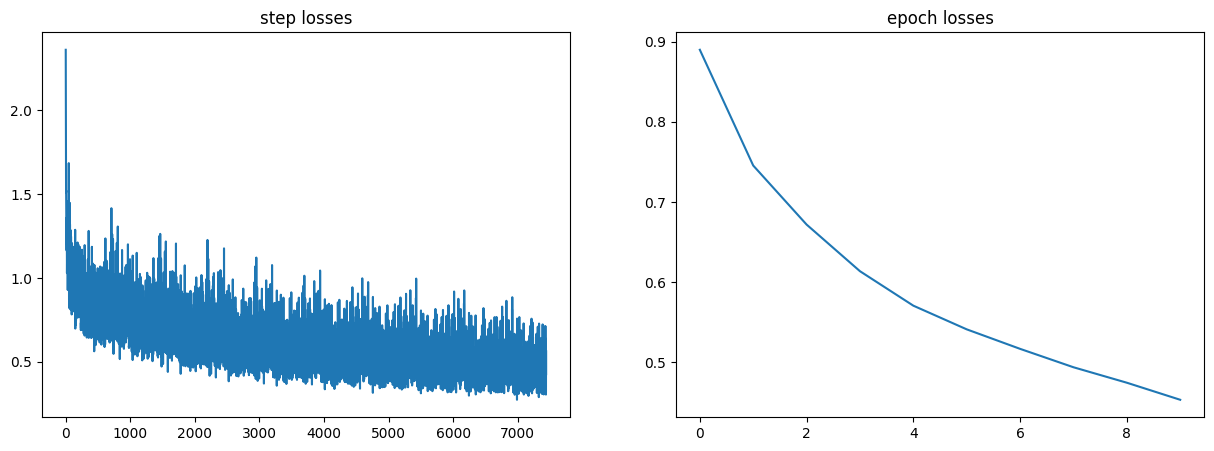

In [35]:
##TODO
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(step_losses)
axes[0].set_title('step losses')

axes[1].plot(epoch_losses)
axes[1].set_title('epoch losses')

plt.show()

In [25]:
model_name = "UNet.pth"
torch.save(model.state_dict(), root_path + model_name)

# **3. 모델 평가**

In [26]:
model_path = root_path + model_name
model_ = UNet(num_classes = num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

/tmp/ipykernel_1758914/1516665964.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [27]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.092235275..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.088313684..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.088313684..0.98823524].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06478428..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045176413..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10399997..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10007839..1.0].
Clipping 

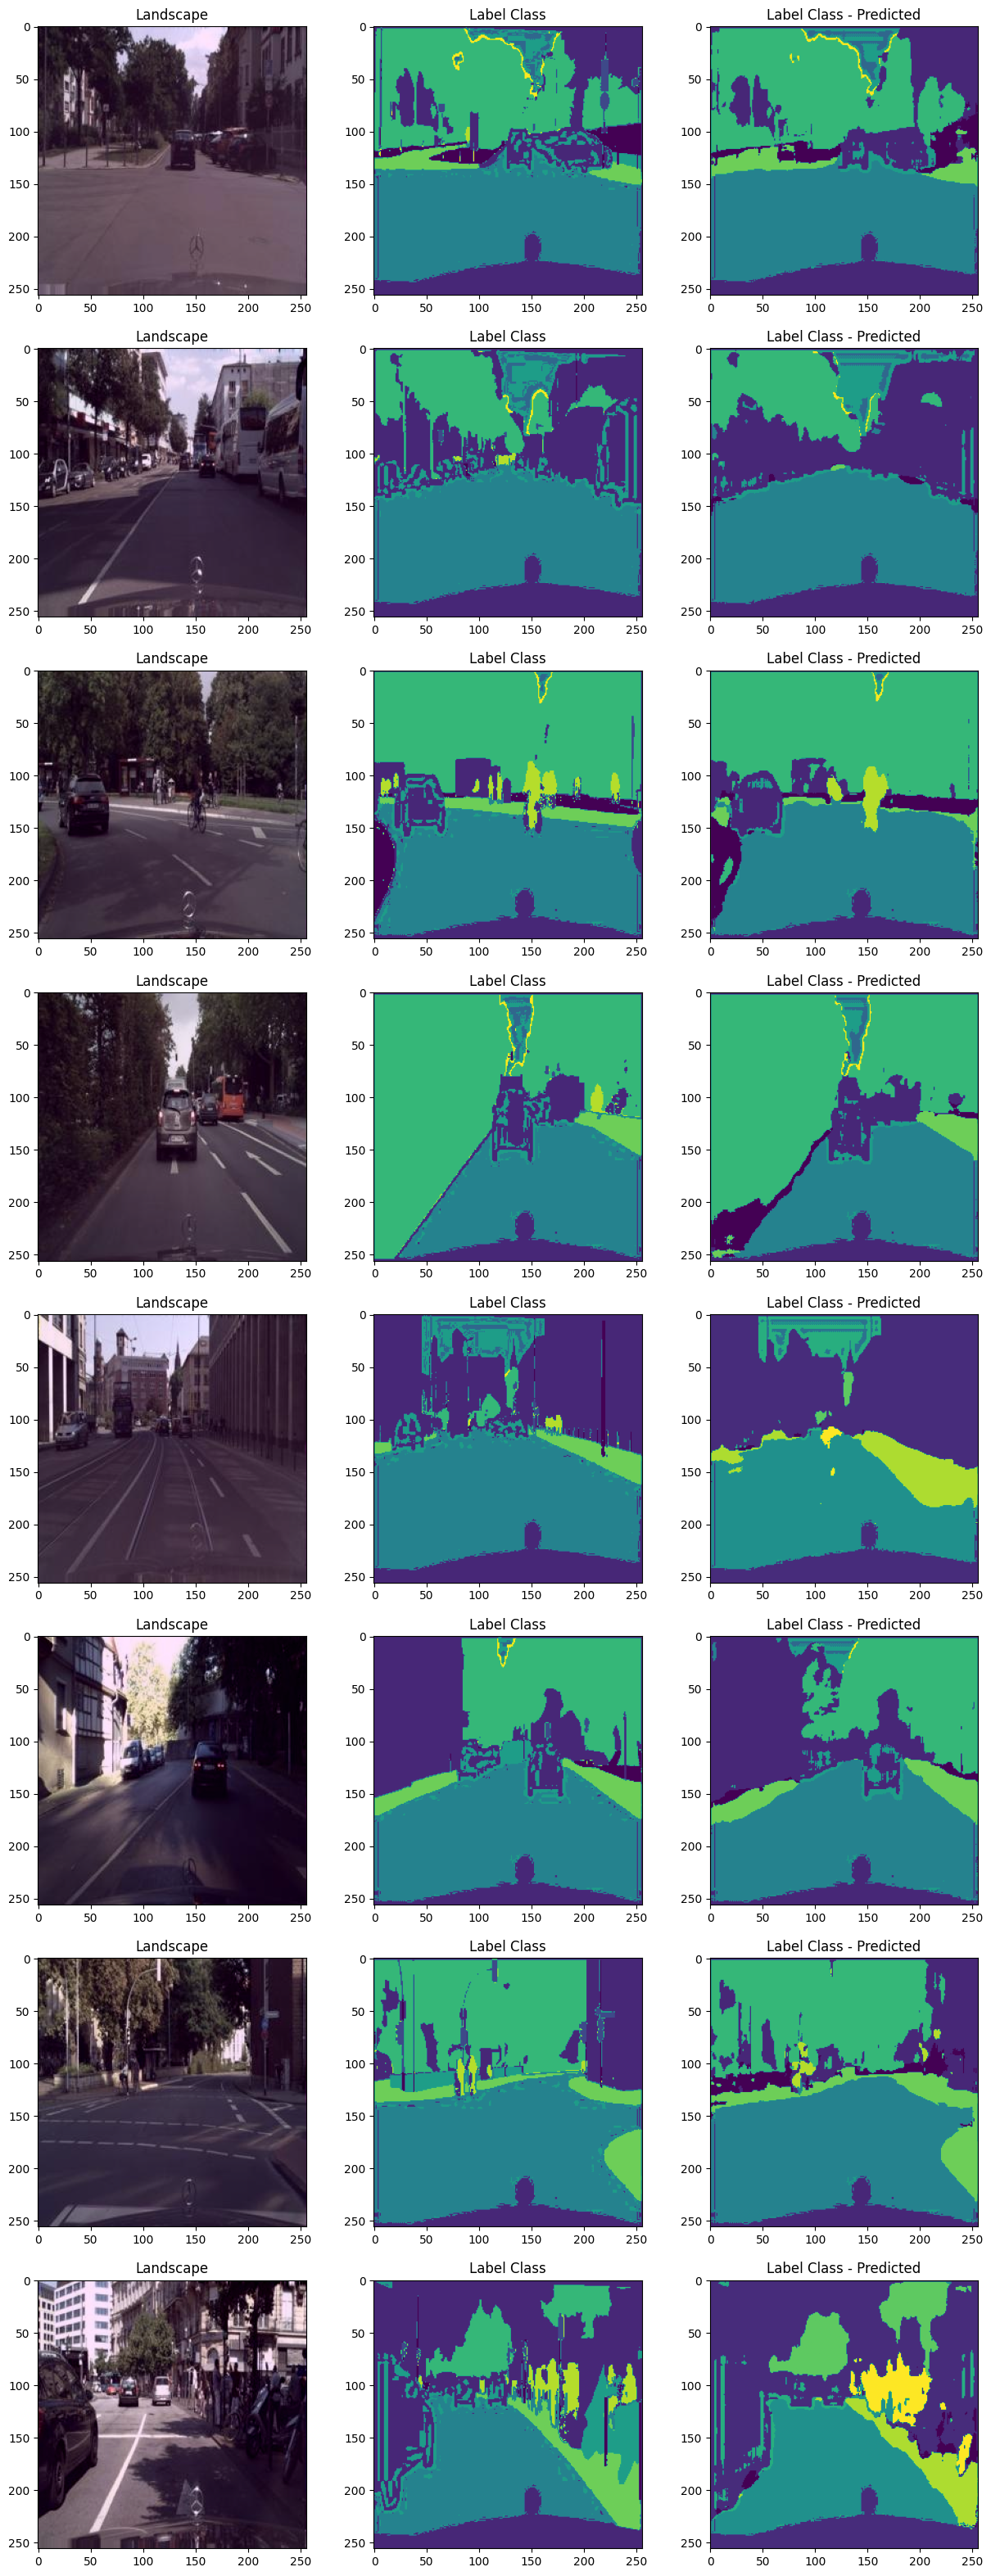

In [34]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

# **4. IoU Score**

In [29]:
##TODO
np.mean(iou_scores)

0.978661650367527